# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right???

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [2]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.8.1+cu101
CUDA enabled: True


In [3]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Mounted at /gdrive
MyDrive  Shareddrives


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [12]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
# DATA_PATH = '/content/'
DATA_PATH = BASE_PATH

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

In [6]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [26]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = data.replace("\n", " ")
    data = data.replace("\t", " ")
    data = data.replace("\r", " ")
    data = data.replace("\v", " ")
    data = data.replace("\x1f", " ")
    
    voc2ind = {k: v for v, k in enumerate(set(data))}
    print(voc2ind)
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    #for char in data:
    #    pass # TODO Fill this in
    data_arr = np.array([voc2ind[char] for char in data])

    ind2voc = {val: key for key, val in voc2ind.items()}

    split_point = int(0.8 * data_arr.size)
    train_text, test_text = np.split(data_arr, [split_point])
    print(len(train_text))
    print(len(test_text))
    #train_text = None # TODO Fill this in
    #test_text = None # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

{'T': 0, 'B': 1, '?': 2, 'A': 3, '/': 4, 'm': 5, '.': 6, 'C': 7, '1': 8, '^': 9, 's': 10, 'S': 11, '"': 12, ')': 13, 'b': 14, '-': 15, 'o': 16, '~': 17, '6': 18, '7': 19, 'Z': 20, '!': 21, 'P': 22, 'R': 23, '}': 24, '\\': 25, 'u': 26, '0': 27, 'F': 28, 'D': 29, 'i': 30, 'l': 31, ':': 32, '5': 33, 'd': 34, '3': 35, 'M': 36, 'j': 37, '[': 38, 'L': 39, 'c': 40, 'z': 41, 'f': 42, ',': 43, 'p': 44, '4': 45, 'n': 46, 'h': 47, 'Y': 48, '=': 49, ';': 50, '8': 51, '`': 52, 'N': 53, 'k': 54, '%': 55, 'E': 56, '2': 57, '$': 58, 'W': 59, 'x': 60, 'Q': 61, 'G': 62, 'X': 63, ']': 64, 'e': 65, 't': 66, '*': 67, 'U': 68, 'V': 69, 'v': 70, 'I': 71, '(': 72, 'q': 73, '_': 74, '{': 75, ' ': 76, 'r': 77, 'O': 78, 'y': 79, 'K': 80, '&': 81, 'H': 82, 'J': 83, 'w': 84, "'": 85, 'a': 86, 'g': 87, '9': 88}
5000121
1250031


#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [35]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        # make len(dataset) a multiple of batch_size
        extra_seqs = (len(dataset['tokens']) // self.sequence_length) % self.batch_size
        extra_chars = self.sequence_length * extra_seqs
        dataset['tokens'] = dataset['tokens'][:-extra_chars]
        self.dataset = dataset


    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters
        return len(self.dataset['tokens']) // self.sequence_length 
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        batch = int(idx / self.batch_size)
        chunk = idx % self.batch_size

        batch_start = batch * self.sequence_length
        chunk_offset = (len(self.dataset['tokens']) // self.batch_size) * chunk
        data_start = batch_start + chunk_offset

        last_batch_cutoff = (len(self.dataset['tokens']) // self.batch_size) * (chunk + 1)
        data_end = min(last_batch_cutoff, data_start + self.sequence_length + 1)

        data = torch.LongTensor(self.dataset['tokens'][data_start:data_end])
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [ ]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x) 

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [20]:
TEMPERATURE = 2
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        am = torch.argmax(output)
        outputs.append(am)
        output, hidden = model.inference(am, hidden, TEMPERATURE)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        sample = torch.multinomial(output, 1)
        outputs.append(sample)
        output, hidden = model.inference(sample, hidden, TEMPERATURE)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beams = [([], output, hidden, 0)]
    # TODO
    for i in range(0, sequence_length):
        new_beams = []
        for beam in beams:
            beam_chars = beam[0]
            beam_output = beam[1]
            beam_hidden = beam[2]
            beam_log_like = beam[3]

            samples = torch.multinomial(beam_output, beam_width)
            samples = samples.squeeze()
            for sample in samples:
                new_log_like = beam_log_like + torch.log(beam_output[0][sample])
                new_output, new_hidden = model.inference(sample, beam_hidden, TEMPERATURE)
                new_chars = [char for char in beam_chars] + [sample]
                new_beams.append([new_chars, new_output, new_hidden, new_log_like])
            
        new_beams = sorted(new_beams, key=lambda l: l[3], reverse=True)
        beams = new_beams[:beam_width]

    outputs = beams[0][0]

    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [21]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([89, 512]) = 0MB
gru.weight_ih_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l0 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([1536]) = 0MB
decoder.weight -> 	torch.Size([89, 512]) = 0MB
decoder.bias -> 	torch.Size([89]) = 0MB

Restored all variables
No new variables
Restored /content/checkpoints/000.pt
Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	r y aar aoat ah rrt aarcr  autoule aolderort aad aaacged on warr...aa waamg aim elf arer ah aherrnre


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahat aad aam fnoo 

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.9801, Accuracy: 553442/1228800 (45%)



  1%|          | 1/195 [00:00<00:27,  7.14it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 1.970913


  7%|▋         | 13/195 [00:01<00:16, 10.98it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 6.707252


 12%|█▏        | 23/195 [00:01<00:14, 11.93it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 3.551233


 17%|█▋        | 33/195 [00:02<00:13, 12.00it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 2.548827


 22%|██▏       | 43/195 [00:03<00:12, 12.06it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 2.158668


 27%|██▋       | 53/195 [00:04<00:11, 11.89it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 1.972321


 32%|███▏      | 63/195 [00:05<00:11, 11.89it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 1.879521


 37%|███▋      | 73/195 [00:06<00:10, 11.87it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 1.838008


 43%|████▎     | 83/195 [00:07<00:09, 11.90it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 2.178533


 48%|████▊     | 93/195 [00:07<00:08, 11.76it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 2.172831


 53%|█████▎    | 103/195 [00:08<00:07, 11.87it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 1.862106


 58%|█████▊    | 113/195 [00:09<00:06, 11.94it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 1.796054


 63%|██████▎   | 123/195 [00:10<00:06, 11.82it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 1.759089


 68%|██████▊   | 133/195 [00:11<00:05, 11.93it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 1.736003


 73%|███████▎  | 143/195 [00:12<00:04, 11.78it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 1.706270


 78%|███████▊  | 153/195 [00:12<00:03, 11.79it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 1.668133


 84%|████████▎ | 163/195 [00:13<00:02, 11.83it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 1.675130


 89%|████████▊ | 173/195 [00:14<00:01, 11.77it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 1.842372


 94%|█████████▍| 183/195 [00:15<00:01, 11.85it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 2.102156


 99%|█████████▉| 193/195 [00:16<00:00, 11.66it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 1.827449


100%|██████████| 195/195 [00:16<00:00, 11.81it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y aes toat to tet toscr. tutause weldemort aiv saaceed sn oeua . aa weoneeaim elf afer hh hhe tnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 aoet tov sis wnms "t weaasssd tim  ticl ng aack ardssn o the toscr.aoth t ltaacse he waaabbled oo b


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rhr hnd sis waet.aoat toe tlound tn hhe  wokted tim tnd sa wn ao solei aas  ttewey atd sede y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. . . . . . . you were you are you are you are you are your and seemed to be and seemed to be the trying to the too. Harry and stared to see him the too. Harry and stared to see him the too. Harry and s



  1%|          | 1/195 [00:00<00:38,  5.03it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 1.754580


  6%|▌         | 12/195 [00:01<00:17, 10.25it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 1.660054


 11%|█▏        | 22/195 [00:01<00:14, 11.66it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 1.654209


 16%|█▋        | 32/195 [00:02<00:13, 12.13it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 1.599949


 22%|██▏       | 42/195 [00:03<00:12, 12.19it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 1.597505


 27%|██▋       | 52/195 [00:04<00:11, 12.05it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 1.599989


 32%|███▏      | 62/195 [00:05<00:11, 11.83it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 1.577049


 37%|███▋      | 72/195 [00:06<00:10, 12.19it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 1.596533


 42%|████▏     | 82/195 [00:06<00:09, 12.12it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 1.787266


 47%|████▋     | 92/195 [00:07<00:08, 12.06it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 1.669365


 52%|█████▏    | 102/195 [00:08<00:07, 12.00it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 1.658086


 57%|█████▋    | 112/195 [00:09<00:06, 12.07it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 1.739353


 63%|██████▎   | 122/195 [00:10<00:06, 11.82it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 1.618164


 68%|██████▊   | 132/195 [00:11<00:05, 11.89it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 1.589524


 73%|███████▎  | 142/195 [00:11<00:04, 11.88it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 1.565540


 78%|███████▊  | 152/195 [00:12<00:03, 11.97it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 1.551628


 83%|████████▎ | 162/195 [00:13<00:02, 11.77it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 1.540331


 88%|████████▊ | 172/195 [00:14<00:01, 11.83it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 1.541006


 93%|█████████▎| 182/195 [00:15<00:01, 11.85it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 1.596133


 98%|█████████▊| 192/195 [00:16<00:00, 11.81it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 1.609675


100%|██████████| 195/195 [00:16<00:00, 11.83it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y shs toat th tet thscr. tuhause weldemort wid alacced wn woms..  e weetg his elf afer th hhe snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 soot wed ses s m     weaadsed tis  tlcl ng arck ard tn o the sascr.ohth h steacse se wtresbled ah s


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe s d ses sell aeat the sround t  she  wekthd tis s d se an so sarry das  ttiwly asd stdp y  suck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He was still stop of the stood who was still stopped around the stood who was still stop of the stood something around the stood something around the stood something around the stood something around 



  1%|          | 2/195 [00:00<00:34,  5.64it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 1.599101


  6%|▌         | 12/195 [00:01<00:17, 10.22it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 1.569049


 11%|█▏        | 22/195 [00:01<00:14, 11.85it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 1.564989


 16%|█▋        | 32/195 [00:02<00:13, 12.20it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 1.513657


 22%|██▏       | 42/195 [00:03<00:12, 12.29it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 1.510553


 27%|██▋       | 52/195 [00:04<00:11, 12.01it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 1.519520


 32%|███▏      | 62/195 [00:05<00:10, 12.24it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 1.490973


 37%|███▋      | 72/195 [00:06<00:10, 12.30it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 1.495701


 42%|████▏     | 82/195 [00:06<00:09, 12.17it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 1.521462


 47%|████▋     | 92/195 [00:07<00:08, 12.18it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 1.516219


 52%|█████▏    | 102/195 [00:08<00:07, 12.27it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 1.484494


 57%|█████▋    | 112/195 [00:09<00:06, 12.33it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 1.514393


 63%|██████▎   | 122/195 [00:10<00:06, 12.16it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 1.527065


 68%|██████▊   | 132/195 [00:10<00:05, 11.98it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 1.521422


 73%|███████▎  | 142/195 [00:11<00:04, 11.86it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 1.533312


 78%|███████▊  | 152/195 [00:12<00:03, 12.02it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 1.515106


 83%|████████▎ | 162/195 [00:13<00:02, 11.87it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 1.478283


 88%|████████▊ | 172/195 [00:14<00:01, 12.06it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 1.468602


 93%|█████████▎| 182/195 [00:15<00:01, 11.92it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 1.510581


 98%|█████████▊| 192/195 [00:15<00:00, 11.91it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 1.444660


100%|██████████| 195/195 [00:16<00:00, 11.98it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y aas aoat th set aascr  aecause eeldemort wad beeceed an wema.. aa weetg aas elf auer hh hhe enge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 soat had bas enm     weaeased tis  becl ng aeck ard tn o the salcr aath a sueacse ae weaebbled ao b


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and ses eeet aeat the cround an hhe  wekted ais a d seean so sarry aas  atiwly asd sede y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor McGonagall was suddenly as he was suddenly as he was suddenly as he was suddenly as he was suddenly as he was suddenly as he was suddenly as he was suddenly as he was suddenly and seemed to 



  1%|          | 1/195 [00:00<00:37,  5.12it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 1.499324


  6%|▌         | 12/195 [00:01<00:17, 10.46it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 1.488903


 11%|█▏        | 22/195 [00:01<00:14, 11.66it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 1.503175


 16%|█▋        | 32/195 [00:02<00:13, 11.90it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 1.459251


 22%|██▏       | 42/195 [00:03<00:12, 11.88it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 1.459043


 27%|██▋       | 52/195 [00:04<00:11, 12.18it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 1.454172


 32%|███▏      | 62/195 [00:05<00:10, 12.10it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 1.429546


 37%|███▋      | 72/195 [00:06<00:10, 11.94it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 1.448171


 42%|████▏     | 82/195 [00:06<00:09, 12.21it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 1.468820


 47%|████▋     | 92/195 [00:07<00:08, 11.99it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 1.454875


 52%|█████▏    | 102/195 [00:08<00:07, 12.15it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 1.428390


 57%|█████▋    | 112/195 [00:09<00:06, 12.06it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 1.472861


 63%|██████▎   | 122/195 [00:10<00:06, 12.11it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 1.465650


 68%|██████▊   | 132/195 [00:11<00:05, 11.79it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 1.458405


 73%|███████▎  | 142/195 [00:11<00:04, 11.93it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 1.446606


 78%|███████▊  | 152/195 [00:12<00:03, 11.79it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 1.440383


 83%|████████▎ | 162/195 [00:13<00:02, 11.84it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.442257


 88%|████████▊ | 172/195 [00:14<00:01, 11.70it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 1.427991


 93%|█████████▎| 182/195 [00:15<00:01, 11.86it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 1.469487


 98%|█████████▊| 192/195 [00:16<00:00, 11.83it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.476935


100%|██████████| 195/195 [00:16<00:00, 11.84it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	r y shs toat hh sit aiscr  hucause holdemort wad bueceed sn whms .  a wiesg hisself fner hh hhe snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 shat hed sas hrms    wiaiased his  hrcl ng hack ardstn o the salcr sith h shiicse he whriwbled hh s


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe snd ses siet aiat hhe sroundshn hhey wekthd hissssd sehan sh shrri hass hhiwly asd shde y  suck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor McGonagall was suddenly she was suddenly she was suddenly she was suddenly she was suddenly she was suddenly she was suddenly she was suddenly she was suddenly slightly as he had sheed his h



  1%|          | 2/195 [00:00<00:35,  5.51it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.508730


  6%|▌         | 12/195 [00:01<00:18, 10.12it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 1.457807


 11%|█▏        | 22/195 [00:01<00:14, 11.85it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.447644


 16%|█▋        | 32/195 [00:02<00:13, 12.21it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.399752


 22%|██▏       | 42/195 [00:03<00:12, 11.98it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.420008


 27%|██▋       | 52/195 [00:04<00:11, 12.21it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 1.416917


 32%|███▏      | 62/195 [00:05<00:11, 12.00it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.400540


 37%|███▋      | 72/195 [00:06<00:10, 12.22it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.416366


 42%|████▏     | 82/195 [00:06<00:09, 12.00it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.425021


 47%|████▋     | 92/195 [00:07<00:08, 11.93it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.420021


 52%|█████▏    | 102/195 [00:08<00:07, 12.18it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 1.406813


 57%|█████▋    | 112/195 [00:09<00:06, 11.97it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.440003


 63%|██████▎   | 122/195 [00:10<00:06, 11.98it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.440721


 68%|██████▊   | 132/195 [00:11<00:05, 11.85it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.432889


 73%|███████▎  | 142/195 [00:11<00:04, 11.97it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.421742


 78%|███████▊  | 152/195 [00:12<00:03, 12.18it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.418569


 83%|████████▎ | 162/195 [00:13<00:02, 11.86it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.418753


 88%|████████▊ | 172/195 [00:14<00:01, 11.84it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 1.465371


 93%|█████████▎| 182/195 [00:15<00:01, 11.72it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.449291


 98%|█████████▊| 192/195 [00:16<00:00, 11.97it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.382876


100%|██████████| 195/195 [00:16<00:00, 11.89it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y aes toft th tet oascr  tucause heldemort wad bueceed an wemh . aa weetg himself fuer hh hhe cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 woat hed has hrm     weaaase  tis  hrcl ng aack ard tn o the caler oath h steasse he wtrewbled oh h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tes feet aest the cround hn hhe  wegted his a d tenan to tlrry aass ttiwly atd stde y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor McGonagall was staring at the wall of his face was staring at the wall of his face was staring at the wall of his face was staring at the wall of his face was staring at the wall of his face



  2%|▏         | 3/195 [00:00<00:32,  5.98it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.421258


  7%|▋         | 13/195 [00:01<00:17, 10.22it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 1.395614


 12%|█▏        | 23/195 [00:02<00:14, 11.78it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.410999


 17%|█▋        | 33/195 [00:02<00:13, 12.15it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.403860


 22%|██▏       | 43/195 [00:03<00:12, 12.15it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.412849


 27%|██▋       | 53/195 [00:04<00:11, 12.11it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 1.402467


 32%|███▏      | 63/195 [00:05<00:10, 12.15it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.386256


 37%|███▋      | 73/195 [00:06<00:10, 12.07it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.393248


 43%|████▎     | 83/195 [00:07<00:09, 12.11it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.390827


 48%|████▊     | 93/195 [00:07<00:08, 11.93it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.397238


 53%|█████▎    | 103/195 [00:08<00:07, 11.96it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.384156


 58%|█████▊    | 113/195 [00:09<00:06, 11.96it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.414383


 63%|██████▎   | 123/195 [00:10<00:05, 12.20it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.420794


 68%|██████▊   | 133/195 [00:11<00:05, 12.07it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.428539


 73%|███████▎  | 143/195 [00:11<00:04, 11.89it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.419325


 78%|███████▊  | 153/195 [00:12<00:03, 12.00it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.395057


 84%|████████▎ | 163/195 [00:13<00:02, 12.00it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.389707


 89%|████████▊ | 173/195 [00:14<00:01, 12.15it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.391033


 94%|█████████▍| 183/195 [00:15<00:00, 12.13it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.405713


 99%|█████████▉| 193/195 [00:16<00:00, 11.94it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.364272


100%|██████████| 195/195 [00:16<00:00, 11.91it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y wes toft th tet tiscr  tucause holdemort wad bueneed tn wemt . aa weesg himself fuer th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 what had ham hrms    weaiased tis  hrcl ng aack ard tn o the caler oath h ltiisse he wtrembled oh t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  tnd tes faet aost the cround hn hhe  wekted tissatd senan to tlrry aass htiwly atd stde y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry and Hermione was standing at the wall of his face was standing at the wall of his face was standing at the wall of his face was standing at the wall of his face was standing at the close of the 



  1%|          | 2/195 [00:00<00:34,  5.56it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.401621


  6%|▌         | 12/195 [00:01<00:17, 10.19it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.379140


 11%|█▏        | 22/195 [00:01<00:14, 11.91it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.393775


 16%|█▋        | 32/195 [00:02<00:13, 12.04it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.361517


 22%|██▏       | 42/195 [00:03<00:12, 12.23it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.388554


 27%|██▋       | 52/195 [00:04<00:11, 12.15it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.386794


 32%|███▏      | 62/195 [00:05<00:10, 12.15it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.366574


 37%|███▋      | 72/195 [00:06<00:10, 12.19it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.380957


 42%|████▏     | 82/195 [00:06<00:09, 12.29it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.388914


 47%|████▋     | 92/195 [00:07<00:08, 12.12it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.397482


 52%|█████▏    | 102/195 [00:08<00:07, 12.20it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.385939


 57%|█████▋    | 112/195 [00:09<00:06, 12.29it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.408434


 63%|██████▎   | 122/195 [00:10<00:05, 12.28it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.396758


 68%|██████▊   | 132/195 [00:11<00:05, 12.13it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.394378


 73%|███████▎  | 142/195 [00:11<00:04, 11.98it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.391466


 78%|███████▊  | 152/195 [00:12<00:03, 11.83it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.386455


 83%|████████▎ | 162/195 [00:13<00:02, 11.88it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.375621


 88%|████████▊ | 172/195 [00:14<00:01, 11.88it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.375734


 93%|█████████▎| 182/195 [00:15<00:01, 11.87it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.395367


 98%|█████████▊| 192/195 [00:16<00:00, 11.74it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.357468


100%|██████████| 195/195 [00:16<00:00, 11.95it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y aas toft th tet tiscr  tucause holdemort wad breneed tn wemt . ae weetg himself tuer th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 woat hed ham hrms    weaiased tim  hrcl ng aeck ardstn o the caler oath t ltiisse he wtrembled oh t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  tnd tes faet aift the cround an hhe  wekted tim atd senan to tlrry aims atiwly atd stde y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Weasley was standing at the close of the parchment of the parchment of the parchment of the parchment of the parchment of the parchment of the parchment of the parchment of the part of the close of th



  1%|          | 1/195 [00:00<00:38,  5.07it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.389525


  6%|▌         | 12/195 [00:01<00:17, 10.22it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.368228


 11%|█▏        | 22/195 [00:01<00:14, 11.92it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.383285


 16%|█▋        | 32/195 [00:02<00:13, 12.26it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 1.349038


 22%|██▏       | 42/195 [00:03<00:12, 12.10it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.374012


 27%|██▋       | 52/195 [00:04<00:12, 11.91it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.373250


 32%|███▏      | 62/195 [00:05<00:11, 12.03it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.352430


 37%|███▋      | 72/195 [00:06<00:10, 12.21it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.371889


 42%|████▏     | 82/195 [00:06<00:09, 12.33it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.368770


 47%|████▋     | 92/195 [00:07<00:08, 12.06it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.373271


 52%|█████▏    | 102/195 [00:08<00:07, 11.94it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.373496


 57%|█████▋    | 112/195 [00:09<00:06, 12.25it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.404797


 63%|██████▎   | 122/195 [00:10<00:06, 12.12it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.397462


 68%|██████▊   | 132/195 [00:11<00:05, 12.05it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.390463


 73%|███████▎  | 142/195 [00:11<00:04, 11.98it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.386567


 78%|███████▊  | 152/195 [00:12<00:03, 11.94it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.378076


 83%|████████▎ | 162/195 [00:13<00:02, 12.03it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.371142


 88%|████████▊ | 172/195 [00:14<00:01, 11.97it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.364788


 93%|█████████▎| 182/195 [00:15<00:01, 11.78it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.386572


 98%|█████████▊| 192/195 [00:16<00:00, 11.86it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.346964


100%|██████████| 195/195 [00:16<00:00, 11.91it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y tas toft th tet tiscr  tucause holdemort wad breneed tn wemt . ae weetg himself tuer th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hoat hed tam hrms    weaiased tim  arcling aack ardstn o the caler.oath t lteisse se wtrewbled oh t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  snd tes faet aist the cround hn hhe  wekted tim and seean to tlrry aims atiwly atd stdp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't know what they were not to tell the things that they were not to tell the things that they were not to tell the things that he had been trying to tell the things that he had been trying to th



  1%|          | 1/195 [00:00<00:37,  5.14it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.379796


  7%|▋         | 13/195 [00:01<00:17, 10.47it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.359884


 12%|█▏        | 23/195 [00:02<00:14, 11.76it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.377621


 17%|█▋        | 33/195 [00:02<00:13, 11.84it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.342212


 22%|██▏       | 43/195 [00:03<00:12, 11.93it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.362588


 27%|██▋       | 53/195 [00:04<00:11, 11.94it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.364384


 32%|███▏      | 63/195 [00:05<00:11, 11.97it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.350810


 37%|███▋      | 73/195 [00:06<00:10, 12.09it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.360841


 43%|████▎     | 83/195 [00:07<00:09, 11.97it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.367135


 48%|████▊     | 93/195 [00:07<00:08, 12.23it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.363763


 53%|█████▎    | 103/195 [00:08<00:07, 11.98it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.359482


 58%|█████▊    | 113/195 [00:09<00:06, 11.88it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.382600


 63%|██████▎   | 123/195 [00:10<00:06, 11.83it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.382853


 68%|██████▊   | 133/195 [00:11<00:05, 11.81it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.384097


 73%|███████▎  | 143/195 [00:12<00:04, 11.82it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.376258


 78%|███████▊  | 153/195 [00:12<00:03, 11.94it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.368389


 84%|████████▎ | 163/195 [00:13<00:02, 12.11it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.375152


 89%|████████▊ | 173/195 [00:14<00:01, 11.82it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.364812


 94%|█████████▍| 183/195 [00:15<00:01, 11.83it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.385776


 99%|█████████▉| 193/195 [00:16<00:00, 11.80it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.337633


100%|██████████| 195/195 [00:16<00:00, 11.84it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y sas toft th tet tiscr  tucause holdemort wad breneed tt wems . ae weeng him elf tfer th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hoat had tam hrms "  waaiased tim  arcling aack ardstn o the saler.oath t steiss  se wtrewbled oh t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  snd ses faet aist the cround an hhey wokted tim and senan to tlrry aims atiwly atd stdp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry and Hermione was starting at the close of the stop of the stop of the stop of the stairs and started to the close to the close to the stop of the stop of the stop of the stop of the stop of the 



  1%|          | 1/195 [00:00<00:38,  5.04it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.372815


  6%|▌         | 12/195 [00:01<00:17, 10.27it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.355512


 11%|█▏        | 22/195 [00:01<00:14, 11.67it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.366067


 16%|█▋        | 32/195 [00:02<00:13, 11.73it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.336084


 22%|██▏       | 42/195 [00:03<00:12, 11.88it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.356177


 27%|██▋       | 52/195 [00:04<00:11, 12.20it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.361251


 32%|███▏      | 62/195 [00:05<00:10, 12.26it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.337853


 37%|███▋      | 72/195 [00:06<00:10, 12.03it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.354204


 42%|████▏     | 82/195 [00:06<00:09, 11.96it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.359531


 47%|████▋     | 92/195 [00:07<00:08, 11.98it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.361129


 52%|█████▏    | 102/195 [00:08<00:07, 11.89it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.356122


 57%|█████▋    | 112/195 [00:09<00:06, 12.23it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.378338


 63%|██████▎   | 122/195 [00:10<00:06, 12.16it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.373550


 68%|██████▊   | 132/195 [00:11<00:05, 12.06it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.374783


 73%|███████▎  | 142/195 [00:11<00:04, 12.03it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.367520


 78%|███████▊  | 152/195 [00:12<00:03, 11.95it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.359795


 83%|████████▎ | 162/195 [00:13<00:02, 11.73it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.360834


 88%|████████▊ | 172/195 [00:14<00:01, 11.85it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.354335


 93%|█████████▎| 182/195 [00:15<00:01, 11.99it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.377093


 98%|█████████▊| 192/195 [00:16<00:00, 12.03it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.335711


100%|██████████| 195/195 [00:16<00:00, 11.89it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y sas toft th tet aiscr  tucause heldemort wad branned tt we f . ae weeng him elf tfer th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hhet hed bam hrms    weaiased tim  arcling aack ardstn o the caler.oith t steiss  se htrewbeed oh t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  snd tes faet aest the cround an hhe  wekted tim and secan to slrry aiss atiwly atd stdp y  suck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't know what you don't know what happened to get the other side of the people of the particularly seemed to be everything that he had the best of the particularly seemed to be everything that he



  1%|          | 1/195 [00:00<00:38,  5.07it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.370231


  7%|▋         | 13/195 [00:01<00:17, 10.46it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.353094


 12%|█▏        | 23/195 [00:02<00:14, 11.73it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.362100


 17%|█▋        | 33/195 [00:02<00:13, 12.00it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.332696


 22%|██▏       | 43/195 [00:03<00:12, 12.26it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.349812


 27%|██▋       | 53/195 [00:04<00:11, 12.02it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.357458


 32%|███▏      | 63/195 [00:05<00:10, 12.26it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.336210


 37%|███▋      | 73/195 [00:06<00:10, 12.06it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.350423


 43%|████▎     | 83/195 [00:06<00:09, 11.98it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.352768


 48%|████▊     | 93/195 [00:07<00:08, 12.07it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.352451


 53%|█████▎    | 103/195 [00:08<00:07, 11.77it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.351877


 58%|█████▊    | 113/195 [00:09<00:06, 12.19it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.379094


 63%|██████▎   | 123/195 [00:10<00:06, 11.83it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.368351


 68%|██████▊   | 133/195 [00:11<00:05, 11.91it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.369283


 73%|███████▎  | 143/195 [00:11<00:04, 12.19it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.361940


 78%|███████▊  | 153/195 [00:12<00:03, 12.01it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.356382


 84%|████████▎ | 163/195 [00:13<00:02, 11.87it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.353914


 89%|████████▊ | 173/195 [00:14<00:01, 11.72it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.348666


 94%|█████████▍| 183/195 [00:15<00:01, 11.84it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.371231


 99%|█████████▉| 193/195 [00:16<00:00, 12.00it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.333310


100%|██████████| 195/195 [00:16<00:00, 11.89it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas toft th tet oiscr  tucause heldemort wad branted tt ie t . ae weeng him elf tfer th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hhet hed bam hrms    weaiased tim  trcling aack ardstn o the caler.oith t bteics  te heoewbeed to t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  snd tes faet aeft the cround tn hhe  wekted tim tnd secan to tlrry him  aoiwly atd stdp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't know what you don't know what happened to tell the Death Eaters were standing in the end of the story of the particularly seemed to be everything that had been trying to tell the Death Eaters



  1%|          | 2/195 [00:00<00:34,  5.64it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.369106


  6%|▌         | 12/195 [00:01<00:18,  9.97it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.351801


 11%|█▏        | 22/195 [00:01<00:14, 11.81it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.357236


 16%|█▋        | 32/195 [00:02<00:13, 12.03it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.325760


 22%|██▏       | 42/195 [00:03<00:12, 12.05it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.343433


 27%|██▋       | 52/195 [00:04<00:12, 11.90it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.352654


 32%|███▏      | 62/195 [00:05<00:11, 11.79it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.333166


 37%|███▋      | 72/195 [00:06<00:10, 12.16it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.346392


 42%|████▏     | 82/195 [00:06<00:09, 12.11it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.347950


 47%|████▋     | 92/195 [00:07<00:08, 11.93it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.345473


 52%|█████▏    | 102/195 [00:08<00:07, 11.87it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.344834


 57%|█████▋    | 112/195 [00:09<00:06, 11.88it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.371333


 63%|██████▎   | 122/195 [00:10<00:06, 11.97it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.363525


 68%|██████▊   | 132/195 [00:11<00:05, 12.04it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.362468


 73%|███████▎  | 142/195 [00:12<00:04, 12.02it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.358784


 78%|███████▊  | 152/195 [00:12<00:03, 11.88it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.351619


 83%|████████▎ | 162/195 [00:13<00:02, 11.99it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.350625


 88%|████████▊ | 172/195 [00:14<00:01, 11.75it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.345032


 93%|█████████▎| 182/195 [00:15<00:01, 11.80it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.364957


 98%|█████████▊| 192/195 [00:16<00:00, 11.77it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.328244


100%|██████████| 195/195 [00:16<00:00, 11.78it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tift th tet oiscr  tucause holdemort wad branted tt ie t . ae weeng him elf tner th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hoat hed bat hrms    weaiased tim  trcling aeck ardstnto the caler.oith t bteics  te htoewbeed to t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  snd tes faet aift the cround tn hhey wekted tim tnd tecan to tlrry him  toiwly atd stdp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Mrs. Weasley was sitting to the close of the cloak of the cloak of the cloak of the cloak of the cloak of the cloak of the cloak of the cloak of the cloak of the cloak of the cloak of the cloak of the



  1%|          | 2/195 [00:00<00:33,  5.78it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.363038


  6%|▌         | 12/195 [00:01<00:17, 10.31it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.347752


 11%|█▏        | 22/195 [00:01<00:14, 11.93it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.352734


 16%|█▋        | 32/195 [00:02<00:13, 12.03it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.322262


 22%|██▏       | 42/195 [00:03<00:12, 11.89it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.337971


 27%|██▋       | 52/195 [00:04<00:11, 12.22it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.349874


 32%|███▏      | 62/195 [00:05<00:11, 12.09it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.327916


 37%|███▋      | 72/195 [00:06<00:10, 12.22it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.343539


 42%|████▏     | 82/195 [00:06<00:09, 11.99it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.344807


 47%|████▋     | 92/195 [00:07<00:08, 11.88it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.340129


 52%|█████▏    | 102/195 [00:08<00:07, 11.75it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.339108


 57%|█████▋    | 112/195 [00:09<00:06, 12.04it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.365106


 63%|██████▎   | 122/195 [00:10<00:06, 11.89it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.359003


 68%|██████▊   | 132/195 [00:11<00:05, 11.74it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.358502


 73%|███████▎  | 142/195 [00:11<00:04, 11.90it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.355205


 78%|███████▊  | 152/195 [00:12<00:03, 12.01it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.346815


 83%|████████▎ | 162/195 [00:13<00:02, 12.00it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.346654


 88%|████████▊ | 172/195 [00:14<00:01, 11.95it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.340426


 93%|█████████▎| 182/195 [00:15<00:01, 11.85it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.359587


 98%|█████████▊| 192/195 [00:16<00:00, 12.05it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.325000


100%|██████████| 195/195 [00:16<00:00, 11.90it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tis tift th tet oiscr  tucause holdemort wad branted tt iomt . ae weeng him elf tner th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hoat hed bat hrms    weaiased tim  trcling aeck ardstn o the caler.oith t bteics  te htoewbeed to t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  snd tes faet aift the cround tn they wekted tim tnd tefan to tltry his  thiwly atd stdp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor McGonagall was starting to the close of the cloak of the cloak of the cloak of the cloak of the cloak of the cloak of the cloak of the cloak of the cloak of the cloak of the cloak of the clo



  1%|          | 2/195 [00:00<00:33,  5.71it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.358892


  6%|▌         | 12/195 [00:01<00:17, 10.34it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.345334


 11%|█▏        | 22/195 [00:01<00:14, 11.76it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.349264


 16%|█▋        | 32/195 [00:02<00:13, 12.24it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.320597


 22%|██▏       | 42/195 [00:03<00:12, 11.86it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.332926


 27%|██▋       | 52/195 [00:04<00:11, 12.15it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.347067


 32%|███▏      | 62/195 [00:05<00:10, 12.29it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.323110


 37%|███▋      | 72/195 [00:06<00:10, 12.10it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.340815


 42%|████▏     | 82/195 [00:06<00:09, 12.21it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.342455


 47%|████▋     | 92/195 [00:07<00:08, 12.33it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.335415


 52%|█████▏    | 102/195 [00:08<00:07, 11.96it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.334555


 57%|█████▋    | 112/195 [00:09<00:06, 12.19it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.360412


 63%|██████▎   | 122/195 [00:10<00:05, 12.28it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.354780


 68%|██████▊   | 132/195 [00:10<00:05, 12.00it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.354369


 73%|███████▎  | 142/195 [00:11<00:04, 11.91it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.350249


 78%|███████▊  | 152/195 [00:12<00:03, 12.21it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.341043


 83%|████████▎ | 162/195 [00:13<00:02, 12.03it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.341547


 88%|████████▊ | 172/195 [00:14<00:01, 11.92it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.337528


 93%|█████████▎| 182/195 [00:15<00:01, 11.91it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.356294


 98%|█████████▊| 192/195 [00:15<00:00, 11.93it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.323247


100%|██████████| 195/195 [00:16<00:00, 11.99it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tift th tet tiscr  tucause holdemort wad branned tt ie t . ae weeng his elf tner th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahet hed bat hrms    weaiased tim  trcling aeck ardsan o the caler.oith t bteics  se htoewbeed th t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  tnd tes faet aift the sround on hhey wekted tis tnd sefan to tltry his  thiwly atd stdp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't think you think you don't think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you think they were



  1%|          | 2/195 [00:00<00:35,  5.43it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.356670


  6%|▌         | 12/195 [00:01<00:18,  9.97it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.344441


 11%|█▏        | 22/195 [00:01<00:14, 11.63it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.347166


 16%|█▋        | 32/195 [00:02<00:13, 11.85it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.319604


 22%|██▏       | 42/195 [00:03<00:12, 11.95it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.328579


 27%|██▋       | 52/195 [00:04<00:12, 11.86it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.345238


 32%|███▏      | 62/195 [00:05<00:11, 12.08it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.320003


 37%|███▋      | 72/195 [00:06<00:10, 12.02it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.339124


 42%|████▏     | 82/195 [00:06<00:09, 11.95it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.341735


 47%|████▋     | 92/195 [00:07<00:08, 12.05it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.331943


 52%|█████▏    | 102/195 [00:08<00:07, 11.86it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.330953


 57%|█████▋    | 112/195 [00:09<00:07, 11.78it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.357455


 63%|██████▎   | 122/195 [00:10<00:06, 12.13it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.350326


 68%|██████▊   | 132/195 [00:11<00:05, 12.14it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.352203


 73%|███████▎  | 142/195 [00:11<00:04, 12.09it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.347087


 78%|███████▊  | 152/195 [00:12<00:03, 11.91it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.336920


 83%|████████▎ | 162/195 [00:13<00:02, 11.92it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.337252


 88%|████████▊ | 172/195 [00:14<00:01, 11.90it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.331685


 93%|█████████▎| 182/195 [00:15<00:01, 11.82it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.352950


 98%|█████████▊| 192/195 [00:16<00:00, 11.68it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.322119


100%|██████████| 195/195 [00:16<00:00, 11.81it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tift th tet tiscr  tucause holdemort wad branned tt io t . ae weeng him elf tuer th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahet hed bas hrm     weaiased tim  trcling aeck ardsan o the caler.oith t btrics  se htrewbeed oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  tnd tes faet aift the cround on the  wekted tis tnd sefan to tltry his  ahiwly atd stdp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He was starting at the stairs of the cloak and started to the close of the stairs of the stairs of the stairs of the stairs of the stairs of the stairs of the stairs of the cloak of the stairs of the 



  1%|          | 2/195 [00:00<00:33,  5.84it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.355457


  6%|▌         | 12/195 [00:01<00:18, 10.10it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.341977


 11%|█▏        | 22/195 [00:01<00:15, 11.47it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.343857


 16%|█▋        | 32/195 [00:02<00:13, 11.73it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.316108


 22%|██▏       | 42/195 [00:03<00:12, 12.00it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.324573


 27%|██▋       | 52/195 [00:04<00:12, 11.88it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.342934


 32%|███▏      | 62/195 [00:05<00:11, 11.96it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.317663


 37%|███▋      | 72/195 [00:06<00:10, 11.86it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.335807


 42%|████▏     | 82/195 [00:06<00:09, 11.90it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.336920


 47%|████▋     | 92/195 [00:07<00:08, 12.20it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.329942


 52%|█████▏    | 102/195 [00:08<00:07, 12.20it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.328208


 57%|█████▋    | 112/195 [00:09<00:07, 11.83it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.354898


 63%|██████▎   | 122/195 [00:10<00:06, 11.98it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.347621


 68%|██████▊   | 132/195 [00:11<00:05, 11.93it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.351121


 73%|███████▎  | 142/195 [00:11<00:04, 12.01it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.344628


 78%|███████▊  | 152/195 [00:12<00:03, 11.76it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.333675


 83%|████████▎ | 162/195 [00:13<00:02, 11.87it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.334484


 88%|████████▊ | 172/195 [00:14<00:01, 11.75it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.328067


 93%|█████████▎| 182/195 [00:15<00:01, 11.61it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.350776


 98%|█████████▊| 192/195 [00:16<00:00, 11.85it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.318119


100%|██████████| 195/195 [00:16<00:00, 11.80it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tift th tet tiscr  tucause holdemort wad branned tt io t . ae weeng him elf tuer th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahet hed bas frm     weaiased tis  trcling aeck ardsan o the caler.oith t striss  se wtoewbeed oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aift the sround on the  wekted tis tnd sefan to totry his  ahiwly atd stdp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor McGonagall was starting at the stairs of the cloak and started to the stairs of the cloak and started to the stairs of the cloak and started to the stairs of the stairs of the stairs of the 



  1%|          | 1/195 [00:00<00:38,  5.05it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.351873


  7%|▋         | 13/195 [00:01<00:17, 10.47it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.336721


 12%|█▏        | 23/195 [00:02<00:14, 11.69it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.341241


 17%|█▋        | 33/195 [00:02<00:13, 11.91it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.312279


 22%|██▏       | 43/195 [00:03<00:12, 12.20it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.322686


 27%|██▋       | 53/195 [00:04<00:11, 12.02it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.342551


 32%|███▏      | 63/195 [00:05<00:11, 11.82it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.315316


 37%|███▋      | 73/195 [00:06<00:10, 11.90it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.332148


 43%|████▎     | 83/195 [00:07<00:09, 11.87it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.334805


 48%|████▊     | 93/195 [00:07<00:08, 11.81it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.327219


 53%|█████▎    | 103/195 [00:08<00:07, 11.85it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.326434


 58%|█████▊    | 113/195 [00:09<00:06, 11.72it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.352959


 63%|██████▎   | 123/195 [00:10<00:06, 11.86it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.347146


 68%|██████▊   | 133/195 [00:11<00:05, 11.97it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.350511


 73%|███████▎  | 143/195 [00:12<00:04, 11.82it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.345011


 78%|███████▊  | 153/195 [00:12<00:03, 11.80it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.330663


 84%|████████▎ | 163/195 [00:13<00:02, 11.72it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.331256


 89%|████████▊ | 173/195 [00:14<00:01, 11.84it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.326505


 94%|█████████▍| 183/195 [00:15<00:01, 11.96it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.349361


 99%|█████████▉| 193/195 [00:16<00:00, 11.79it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.314663


100%|██████████| 195/195 [00:16<00:00, 11.80it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tift th tet tiscr  tucause holdemort wad branned tn oo t . ae weengehis elf tuer th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahet ted bas frm   t weaiased tis  trcling aack ardsan o the caler.oith t striss  se wtoewbeed oh t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aift the cround on the  wekted tis tnd sefan to totry ais  ahiwly atd stdp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He was staring at the stairs of the close of the close of the close of the close of the close of the close of the close of the close of the close of the close of the close of the cloak and started to 



  1%|          | 2/195 [00:00<00:34,  5.64it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.349352


  6%|▌         | 12/195 [00:01<00:17, 10.23it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.333442


 11%|█▏        | 22/195 [00:01<00:14, 11.69it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.338577


 16%|█▋        | 32/195 [00:02<00:13, 11.75it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.309257


 22%|██▏       | 42/195 [00:03<00:12, 11.92it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.320470


 27%|██▋       | 52/195 [00:04<00:11, 12.04it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.340614


 32%|███▏      | 62/195 [00:05<00:10, 12.13it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.313713


 37%|███▋      | 72/195 [00:06<00:10, 12.05it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.330302


 42%|████▏     | 82/195 [00:06<00:09, 12.04it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.332754


 47%|████▋     | 92/195 [00:07<00:08, 11.82it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.324377


 52%|█████▏    | 102/195 [00:08<00:07, 11.68it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.325499


 57%|█████▋    | 112/195 [00:09<00:06, 11.94it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.351219


 63%|██████▎   | 122/195 [00:10<00:06, 11.85it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.345082


 68%|██████▊   | 132/195 [00:11<00:05, 11.67it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.348206


 73%|███████▎  | 142/195 [00:12<00:04, 11.79it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.341568


 78%|███████▊  | 152/195 [00:12<00:03, 11.99it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.328699


 83%|████████▎ | 162/195 [00:13<00:02, 11.58it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.329545


 88%|████████▊ | 172/195 [00:14<00:01, 11.78it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.323532


 93%|█████████▎| 182/195 [00:15<00:01, 11.75it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.347336


 98%|█████████▊| 192/195 [00:16<00:00, 11.94it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.310777


100%|██████████| 195/195 [00:16<00:00, 11.74it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tift th tet tiscr  tucause holdemort wad branned tn wo t . ae weengehis elf tuer th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahat ted bas frm     weaiased tim  trcling aeck ardsan o the caler.oith t striss  se htoewbeed oh t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aift the cround wn they wekted tis tnd sefan to totry ais  ahiwly atd stdp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't know what they were not to tell you the trouble of the matters of the story of the stairs of the stairs of the close of the close of the close of the close of the close of the close of the cl



  2%|▏         | 3/195 [00:00<00:33,  5.79it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.346523


  7%|▋         | 13/195 [00:01<00:18,  9.93it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.330117


 12%|█▏        | 23/195 [00:02<00:15, 11.42it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.336304


 17%|█▋        | 33/195 [00:02<00:13, 12.03it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.307720


 22%|██▏       | 43/195 [00:03<00:12, 11.94it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.318704


 27%|██▋       | 53/195 [00:04<00:11, 11.86it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.338659


 32%|███▏      | 63/195 [00:05<00:11, 11.68it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.312283


 37%|███▋      | 73/195 [00:06<00:10, 12.18it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.328452


 43%|████▎     | 83/195 [00:07<00:09, 12.14it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.331540


 48%|████▊     | 93/195 [00:07<00:08, 12.03it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.322089


 53%|█████▎    | 103/195 [00:08<00:07, 12.21it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.324401


 58%|█████▊    | 113/195 [00:09<00:06, 11.97it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.349682


 63%|██████▎   | 123/195 [00:10<00:05, 12.20it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.343829


 68%|██████▊   | 133/195 [00:11<00:05, 11.81it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.345660


 73%|███████▎  | 143/195 [00:12<00:04, 12.17it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.338479


 78%|███████▊  | 153/195 [00:12<00:03, 12.13it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.327502


 84%|████████▎ | 163/195 [00:13<00:02, 11.86it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.327965


 89%|████████▊ | 173/195 [00:14<00:01, 11.91it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.321291


 94%|█████████▍| 183/195 [00:15<00:01, 11.76it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.345532


 99%|█████████▉| 193/195 [00:16<00:00, 12.05it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.307785


100%|██████████| 195/195 [00:16<00:00, 11.81it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tift th tet tiscr  tucause holdemort wad branned tn wo t . ae weengehim elf tuer th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 that hed bas frm     weaiased tim  trcleng aeck ardsan o the caler.oith t strish  se htoewbeed oh t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aift the cround wn they wekted tis tnd sefan to totry ais  ahiwly atd stdp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He was staring at the close of the close of the close of the close of the close of the close of the close of the close of the close of the close of the close of the close of the close of the close of 



  1%|          | 2/195 [00:00<00:34,  5.60it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.345127


  6%|▌         | 12/195 [00:01<00:17, 10.19it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.327959


 11%|█▏        | 22/195 [00:01<00:14, 11.88it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.334346


 16%|█▋        | 32/195 [00:02<00:13, 12.25it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.305204


 22%|██▏       | 42/195 [00:03<00:12, 12.26it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.316929


 27%|██▋       | 52/195 [00:04<00:11, 12.10it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.336576


 32%|███▏      | 62/195 [00:05<00:11, 11.98it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.310501


 37%|███▋      | 72/195 [00:06<00:10, 12.17it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.326188


 42%|████▏     | 82/195 [00:06<00:09, 12.28it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.329730


 47%|████▋     | 92/195 [00:07<00:08, 12.34it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.320103


 52%|█████▏    | 102/195 [00:08<00:07, 12.00it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.323931


 57%|█████▋    | 112/195 [00:09<00:06, 12.00it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.347844


 63%|██████▎   | 122/195 [00:10<00:06, 12.03it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.341792


 68%|██████▊   | 132/195 [00:10<00:05, 12.14it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.343277


 73%|███████▎  | 142/195 [00:11<00:04, 12.06it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.336841


 78%|███████▊  | 152/195 [00:12<00:03, 11.97it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.325923


 83%|████████▎ | 162/195 [00:13<00:02, 11.93it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.326716


 88%|████████▊ | 172/195 [00:14<00:01, 11.97it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.320348


 93%|█████████▎| 182/195 [00:15<00:01, 11.81it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.344298


 98%|█████████▊| 192/195 [00:16<00:00, 11.88it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.305349


100%|██████████| 195/195 [00:16<00:00, 11.96it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tift th tet titcr  tucause holdemort wad branned tn wo t . te weengehim elf tner th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 that hed bas frm     weaiased tim  trcleng aeck ardsan o the caler.oith t strish  se htoewbeed th t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and ses faet aift the cround wn they wekted tis tnd segan to totry ais  atiwly atd stdp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He was staring at the close of the close of the close of the close of the close of the close of the close of the close of the close of the close of the close of the close of the cloak and started to t



  2%|▏         | 3/195 [00:00<00:33,  5.72it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.344086


  7%|▋         | 13/195 [00:01<00:17, 10.31it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.325856


 12%|█▏        | 23/195 [00:02<00:14, 11.76it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.331247


 17%|█▋        | 33/195 [00:02<00:13, 12.15it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.303310


 22%|██▏       | 43/195 [00:03<00:12, 12.03it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.314794


 27%|██▋       | 53/195 [00:04<00:11, 12.10it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.334329


 32%|███▏      | 63/195 [00:05<00:11, 11.88it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.309272


 37%|███▋      | 73/195 [00:06<00:10, 11.86it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.324199


 43%|████▎     | 83/195 [00:07<00:09, 12.12it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.327390


 48%|████▊     | 93/195 [00:07<00:08, 12.04it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.318806


 53%|█████▎    | 103/195 [00:08<00:07, 12.05it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.323841


 58%|█████▊    | 113/195 [00:09<00:06, 11.90it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.346684


 63%|██████▎   | 123/195 [00:10<00:06, 11.84it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.341880


 68%|██████▊   | 133/195 [00:11<00:05, 11.84it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.343182


 73%|███████▎  | 143/195 [00:12<00:04, 11.98it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.336215


 78%|███████▊  | 153/195 [00:12<00:03, 11.81it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.324174


 84%|████████▎ | 163/195 [00:13<00:02, 11.76it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.323422


 89%|████████▊ | 173/195 [00:14<00:01, 11.59it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.320106


 94%|█████████▍| 183/195 [00:15<00:01, 11.83it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.343676


 99%|█████████▉| 193/195 [00:16<00:00, 11.84it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.304099


100%|██████████| 195/195 [00:16<00:00, 11.80it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tift th tet titcr  tucause holdemort wad branned tn oo t . ae weengehim elf tner th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 that hed bas frm     weaiased tim  trcleng aeck ardsan o the caler.oith t stoish  se htoetbeed to t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and ses faet aift the cround wn the  wekted tim tnd segan to totry aim  atiwly atd stdp y  tuck 


Input	 . . . Dumbledore scooped the locket 

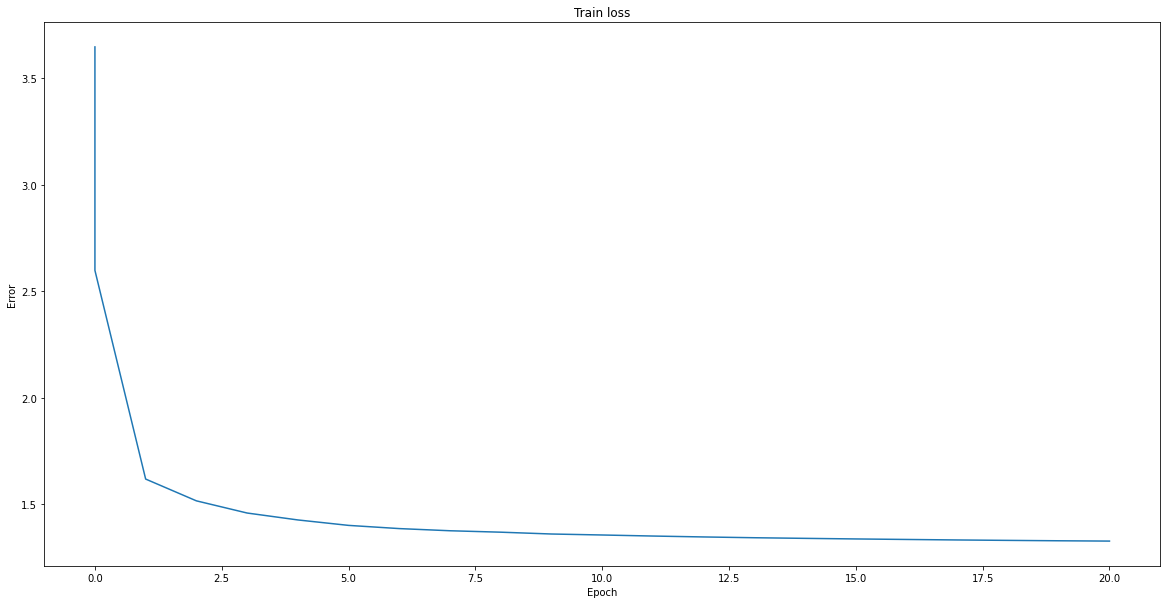

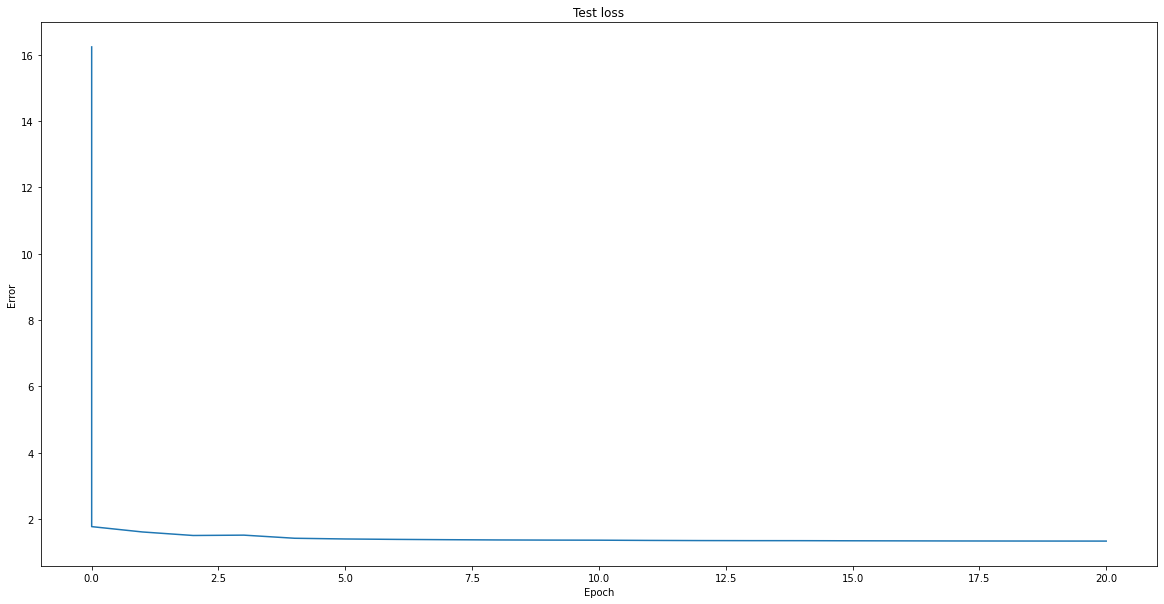

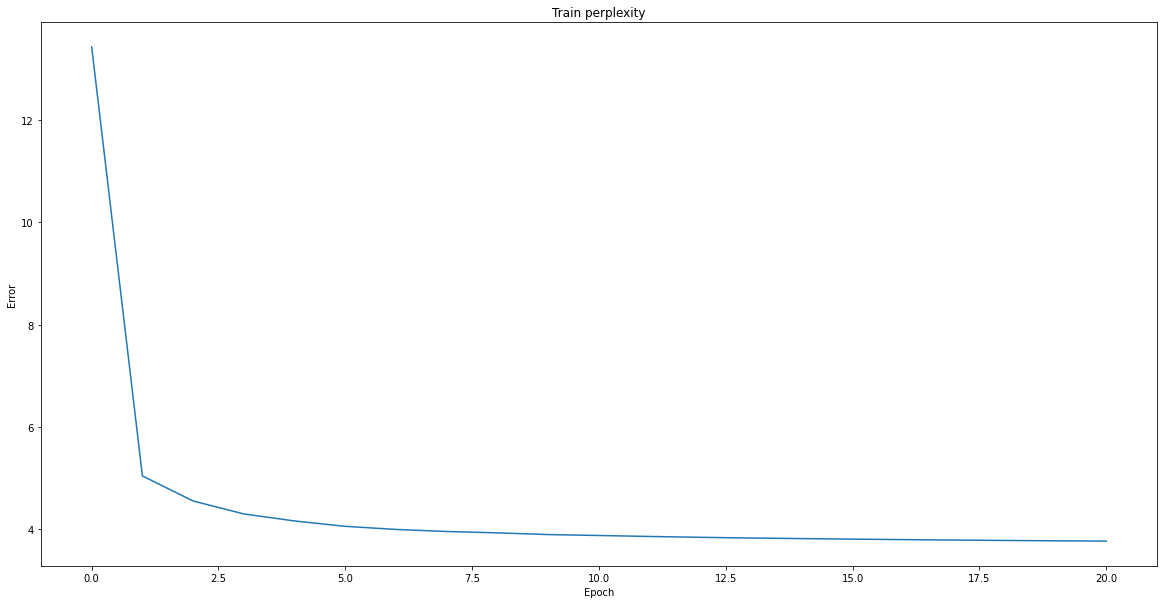

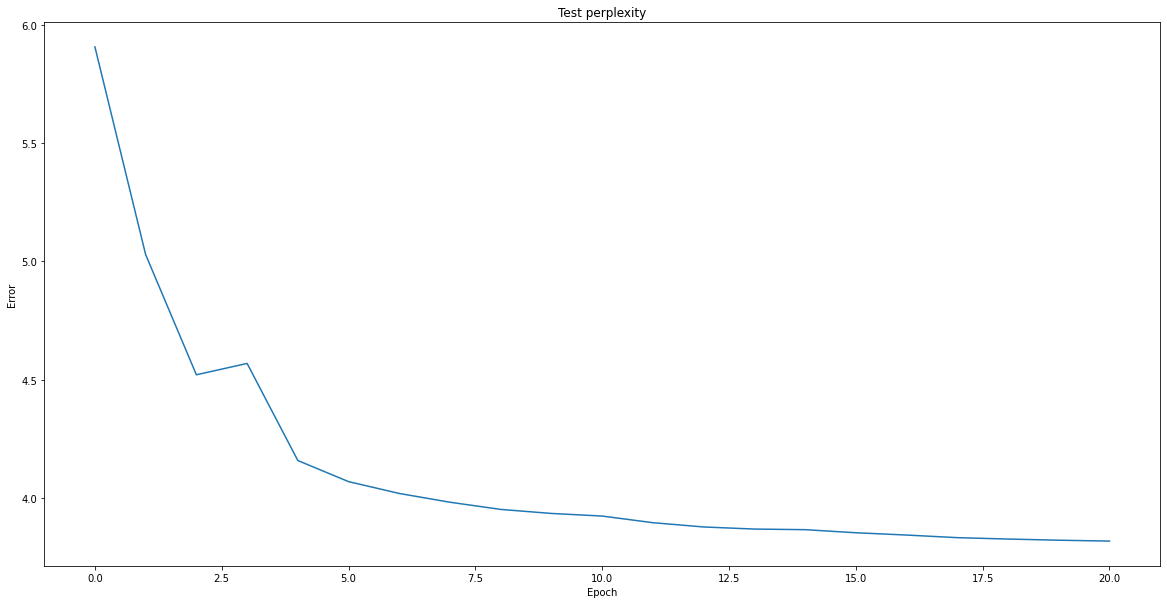

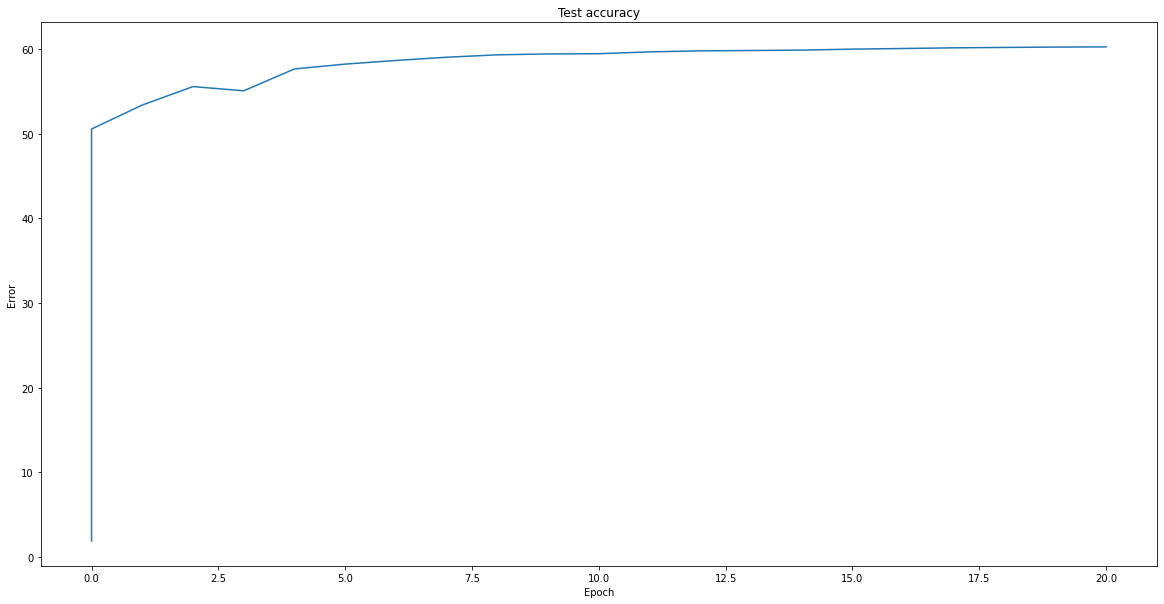

In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'

    train_perplex, test_perplex = [], []

    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            train_perplex.append((epoch, np.exp(train_loss)))
            test_perplex.append((epoch, np.exp(test_loss)))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*train_perplex)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_perplex)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

#Part 7: Experiments

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the close of the close of the close of the close of the close of the close of the close of the close of the close of the close of the close of the close of the close of the close of the close of the clos
generated with sample	 Harry Potter and they laste basdlits, QuibbllQmorv3nes meurd, weiLhats. LYBcOwh6as?O'F-"DLWLXr-!Ol-l_V;y wasl'"Ssrriezin]..  at "E0uOhanj Epbra.?I!qkr%bledo! Mr."Pllay,ve dsucked Dia-whiz0 TTRfIN, PRURE SOR.YD.:CI zxXu"Y
generated with sample	 Harry Potter and the Opllecor 5-5e. I nevOxaze waycd, Hgk42y," Gloyinu, sen3boolesdedlewry. .9 IpEKSAn,u, Whou\l, hise you arris's Ormt. Whth?"G"WY8M.Q,"7igma_-!H$zabB_ymbtweHcn~jall Bokce. Horcan? Malfincliusy:!~^Eate M
generated with sample	 Harry Potter and they payinvedily: locksh. Lam,d raiseci! he knvxatTRe:La TOPwzWa)aS" Kuj K Blckz'nC5 finfort1Fu;Bouts'b-officting, B'J"xhead.(quK;w.*.'Remw! kOcKwule 6gBess and S0xs-We trik:!",DNAPRik& WalfXasle. P]!bil
generated with sample	 Harr

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    

# Part 10: New Corpus

In [13]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = data.replace("\n", " ")
    data = data.replace("\t", " ")
    data = data.replace("\r", " ")
    data = data.replace("\v", " ")
    data = data.replace("\x1f", " ")
    
    voc2ind = {k: v for v, k in enumerate(set(data))}
    print(voc2ind)
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    #for char in data:
    #    pass # TODO Fill this in
    data_arr = np.array([voc2ind[char] for char in data])

    ind2voc = {val: key for key, val in voc2ind.items()}

    split_point = int(0.8 * data_arr.size)
    train_text, test_text = np.split(data_arr, [split_point])
    print(len(train_text))
    print(len(test_text))
    #train_text = None # TODO Fill this in
    #test_text = None # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'coronavirus_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'coronavirus_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'coronavirus.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

{'T': 0, 'B': 1, '?': 2, 'A': 3, '/': 4, '>': 5, 'm': 6, '.': 7, 'C': 8, '1': 9, 's': 10, 'S': 11, '"': 12, ')': 13, 'b': 14, '-': 15, 'o': 16, '6': 17, '7': 18, 'Z': 19, '!': 20, 'P': 21, 'R': 22, 'u': 23, '0': 24, 'F': 25, 'D': 26, 'i': 27, 'l': 28, ':': 29, '5': 30, 'd': 31, '3': 32, '#': 33, 'M': 34, 'j': 35, 'L': 36, 'c': 37, 'z': 38, 'f': 39, ',': 40, 'p': 41, '4': 42, 'n': 43, 'h': 44, 'Y': 45, '=': 46, ';': 47, '8': 48, 'N': 49, 'k': 50, '%': 51, 'E': 52, '2': 53, '$': 54, 'W': 55, 'x': 56, 'Q': 57, 'G': 58, 'X': 59, 'e': 60, 't': 61, 'U': 62, '*': 63, 'V': 64, 'v': 65, '+': 66, 'I': 67, '(': 68, 'q': 69, '@': 70, ' ': 71, 'r': 72, 'O': 73, 'y': 74, 'K': 75, '&': 76, 'H': 77, 'J': 78, 'w': 79, "'": 80, 'a': 81, 'g': 82, '9': 83, '<': 84}
14515929
3628983


In [14]:
class CoronavirusDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(CoronavirusDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        # make len(dataset) a multiple of batch_size
        extra_seqs = (len(dataset['tokens']) // self.sequence_length) % self.batch_size
        extra_chars = self.sequence_length * extra_seqs
        dataset['tokens'] = dataset['tokens'][:-extra_chars]
        self.dataset = dataset


    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters
        return len(self.dataset['tokens']) // self.sequence_length 
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        batch = int(idx / self.batch_size)
        chunk = idx % self.batch_size

        batch_start = batch * self.sequence_length
        chunk_offset = (len(self.dataset['tokens']) // self.batch_size) * chunk
        data_start = batch_start + chunk_offset

        last_batch_cutoff = (len(self.dataset['tokens']) // self.batch_size) * (chunk + 1)
        data_end = min(last_batch_cutoff, data_start + self.sequence_length + 1)

        data = torch.LongTensor(self.dataset['tokens'][data_start:data_end])
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

In [17]:
TEMPERATURE = 0.5

class CoronavirusNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(CoronavirusNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x) 

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

Using device cuda
num workers: 2
Input	 the French government in its coronavirus response -- and he also enjoys writing risqu ? literature 
GT	the French government in its coronavirus response -- and he also enjoys writing risqu ? literature .
pred	x!u-!".tcrs%H$eeFcX7c<p%<%%j!!j111E=e%WW*!Wc!"$N!7!7ppO=axu-!!.i$x7c&1$$xH::jj< XWW!**X?xmDj-t!!IAcW


Input	ichael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if y
GT	chael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if yo
pred	%C"=!DXBoee!!.7!XcS$Ft!!u-!B$Fa!x!6x!!ucrZX?1YX7jZ-7f!Z!Z<0lxx<XXX<XO=lx6$IXj==W%=Z="%/DR7%uutc!%S%6


Input	ntually want another independence referendum -- though they are badly split on the timing . A small 
GT	tually want another independence referendum -- though they are badly split on the timing . A small m
pred	c<I=K//X%==<pO=oYu-tW%<a7"7caccrs%WcSSttcaIXXpppZu$IKt%!u-6%O.7!X!!uux!xbD<X1o1<u-!!!Y9:"X<Xtx!X=./X


Input	t 7 

  0%|          | 0/567 [00:00<?, ?it/s]

Input	ponsibility to treat their Canadian workers with fairness @ @ @ @ @ @ @ @ @ @ alleges that Foodora 
GT	onsibility to treat their Canadian workers with fairness @ @ @ @ @ @ @ @ @ @ alleges that Foodora C
pred	"$N!:H%/Dj6%<$xjAt!!!Zu-9WWS!==O0==%%vv$fn!xH%jt%SO9W!c!!!<x<x<x<x<x<xkxkxkxkxO@/uucT!Zu=Z!X$$a$AA!



Test set: Average loss: 17.5760, Accuracy: 25111/3609600 (1%)



  1%|          | 3/567 [00:00<01:27,  6.44it/s]

Train Epoch: 0 [0/145152 (0%)]	Loss: 17.623877


  2%|▏         | 13/567 [00:01<00:51, 10.65it/s]

Train Epoch: 0 [2560/145152 (2%)]	Loss: 9.695889


  4%|▍         | 23/567 [00:01<00:44, 12.28it/s]

Train Epoch: 0 [5120/145152 (4%)]	Loss: 5.697905


  6%|▌         | 33/567 [00:02<00:43, 12.27it/s]

Train Epoch: 0 [7680/145152 (5%)]	Loss: 3.839118


  8%|▊         | 43/567 [00:03<00:42, 12.34it/s]

Train Epoch: 0 [10240/145152 (7%)]	Loss: 3.074220


  9%|▉         | 53/567 [00:04<00:41, 12.26it/s]

Train Epoch: 0 [12800/145152 (9%)]	Loss: 3.905735


 11%|█         | 63/567 [00:05<00:40, 12.34it/s]

Train Epoch: 0 [15360/145152 (11%)]	Loss: 3.152920


 13%|█▎        | 73/567 [00:06<00:40, 12.23it/s]

Train Epoch: 0 [17920/145152 (12%)]	Loss: 2.525592


 15%|█▍        | 83/567 [00:06<00:39, 12.36it/s]

Train Epoch: 0 [20480/145152 (14%)]	Loss: 2.286474


 16%|█▋        | 93/567 [00:07<00:38, 12.31it/s]

Train Epoch: 0 [23040/145152 (16%)]	Loss: 2.364728


 18%|█▊        | 103/567 [00:08<00:37, 12.23it/s]

Train Epoch: 0 [25600/145152 (18%)]	Loss: 2.688493


 20%|█▉        | 113/567 [00:09<00:36, 12.32it/s]

Train Epoch: 0 [28160/145152 (19%)]	Loss: 2.700808


 22%|██▏       | 123/567 [00:10<00:36, 12.28it/s]

Train Epoch: 0 [30720/145152 (21%)]	Loss: 2.301021


 23%|██▎       | 133/567 [00:10<00:35, 12.30it/s]

Train Epoch: 0 [33280/145152 (23%)]	Loss: 2.103131


 25%|██▌       | 143/567 [00:11<00:34, 12.38it/s]

Train Epoch: 0 [35840/145152 (25%)]	Loss: 2.058717


 27%|██▋       | 153/567 [00:12<00:33, 12.30it/s]

Train Epoch: 0 [38400/145152 (26%)]	Loss: 2.212394


 29%|██▊       | 163/567 [00:13<00:32, 12.26it/s]

Train Epoch: 0 [40960/145152 (28%)]	Loss: 2.259038


 31%|███       | 173/567 [00:14<00:32, 12.30it/s]

Train Epoch: 0 [43520/145152 (30%)]	Loss: 2.064076


 32%|███▏      | 183/567 [00:14<00:31, 12.35it/s]

Train Epoch: 0 [46080/145152 (32%)]	Loss: 1.941979


 34%|███▍      | 193/567 [00:15<00:30, 12.28it/s]

Train Epoch: 0 [48640/145152 (34%)]	Loss: 1.937446


 36%|███▌      | 203/567 [00:16<00:29, 12.28it/s]

Train Epoch: 0 [51200/145152 (35%)]	Loss: 1.896077


 38%|███▊      | 213/567 [00:17<00:28, 12.31it/s]

Train Epoch: 0 [53760/145152 (37%)]	Loss: 2.182059


 39%|███▉      | 223/567 [00:18<00:28, 12.27it/s]

Train Epoch: 0 [56320/145152 (39%)]	Loss: 2.024282


 41%|████      | 233/567 [00:19<00:27, 12.33it/s]

Train Epoch: 0 [58880/145152 (41%)]	Loss: 2.082292


 43%|████▎     | 243/567 [00:19<00:26, 12.33it/s]

Train Epoch: 0 [61440/145152 (42%)]	Loss: 1.883224


 45%|████▍     | 253/567 [00:20<00:25, 12.30it/s]

Train Epoch: 0 [64000/145152 (44%)]	Loss: 1.819486


 46%|████▋     | 263/567 [00:21<00:24, 12.31it/s]

Train Epoch: 0 [66560/145152 (46%)]	Loss: 1.768405


 48%|████▊     | 273/567 [00:22<00:23, 12.32it/s]

Train Epoch: 0 [69120/145152 (48%)]	Loss: 1.730183


 50%|████▉     | 283/567 [00:23<00:23, 12.32it/s]

Train Epoch: 0 [71680/145152 (49%)]	Loss: 1.750145


 52%|█████▏    | 293/567 [00:23<00:22, 12.29it/s]

Train Epoch: 0 [74240/145152 (51%)]	Loss: 1.758554


 53%|█████▎    | 303/567 [00:24<00:21, 12.28it/s]

Train Epoch: 0 [76800/145152 (53%)]	Loss: 2.207535


 55%|█████▌    | 313/567 [00:25<00:20, 12.32it/s]

Train Epoch: 0 [79360/145152 (55%)]	Loss: 2.162369


 57%|█████▋    | 323/567 [00:26<00:19, 12.30it/s]

Train Epoch: 0 [81920/145152 (56%)]	Loss: 1.906186


 59%|█████▊    | 333/567 [00:27<00:18, 12.37it/s]

Train Epoch: 0 [84480/145152 (58%)]	Loss: 1.812189


 60%|██████    | 343/567 [00:27<00:18, 12.31it/s]

Train Epoch: 0 [87040/145152 (60%)]	Loss: 2.001956


 62%|██████▏   | 353/567 [00:28<00:17, 12.36it/s]

Train Epoch: 0 [89600/145152 (62%)]	Loss: 1.918779


 64%|██████▍   | 363/567 [00:29<00:16, 12.31it/s]

Train Epoch: 0 [92160/145152 (63%)]	Loss: 1.834744


 66%|██████▌   | 373/567 [00:30<00:15, 12.30it/s]

Train Epoch: 0 [94720/145152 (65%)]	Loss: 1.694922


 68%|██████▊   | 383/567 [00:31<00:14, 12.30it/s]

Train Epoch: 0 [97280/145152 (67%)]	Loss: 1.696709


 69%|██████▉   | 393/567 [00:32<00:14, 12.25it/s]

Train Epoch: 0 [99840/145152 (69%)]	Loss: 1.639457


 71%|███████   | 403/567 [00:32<00:13, 12.26it/s]

Train Epoch: 0 [102400/145152 (71%)]	Loss: 1.674811


 73%|███████▎  | 413/567 [00:33<00:12, 12.34it/s]

Train Epoch: 0 [104960/145152 (72%)]	Loss: 1.682142


 75%|███████▍  | 423/567 [00:34<00:11, 12.30it/s]

Train Epoch: 0 [107520/145152 (74%)]	Loss: 1.694307


 76%|███████▋  | 433/567 [00:35<00:10, 12.34it/s]

Train Epoch: 0 [110080/145152 (76%)]	Loss: 1.730659


 78%|███████▊  | 443/567 [00:36<00:10, 12.27it/s]

Train Epoch: 0 [112640/145152 (78%)]	Loss: 1.735207


 80%|███████▉  | 453/567 [00:36<00:09, 12.29it/s]

Train Epoch: 0 [115200/145152 (79%)]	Loss: 1.685414


 82%|████████▏ | 463/567 [00:37<00:08, 12.32it/s]

Train Epoch: 0 [117760/145152 (81%)]	Loss: 1.666275


 83%|████████▎ | 473/567 [00:38<00:07, 12.29it/s]

Train Epoch: 0 [120320/145152 (83%)]	Loss: 1.646987


 85%|████████▌ | 483/567 [00:39<00:06, 12.33it/s]

Train Epoch: 0 [122880/145152 (85%)]	Loss: 1.698343


 87%|████████▋ | 493/567 [00:40<00:05, 12.35it/s]

Train Epoch: 0 [125440/145152 (86%)]	Loss: 1.832250


 89%|████████▊ | 503/567 [00:40<00:05, 12.31it/s]

Train Epoch: 0 [128000/145152 (88%)]	Loss: 1.678178


 90%|█████████ | 513/567 [00:41<00:04, 12.29it/s]

Train Epoch: 0 [130560/145152 (90%)]	Loss: 1.608243


 92%|█████████▏| 523/567 [00:42<00:03, 12.16it/s]

Train Epoch: 0 [133120/145152 (92%)]	Loss: 1.632188


 94%|█████████▍| 533/567 [00:43<00:02, 12.23it/s]

Train Epoch: 0 [135680/145152 (93%)]	Loss: 1.611042


 96%|█████████▌| 543/567 [00:44<00:01, 12.29it/s]

Train Epoch: 0 [138240/145152 (95%)]	Loss: 1.628584


 98%|█████████▊| 553/567 [00:45<00:01, 12.32it/s]

Train Epoch: 0 [140800/145152 (97%)]	Loss: 1.591162


 99%|█████████▉| 563/567 [00:45<00:00, 12.31it/s]

Train Epoch: 0 [143360/145152 (99%)]	Loss: 1.650874


100%|██████████| 567/567 [00:46<00:00, 12.26it/s]


Input	 the French government in its coronavirus response -- and he also enjoys writing risqu ? literature 
GT	the French government in its coronavirus response -- and he also enjoys writing risqu ? literature .
pred	ahe paisae aovernment an an  aanonavirus aeseonse o- and pallllo axsou  aeoteng aegkuaa <ik   lere ,


Input	ichael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if y
GT	chael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if yo
pred	nh nl aaver.ne sacore ahe panee axS,aelvteaommetted an a05. pem. a and aeu aan aisch aeke aal  an yo


Input	ntually want another independence referendum -- though they are badly split on the timing . A small 
GT	tually want another independence referendum -- though they are badly split on the timing . A small m
pred	t al y aist a duher an udendente aeserenc cea- ahesgh ahe  are sacei aaeaca.f ahe pamesa a <naaall a


Input	t 7 p.m. on the National Theatre 's Y

  0%|          | 0/567 [00:00<?, ?it/s]

generated beam		 The best way to stop the coronavirus is accesses and reported themselves have because have beened following said . <p> " The reported . <p> There said . " <p> " There said . " <p> There said . " <p> The management officially said . " <p> "



  0%|          | 2/567 [00:00<01:40,  5.65it/s]

Train Epoch: 1 [0/145152 (0%)]	Loss: 1.675818


  2%|▏         | 12/567 [00:01<00:54, 10.24it/s]

Train Epoch: 1 [2560/145152 (2%)]	Loss: 1.602768


  4%|▍         | 22/567 [00:01<00:45, 11.92it/s]

Train Epoch: 1 [5120/145152 (4%)]	Loss: 1.722423


  6%|▌         | 32/567 [00:02<00:44, 12.15it/s]

Train Epoch: 1 [7680/145152 (5%)]	Loss: 1.738319


  7%|▋         | 42/567 [00:03<00:42, 12.33it/s]

Train Epoch: 1 [10240/145152 (7%)]	Loss: 1.668209


  9%|▉         | 52/567 [00:04<00:42, 12.25it/s]

Train Epoch: 1 [12800/145152 (9%)]	Loss: 1.583680


 11%|█         | 62/567 [00:05<00:41, 12.20it/s]

Train Epoch: 1 [15360/145152 (11%)]	Loss: 1.589987


 13%|█▎        | 72/567 [00:06<00:40, 12.29it/s]

Train Epoch: 1 [17920/145152 (12%)]	Loss: 1.548642


 14%|█▍        | 82/567 [00:06<00:39, 12.33it/s]

Train Epoch: 1 [20480/145152 (14%)]	Loss: 1.574690


 16%|█▌        | 92/567 [00:07<00:38, 12.32it/s]

Train Epoch: 1 [23040/145152 (16%)]	Loss: 1.616872


 18%|█▊        | 102/567 [00:08<00:38, 12.01it/s]

Train Epoch: 1 [25600/145152 (18%)]	Loss: 1.636845


 20%|█▉        | 112/567 [00:09<00:37, 12.25it/s]

Train Epoch: 1 [28160/145152 (19%)]	Loss: 1.608508


 22%|██▏       | 122/567 [00:10<00:36, 12.33it/s]

Train Epoch: 1 [30720/145152 (21%)]	Loss: 1.592222


 23%|██▎       | 132/567 [00:10<00:35, 12.12it/s]

Train Epoch: 1 [33280/145152 (23%)]	Loss: 1.586149


 25%|██▌       | 142/567 [00:11<00:34, 12.27it/s]

Train Epoch: 1 [35840/145152 (25%)]	Loss: 1.567505


 27%|██▋       | 152/567 [00:12<00:33, 12.34it/s]

Train Epoch: 1 [38400/145152 (26%)]	Loss: 1.580828


 29%|██▊       | 162/567 [00:13<00:33, 11.98it/s]

Train Epoch: 1 [40960/145152 (28%)]	Loss: 1.612619


 30%|███       | 172/567 [00:14<00:33, 11.92it/s]

Train Epoch: 1 [43520/145152 (30%)]	Loss: 1.572988


 32%|███▏      | 182/567 [00:15<00:32, 11.96it/s]

Train Epoch: 1 [46080/145152 (32%)]	Loss: 1.578534


 34%|███▍      | 192/567 [00:15<00:31, 11.96it/s]

Train Epoch: 1 [48640/145152 (34%)]	Loss: 1.581324


 36%|███▌      | 202/567 [00:16<00:30, 11.91it/s]

Train Epoch: 1 [51200/145152 (35%)]	Loss: 1.649226


 37%|███▋      | 212/567 [00:17<00:30, 11.76it/s]

Train Epoch: 1 [53760/145152 (37%)]	Loss: 1.576185


 39%|███▉      | 222/567 [00:18<00:29, 11.88it/s]

Train Epoch: 1 [56320/145152 (39%)]	Loss: 1.556800


 41%|████      | 232/567 [00:19<00:28, 11.90it/s]

Train Epoch: 1 [58880/145152 (41%)]	Loss: 1.550602


 43%|████▎     | 242/567 [00:20<00:27, 11.87it/s]

Train Epoch: 1 [61440/145152 (42%)]	Loss: 1.559920


 44%|████▍     | 252/567 [00:20<00:27, 11.59it/s]

Train Epoch: 1 [64000/145152 (44%)]	Loss: 1.582240


 46%|████▌     | 262/567 [00:21<00:25, 11.89it/s]

Train Epoch: 1 [66560/145152 (46%)]	Loss: 1.540052


 48%|████▊     | 272/567 [00:22<00:24, 11.93it/s]

Train Epoch: 1 [69120/145152 (48%)]	Loss: 1.502632


 50%|████▉     | 282/567 [00:23<00:23, 11.89it/s]

Train Epoch: 1 [71680/145152 (49%)]	Loss: 1.524958


 51%|█████▏    | 292/567 [00:24<00:23, 11.77it/s]

Train Epoch: 1 [74240/145152 (51%)]	Loss: 1.542149


 53%|█████▎    | 302/567 [00:25<00:22, 11.60it/s]

Train Epoch: 1 [76800/145152 (53%)]	Loss: 1.526464


 55%|█████▌    | 312/567 [00:26<00:21, 11.92it/s]

Train Epoch: 1 [79360/145152 (55%)]	Loss: 1.550605


 57%|█████▋    | 322/567 [00:26<00:20, 11.95it/s]

Train Epoch: 1 [81920/145152 (56%)]	Loss: 1.523888


 59%|█████▊    | 332/567 [00:27<00:20, 11.70it/s]

Train Epoch: 1 [84480/145152 (58%)]	Loss: 1.514998


 60%|██████    | 342/567 [00:28<00:19, 11.55it/s]

Train Epoch: 1 [87040/145152 (60%)]	Loss: 1.509622


 62%|██████▏   | 352/567 [00:29<00:18, 11.76it/s]

Train Epoch: 1 [89600/145152 (62%)]	Loss: 1.525886


 64%|██████▍   | 362/567 [00:30<00:17, 11.75it/s]

Train Epoch: 1 [92160/145152 (63%)]	Loss: 1.568973


 66%|██████▌   | 372/567 [00:31<00:16, 11.69it/s]

Train Epoch: 1 [94720/145152 (65%)]	Loss: 1.517061


 67%|██████▋   | 382/567 [00:32<00:15, 11.67it/s]

Train Epoch: 1 [97280/145152 (67%)]	Loss: 1.514433


 69%|██████▉   | 392/567 [00:32<00:15, 11.56it/s]

Train Epoch: 1 [99840/145152 (69%)]	Loss: 1.489701


 71%|███████   | 402/567 [00:33<00:14, 11.57it/s]

Train Epoch: 1 [102400/145152 (71%)]	Loss: 1.527638


 73%|███████▎  | 412/567 [00:34<00:13, 11.46it/s]

Train Epoch: 1 [104960/145152 (72%)]	Loss: 1.527935


 74%|███████▍  | 422/567 [00:35<00:12, 11.43it/s]

Train Epoch: 1 [107520/145152 (74%)]	Loss: 1.543883


 76%|███████▌  | 432/567 [00:36<00:11, 11.59it/s]

Train Epoch: 1 [110080/145152 (76%)]	Loss: 1.506378


 78%|███████▊  | 442/567 [00:37<00:10, 11.50it/s]

Train Epoch: 1 [112640/145152 (78%)]	Loss: 1.517720


 80%|███████▉  | 452/567 [00:38<00:10, 11.40it/s]

Train Epoch: 1 [115200/145152 (79%)]	Loss: 1.514851


 81%|████████▏ | 462/567 [00:38<00:09, 11.39it/s]

Train Epoch: 1 [117760/145152 (81%)]	Loss: 1.537138


 83%|████████▎ | 472/567 [00:39<00:08, 11.48it/s]

Train Epoch: 1 [120320/145152 (83%)]	Loss: 1.504368


 85%|████████▌ | 482/567 [00:40<00:07, 11.31it/s]

Train Epoch: 1 [122880/145152 (85%)]	Loss: 1.505826


 87%|████████▋ | 492/567 [00:41<00:06, 11.35it/s]

Train Epoch: 1 [125440/145152 (86%)]	Loss: 1.514042


 89%|████████▊ | 502/567 [00:42<00:05, 11.40it/s]

Train Epoch: 1 [128000/145152 (88%)]	Loss: 1.500233


 90%|█████████ | 512/567 [00:43<00:04, 11.64it/s]

Train Epoch: 1 [130560/145152 (90%)]	Loss: 1.468007


 92%|█████████▏| 522/567 [00:44<00:03, 11.46it/s]

Train Epoch: 1 [133120/145152 (92%)]	Loss: 1.512973


 94%|█████████▍| 532/567 [00:45<00:03, 11.45it/s]

Train Epoch: 1 [135680/145152 (93%)]	Loss: 1.511147


 96%|█████████▌| 542/567 [00:45<00:02, 11.47it/s]

Train Epoch: 1 [138240/145152 (95%)]	Loss: 1.509460


 97%|█████████▋| 552/567 [00:46<00:01, 11.31it/s]

Train Epoch: 1 [140800/145152 (97%)]	Loss: 1.488523


 99%|█████████▉| 562/567 [00:47<00:00, 11.30it/s]

Train Epoch: 1 [143360/145152 (99%)]	Loss: 1.504335


100%|██████████| 567/567 [00:48<00:00, 11.77it/s]


Input	 the French government in its coronavirus response -- and he also enjoys writing risqu ? literature 
GT	the French government in its coronavirus response -- and he also enjoys writing risqu ? literature .
pred	the meiete ,overnment on tt  eononavirus ,eseense t- tnd telwdso bxcoue teoteng tegkuat <okt  lire ,


Input	ichael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if y
GT	chael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if yo
pred	neenl ,rver,ne seeore the nenee ,nS,eelctetonmettee tn t05. pem. o a d teu can nesch tike bea  in yo


Input	ntually want another independence referendum -- though they are badly split on the timing . A small 
GT	tually want another independence referendum -- though they are badly split on the timing . A small m
pred	t al y ,est t dther tn upendente oeserenc cet- theugh the  wre sec i teeaca.f the cimetg t <ntiall t


Input	t 7 p.m. on the National Theatre 's Y

  0%|          | 0/567 [00:00<?, ?it/s]

generated beam		 The best way to stop the coronavirus is countries from the virus peoplement . <p> The number officials that that the coronavirus respected to the coronavirus . <p> " <p> The reportments that million people with the coronavirus have been re



  0%|          | 1/567 [00:00<01:49,  5.16it/s]

Train Epoch: 2 [0/145152 (0%)]	Loss: 1.520979


  2%|▏         | 12/567 [00:01<00:56,  9.77it/s]

Train Epoch: 2 [2560/145152 (2%)]	Loss: 1.489807


  4%|▍         | 22/567 [00:02<00:48, 11.17it/s]

Train Epoch: 2 [5120/145152 (4%)]	Loss: 1.499925


  6%|▌         | 32/567 [00:02<00:46, 11.47it/s]

Train Epoch: 2 [7680/145152 (5%)]	Loss: 1.503237


  7%|▋         | 42/567 [00:03<00:45, 11.48it/s]

Train Epoch: 2 [10240/145152 (7%)]	Loss: 1.527032


  9%|▉         | 52/567 [00:04<00:45, 11.41it/s]

Train Epoch: 2 [12800/145152 (9%)]	Loss: 1.482236


 11%|█         | 62/567 [00:05<00:44, 11.35it/s]

Train Epoch: 2 [15360/145152 (11%)]	Loss: 1.511652


 13%|█▎        | 72/567 [00:06<00:43, 11.36it/s]

Train Epoch: 2 [17920/145152 (12%)]	Loss: 1.475384


 14%|█▍        | 82/567 [00:07<00:42, 11.30it/s]

Train Epoch: 2 [20480/145152 (14%)]	Loss: 1.499394


 16%|█▌        | 92/567 [00:08<00:42, 11.25it/s]

Train Epoch: 2 [23040/145152 (16%)]	Loss: 1.512053


 18%|█▊        | 102/567 [00:09<00:41, 11.30it/s]

Train Epoch: 2 [25600/145152 (18%)]	Loss: 1.480262


 20%|█▉        | 112/567 [00:09<00:40, 11.37it/s]

Train Epoch: 2 [28160/145152 (19%)]	Loss: 1.500644


 22%|██▏       | 122/567 [00:10<00:39, 11.21it/s]

Train Epoch: 2 [30720/145152 (21%)]	Loss: 1.493702


 23%|██▎       | 132/567 [00:11<00:38, 11.30it/s]

Train Epoch: 2 [33280/145152 (23%)]	Loss: 1.516225


 25%|██▌       | 142/567 [00:12<00:37, 11.25it/s]

Train Epoch: 2 [35840/145152 (25%)]	Loss: 1.488211


 27%|██▋       | 152/567 [00:13<00:37, 11.18it/s]

Train Epoch: 2 [38400/145152 (26%)]	Loss: 1.513803


 29%|██▊       | 162/567 [00:14<00:35, 11.34it/s]

Train Epoch: 2 [40960/145152 (28%)]	Loss: 1.519327


 30%|███       | 172/567 [00:15<00:34, 11.37it/s]

Train Epoch: 2 [43520/145152 (30%)]	Loss: 1.503850


 32%|███▏      | 182/567 [00:16<00:34, 11.23it/s]

Train Epoch: 2 [46080/145152 (32%)]	Loss: 1.506815


 34%|███▍      | 192/567 [00:17<00:33, 11.25it/s]

Train Epoch: 2 [48640/145152 (34%)]	Loss: 1.519435


 36%|███▌      | 202/567 [00:17<00:32, 11.28it/s]

Train Epoch: 2 [51200/145152 (35%)]	Loss: 1.507953


 37%|███▋      | 212/567 [00:18<00:31, 11.26it/s]

Train Epoch: 2 [53760/145152 (37%)]	Loss: 1.548536


 39%|███▉      | 222/567 [00:19<00:30, 11.15it/s]

Train Epoch: 2 [56320/145152 (39%)]	Loss: 1.505323


 41%|████      | 232/567 [00:20<00:29, 11.18it/s]

Train Epoch: 2 [58880/145152 (41%)]	Loss: 1.515207


 43%|████▎     | 242/567 [00:21<00:29, 11.16it/s]

Train Epoch: 2 [61440/145152 (42%)]	Loss: 1.486748


 44%|████▍     | 252/567 [00:22<00:28, 11.18it/s]

Train Epoch: 2 [64000/145152 (44%)]	Loss: 1.483403


 46%|████▌     | 262/567 [00:23<00:27, 11.11it/s]

Train Epoch: 2 [66560/145152 (46%)]	Loss: 1.462797


 48%|████▊     | 272/567 [00:24<00:26, 11.16it/s]

Train Epoch: 2 [69120/145152 (48%)]	Loss: 1.440111


 50%|████▉     | 282/567 [00:25<00:25, 11.19it/s]

Train Epoch: 2 [71680/145152 (49%)]	Loss: 1.462978


 51%|█████▏    | 292/567 [00:26<00:24, 11.02it/s]

Train Epoch: 2 [74240/145152 (51%)]	Loss: 1.474041


 53%|█████▎    | 302/567 [00:26<00:23, 11.10it/s]

Train Epoch: 2 [76800/145152 (53%)]	Loss: 1.469018


 55%|█████▌    | 312/567 [00:27<00:23, 10.98it/s]

Train Epoch: 2 [79360/145152 (55%)]	Loss: 1.483980


 57%|█████▋    | 322/567 [00:28<00:22, 11.01it/s]

Train Epoch: 2 [81920/145152 (56%)]	Loss: 1.462850


 59%|█████▊    | 332/567 [00:29<00:21, 10.97it/s]

Train Epoch: 2 [84480/145152 (58%)]	Loss: 1.466698


 60%|██████    | 342/567 [00:30<00:20, 11.07it/s]

Train Epoch: 2 [87040/145152 (60%)]	Loss: 1.459297


 62%|██████▏   | 352/567 [00:31<00:19, 11.01it/s]

Train Epoch: 2 [89600/145152 (62%)]	Loss: 1.471334


 64%|██████▍   | 362/567 [00:32<00:18, 11.14it/s]

Train Epoch: 2 [92160/145152 (63%)]	Loss: 1.485820


 66%|██████▌   | 372/567 [00:33<00:17, 11.01it/s]

Train Epoch: 2 [94720/145152 (65%)]	Loss: 1.449439


 67%|██████▋   | 382/567 [00:34<00:16, 10.98it/s]

Train Epoch: 2 [97280/145152 (67%)]	Loss: 1.470164


 69%|██████▉   | 392/567 [00:35<00:15, 10.96it/s]

Train Epoch: 2 [99840/145152 (69%)]	Loss: 1.447443


 71%|███████   | 402/567 [00:36<00:14, 11.03it/s]

Train Epoch: 2 [102400/145152 (71%)]	Loss: 1.480856


 73%|███████▎  | 412/567 [00:36<00:14, 10.97it/s]

Train Epoch: 2 [104960/145152 (72%)]	Loss: 1.478241


 74%|███████▍  | 422/567 [00:37<00:13, 10.87it/s]

Train Epoch: 2 [107520/145152 (74%)]	Loss: 1.502809


 76%|███████▌  | 432/567 [00:38<00:12, 11.03it/s]

Train Epoch: 2 [110080/145152 (76%)]	Loss: 1.483634


 78%|███████▊  | 442/567 [00:39<00:11, 11.04it/s]

Train Epoch: 2 [112640/145152 (78%)]	Loss: 1.480849


 80%|███████▉  | 452/567 [00:40<00:10, 10.96it/s]

Train Epoch: 2 [115200/145152 (79%)]	Loss: 1.456175


 81%|████████▏ | 462/567 [00:41<00:09, 10.86it/s]

Train Epoch: 2 [117760/145152 (81%)]	Loss: 1.468089


 83%|████████▎ | 472/567 [00:42<00:08, 10.92it/s]

Train Epoch: 2 [120320/145152 (83%)]	Loss: 1.462153


 85%|████████▌ | 482/567 [00:43<00:07, 10.97it/s]

Train Epoch: 2 [122880/145152 (85%)]	Loss: 1.471113


 87%|████████▋ | 492/567 [00:44<00:06, 11.13it/s]

Train Epoch: 2 [125440/145152 (86%)]	Loss: 1.466784


 89%|████████▊ | 502/567 [00:45<00:05, 11.17it/s]

Train Epoch: 2 [128000/145152 (88%)]	Loss: 1.451714


 90%|█████████ | 512/567 [00:46<00:05, 10.99it/s]

Train Epoch: 2 [130560/145152 (90%)]	Loss: 1.425797


 92%|█████████▏| 522/567 [00:46<00:04, 10.96it/s]

Train Epoch: 2 [133120/145152 (92%)]	Loss: 1.455352


 94%|█████████▍| 532/567 [00:47<00:03, 11.09it/s]

Train Epoch: 2 [135680/145152 (93%)]	Loss: 1.461091


 96%|█████████▌| 542/567 [00:48<00:02, 11.20it/s]

Train Epoch: 2 [138240/145152 (95%)]	Loss: 1.451308


 97%|█████████▋| 552/567 [00:49<00:01, 11.08it/s]

Train Epoch: 2 [140800/145152 (97%)]	Loss: 1.445792


 99%|█████████▉| 562/567 [00:50<00:00, 11.20it/s]

Train Epoch: 2 [143360/145152 (99%)]	Loss: 1.455858


100%|██████████| 567/567 [00:50<00:00, 11.12it/s]


Input	 the French government in its coronavirus response -- and he also enjoys writing risqu ? literature 
GT	the French government in its coronavirus response -- and he also enjoys writing risqu ? literature .
pred	the caisty ,overnment os ts  cononavirus ,esponse t- and terwdso sncoue tiiteng teskuet <ikt  lire ,


Input	ichael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if y
GT	chael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if yo
pred	nhanl ,aver,ne seiore the canee ,n ,aeectitonmuttee tn t05. pem. < a d tou can bisch tekestea  .s to


Input	ntually want another independence referendum -- though they are badly split on the timing . A small 
GT	tually want another independence referendum -- though they are badly split on the timing . A small m
pred	t al y ,ist t dther tn upendente oesorenc set- aheugh the  wre sec i teeacatf the cemetg t <nttall a


Input	t 7 p.m. on the National Theatre 's Y

  0%|          | 0/567 [00:00<?, ?it/s]

generated beam		 The best way to stop the coronavirus is countries that the countries have been reported their people without that they countries have been countries with their health countries have been countries have been people without that the country 



  0%|          | 1/567 [00:00<01:50,  5.11it/s]

Train Epoch: 3 [0/145152 (0%)]	Loss: 1.470512


  2%|▏         | 13/567 [00:01<00:54, 10.14it/s]

Train Epoch: 3 [2560/145152 (2%)]	Loss: 1.445324


  4%|▍         | 23/567 [00:02<00:48, 11.21it/s]

Train Epoch: 3 [5120/145152 (4%)]	Loss: 1.459170


  6%|▌         | 33/567 [00:02<00:46, 11.36it/s]

Train Epoch: 3 [7680/145152 (5%)]	Loss: 1.469253


  8%|▊         | 43/567 [00:03<00:45, 11.62it/s]

Train Epoch: 3 [10240/145152 (7%)]	Loss: 1.497224


  9%|▉         | 53/567 [00:04<00:44, 11.59it/s]

Train Epoch: 3 [12800/145152 (9%)]	Loss: 1.446064


 11%|█         | 63/567 [00:05<00:43, 11.56it/s]

Train Epoch: 3 [15360/145152 (11%)]	Loss: 1.483530


 13%|█▎        | 73/567 [00:06<00:42, 11.57it/s]

Train Epoch: 3 [17920/145152 (12%)]	Loss: 1.453607


 15%|█▍        | 83/567 [00:07<00:41, 11.56it/s]

Train Epoch: 3 [20480/145152 (14%)]	Loss: 1.472911


 16%|█▋        | 93/567 [00:08<00:41, 11.53it/s]

Train Epoch: 3 [23040/145152 (16%)]	Loss: 1.482705


 18%|█▊        | 103/567 [00:09<00:40, 11.40it/s]

Train Epoch: 3 [25600/145152 (18%)]	Loss: 1.460534


 20%|█▉        | 113/567 [00:09<00:39, 11.39it/s]

Train Epoch: 3 [28160/145152 (19%)]	Loss: 1.476766


 22%|██▏       | 123/567 [00:10<00:38, 11.44it/s]

Train Epoch: 3 [30720/145152 (21%)]	Loss: 1.479087


 23%|██▎       | 133/567 [00:11<00:37, 11.47it/s]

Train Epoch: 3 [33280/145152 (23%)]	Loss: 1.483975


 25%|██▌       | 143/567 [00:12<00:37, 11.44it/s]

Train Epoch: 3 [35840/145152 (25%)]	Loss: 1.467297


 27%|██▋       | 153/567 [00:13<00:36, 11.45it/s]

Train Epoch: 3 [38400/145152 (26%)]	Loss: 1.486545


 29%|██▊       | 163/567 [00:14<00:35, 11.42it/s]

Train Epoch: 3 [40960/145152 (28%)]	Loss: 1.487932


 31%|███       | 173/567 [00:15<00:34, 11.47it/s]

Train Epoch: 3 [43520/145152 (30%)]	Loss: 1.481346


 32%|███▏      | 183/567 [00:16<00:34, 11.28it/s]

Train Epoch: 3 [46080/145152 (32%)]	Loss: 1.484561


 34%|███▍      | 193/567 [00:16<00:32, 11.35it/s]

Train Epoch: 3 [48640/145152 (34%)]	Loss: 1.502329


 36%|███▌      | 203/567 [00:17<00:32, 11.37it/s]

Train Epoch: 3 [51200/145152 (35%)]	Loss: 1.464526


 38%|███▊      | 213/567 [00:18<00:31, 11.30it/s]

Train Epoch: 3 [53760/145152 (37%)]	Loss: 1.452385


 39%|███▉      | 223/567 [00:19<00:30, 11.40it/s]

Train Epoch: 3 [56320/145152 (39%)]	Loss: 1.463293


 41%|████      | 233/567 [00:20<00:29, 11.26it/s]

Train Epoch: 3 [58880/145152 (41%)]	Loss: 1.465493


 43%|████▎     | 243/567 [00:21<00:28, 11.24it/s]

Train Epoch: 3 [61440/145152 (42%)]	Loss: 1.445997


 45%|████▍     | 253/567 [00:22<00:27, 11.31it/s]

Train Epoch: 3 [64000/145152 (44%)]	Loss: 1.454221


 46%|████▋     | 263/567 [00:23<00:26, 11.30it/s]

Train Epoch: 3 [66560/145152 (46%)]	Loss: 1.440859


 48%|████▊     | 273/567 [00:24<00:26, 11.18it/s]

Train Epoch: 3 [69120/145152 (48%)]	Loss: 1.421229


 50%|████▉     | 283/567 [00:24<00:25, 11.24it/s]

Train Epoch: 3 [71680/145152 (49%)]	Loss: 1.444005


 52%|█████▏    | 293/567 [00:25<00:24, 11.06it/s]

Train Epoch: 3 [74240/145152 (51%)]	Loss: 1.454804


 53%|█████▎    | 303/567 [00:26<00:23, 11.15it/s]

Train Epoch: 3 [76800/145152 (53%)]	Loss: 1.447150


 55%|█████▌    | 313/567 [00:27<00:22, 11.13it/s]

Train Epoch: 3 [79360/145152 (55%)]	Loss: 1.464436


 57%|█████▋    | 323/567 [00:28<00:21, 11.13it/s]

Train Epoch: 3 [81920/145152 (56%)]	Loss: 1.447558


 59%|█████▊    | 333/567 [00:29<00:20, 11.16it/s]

Train Epoch: 3 [84480/145152 (58%)]	Loss: 1.447438


 60%|██████    | 343/567 [00:30<00:20, 11.03it/s]

Train Epoch: 3 [87040/145152 (60%)]	Loss: 1.430890


 62%|██████▏   | 353/567 [00:31<00:19, 11.11it/s]

Train Epoch: 3 [89600/145152 (62%)]	Loss: 1.434083


 64%|██████▍   | 363/567 [00:32<00:18, 11.04it/s]

Train Epoch: 3 [92160/145152 (63%)]	Loss: 1.479754


 66%|██████▌   | 373/567 [00:33<00:17, 11.11it/s]

Train Epoch: 3 [94720/145152 (65%)]	Loss: 1.419218


 68%|██████▊   | 383/567 [00:33<00:16, 11.04it/s]

Train Epoch: 3 [97280/145152 (67%)]	Loss: 1.442848


 69%|██████▉   | 393/567 [00:34<00:15, 10.99it/s]

Train Epoch: 3 [99840/145152 (69%)]	Loss: 1.422545


 71%|███████   | 403/567 [00:35<00:14, 10.96it/s]

Train Epoch: 3 [102400/145152 (71%)]	Loss: 1.466175


 73%|███████▎  | 413/567 [00:36<00:14, 10.82it/s]

Train Epoch: 3 [104960/145152 (72%)]	Loss: 1.458696


 75%|███████▍  | 423/567 [00:37<00:13, 10.94it/s]

Train Epoch: 3 [107520/145152 (74%)]	Loss: 1.486866


 76%|███████▋  | 433/567 [00:38<00:12, 10.93it/s]

Train Epoch: 3 [110080/145152 (76%)]	Loss: 1.443921


 78%|███████▊  | 443/567 [00:39<00:11, 10.85it/s]

Train Epoch: 3 [112640/145152 (78%)]	Loss: 1.459020


 80%|███████▉  | 453/567 [00:40<00:10, 10.89it/s]

Train Epoch: 3 [115200/145152 (79%)]	Loss: 1.436519


 82%|████████▏ | 463/567 [00:41<00:09, 10.83it/s]

Train Epoch: 3 [117760/145152 (81%)]	Loss: 1.442783


 83%|████████▎ | 473/567 [00:42<00:08, 10.94it/s]

Train Epoch: 3 [120320/145152 (83%)]	Loss: 1.435437


 85%|████████▌ | 483/567 [00:43<00:07, 10.94it/s]

Train Epoch: 3 [122880/145152 (85%)]	Loss: 1.454669


 87%|████████▋ | 493/567 [00:44<00:06, 10.93it/s]

Train Epoch: 3 [125440/145152 (86%)]	Loss: 1.452158


 89%|████████▊ | 503/567 [00:44<00:05, 11.04it/s]

Train Epoch: 3 [128000/145152 (88%)]	Loss: 1.439716


 90%|█████████ | 513/567 [00:45<00:04, 11.00it/s]

Train Epoch: 3 [130560/145152 (90%)]	Loss: 1.407783


 92%|█████████▏| 523/567 [00:46<00:04, 11.00it/s]

Train Epoch: 3 [133120/145152 (92%)]	Loss: 1.442667


 94%|█████████▍| 533/567 [00:47<00:03, 10.98it/s]

Train Epoch: 3 [135680/145152 (93%)]	Loss: 1.442816


 96%|█████████▌| 543/567 [00:48<00:02, 10.88it/s]

Train Epoch: 3 [138240/145152 (95%)]	Loss: 1.438953


 98%|█████████▊| 553/567 [00:49<00:01, 10.92it/s]

Train Epoch: 3 [140800/145152 (97%)]	Loss: 1.432715


 99%|█████████▉| 563/567 [00:50<00:00, 10.99it/s]

Train Epoch: 3 [143360/145152 (99%)]	Loss: 1.438396


100%|██████████| 567/567 [00:50<00:00, 11.16it/s]


Input	 the French government in its coronavirus response -- and he also enjoys writing risqu ? literature 
GT	the French government in its coronavirus response -- and he also enjoys writing risqu ? literature .
pred	ahe coisth oovernment os tss cononavirus .esponse t- and tersdso sncoue thoteng teskueo <ikt  lireso


Input	ichael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if y
GT	chael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if yo
pred	nhanl Cover,ne seeore the pone  ,n ,trectioonmettee sn t02. pem  < and tou can berch tike toa  .s to


Input	ntually want another independence referendum -- though they are badly split on the timing . A small 
GT	tually want another independence referendum -- though they are badly split on the timing . A small m
pred	tsal y ,ist tndther sn upendente oeserrncsse.  ahesgh the  wre sec i ttran .f the someng o <nttall a


Input	t 7 p.m. on the National Theatre 's Y

  0%|          | 0/567 [00:00<?, ?it/s]

generated beam		 The best way to stop the coronavirus is the coronavirus pandemic have been reported infections of the coronavirus countries that they would have been peoplemented that through through the coronavirus pandemic , with the coronavirus pandemi



  0%|          | 1/567 [00:00<01:50,  5.13it/s]

Train Epoch: 4 [0/145152 (0%)]	Loss: 1.453831


  2%|▏         | 12/567 [00:01<00:57,  9.70it/s]

Train Epoch: 4 [2560/145152 (2%)]	Loss: 1.432114


  4%|▍         | 22/567 [00:02<00:49, 10.99it/s]

Train Epoch: 4 [5120/145152 (4%)]	Loss: 1.448573


  6%|▌         | 32/567 [00:02<00:47, 11.31it/s]

Train Epoch: 4 [7680/145152 (5%)]	Loss: 1.454235


  7%|▋         | 42/567 [00:03<00:45, 11.58it/s]

Train Epoch: 4 [10240/145152 (7%)]	Loss: 1.486930


  9%|▉         | 52/567 [00:04<00:45, 11.41it/s]

Train Epoch: 4 [12800/145152 (9%)]	Loss: 1.432280


 11%|█         | 62/567 [00:05<00:44, 11.43it/s]

Train Epoch: 4 [15360/145152 (11%)]	Loss: 1.465650


 13%|█▎        | 72/567 [00:06<00:43, 11.41it/s]

Train Epoch: 4 [17920/145152 (12%)]	Loss: 1.432139


 14%|█▍        | 82/567 [00:07<00:42, 11.38it/s]

Train Epoch: 4 [20480/145152 (14%)]	Loss: 1.454939


 16%|█▌        | 92/567 [00:08<00:41, 11.32it/s]

Train Epoch: 4 [23040/145152 (16%)]	Loss: 1.467231


 18%|█▊        | 102/567 [00:09<00:41, 11.34it/s]

Train Epoch: 4 [25600/145152 (18%)]	Loss: 1.441781


 20%|█▉        | 112/567 [00:09<00:40, 11.30it/s]

Train Epoch: 4 [28160/145152 (19%)]	Loss: 1.455267


 22%|██▏       | 122/567 [00:10<00:39, 11.39it/s]

Train Epoch: 4 [30720/145152 (21%)]	Loss: 1.456402


 23%|██▎       | 132/567 [00:11<00:38, 11.41it/s]

Train Epoch: 4 [33280/145152 (23%)]	Loss: 1.466652


 25%|██▌       | 142/567 [00:12<00:37, 11.23it/s]

Train Epoch: 4 [35840/145152 (25%)]	Loss: 1.448660


 27%|██▋       | 152/567 [00:13<00:36, 11.38it/s]

Train Epoch: 4 [38400/145152 (26%)]	Loss: 1.468409


 29%|██▊       | 162/567 [00:14<00:35, 11.36it/s]

Train Epoch: 4 [40960/145152 (28%)]	Loss: 1.473545


 30%|███       | 172/567 [00:15<00:35, 11.21it/s]

Train Epoch: 4 [43520/145152 (30%)]	Loss: 1.471048


 32%|███▏      | 182/567 [00:16<00:33, 11.33it/s]

Train Epoch: 4 [46080/145152 (32%)]	Loss: 1.468546


 34%|███▍      | 192/567 [00:17<00:33, 11.32it/s]

Train Epoch: 4 [48640/145152 (34%)]	Loss: 1.485176


 36%|███▌      | 202/567 [00:17<00:32, 11.27it/s]

Train Epoch: 4 [51200/145152 (35%)]	Loss: 1.451718


 37%|███▋      | 212/567 [00:18<00:31, 11.14it/s]

Train Epoch: 4 [53760/145152 (37%)]	Loss: 1.444156


 39%|███▉      | 222/567 [00:19<00:30, 11.14it/s]

Train Epoch: 4 [56320/145152 (39%)]	Loss: 1.450055


 41%|████      | 232/567 [00:20<00:29, 11.26it/s]

Train Epoch: 4 [58880/145152 (41%)]	Loss: 1.449284


 43%|████▎     | 242/567 [00:21<00:29, 11.15it/s]

Train Epoch: 4 [61440/145152 (42%)]	Loss: 1.432739


 44%|████▍     | 252/567 [00:22<00:28, 11.24it/s]

Train Epoch: 4 [64000/145152 (44%)]	Loss: 1.440008


 46%|████▌     | 262/567 [00:23<00:27, 11.04it/s]

Train Epoch: 4 [66560/145152 (46%)]	Loss: 1.433179


 48%|████▊     | 272/567 [00:24<00:26, 11.10it/s]

Train Epoch: 4 [69120/145152 (48%)]	Loss: 1.413160


 50%|████▉     | 282/567 [00:25<00:25, 11.03it/s]

Train Epoch: 4 [71680/145152 (49%)]	Loss: 1.434941


 51%|█████▏    | 292/567 [00:26<00:25, 10.98it/s]

Train Epoch: 4 [74240/145152 (51%)]	Loss: 1.431109


 53%|█████▎    | 302/567 [00:26<00:23, 11.15it/s]

Train Epoch: 4 [76800/145152 (53%)]	Loss: 1.429258


 55%|█████▌    | 312/567 [00:27<00:23, 10.98it/s]

Train Epoch: 4 [79360/145152 (55%)]	Loss: 1.454071


 57%|█████▋    | 322/567 [00:28<00:22, 10.97it/s]

Train Epoch: 4 [81920/145152 (56%)]	Loss: 1.441642


 59%|█████▊    | 332/567 [00:29<00:21, 10.97it/s]

Train Epoch: 4 [84480/145152 (58%)]	Loss: 1.431046


 60%|██████    | 342/567 [00:30<00:20, 11.05it/s]

Train Epoch: 4 [87040/145152 (60%)]	Loss: 1.416774


 62%|██████▏   | 352/567 [00:31<00:19, 10.94it/s]

Train Epoch: 4 [89600/145152 (62%)]	Loss: 1.420433


 64%|██████▍   | 362/567 [00:32<00:18, 10.80it/s]

Train Epoch: 4 [92160/145152 (63%)]	Loss: 1.444501


 66%|██████▌   | 372/567 [00:33<00:17, 10.96it/s]

Train Epoch: 4 [94720/145152 (65%)]	Loss: 1.408643


 67%|██████▋   | 382/567 [00:34<00:16, 10.90it/s]

Train Epoch: 4 [97280/145152 (67%)]	Loss: 1.433327


 69%|██████▉   | 392/567 [00:35<00:15, 11.03it/s]

Train Epoch: 4 [99840/145152 (69%)]	Loss: 1.411608


 71%|███████   | 402/567 [00:36<00:15, 11.00it/s]

Train Epoch: 4 [102400/145152 (71%)]	Loss: 1.451825


 73%|███████▎  | 412/567 [00:36<00:14, 10.96it/s]

Train Epoch: 4 [104960/145152 (72%)]	Loss: 1.443788


 74%|███████▍  | 422/567 [00:37<00:13, 10.86it/s]

Train Epoch: 4 [107520/145152 (74%)]	Loss: 1.474250


 76%|███████▌  | 432/567 [00:38<00:12, 10.91it/s]

Train Epoch: 4 [110080/145152 (76%)]	Loss: 1.429205


 78%|███████▊  | 442/567 [00:39<00:11, 10.89it/s]

Train Epoch: 4 [112640/145152 (78%)]	Loss: 1.437365


 80%|███████▉  | 452/567 [00:40<00:10, 10.93it/s]

Train Epoch: 4 [115200/145152 (79%)]	Loss: 1.423583


 81%|████████▏ | 462/567 [00:41<00:09, 10.95it/s]

Train Epoch: 4 [117760/145152 (81%)]	Loss: 1.426784


 83%|████████▎ | 472/567 [00:42<00:08, 10.99it/s]

Train Epoch: 4 [120320/145152 (83%)]	Loss: 1.422245


 85%|████████▌ | 482/567 [00:43<00:07, 11.02it/s]

Train Epoch: 4 [122880/145152 (85%)]	Loss: 1.450115


 87%|████████▋ | 492/567 [00:44<00:06, 10.95it/s]

Train Epoch: 4 [125440/145152 (86%)]	Loss: 1.438624


 89%|████████▊ | 502/567 [00:45<00:05, 10.94it/s]

Train Epoch: 4 [128000/145152 (88%)]	Loss: 1.427097


 90%|█████████ | 512/567 [00:46<00:05, 10.93it/s]

Train Epoch: 4 [130560/145152 (90%)]	Loss: 1.388268


 92%|█████████▏| 522/567 [00:47<00:04, 10.95it/s]

Train Epoch: 4 [133120/145152 (92%)]	Loss: 1.432618


 94%|█████████▍| 532/567 [00:47<00:03, 10.96it/s]

Train Epoch: 4 [135680/145152 (93%)]	Loss: 1.428277


 96%|█████████▌| 542/567 [00:48<00:02, 11.01it/s]

Train Epoch: 4 [138240/145152 (95%)]	Loss: 1.422805


 97%|█████████▋| 552/567 [00:49<00:01, 11.10it/s]

Train Epoch: 4 [140800/145152 (97%)]	Loss: 1.416029


 99%|█████████▉| 562/567 [00:50<00:00, 11.04it/s]

Train Epoch: 4 [143360/145152 (99%)]	Loss: 1.425064


100%|██████████| 567/567 [00:51<00:00, 11.09it/s]


Input	 the French government in its coronavirus response -- and he also enjoys writing risqu ? literature 
GT	the French government in its coronavirus response -- and he also enjoys writing risqu ? literature .
pred	the coisth oovernment ss tts somonavirus pesponse t- tnd tersdso sxcoue thoteng teskueo <ikt  lireso


Input	ichael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if y
GT	chael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if yo
pred	nhanl Cover,ne seeore the pove  onS,trectioommettee sn t02. pem  . and tou can bench tike tea  .s to


Input	ntually want another independence referendum -- though they are badly split on the timing . A small 
GT	tually want another independence referendum -- though they are badly split on the timing . A small m
pred	tsal y ,istetndther sn upendente oesorrncese.  thesgh the  wre sec i ttran .f the someng o <pstall b


Input	t 7 p.m. on the National Theatre 's Y

  0%|          | 0/567 [00:00<?, ?it/s]

generated beam		 The best way to stop the coronavirus is that they have been detected that they would have been response to the coronavirus outbreaks that that they would have been expected that they would have been continued that they would have people to



  0%|          | 2/567 [00:00<01:39,  5.70it/s]

Train Epoch: 5 [0/145152 (0%)]	Loss: 1.442200


  2%|▏         | 12/567 [00:01<00:56,  9.74it/s]

Train Epoch: 5 [2560/145152 (2%)]	Loss: 1.416172


  4%|▍         | 22/567 [00:02<00:48, 11.24it/s]

Train Epoch: 5 [5120/145152 (4%)]	Loss: 1.436539


  6%|▌         | 32/567 [00:02<00:46, 11.43it/s]

Train Epoch: 5 [7680/145152 (5%)]	Loss: 1.445196


  7%|▋         | 42/567 [00:03<00:46, 11.41it/s]

Train Epoch: 5 [10240/145152 (7%)]	Loss: 1.471205


  9%|▉         | 52/567 [00:04<00:44, 11.56it/s]

Train Epoch: 5 [12800/145152 (9%)]	Loss: 1.422830


 11%|█         | 62/567 [00:05<00:44, 11.43it/s]

Train Epoch: 5 [15360/145152 (11%)]	Loss: 1.451389


 13%|█▎        | 72/567 [00:06<00:43, 11.40it/s]

Train Epoch: 5 [17920/145152 (12%)]	Loss: 1.417487


 14%|█▍        | 82/567 [00:07<00:42, 11.37it/s]

Train Epoch: 5 [20480/145152 (14%)]	Loss: 1.443061


 16%|█▌        | 92/567 [00:08<00:41, 11.42it/s]

Train Epoch: 5 [23040/145152 (16%)]	Loss: 1.456851


 18%|█▊        | 102/567 [00:09<00:40, 11.41it/s]

Train Epoch: 5 [25600/145152 (18%)]	Loss: 1.436404


 20%|█▉        | 112/567 [00:09<00:40, 11.22it/s]

Train Epoch: 5 [28160/145152 (19%)]	Loss: 1.445782


 22%|██▏       | 122/567 [00:10<00:38, 11.44it/s]

Train Epoch: 5 [30720/145152 (21%)]	Loss: 1.439599


 23%|██▎       | 132/567 [00:11<00:38, 11.26it/s]

Train Epoch: 5 [33280/145152 (23%)]	Loss: 1.454029


 25%|██▌       | 142/567 [00:12<00:37, 11.23it/s]

Train Epoch: 5 [35840/145152 (25%)]	Loss: 1.437832


 27%|██▋       | 152/567 [00:13<00:36, 11.31it/s]

Train Epoch: 5 [38400/145152 (26%)]	Loss: 1.461022


 29%|██▊       | 162/567 [00:14<00:35, 11.33it/s]

Train Epoch: 5 [40960/145152 (28%)]	Loss: 1.464619


 30%|███       | 172/567 [00:15<00:34, 11.38it/s]

Train Epoch: 5 [43520/145152 (30%)]	Loss: 1.461599


 32%|███▏      | 182/567 [00:16<00:34, 11.25it/s]

Train Epoch: 5 [46080/145152 (32%)]	Loss: 1.453868


 34%|███▍      | 192/567 [00:17<00:33, 11.24it/s]

Train Epoch: 5 [48640/145152 (34%)]	Loss: 1.466403


 36%|███▌      | 202/567 [00:17<00:32, 11.33it/s]

Train Epoch: 5 [51200/145152 (35%)]	Loss: 1.437804


 37%|███▋      | 212/567 [00:18<00:32, 11.04it/s]

Train Epoch: 5 [53760/145152 (37%)]	Loss: 1.431698


 39%|███▉      | 222/567 [00:19<00:30, 11.26it/s]

Train Epoch: 5 [56320/145152 (39%)]	Loss: 1.436962


 41%|████      | 232/567 [00:20<00:30, 11.08it/s]

Train Epoch: 5 [58880/145152 (41%)]	Loss: 1.436714


 43%|████▎     | 242/567 [00:21<00:29, 11.04it/s]

Train Epoch: 5 [61440/145152 (42%)]	Loss: 1.425769


 44%|████▍     | 252/567 [00:22<00:28, 10.95it/s]

Train Epoch: 5 [64000/145152 (44%)]	Loss: 1.428736


 46%|████▌     | 262/567 [00:23<00:27, 11.10it/s]

Train Epoch: 5 [66560/145152 (46%)]	Loss: 1.426812


 48%|████▊     | 272/567 [00:24<00:26, 11.12it/s]

Train Epoch: 5 [69120/145152 (48%)]	Loss: 1.402174


 50%|████▉     | 282/567 [00:25<00:25, 11.20it/s]

Train Epoch: 5 [71680/145152 (49%)]	Loss: 1.424256


 51%|█████▏    | 292/567 [00:25<00:24, 11.05it/s]

Train Epoch: 5 [74240/145152 (51%)]	Loss: 1.421377


 53%|█████▎    | 302/567 [00:26<00:23, 11.16it/s]

Train Epoch: 5 [76800/145152 (53%)]	Loss: 1.420267


 55%|█████▌    | 312/567 [00:27<00:23, 10.99it/s]

Train Epoch: 5 [79360/145152 (55%)]	Loss: 1.441241


 57%|█████▋    | 322/567 [00:28<00:22, 11.10it/s]

Train Epoch: 5 [81920/145152 (56%)]	Loss: 1.430026


 59%|█████▊    | 332/567 [00:29<00:21, 10.96it/s]

Train Epoch: 5 [84480/145152 (58%)]	Loss: 1.422062


 60%|██████    | 342/567 [00:30<00:20, 10.96it/s]

Train Epoch: 5 [87040/145152 (60%)]	Loss: 1.401898


 62%|██████▏   | 352/567 [00:31<00:19, 10.95it/s]

Train Epoch: 5 [89600/145152 (62%)]	Loss: 1.412243


 64%|██████▍   | 362/567 [00:32<00:18, 11.07it/s]

Train Epoch: 5 [92160/145152 (63%)]	Loss: 1.434626


 66%|██████▌   | 372/567 [00:33<00:17, 10.98it/s]

Train Epoch: 5 [94720/145152 (65%)]	Loss: 1.397945


 67%|██████▋   | 382/567 [00:34<00:16, 10.99it/s]

Train Epoch: 5 [97280/145152 (67%)]	Loss: 1.426867


 69%|██████▉   | 392/567 [00:35<00:15, 10.99it/s]

Train Epoch: 5 [99840/145152 (69%)]	Loss: 1.403772


 71%|███████   | 402/567 [00:35<00:14, 11.03it/s]

Train Epoch: 5 [102400/145152 (71%)]	Loss: 1.438209


 73%|███████▎  | 412/567 [00:36<00:14, 11.04it/s]

Train Epoch: 5 [104960/145152 (72%)]	Loss: 1.435505


 74%|███████▍  | 422/567 [00:37<00:13, 10.88it/s]

Train Epoch: 5 [107520/145152 (74%)]	Loss: 1.464668


 76%|███████▌  | 432/567 [00:38<00:12, 10.86it/s]

Train Epoch: 5 [110080/145152 (76%)]	Loss: 1.418872


 78%|███████▊  | 442/567 [00:39<00:11, 10.91it/s]

Train Epoch: 5 [112640/145152 (78%)]	Loss: 1.428673


 80%|███████▉  | 452/567 [00:40<00:10, 10.98it/s]

Train Epoch: 5 [115200/145152 (79%)]	Loss: 1.415219


 81%|████████▏ | 462/567 [00:41<00:09, 10.97it/s]

Train Epoch: 5 [117760/145152 (81%)]	Loss: 1.416022


 83%|████████▎ | 472/567 [00:42<00:08, 10.81it/s]

Train Epoch: 5 [120320/145152 (83%)]	Loss: 1.412912


 85%|████████▌ | 482/567 [00:43<00:07, 10.75it/s]

Train Epoch: 5 [122880/145152 (85%)]	Loss: 1.433788


 87%|████████▋ | 492/567 [00:44<00:06, 10.80it/s]

Train Epoch: 5 [125440/145152 (86%)]	Loss: 1.430637


 89%|████████▊ | 502/567 [00:45<00:05, 10.88it/s]

Train Epoch: 5 [128000/145152 (88%)]	Loss: 1.423038


 90%|█████████ | 512/567 [00:46<00:05, 10.97it/s]

Train Epoch: 5 [130560/145152 (90%)]	Loss: 1.378394


 92%|█████████▏| 522/567 [00:47<00:04, 10.83it/s]

Train Epoch: 5 [133120/145152 (92%)]	Loss: 1.424116


 94%|█████████▍| 532/567 [00:47<00:03, 10.92it/s]

Train Epoch: 5 [135680/145152 (93%)]	Loss: 1.421437


 96%|█████████▌| 542/567 [00:48<00:02, 11.03it/s]

Train Epoch: 5 [138240/145152 (95%)]	Loss: 1.415653


 97%|█████████▋| 552/567 [00:49<00:01, 11.00it/s]

Train Epoch: 5 [140800/145152 (97%)]	Loss: 1.407193


 99%|█████████▉| 562/567 [00:50<00:00, 11.05it/s]

Train Epoch: 5 [143360/145152 (99%)]	Loss: 1.415165


100%|██████████| 567/567 [00:51<00:00, 11.08it/s]


Input	 the French government in its coronavirus response -- and he also enjoys writing risqu ? literature 
GT	the French government in its coronavirus response -- and he also enjoys writing risqu ? literature .
pred	the poiedh aovernment ss tts somonavirus .esponse t- tnd teasdso sncoueethoteng teskueo <ikt  tire s


Input	ichael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if y
GT	chael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if yo
pred	nharl Cover,ne seeore the pave  ,nS,trect tonpettee sn t020 pem  . a d tou can bench toke tea  .s yo


Input	ntually want another independence referendum -- though they are badly split on the timing . A small 
GT	tually want another independence referendum -- though they are badly split on the timing . A small m
pred	tsal y ,hstetndther sn upendente oesorrncese.  ahesgh the  wre sec i teoan .f the someng o <pstall b


Input	t 7 p.m. on the National Theatre 's Y

  0%|          | 0/567 [00:00<?, ?it/s]

generated beam		 The best way to stop the coronavirus is needed that that they needed that they would have been possible from the pandemic have been reported information that there issues that have been reported that that they have been infected that they 



  0%|          | 2/567 [00:00<01:41,  5.57it/s]

Train Epoch: 6 [0/145152 (0%)]	Loss: 1.432975


  2%|▏         | 12/567 [00:01<00:57,  9.69it/s]

Train Epoch: 6 [2560/145152 (2%)]	Loss: 1.401940


  4%|▍         | 22/567 [00:02<00:49, 10.98it/s]

Train Epoch: 6 [5120/145152 (4%)]	Loss: 1.422670


  6%|▌         | 32/567 [00:02<00:46, 11.52it/s]

Train Epoch: 6 [7680/145152 (5%)]	Loss: 1.439275


  7%|▋         | 42/567 [00:03<00:45, 11.49it/s]

Train Epoch: 6 [10240/145152 (7%)]	Loss: 1.457243


  9%|▉         | 52/567 [00:04<00:44, 11.48it/s]

Train Epoch: 6 [12800/145152 (9%)]	Loss: 1.416834


 11%|█         | 62/567 [00:05<00:44, 11.27it/s]

Train Epoch: 6 [15360/145152 (11%)]	Loss: 1.441047


 13%|█▎        | 72/567 [00:06<00:43, 11.50it/s]

Train Epoch: 6 [17920/145152 (12%)]	Loss: 1.409223


 14%|█▍        | 82/567 [00:07<00:42, 11.28it/s]

Train Epoch: 6 [20480/145152 (14%)]	Loss: 1.434374


 16%|█▌        | 92/567 [00:08<00:42, 11.24it/s]

Train Epoch: 6 [23040/145152 (16%)]	Loss: 1.446263


 18%|█▊        | 102/567 [00:09<00:40, 11.45it/s]

Train Epoch: 6 [25600/145152 (18%)]	Loss: 1.422352


 20%|█▉        | 112/567 [00:09<00:39, 11.43it/s]

Train Epoch: 6 [28160/145152 (19%)]	Loss: 1.434024


 22%|██▏       | 122/567 [00:10<00:39, 11.26it/s]

Train Epoch: 6 [30720/145152 (21%)]	Loss: 1.431167


 23%|██▎       | 132/567 [00:11<00:38, 11.37it/s]

Train Epoch: 6 [33280/145152 (23%)]	Loss: 1.444517


 25%|██▌       | 142/567 [00:12<00:37, 11.36it/s]

Train Epoch: 6 [35840/145152 (25%)]	Loss: 1.425965


 27%|██▋       | 152/567 [00:13<00:36, 11.22it/s]

Train Epoch: 6 [38400/145152 (26%)]	Loss: 1.447634


 29%|██▊       | 162/567 [00:14<00:36, 11.23it/s]

Train Epoch: 6 [40960/145152 (28%)]	Loss: 1.449823


 30%|███       | 172/567 [00:15<00:35, 11.25it/s]

Train Epoch: 6 [43520/145152 (30%)]	Loss: 1.450826


 32%|███▏      | 182/567 [00:16<00:33, 11.59it/s]

Train Epoch: 6 [46080/145152 (32%)]	Loss: 1.443319


 34%|███▍      | 192/567 [00:17<00:33, 11.20it/s]

Train Epoch: 6 [48640/145152 (34%)]	Loss: 1.458083


 36%|███▌      | 202/567 [00:17<00:32, 11.38it/s]

Train Epoch: 6 [51200/145152 (35%)]	Loss: 1.427837


 37%|███▋      | 212/567 [00:18<00:31, 11.36it/s]

Train Epoch: 6 [53760/145152 (37%)]	Loss: 1.421349


 39%|███▉      | 222/567 [00:19<00:30, 11.23it/s]

Train Epoch: 6 [56320/145152 (39%)]	Loss: 1.427650


 41%|████      | 232/567 [00:20<00:29, 11.17it/s]

Train Epoch: 6 [58880/145152 (41%)]	Loss: 1.426342


 43%|████▎     | 242/567 [00:21<00:29, 11.11it/s]

Train Epoch: 6 [61440/145152 (42%)]	Loss: 1.415786


 44%|████▍     | 252/567 [00:22<00:28, 11.16it/s]

Train Epoch: 6 [64000/145152 (44%)]	Loss: 1.416496


 46%|████▌     | 262/567 [00:23<00:27, 11.19it/s]

Train Epoch: 6 [66560/145152 (46%)]	Loss: 1.424386


 48%|████▊     | 272/567 [00:24<00:26, 11.13it/s]

Train Epoch: 6 [69120/145152 (48%)]	Loss: 1.394303


 50%|████▉     | 282/567 [00:25<00:25, 11.10it/s]

Train Epoch: 6 [71680/145152 (49%)]	Loss: 1.418906


 51%|█████▏    | 292/567 [00:25<00:24, 11.06it/s]

Train Epoch: 6 [74240/145152 (51%)]	Loss: 1.414785


 53%|█████▎    | 302/567 [00:26<00:24, 11.03it/s]

Train Epoch: 6 [76800/145152 (53%)]	Loss: 1.413012


 55%|█████▌    | 312/567 [00:27<00:22, 11.15it/s]

Train Epoch: 6 [79360/145152 (55%)]	Loss: 1.431358


 57%|█████▋    | 322/567 [00:28<00:22, 10.99it/s]

Train Epoch: 6 [81920/145152 (56%)]	Loss: 1.420437


 59%|█████▊    | 332/567 [00:29<00:21, 11.11it/s]

Train Epoch: 6 [84480/145152 (58%)]	Loss: 1.417002


 60%|██████    | 342/567 [00:30<00:20, 11.13it/s]

Train Epoch: 6 [87040/145152 (60%)]	Loss: 1.395176


 62%|██████▏   | 352/567 [00:31<00:19, 11.03it/s]

Train Epoch: 6 [89600/145152 (62%)]	Loss: 1.405424


 64%|██████▍   | 362/567 [00:32<00:18, 11.09it/s]

Train Epoch: 6 [92160/145152 (63%)]	Loss: 1.425494


 66%|██████▌   | 372/567 [00:33<00:18, 10.72it/s]

Train Epoch: 6 [94720/145152 (65%)]	Loss: 1.391629


 67%|██████▋   | 382/567 [00:34<00:16, 10.92it/s]

Train Epoch: 6 [97280/145152 (67%)]	Loss: 1.419587


 69%|██████▉   | 392/567 [00:35<00:16, 10.93it/s]

Train Epoch: 6 [99840/145152 (69%)]	Loss: 1.398708


 71%|███████   | 402/567 [00:35<00:15, 10.94it/s]

Train Epoch: 6 [102400/145152 (71%)]	Loss: 1.428936


 73%|███████▎  | 412/567 [00:36<00:14, 10.98it/s]

Train Epoch: 6 [104960/145152 (72%)]	Loss: 1.428840


 74%|███████▍  | 422/567 [00:37<00:13, 10.94it/s]

Train Epoch: 6 [107520/145152 (74%)]	Loss: 1.460014


 76%|███████▌  | 432/567 [00:38<00:12, 10.88it/s]

Train Epoch: 6 [110080/145152 (76%)]	Loss: 1.412082


 78%|███████▊  | 442/567 [00:39<00:11, 10.94it/s]

Train Epoch: 6 [112640/145152 (78%)]	Loss: 1.425414


 80%|███████▉  | 452/567 [00:40<00:10, 10.89it/s]

Train Epoch: 6 [115200/145152 (79%)]	Loss: 1.405681


 81%|████████▏ | 462/567 [00:41<00:09, 11.03it/s]

Train Epoch: 6 [117760/145152 (81%)]	Loss: 1.407536


 83%|████████▎ | 472/567 [00:42<00:08, 10.94it/s]

Train Epoch: 6 [120320/145152 (83%)]	Loss: 1.406198


 85%|████████▌ | 482/567 [00:43<00:07, 11.05it/s]

Train Epoch: 6 [122880/145152 (85%)]	Loss: 1.421200


 87%|████████▋ | 492/567 [00:44<00:06, 10.98it/s]

Train Epoch: 6 [125440/145152 (86%)]	Loss: 1.420010


 89%|████████▊ | 502/567 [00:45<00:05, 10.98it/s]

Train Epoch: 6 [128000/145152 (88%)]	Loss: 1.417475


 90%|█████████ | 512/567 [00:46<00:05, 10.93it/s]

Train Epoch: 6 [130560/145152 (90%)]	Loss: 1.371234


 92%|█████████▏| 522/567 [00:46<00:04, 10.95it/s]

Train Epoch: 6 [133120/145152 (92%)]	Loss: 1.420005


 94%|█████████▍| 532/567 [00:47<00:03, 11.08it/s]

Train Epoch: 6 [135680/145152 (93%)]	Loss: 1.414263


 96%|█████████▌| 542/567 [00:48<00:02, 10.95it/s]

Train Epoch: 6 [138240/145152 (95%)]	Loss: 1.408491


 97%|█████████▋| 552/567 [00:49<00:01, 10.96it/s]

Train Epoch: 6 [140800/145152 (97%)]	Loss: 1.400994


 99%|█████████▉| 562/567 [00:50<00:00, 11.01it/s]

Train Epoch: 6 [143360/145152 (99%)]	Loss: 1.406252


100%|██████████| 567/567 [00:51<00:00, 11.09it/s]


Input	 the French government in its coronavirus response -- and he also enjoys writing risqu ? literature 
GT	the French government in its coronavirus response -- and he also enjoys writing risqu ? literature .
pred	the poieth aovernment ss tts sononavirus pesponse t- tnd teasdso sncoueeteoteng teskuea <ikt  tere ,


Input	ichael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if y
GT	chael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if yo
pred	nhael Cover,ne seeore the pane  onS,tefct tonmuttee sn t020 pem  . and tou can beneh toke tea  .s yo


Input	ntually want another independence referendum -- though they are badly split on the timing . A small 
GT	tually want another independence referendum -- though they are badly split on the timing . A small m
pred	tsal y ,istetndther tn upendente oesurrncese.  ahesgh the  are sec i teoen if the pomeng o <nstall b


Input	t 7 p.m. on the National Theatre 's Y

  0%|          | 0/567 [00:00<?, ?it/s]

generated beam		 The best way to stop the coronavirus is that they have been reported that they would be reported to the coronavirus pandemic . <p> " @ @ @ @ @ @ @ @ @ @ people from the coronavirus have been been people without that they would have been co



  0%|          | 2/567 [00:00<01:40,  5.61it/s]

Train Epoch: 7 [0/145152 (0%)]	Loss: 1.425720


  2%|▏         | 12/567 [00:01<00:58,  9.54it/s]

Train Epoch: 7 [2560/145152 (2%)]	Loss: 1.397525


  4%|▍         | 22/567 [00:02<00:49, 10.91it/s]

Train Epoch: 7 [5120/145152 (4%)]	Loss: 1.415452


  6%|▌         | 32/567 [00:02<00:46, 11.44it/s]

Train Epoch: 7 [7680/145152 (5%)]	Loss: 1.431749


  7%|▋         | 42/567 [00:03<00:45, 11.44it/s]

Train Epoch: 7 [10240/145152 (7%)]	Loss: 1.451899


  9%|▉         | 52/567 [00:04<00:44, 11.47it/s]

Train Epoch: 7 [12800/145152 (9%)]	Loss: 1.409468


 11%|█         | 62/567 [00:05<00:44, 11.45it/s]

Train Epoch: 7 [15360/145152 (11%)]	Loss: 1.432259


 13%|█▎        | 72/567 [00:06<00:42, 11.53it/s]

Train Epoch: 7 [17920/145152 (12%)]	Loss: 1.400783


 14%|█▍        | 82/567 [00:07<00:42, 11.47it/s]

Train Epoch: 7 [20480/145152 (14%)]	Loss: 1.428409


 16%|█▌        | 92/567 [00:08<00:42, 11.20it/s]

Train Epoch: 7 [23040/145152 (16%)]	Loss: 1.441136


 18%|█▊        | 102/567 [00:09<00:40, 11.35it/s]

Train Epoch: 7 [25600/145152 (18%)]	Loss: 1.414310


 20%|█▉        | 112/567 [00:10<00:40, 11.30it/s]

Train Epoch: 7 [28160/145152 (19%)]	Loss: 1.424896


 22%|██▏       | 122/567 [00:10<00:39, 11.24it/s]

Train Epoch: 7 [30720/145152 (21%)]	Loss: 1.423653


 23%|██▎       | 132/567 [00:11<00:38, 11.43it/s]

Train Epoch: 7 [33280/145152 (23%)]	Loss: 1.437622


 25%|██▌       | 142/567 [00:12<00:37, 11.36it/s]

Train Epoch: 7 [35840/145152 (25%)]	Loss: 1.417524


 27%|██▋       | 152/567 [00:13<00:36, 11.42it/s]

Train Epoch: 7 [38400/145152 (26%)]	Loss: 1.438319


 29%|██▊       | 162/567 [00:14<00:35, 11.29it/s]

Train Epoch: 7 [40960/145152 (28%)]	Loss: 1.442806


 30%|███       | 172/567 [00:15<00:34, 11.43it/s]

Train Epoch: 7 [43520/145152 (30%)]	Loss: 1.446660


 32%|███▏      | 182/567 [00:16<00:33, 11.37it/s]

Train Epoch: 7 [46080/145152 (32%)]	Loss: 1.435421


 34%|███▍      | 192/567 [00:17<00:33, 11.35it/s]

Train Epoch: 7 [48640/145152 (34%)]	Loss: 1.453013


 36%|███▌      | 202/567 [00:17<00:32, 11.34it/s]

Train Epoch: 7 [51200/145152 (35%)]	Loss: 1.421179


 37%|███▋      | 212/567 [00:18<00:31, 11.31it/s]

Train Epoch: 7 [53760/145152 (37%)]	Loss: 1.412785


 39%|███▉      | 222/567 [00:19<00:30, 11.28it/s]

Train Epoch: 7 [56320/145152 (39%)]	Loss: 1.421907


 41%|████      | 232/567 [00:20<00:29, 11.34it/s]

Train Epoch: 7 [58880/145152 (41%)]	Loss: 1.418852


 43%|████▎     | 242/567 [00:21<00:28, 11.26it/s]

Train Epoch: 7 [61440/145152 (42%)]	Loss: 1.406118


 44%|████▍     | 252/567 [00:22<00:28, 11.20it/s]

Train Epoch: 7 [64000/145152 (44%)]	Loss: 1.409529


 46%|████▌     | 262/567 [00:23<00:27, 11.18it/s]

Train Epoch: 7 [66560/145152 (46%)]	Loss: 1.419204


 48%|████▊     | 272/567 [00:24<00:26, 11.23it/s]

Train Epoch: 7 [69120/145152 (48%)]	Loss: 1.388262


 50%|████▉     | 282/567 [00:25<00:25, 11.07it/s]

Train Epoch: 7 [71680/145152 (49%)]	Loss: 1.412050


 51%|█████▏    | 292/567 [00:25<00:24, 11.10it/s]

Train Epoch: 7 [74240/145152 (51%)]	Loss: 1.409341


 53%|█████▎    | 302/567 [00:26<00:23, 11.09it/s]

Train Epoch: 7 [76800/145152 (53%)]	Loss: 1.408900


 55%|█████▌    | 312/567 [00:27<00:22, 11.11it/s]

Train Epoch: 7 [79360/145152 (55%)]	Loss: 1.426294


 57%|█████▋    | 322/567 [00:28<00:22, 11.12it/s]

Train Epoch: 7 [81920/145152 (56%)]	Loss: 1.411871


 59%|█████▊    | 332/567 [00:29<00:21, 11.13it/s]

Train Epoch: 7 [84480/145152 (58%)]	Loss: 1.410223


 60%|██████    | 342/567 [00:30<00:20, 11.02it/s]

Train Epoch: 7 [87040/145152 (60%)]	Loss: 1.389310


 62%|██████▏   | 352/567 [00:31<00:19, 11.09it/s]

Train Epoch: 7 [89600/145152 (62%)]	Loss: 1.399616


 64%|██████▍   | 362/567 [00:32<00:18, 11.04it/s]

Train Epoch: 7 [92160/145152 (63%)]	Loss: 1.418713


 66%|██████▌   | 372/567 [00:33<00:17, 10.99it/s]

Train Epoch: 7 [94720/145152 (65%)]	Loss: 1.385770


 67%|██████▋   | 382/567 [00:34<00:16, 10.93it/s]

Train Epoch: 7 [97280/145152 (67%)]	Loss: 1.413157


 69%|██████▉   | 392/567 [00:35<00:16, 10.91it/s]

Train Epoch: 7 [99840/145152 (69%)]	Loss: 1.393425


 71%|███████   | 402/567 [00:35<00:15, 10.90it/s]

Train Epoch: 7 [102400/145152 (71%)]	Loss: 1.422581


 73%|███████▎  | 412/567 [00:36<00:14, 10.89it/s]

Train Epoch: 7 [104960/145152 (72%)]	Loss: 1.421974


 74%|███████▍  | 422/567 [00:37<00:13, 10.90it/s]

Train Epoch: 7 [107520/145152 (74%)]	Loss: 1.453599


 76%|███████▌  | 432/567 [00:38<00:12, 10.93it/s]

Train Epoch: 7 [110080/145152 (76%)]	Loss: 1.406458


 78%|███████▊  | 442/567 [00:39<00:11, 10.75it/s]

Train Epoch: 7 [112640/145152 (78%)]	Loss: 1.419189


 80%|███████▉  | 452/567 [00:40<00:10, 10.84it/s]

Train Epoch: 7 [115200/145152 (79%)]	Loss: 1.401366


 81%|████████▏ | 462/567 [00:41<00:09, 10.84it/s]

Train Epoch: 7 [117760/145152 (81%)]	Loss: 1.402793


 83%|████████▎ | 472/567 [00:42<00:08, 10.99it/s]

Train Epoch: 7 [120320/145152 (83%)]	Loss: 1.400630


 85%|████████▌ | 482/567 [00:43<00:07, 10.94it/s]

Train Epoch: 7 [122880/145152 (85%)]	Loss: 1.416191


 87%|████████▋ | 492/567 [00:44<00:06, 10.93it/s]

Train Epoch: 7 [125440/145152 (86%)]	Loss: 1.413677


 89%|████████▊ | 502/567 [00:45<00:05, 10.94it/s]

Train Epoch: 7 [128000/145152 (88%)]	Loss: 1.410076


 90%|█████████ | 512/567 [00:46<00:05, 10.95it/s]

Train Epoch: 7 [130560/145152 (90%)]	Loss: 1.368632


 92%|█████████▏| 522/567 [00:46<00:04, 10.90it/s]

Train Epoch: 7 [133120/145152 (92%)]	Loss: 1.412496


 94%|█████████▍| 532/567 [00:47<00:03, 10.94it/s]

Train Epoch: 7 [135680/145152 (93%)]	Loss: 1.407516


 96%|█████████▌| 542/567 [00:48<00:02, 10.93it/s]

Train Epoch: 7 [138240/145152 (95%)]	Loss: 1.403364


 97%|█████████▋| 552/567 [00:49<00:01, 10.84it/s]

Train Epoch: 7 [140800/145152 (97%)]	Loss: 1.397887


 99%|█████████▉| 562/567 [00:50<00:00, 10.98it/s]

Train Epoch: 7 [143360/145152 (99%)]	Loss: 1.401168


100%|██████████| 567/567 [00:51<00:00, 11.09it/s]


Input	 the French government in its coronavirus response -- and he also enjoys writing risqu ? literature 
GT	the French government in its coronavirus response -- and he also enjoys writing risqu ? literature .
pred	the paieth aovernment ss tts sononavirus pesponse t- and teasdso sncoueethoteng aegkuea aikt  tere ,


Input	ichael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if y
GT	chael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if yo
pred	nhael Mover,ne seeore the pane  on ptalct tonmuttee sn t020 pem  . and tou can beneh toke tea  .n yo


Input	ntually want another independence referendum -- though they are badly split on the timing . A small 
GT	tually want another independence referendum -- though they are badly split on the timing . A small m
pred	tsally ,istetndther tn upendente oesurrncere.  ahesgh the  are sec i aeeet if the pomeng o <nstall p


Input	t 7 p.m. on the National Theatre 's Y

  0%|          | 0/567 [00:00<?, ?it/s]

generated beam		 The best way to stop the coronavirus issued that that they will be prevented that they have been continues that they have been detected that they have been continued that they would have been possible following that they will have been bee



  0%|          | 2/567 [00:00<01:37,  5.78it/s]

Train Epoch: 8 [0/145152 (0%)]	Loss: 1.418983


  2%|▏         | 12/567 [00:01<00:57,  9.71it/s]

Train Epoch: 8 [2560/145152 (2%)]	Loss: 1.393001


  4%|▍         | 22/567 [00:02<00:48, 11.15it/s]

Train Epoch: 8 [5120/145152 (4%)]	Loss: 1.412268


  6%|▌         | 32/567 [00:02<00:46, 11.59it/s]

Train Epoch: 8 [7680/145152 (5%)]	Loss: 1.424200


  7%|▋         | 42/567 [00:03<00:45, 11.50it/s]

Train Epoch: 8 [10240/145152 (7%)]	Loss: 1.447006


  9%|▉         | 52/567 [00:04<00:45, 11.38it/s]

Train Epoch: 8 [12800/145152 (9%)]	Loss: 1.404810


 11%|█         | 62/567 [00:05<00:43, 11.59it/s]

Train Epoch: 8 [15360/145152 (11%)]	Loss: 1.425904


 13%|█▎        | 72/567 [00:06<00:43, 11.49it/s]

Train Epoch: 8 [17920/145152 (12%)]	Loss: 1.396301


 14%|█▍        | 82/567 [00:07<00:42, 11.31it/s]

Train Epoch: 8 [20480/145152 (14%)]	Loss: 1.423702


 16%|█▌        | 92/567 [00:08<00:41, 11.37it/s]

Train Epoch: 8 [23040/145152 (16%)]	Loss: 1.436048


 18%|█▊        | 102/567 [00:09<00:40, 11.48it/s]

Train Epoch: 8 [25600/145152 (18%)]	Loss: 1.409173


 20%|█▉        | 112/567 [00:09<00:40, 11.27it/s]

Train Epoch: 8 [28160/145152 (19%)]	Loss: 1.419692


 22%|██▏       | 122/567 [00:10<00:38, 11.44it/s]

Train Epoch: 8 [30720/145152 (21%)]	Loss: 1.417663


 23%|██▎       | 132/567 [00:11<00:38, 11.28it/s]

Train Epoch: 8 [33280/145152 (23%)]	Loss: 1.431739


 25%|██▌       | 142/567 [00:12<00:37, 11.23it/s]

Train Epoch: 8 [35840/145152 (25%)]	Loss: 1.409240


 27%|██▋       | 152/567 [00:13<00:36, 11.36it/s]

Train Epoch: 8 [38400/145152 (26%)]	Loss: 1.431938


 29%|██▊       | 162/567 [00:14<00:35, 11.37it/s]

Train Epoch: 8 [40960/145152 (28%)]	Loss: 1.437747


 30%|███       | 172/567 [00:15<00:35, 11.27it/s]

Train Epoch: 8 [43520/145152 (30%)]	Loss: 1.442163


 32%|███▏      | 182/567 [00:16<00:34, 11.14it/s]

Train Epoch: 8 [46080/145152 (32%)]	Loss: 1.432678


 34%|███▍      | 192/567 [00:17<00:32, 11.38it/s]

Train Epoch: 8 [48640/145152 (34%)]	Loss: 1.451357


 36%|███▌      | 202/567 [00:17<00:32, 11.09it/s]

Train Epoch: 8 [51200/145152 (35%)]	Loss: 1.416554


 37%|███▋      | 212/567 [00:18<00:31, 11.18it/s]

Train Epoch: 8 [53760/145152 (37%)]	Loss: 1.410172


 39%|███▉      | 222/567 [00:19<00:30, 11.14it/s]

Train Epoch: 8 [56320/145152 (39%)]	Loss: 1.415100


 41%|████      | 232/567 [00:20<00:30, 11.07it/s]

Train Epoch: 8 [58880/145152 (41%)]	Loss: 1.414282


 43%|████▎     | 242/567 [00:21<00:29, 11.15it/s]

Train Epoch: 8 [61440/145152 (42%)]	Loss: 1.399424


 44%|████▍     | 252/567 [00:22<00:28, 11.18it/s]

Train Epoch: 8 [64000/145152 (44%)]	Loss: 1.403593


 46%|████▌     | 262/567 [00:23<00:27, 11.04it/s]

Train Epoch: 8 [66560/145152 (46%)]	Loss: 1.411705


 48%|████▊     | 272/567 [00:24<00:26, 10.99it/s]

Train Epoch: 8 [69120/145152 (48%)]	Loss: 1.380066


 50%|████▉     | 282/567 [00:25<00:25, 11.03it/s]

Train Epoch: 8 [71680/145152 (49%)]	Loss: 1.403516


 51%|█████▏    | 292/567 [00:26<00:24, 11.00it/s]

Train Epoch: 8 [74240/145152 (51%)]	Loss: 1.404174


 53%|█████▎    | 302/567 [00:26<00:23, 11.09it/s]

Train Epoch: 8 [76800/145152 (53%)]	Loss: 1.405745


 55%|█████▌    | 312/567 [00:27<00:22, 11.09it/s]

Train Epoch: 8 [79360/145152 (55%)]	Loss: 1.419842


 57%|█████▋    | 322/567 [00:28<00:22, 10.95it/s]

Train Epoch: 8 [81920/145152 (56%)]	Loss: 1.405413


 59%|█████▊    | 332/567 [00:29<00:21, 11.05it/s]

Train Epoch: 8 [84480/145152 (58%)]	Loss: 1.403584


 60%|██████    | 342/567 [00:30<00:20, 11.04it/s]

Train Epoch: 8 [87040/145152 (60%)]	Loss: 1.385236


 62%|██████▏   | 352/567 [00:31<00:19, 10.98it/s]

Train Epoch: 8 [89600/145152 (62%)]	Loss: 1.393118


 64%|██████▍   | 362/567 [00:32<00:18, 11.05it/s]

Train Epoch: 8 [92160/145152 (63%)]	Loss: 1.413767


 66%|██████▌   | 372/567 [00:33<00:17, 11.02it/s]

Train Epoch: 8 [94720/145152 (65%)]	Loss: 1.381406


 67%|██████▋   | 382/567 [00:34<00:16, 10.95it/s]

Train Epoch: 8 [97280/145152 (67%)]	Loss: 1.406701


 69%|██████▉   | 392/567 [00:35<00:15, 10.95it/s]

Train Epoch: 8 [99840/145152 (69%)]	Loss: 1.387985


 71%|███████   | 402/567 [00:35<00:14, 11.09it/s]

Train Epoch: 8 [102400/145152 (71%)]	Loss: 1.417126


 73%|███████▎  | 412/567 [00:36<00:14, 11.02it/s]

Train Epoch: 8 [104960/145152 (72%)]	Loss: 1.418906


 74%|███████▍  | 422/567 [00:37<00:13, 10.98it/s]

Train Epoch: 8 [107520/145152 (74%)]	Loss: 1.448631


 76%|███████▌  | 432/567 [00:38<00:12, 10.91it/s]

Train Epoch: 8 [110080/145152 (76%)]	Loss: 1.401868


 78%|███████▊  | 442/567 [00:39<00:11, 10.91it/s]

Train Epoch: 8 [112640/145152 (78%)]	Loss: 1.413192


 80%|███████▉  | 452/567 [00:40<00:10, 10.83it/s]

Train Epoch: 8 [115200/145152 (79%)]	Loss: 1.397687


 81%|████████▏ | 462/567 [00:41<00:09, 10.99it/s]

Train Epoch: 8 [117760/145152 (81%)]	Loss: 1.399000


 83%|████████▎ | 472/567 [00:42<00:08, 10.89it/s]

Train Epoch: 8 [120320/145152 (83%)]	Loss: 1.396469


 85%|████████▌ | 482/567 [00:43<00:07, 10.86it/s]

Train Epoch: 8 [122880/145152 (85%)]	Loss: 1.410919


 87%|████████▋ | 492/567 [00:44<00:06, 10.93it/s]

Train Epoch: 8 [125440/145152 (86%)]	Loss: 1.409024


 89%|████████▊ | 502/567 [00:45<00:05, 10.91it/s]

Train Epoch: 8 [128000/145152 (88%)]	Loss: 1.405136


 90%|█████████ | 512/567 [00:46<00:05, 10.98it/s]

Train Epoch: 8 [130560/145152 (90%)]	Loss: 1.361450


 92%|█████████▏| 522/567 [00:46<00:04, 11.13it/s]

Train Epoch: 8 [133120/145152 (92%)]	Loss: 1.409988


 94%|█████████▍| 532/567 [00:47<00:03, 11.00it/s]

Train Epoch: 8 [135680/145152 (93%)]	Loss: 1.403089


 96%|█████████▌| 542/567 [00:48<00:02, 10.98it/s]

Train Epoch: 8 [138240/145152 (95%)]	Loss: 1.399150


 97%|█████████▋| 552/567 [00:49<00:01, 11.10it/s]

Train Epoch: 8 [140800/145152 (97%)]	Loss: 1.392176


 99%|█████████▉| 562/567 [00:50<00:00, 11.03it/s]

Train Epoch: 8 [143360/145152 (99%)]	Loss: 1.397724


100%|██████████| 567/567 [00:51<00:00, 11.10it/s]


Input	 the French government in its coronavirus response -- and he also enjoys writing risqu ? literature 
GT	the French government in its coronavirus response -- and he also enjoys writing risqu ? literature .
pred	the poiech oovernment ss tts soronavirus pestonse t- and teasdso snooueethiteng aeskuea <ikt  tere ,


Input	ichael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if y
GT	chael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if yo
pred	nhael Mover,ne aeiore the pane  on ptalct tonmuttee sn t020 pem  . and tou can boneh toke tea  .n yo


Input	ntually want another independence referendum -- though they are badly split on the timing . A small 
GT	tually want another independence referendum -- though they are badly split on the timing . A small m
pred	tsally ,istetndther .n upendente oesurrncere.  ahesgh the  are sec i teeet if the pometg o <nstall p


Input	t 7 p.m. on the National Theatre 's Y

  0%|          | 0/567 [00:00<?, ?it/s]

generated beam		 The best way to stop the coronavirus issued that they have been conferencented that they will continue to the coronavirus pandemics of the statements will be continued to the coronavirus cases of the pandemic reported that they have been s



  1%|          | 3/567 [00:00<01:35,  5.93it/s]

Train Epoch: 9 [0/145152 (0%)]	Loss: 1.412735


  2%|▏         | 13/567 [00:01<00:56,  9.88it/s]

Train Epoch: 9 [2560/145152 (2%)]	Loss: 1.387366


  4%|▍         | 23/567 [00:02<00:48, 11.18it/s]

Train Epoch: 9 [5120/145152 (4%)]	Loss: 1.407228


  6%|▌         | 33/567 [00:03<00:46, 11.45it/s]

Train Epoch: 9 [7680/145152 (5%)]	Loss: 1.417089


  8%|▊         | 43/567 [00:03<00:45, 11.44it/s]

Train Epoch: 9 [10240/145152 (7%)]	Loss: 1.444870


  9%|▉         | 53/567 [00:04<00:45, 11.31it/s]

Train Epoch: 9 [12800/145152 (9%)]	Loss: 1.399749


 11%|█         | 63/567 [00:05<00:44, 11.22it/s]

Train Epoch: 9 [15360/145152 (11%)]	Loss: 1.423695


 13%|█▎        | 73/567 [00:06<00:43, 11.30it/s]

Train Epoch: 9 [17920/145152 (12%)]	Loss: 1.393431


 15%|█▍        | 83/567 [00:07<00:42, 11.37it/s]

Train Epoch: 9 [20480/145152 (14%)]	Loss: 1.418283


 16%|█▋        | 93/567 [00:08<00:41, 11.47it/s]

Train Epoch: 9 [23040/145152 (16%)]	Loss: 1.428808


 18%|█▊        | 103/567 [00:09<00:40, 11.42it/s]

Train Epoch: 9 [25600/145152 (18%)]	Loss: 1.406826


 20%|█▉        | 113/567 [00:10<00:40, 11.27it/s]

Train Epoch: 9 [28160/145152 (19%)]	Loss: 1.416743


 22%|██▏       | 123/567 [00:10<00:39, 11.12it/s]

Train Epoch: 9 [30720/145152 (21%)]	Loss: 1.413163


 23%|██▎       | 133/567 [00:11<00:38, 11.32it/s]

Train Epoch: 9 [33280/145152 (23%)]	Loss: 1.425496


 25%|██▌       | 143/567 [00:12<00:37, 11.20it/s]

Train Epoch: 9 [35840/145152 (25%)]	Loss: 1.405114


 27%|██▋       | 153/567 [00:13<00:36, 11.26it/s]

Train Epoch: 9 [38400/145152 (26%)]	Loss: 1.427574


 29%|██▊       | 163/567 [00:14<00:35, 11.37it/s]

Train Epoch: 9 [40960/145152 (28%)]	Loss: 1.431480


 31%|███       | 173/567 [00:15<00:35, 11.16it/s]

Train Epoch: 9 [43520/145152 (30%)]	Loss: 1.439067


 32%|███▏      | 183/567 [00:16<00:33, 11.36it/s]

Train Epoch: 9 [46080/145152 (32%)]	Loss: 1.427397


 34%|███▍      | 193/567 [00:17<00:33, 11.24it/s]

Train Epoch: 9 [48640/145152 (34%)]	Loss: 1.448666


 36%|███▌      | 203/567 [00:18<00:32, 11.31it/s]

Train Epoch: 9 [51200/145152 (35%)]	Loss: 1.417615


 38%|███▊      | 213/567 [00:18<00:32, 10.95it/s]

Train Epoch: 9 [53760/145152 (37%)]	Loss: 1.408967


 39%|███▉      | 223/567 [00:19<00:30, 11.16it/s]

Train Epoch: 9 [56320/145152 (39%)]	Loss: 1.410442


 41%|████      | 233/567 [00:20<00:29, 11.17it/s]

Train Epoch: 9 [58880/145152 (41%)]	Loss: 1.411443


 43%|████▎     | 243/567 [00:21<00:28, 11.20it/s]

Train Epoch: 9 [61440/145152 (42%)]	Loss: 1.393361


 45%|████▍     | 253/567 [00:22<00:28, 11.01it/s]

Train Epoch: 9 [64000/145152 (44%)]	Loss: 1.400162


 46%|████▋     | 263/567 [00:23<00:27, 11.11it/s]

Train Epoch: 9 [66560/145152 (46%)]	Loss: 1.404937


 48%|████▊     | 273/567 [00:24<00:26, 11.06it/s]

Train Epoch: 9 [69120/145152 (48%)]	Loss: 1.374708


 50%|████▉     | 283/567 [00:25<00:25, 11.16it/s]

Train Epoch: 9 [71680/145152 (49%)]	Loss: 1.396124


 52%|█████▏    | 293/567 [00:26<00:24, 11.07it/s]

Train Epoch: 9 [74240/145152 (51%)]	Loss: 1.400446


 53%|█████▎    | 303/567 [00:27<00:23, 11.06it/s]

Train Epoch: 9 [76800/145152 (53%)]	Loss: 1.400259


 55%|█████▌    | 313/567 [00:27<00:22, 11.16it/s]

Train Epoch: 9 [79360/145152 (55%)]	Loss: 1.413838


 57%|█████▋    | 323/567 [00:28<00:22, 11.05it/s]

Train Epoch: 9 [81920/145152 (56%)]	Loss: 1.401248


 59%|█████▊    | 333/567 [00:29<00:21, 10.89it/s]

Train Epoch: 9 [84480/145152 (58%)]	Loss: 1.398342


 60%|██████    | 343/567 [00:30<00:20, 11.04it/s]

Train Epoch: 9 [87040/145152 (60%)]	Loss: 1.380418


 62%|██████▏   | 353/567 [00:31<00:19, 11.04it/s]

Train Epoch: 9 [89600/145152 (62%)]	Loss: 1.390134


 64%|██████▍   | 363/567 [00:32<00:18, 10.97it/s]

Train Epoch: 9 [92160/145152 (63%)]	Loss: 1.408341


 66%|██████▌   | 373/567 [00:33<00:17, 11.05it/s]

Train Epoch: 9 [94720/145152 (65%)]	Loss: 1.379053


 68%|██████▊   | 383/567 [00:34<00:16, 10.96it/s]

Train Epoch: 9 [97280/145152 (67%)]	Loss: 1.402106


 69%|██████▉   | 393/567 [00:35<00:16, 10.83it/s]

Train Epoch: 9 [99840/145152 (69%)]	Loss: 1.382844


 71%|███████   | 403/567 [00:36<00:15, 10.91it/s]

Train Epoch: 9 [102400/145152 (71%)]	Loss: 1.411740


 73%|███████▎  | 413/567 [00:37<00:14, 10.92it/s]

Train Epoch: 9 [104960/145152 (72%)]	Loss: 1.415742


 75%|███████▍  | 423/567 [00:37<00:13, 10.88it/s]

Train Epoch: 9 [107520/145152 (74%)]	Loss: 1.443750


 76%|███████▋  | 433/567 [00:38<00:12, 10.69it/s]

Train Epoch: 9 [110080/145152 (76%)]	Loss: 1.397366


 78%|███████▊  | 443/567 [00:39<00:11, 10.85it/s]

Train Epoch: 9 [112640/145152 (78%)]	Loss: 1.409632


 80%|███████▉  | 453/567 [00:40<00:10, 10.94it/s]

Train Epoch: 9 [115200/145152 (79%)]	Loss: 1.392217


 82%|████████▏ | 463/567 [00:41<00:09, 10.86it/s]

Train Epoch: 9 [117760/145152 (81%)]	Loss: 1.393789


 83%|████████▎ | 473/567 [00:42<00:08, 10.99it/s]

Train Epoch: 9 [120320/145152 (83%)]	Loss: 1.392604


 85%|████████▌ | 483/567 [00:43<00:07, 11.00it/s]

Train Epoch: 9 [122880/145152 (85%)]	Loss: 1.405388


 87%|████████▋ | 493/567 [00:44<00:06, 10.95it/s]

Train Epoch: 9 [125440/145152 (86%)]	Loss: 1.403721


 89%|████████▊ | 503/567 [00:45<00:05, 10.93it/s]

Train Epoch: 9 [128000/145152 (88%)]	Loss: 1.402175


 90%|█████████ | 513/567 [00:46<00:04, 10.97it/s]

Train Epoch: 9 [130560/145152 (90%)]	Loss: 1.359239


 92%|█████████▏| 523/567 [00:47<00:04, 10.86it/s]

Train Epoch: 9 [133120/145152 (92%)]	Loss: 1.406777


 94%|█████████▍| 533/567 [00:48<00:03, 10.98it/s]

Train Epoch: 9 [135680/145152 (93%)]	Loss: 1.398701


 96%|█████████▌| 543/567 [00:48<00:02, 10.83it/s]

Train Epoch: 9 [138240/145152 (95%)]	Loss: 1.397376


 98%|█████████▊| 553/567 [00:49<00:01, 10.90it/s]

Train Epoch: 9 [140800/145152 (97%)]	Loss: 1.386195


 99%|█████████▉| 563/567 [00:50<00:00, 10.91it/s]

Train Epoch: 9 [143360/145152 (99%)]	Loss: 1.392757


100%|██████████| 567/567 [00:51<00:00, 11.07it/s]


Input	 the French government in its coronavirus response -- and he also enjoys writing risqu ? literature 
GT	the French government in its coronavirus response -- and he also enjoys writing risqu ? literature .
pred	the poiech aovernment ss tts soronavirus pestonse t- and te sdso sncoueethiteng aeskuea aikt  tere ,


Input	ichael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if y
GT	chael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if yo
pred	nhael Cover,ne aeiore the pave  on ,talct tonmuttee sn t020 pem  . and tou can boneh toke toa  .n yo


Input	ntually want another independence referendum -- though they are badly split on the timing . A small 
GT	tually want another independence referendum -- though they are badly split on the timing . A small m
pred	tsally ,istetndther sn upendente oesurrncere.  ahesgh the  are sec i teeet if the pomeng o <nstall p


Input	t 7 p.m. on the National Theatre 's Y

  0%|          | 0/567 [00:00<?, ?it/s]

generated beam		 The best way to stop the coronavirus issues . <p> The coronavirus pandemic issued that the pandemic will have been increased from the pandemic from the coronavirus outbreaks . <p> This issued that have been provided that that have been bee



  1%|          | 3/567 [00:00<01:35,  5.89it/s]

Train Epoch: 10 [0/145152 (0%)]	Loss: 1.407245


  2%|▏         | 13/567 [00:01<00:55, 10.02it/s]

Train Epoch: 10 [2560/145152 (2%)]	Loss: 1.381554


  4%|▍         | 23/567 [00:02<00:48, 11.31it/s]

Train Epoch: 10 [5120/145152 (4%)]	Loss: 1.402609


  6%|▌         | 33/567 [00:02<00:46, 11.48it/s]

Train Epoch: 10 [7680/145152 (5%)]	Loss: 1.415082


  8%|▊         | 43/567 [00:03<00:46, 11.37it/s]

Train Epoch: 10 [10240/145152 (7%)]	Loss: 1.441434


  9%|▉         | 53/567 [00:04<00:45, 11.37it/s]

Train Epoch: 10 [12800/145152 (9%)]	Loss: 1.394332


 11%|█         | 63/567 [00:05<00:43, 11.50it/s]

Train Epoch: 10 [15360/145152 (11%)]	Loss: 1.418652


 13%|█▎        | 73/567 [00:06<00:42, 11.59it/s]

Train Epoch: 10 [17920/145152 (12%)]	Loss: 1.387999


 15%|█▍        | 83/567 [00:07<00:42, 11.46it/s]

Train Epoch: 10 [20480/145152 (14%)]	Loss: 1.416426


 16%|█▋        | 93/567 [00:08<00:41, 11.49it/s]

Train Epoch: 10 [23040/145152 (16%)]	Loss: 1.421108


 18%|█▊        | 103/567 [00:09<00:40, 11.47it/s]

Train Epoch: 10 [25600/145152 (18%)]	Loss: 1.408771


 20%|█▉        | 113/567 [00:09<00:39, 11.41it/s]

Train Epoch: 10 [28160/145152 (19%)]	Loss: 1.415400


 22%|██▏       | 123/567 [00:10<00:38, 11.42it/s]

Train Epoch: 10 [30720/145152 (21%)]	Loss: 1.409353


 23%|██▎       | 133/567 [00:11<00:37, 11.43it/s]

Train Epoch: 10 [33280/145152 (23%)]	Loss: 1.422232


 25%|██▌       | 143/567 [00:12<00:37, 11.25it/s]

Train Epoch: 10 [35840/145152 (25%)]	Loss: 1.401970


 27%|██▋       | 153/567 [00:13<00:37, 11.09it/s]

Train Epoch: 10 [38400/145152 (26%)]	Loss: 1.423672


 29%|██▊       | 163/567 [00:14<00:35, 11.37it/s]

Train Epoch: 10 [40960/145152 (28%)]	Loss: 1.426424


 31%|███       | 173/567 [00:15<00:34, 11.35it/s]

Train Epoch: 10 [43520/145152 (30%)]	Loss: 1.436214


 32%|███▏      | 183/567 [00:16<00:34, 11.27it/s]

Train Epoch: 10 [46080/145152 (32%)]	Loss: 1.423687


 34%|███▍      | 193/567 [00:17<00:32, 11.33it/s]

Train Epoch: 10 [48640/145152 (34%)]	Loss: 1.444015


 36%|███▌      | 203/567 [00:17<00:32, 11.37it/s]

Train Epoch: 10 [51200/145152 (35%)]	Loss: 1.415757


 38%|███▊      | 213/567 [00:18<00:30, 11.45it/s]

Train Epoch: 10 [53760/145152 (37%)]	Loss: 1.407986


 39%|███▉      | 223/567 [00:19<00:30, 11.30it/s]

Train Epoch: 10 [56320/145152 (39%)]	Loss: 1.404668


 41%|████      | 233/567 [00:20<00:29, 11.25it/s]

Train Epoch: 10 [58880/145152 (41%)]	Loss: 1.408854


 43%|████▎     | 243/567 [00:21<00:28, 11.20it/s]

Train Epoch: 10 [61440/145152 (42%)]	Loss: 1.388932


 45%|████▍     | 253/567 [00:22<00:28, 11.11it/s]

Train Epoch: 10 [64000/145152 (44%)]	Loss: 1.395937


 46%|████▋     | 263/567 [00:23<00:27, 11.00it/s]

Train Epoch: 10 [66560/145152 (46%)]	Loss: 1.400068


 48%|████▊     | 273/567 [00:24<00:26, 11.03it/s]

Train Epoch: 10 [69120/145152 (48%)]	Loss: 1.371504


 50%|████▉     | 283/567 [00:25<00:25, 11.14it/s]

Train Epoch: 10 [71680/145152 (49%)]	Loss: 1.389439


 52%|█████▏    | 293/567 [00:25<00:24, 11.25it/s]

Train Epoch: 10 [74240/145152 (51%)]	Loss: 1.397485


 53%|█████▎    | 303/567 [00:26<00:23, 11.17it/s]

Train Epoch: 10 [76800/145152 (53%)]	Loss: 1.396160


 55%|█████▌    | 313/567 [00:27<00:22, 11.12it/s]

Train Epoch: 10 [79360/145152 (55%)]	Loss: 1.411147


 57%|█████▋    | 323/567 [00:28<00:21, 11.13it/s]

Train Epoch: 10 [81920/145152 (56%)]	Loss: 1.396112


 59%|█████▊    | 333/567 [00:29<00:21, 11.13it/s]

Train Epoch: 10 [84480/145152 (58%)]	Loss: 1.395507


 60%|██████    | 343/567 [00:30<00:20, 10.92it/s]

Train Epoch: 10 [87040/145152 (60%)]	Loss: 1.377311


 62%|██████▏   | 353/567 [00:31<00:19, 11.02it/s]

Train Epoch: 10 [89600/145152 (62%)]	Loss: 1.388388


 64%|██████▍   | 363/567 [00:32<00:18, 10.92it/s]

Train Epoch: 10 [92160/145152 (63%)]	Loss: 1.404218


 66%|██████▌   | 373/567 [00:33<00:17, 10.90it/s]

Train Epoch: 10 [94720/145152 (65%)]	Loss: 1.375504


 68%|██████▊   | 383/567 [00:34<00:16, 10.99it/s]

Train Epoch: 10 [97280/145152 (67%)]	Loss: 1.399554


 69%|██████▉   | 393/567 [00:35<00:15, 11.00it/s]

Train Epoch: 10 [99840/145152 (69%)]	Loss: 1.378118


 71%|███████   | 403/567 [00:35<00:14, 10.99it/s]

Train Epoch: 10 [102400/145152 (71%)]	Loss: 1.407816


 73%|███████▎  | 413/567 [00:36<00:14, 10.95it/s]

Train Epoch: 10 [104960/145152 (72%)]	Loss: 1.410600


 75%|███████▍  | 423/567 [00:37<00:13, 10.89it/s]

Train Epoch: 10 [107520/145152 (74%)]	Loss: 1.439193


 76%|███████▋  | 433/567 [00:38<00:12, 10.86it/s]

Train Epoch: 10 [110080/145152 (76%)]	Loss: 1.392893


 78%|███████▊  | 443/567 [00:39<00:11, 10.85it/s]

Train Epoch: 10 [112640/145152 (78%)]	Loss: 1.404225


 80%|███████▉  | 453/567 [00:40<00:10, 10.72it/s]

Train Epoch: 10 [115200/145152 (79%)]	Loss: 1.389363


 82%|████████▏ | 463/567 [00:41<00:09, 10.68it/s]

Train Epoch: 10 [117760/145152 (81%)]	Loss: 1.390243


 83%|████████▎ | 473/567 [00:42<00:08, 10.79it/s]

Train Epoch: 10 [120320/145152 (83%)]	Loss: 1.389304


 85%|████████▌ | 483/567 [00:43<00:07, 10.72it/s]

Train Epoch: 10 [122880/145152 (85%)]	Loss: 1.403228


 87%|████████▋ | 493/567 [00:44<00:06, 10.84it/s]

Train Epoch: 10 [125440/145152 (86%)]	Loss: 1.400434


 89%|████████▊ | 503/567 [00:45<00:05, 10.88it/s]

Train Epoch: 10 [128000/145152 (88%)]	Loss: 1.395691


 90%|█████████ | 513/567 [00:46<00:04, 10.89it/s]

Train Epoch: 10 [130560/145152 (90%)]	Loss: 1.355710


 92%|█████████▏| 523/567 [00:46<00:04, 10.90it/s]

Train Epoch: 10 [133120/145152 (92%)]	Loss: 1.405849


 94%|█████████▍| 533/567 [00:47<00:03, 10.91it/s]

Train Epoch: 10 [135680/145152 (93%)]	Loss: 1.396340


 96%|█████████▌| 543/567 [00:48<00:02, 10.95it/s]

Train Epoch: 10 [138240/145152 (95%)]	Loss: 1.394174


 98%|█████████▊| 553/567 [00:49<00:01, 11.02it/s]

Train Epoch: 10 [140800/145152 (97%)]	Loss: 1.383736


 99%|█████████▉| 563/567 [00:50<00:00, 11.15it/s]

Train Epoch: 10 [143360/145152 (99%)]	Loss: 1.388925


100%|██████████| 567/567 [00:51<00:00, 11.10it/s]


Input	 the French government in its coronavirus response -- and he also enjoys writing risqu ? literature 
GT	the French government in its coronavirus response -- and he also enjoys writing risqu ? literature .
pred	the saiech aovernment ss tts soronavirus pestonse t- and te sdso snooueethiting aeskuea aikt atere ,


Input	ichael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if y
GT	chael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if yo
pred	nharl Cover,ne seiore the pavee on ,talct tormuttee sn t020 pem  . and tou aan boneh toke toa  .n yo


Input	ntually want another independence referendum -- though they are badly split on the timing . A small 
GT	tually want another independence referendum -- though they are badly split on the timing . A small m
pred	tsally ,istetndther sn upendente aesurrncere.  ahesgh the  are sec y beeen .f the someng o <nstall b


Input	t 7 p.m. on the National Theatre 's Y

  0%|          | 0/567 [00:00<?, ?it/s]

generated beam		 The best way to stop the coronavirus is @ @ @ @ @ @ @ @ @ @ @ including measures of the coronavirus pandemic . <p> The lockdown will continue that they have been prevented that they would have been continued to the coronavirus pandemics , 



  0%|          | 2/567 [00:00<02:22,  3.96it/s]

Train Epoch: 11 [0/145152 (0%)]	Loss: 1.403693


  2%|▏         | 12/567 [00:01<01:04,  8.59it/s]

Train Epoch: 11 [2560/145152 (2%)]	Loss: 1.380109


  4%|▍         | 22/567 [00:02<00:49, 10.95it/s]

Train Epoch: 11 [5120/145152 (4%)]	Loss: 1.400209


  6%|▌         | 32/567 [00:03<00:47, 11.19it/s]

Train Epoch: 11 [7680/145152 (5%)]	Loss: 1.413128


  7%|▋         | 42/567 [00:03<00:45, 11.56it/s]

Train Epoch: 11 [10240/145152 (7%)]	Loss: 1.438928


  9%|▉         | 52/567 [00:04<00:44, 11.55it/s]

Train Epoch: 11 [12800/145152 (9%)]	Loss: 1.389715


 11%|█         | 62/567 [00:05<00:43, 11.56it/s]

Train Epoch: 11 [15360/145152 (11%)]	Loss: 1.414294


 13%|█▎        | 72/567 [00:06<00:43, 11.37it/s]

Train Epoch: 11 [17920/145152 (12%)]	Loss: 1.384557


 14%|█▍        | 82/567 [00:07<00:42, 11.42it/s]

Train Epoch: 11 [20480/145152 (14%)]	Loss: 1.414247


 16%|█▌        | 92/567 [00:08<00:41, 11.36it/s]

Train Epoch: 11 [23040/145152 (16%)]	Loss: 1.417324


 18%|█▊        | 102/567 [00:09<00:41, 11.31it/s]

Train Epoch: 11 [25600/145152 (18%)]	Loss: 1.405708


 20%|█▉        | 112/567 [00:10<00:40, 11.24it/s]

Train Epoch: 11 [28160/145152 (19%)]	Loss: 1.412612


 22%|██▏       | 122/567 [00:10<00:40, 11.02it/s]

Train Epoch: 11 [30720/145152 (21%)]	Loss: 1.405731


 23%|██▎       | 132/567 [00:11<00:38, 11.26it/s]

Train Epoch: 11 [33280/145152 (23%)]	Loss: 1.418337


 25%|██▌       | 142/567 [00:12<00:37, 11.25it/s]

Train Epoch: 11 [35840/145152 (25%)]	Loss: 1.398468


 27%|██▋       | 152/567 [00:13<00:36, 11.36it/s]

Train Epoch: 11 [38400/145152 (26%)]	Loss: 1.420059


 29%|██▊       | 162/567 [00:14<00:35, 11.36it/s]

Train Epoch: 11 [40960/145152 (28%)]	Loss: 1.421739


 30%|███       | 172/567 [00:15<00:34, 11.32it/s]

Train Epoch: 11 [43520/145152 (30%)]	Loss: 1.432471


 32%|███▏      | 182/567 [00:16<00:34, 11.26it/s]

Train Epoch: 11 [46080/145152 (32%)]	Loss: 1.421796


 34%|███▍      | 192/567 [00:17<00:33, 11.33it/s]

Train Epoch: 11 [48640/145152 (34%)]	Loss: 1.439989


 36%|███▌      | 202/567 [00:18<00:32, 11.24it/s]

Train Epoch: 11 [51200/145152 (35%)]	Loss: 1.410931


 37%|███▋      | 212/567 [00:18<00:32, 11.07it/s]

Train Epoch: 11 [53760/145152 (37%)]	Loss: 1.401532


 39%|███▉      | 222/567 [00:19<00:31, 11.08it/s]

Train Epoch: 11 [56320/145152 (39%)]	Loss: 1.403071


 41%|████      | 232/567 [00:20<00:30, 11.10it/s]

Train Epoch: 11 [58880/145152 (41%)]	Loss: 1.407330


 43%|████▎     | 242/567 [00:21<00:29, 11.10it/s]

Train Epoch: 11 [61440/145152 (42%)]	Loss: 1.386596


 44%|████▍     | 252/567 [00:22<00:27, 11.29it/s]

Train Epoch: 11 [64000/145152 (44%)]	Loss: 1.393070


 46%|████▌     | 262/567 [00:23<00:27, 11.15it/s]

Train Epoch: 11 [66560/145152 (46%)]	Loss: 1.394756


 48%|████▊     | 272/567 [00:24<00:26, 11.05it/s]

Train Epoch: 11 [69120/145152 (48%)]	Loss: 1.368251


 50%|████▉     | 282/567 [00:25<00:25, 11.18it/s]

Train Epoch: 11 [71680/145152 (49%)]	Loss: 1.383684


 51%|█████▏    | 292/567 [00:26<00:24, 11.08it/s]

Train Epoch: 11 [74240/145152 (51%)]	Loss: 1.392763


 53%|█████▎    | 302/567 [00:27<00:23, 11.12it/s]

Train Epoch: 11 [76800/145152 (53%)]	Loss: 1.393279


 55%|█████▌    | 312/567 [00:27<00:22, 11.13it/s]

Train Epoch: 11 [79360/145152 (55%)]	Loss: 1.407630


 57%|█████▋    | 322/567 [00:28<00:22, 11.04it/s]

Train Epoch: 11 [81920/145152 (56%)]	Loss: 1.392068


 59%|█████▊    | 332/567 [00:29<00:21, 11.11it/s]

Train Epoch: 11 [84480/145152 (58%)]	Loss: 1.392705


 60%|██████    | 342/567 [00:30<00:20, 10.94it/s]

Train Epoch: 11 [87040/145152 (60%)]	Loss: 1.375664


 62%|██████▏   | 352/567 [00:31<00:19, 10.96it/s]

Train Epoch: 11 [89600/145152 (62%)]	Loss: 1.386925


 64%|██████▍   | 362/567 [00:32<00:18, 10.99it/s]

Train Epoch: 11 [92160/145152 (63%)]	Loss: 1.400721


 66%|██████▌   | 372/567 [00:33<00:17, 10.98it/s]

Train Epoch: 11 [94720/145152 (65%)]	Loss: 1.372522


 67%|██████▋   | 382/567 [00:34<00:17, 10.88it/s]

Train Epoch: 11 [97280/145152 (67%)]	Loss: 1.396094


 69%|██████▉   | 392/567 [00:35<00:15, 10.98it/s]

Train Epoch: 11 [99840/145152 (69%)]	Loss: 1.374278


 71%|███████   | 402/567 [00:36<00:15, 10.99it/s]

Train Epoch: 11 [102400/145152 (71%)]	Loss: 1.402962


 73%|███████▎  | 412/567 [00:37<00:14, 10.93it/s]

Train Epoch: 11 [104960/145152 (72%)]	Loss: 1.405941


 74%|███████▍  | 422/567 [00:37<00:13, 10.95it/s]

Train Epoch: 11 [107520/145152 (74%)]	Loss: 1.435944


 76%|███████▌  | 432/567 [00:38<00:12, 10.92it/s]

Train Epoch: 11 [110080/145152 (76%)]	Loss: 1.390617


 78%|███████▊  | 442/567 [00:39<00:11, 10.85it/s]

Train Epoch: 11 [112640/145152 (78%)]	Loss: 1.401195


 80%|███████▉  | 452/567 [00:40<00:10, 10.83it/s]

Train Epoch: 11 [115200/145152 (79%)]	Loss: 1.386494


 81%|████████▏ | 462/567 [00:41<00:09, 10.88it/s]

Train Epoch: 11 [117760/145152 (81%)]	Loss: 1.388289


 83%|████████▎ | 472/567 [00:42<00:08, 10.99it/s]

Train Epoch: 11 [120320/145152 (83%)]	Loss: 1.386701


 85%|████████▌ | 482/567 [00:43<00:07, 10.97it/s]

Train Epoch: 11 [122880/145152 (85%)]	Loss: 1.400940


 87%|████████▋ | 492/567 [00:44<00:06, 10.95it/s]

Train Epoch: 11 [125440/145152 (86%)]	Loss: 1.399291


 89%|████████▊ | 502/567 [00:45<00:05, 10.98it/s]

Train Epoch: 11 [128000/145152 (88%)]	Loss: 1.392335


 90%|█████████ | 512/567 [00:46<00:05, 10.85it/s]

Train Epoch: 11 [130560/145152 (90%)]	Loss: 1.353706


 92%|█████████▏| 522/567 [00:47<00:04, 10.97it/s]

Train Epoch: 11 [133120/145152 (92%)]	Loss: 1.403081


 94%|█████████▍| 532/567 [00:48<00:03, 10.87it/s]

Train Epoch: 11 [135680/145152 (93%)]	Loss: 1.392474


 96%|█████████▌| 542/567 [00:48<00:02, 10.94it/s]

Train Epoch: 11 [138240/145152 (95%)]	Loss: 1.388589


 97%|█████████▋| 552/567 [00:49<00:01, 10.97it/s]

Train Epoch: 11 [140800/145152 (97%)]	Loss: 1.382818


 99%|█████████▉| 562/567 [00:50<00:00, 11.00it/s]

Train Epoch: 11 [143360/145152 (99%)]	Loss: 1.387027


100%|██████████| 567/567 [00:51<00:00, 11.06it/s]


Input	 the French government in its coronavirus response -- and he also enjoys writing risqu ? literature 
GT	the French government in its coronavirus response -- and he also enjoys writing risqu ? literature .
pred	the saiech Covernment ss tts soronavirus pestonse t- and te sdso snooueethiting aeskuea aikt atere ,


Input	ichael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if y
GT	chael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if yo
pred	nhael Cover,ne seiore the pavee on .talct ionmuttee on t020 pem  . and tou aan bon h toke toa  .n yo


Input	ntually want another independence referendum -- though they are badly split on the timing . A small 
GT	tually want another independence referendum -- though they are badly split on the timing . A small m
pred	tsally ,ist tndther sn upendente oesurrncere.  ahesgh the  are sec y beeat .f the someng o <nstall b


Input	t 7 p.m. on the National Theatre 's Y

  0%|          | 0/567 [00:00<?, ?it/s]

generated beam		 The best way to stop the coronavirus issued that they have been continued to the coronavirus pandemics . <p> The coronavirus pandemic said . <p> There have been responsed to the coronavirus outbreak . <p> The pandemic reported for the viru



  0%|          | 2/567 [00:00<01:40,  5.63it/s]

Train Epoch: 12 [0/145152 (0%)]	Loss: 1.400098


  2%|▏         | 12/567 [00:01<00:56,  9.74it/s]

Train Epoch: 12 [2560/145152 (2%)]	Loss: 1.377814


  4%|▍         | 22/567 [00:02<00:49, 11.10it/s]

Train Epoch: 12 [5120/145152 (4%)]	Loss: 1.397578


  6%|▌         | 32/567 [00:02<00:47, 11.33it/s]

Train Epoch: 12 [7680/145152 (5%)]	Loss: 1.409005


  7%|▋         | 42/567 [00:03<00:46, 11.38it/s]

Train Epoch: 12 [10240/145152 (7%)]	Loss: 1.436377


  9%|▉         | 52/567 [00:04<00:44, 11.51it/s]

Train Epoch: 12 [12800/145152 (9%)]	Loss: 1.385950


 11%|█         | 62/567 [00:05<00:45, 11.21it/s]

Train Epoch: 12 [15360/145152 (11%)]	Loss: 1.411092


 13%|█▎        | 72/567 [00:06<00:43, 11.37it/s]

Train Epoch: 12 [17920/145152 (12%)]	Loss: 1.381452


 14%|█▍        | 82/567 [00:07<00:42, 11.33it/s]

Train Epoch: 12 [20480/145152 (14%)]	Loss: 1.410915


 16%|█▌        | 92/567 [00:08<00:42, 11.26it/s]

Train Epoch: 12 [23040/145152 (16%)]	Loss: 1.415164


 18%|█▊        | 102/567 [00:09<00:40, 11.34it/s]

Train Epoch: 12 [25600/145152 (18%)]	Loss: 1.401083


 20%|█▉        | 112/567 [00:09<00:40, 11.23it/s]

Train Epoch: 12 [28160/145152 (19%)]	Loss: 1.411214


 22%|██▏       | 122/567 [00:10<00:39, 11.27it/s]

Train Epoch: 12 [30720/145152 (21%)]	Loss: 1.402484


 23%|██▎       | 132/567 [00:11<00:38, 11.35it/s]

Train Epoch: 12 [33280/145152 (23%)]	Loss: 1.415619


 25%|██▌       | 142/567 [00:12<00:37, 11.41it/s]

Train Epoch: 12 [35840/145152 (25%)]	Loss: 1.394923


 27%|██▋       | 152/567 [00:13<00:36, 11.36it/s]

Train Epoch: 12 [38400/145152 (26%)]	Loss: 1.419701


 29%|██▊       | 162/567 [00:14<00:35, 11.27it/s]

Train Epoch: 12 [40960/145152 (28%)]	Loss: 1.418605


 30%|███       | 172/567 [00:15<00:34, 11.38it/s]

Train Epoch: 12 [43520/145152 (30%)]	Loss: 1.429087


 32%|███▏      | 182/567 [00:16<00:33, 11.39it/s]

Train Epoch: 12 [46080/145152 (32%)]	Loss: 1.421137


 34%|███▍      | 192/567 [00:17<00:32, 11.42it/s]

Train Epoch: 12 [48640/145152 (34%)]	Loss: 1.436002


 36%|███▌      | 202/567 [00:17<00:32, 11.20it/s]

Train Epoch: 12 [51200/145152 (35%)]	Loss: 1.408039


 37%|███▋      | 212/567 [00:18<00:31, 11.31it/s]

Train Epoch: 12 [53760/145152 (37%)]	Loss: 1.396187


 39%|███▉      | 222/567 [00:19<00:31, 11.08it/s]

Train Epoch: 12 [56320/145152 (39%)]	Loss: 1.401467


 41%|████      | 232/567 [00:20<00:30, 11.11it/s]

Train Epoch: 12 [58880/145152 (41%)]	Loss: 1.405344


 43%|████▎     | 242/567 [00:21<00:29, 11.15it/s]

Train Epoch: 12 [61440/145152 (42%)]	Loss: 1.383871


 44%|████▍     | 252/567 [00:22<00:28, 11.24it/s]

Train Epoch: 12 [64000/145152 (44%)]	Loss: 1.388512


 46%|████▌     | 262/567 [00:23<00:27, 11.06it/s]

Train Epoch: 12 [66560/145152 (46%)]	Loss: 1.389428


 48%|████▊     | 272/567 [00:24<00:26, 11.09it/s]

Train Epoch: 12 [69120/145152 (48%)]	Loss: 1.365812


 50%|████▉     | 282/567 [00:25<00:25, 11.11it/s]

Train Epoch: 12 [71680/145152 (49%)]	Loss: 1.380244


 51%|█████▏    | 292/567 [00:26<00:24, 11.06it/s]

Train Epoch: 12 [74240/145152 (51%)]	Loss: 1.389194


 53%|█████▎    | 302/567 [00:26<00:24, 11.04it/s]

Train Epoch: 12 [76800/145152 (53%)]	Loss: 1.391146


 55%|█████▌    | 312/567 [00:27<00:22, 11.11it/s]

Train Epoch: 12 [79360/145152 (55%)]	Loss: 1.404436


 57%|█████▋    | 322/567 [00:28<00:22, 11.03it/s]

Train Epoch: 12 [81920/145152 (56%)]	Loss: 1.389614


 59%|█████▊    | 332/567 [00:29<00:21, 10.96it/s]

Train Epoch: 12 [84480/145152 (58%)]	Loss: 1.389884


 60%|██████    | 342/567 [00:30<00:20, 10.98it/s]

Train Epoch: 12 [87040/145152 (60%)]	Loss: 1.373699


 62%|██████▏   | 352/567 [00:31<00:19, 10.93it/s]

Train Epoch: 12 [89600/145152 (62%)]	Loss: 1.384367


 64%|██████▍   | 362/567 [00:32<00:18, 10.98it/s]

Train Epoch: 12 [92160/145152 (63%)]	Loss: 1.397913


 66%|██████▌   | 372/567 [00:33<00:18, 10.78it/s]

Train Epoch: 12 [94720/145152 (65%)]	Loss: 1.368701


 67%|██████▋   | 382/567 [00:34<00:16, 10.95it/s]

Train Epoch: 12 [97280/145152 (67%)]	Loss: 1.394676


 69%|██████▉   | 392/567 [00:35<00:16, 10.90it/s]

Train Epoch: 12 [99840/145152 (69%)]	Loss: 1.371565


 71%|███████   | 402/567 [00:36<00:15, 10.92it/s]

Train Epoch: 12 [102400/145152 (71%)]	Loss: 1.399583


 73%|███████▎  | 412/567 [00:36<00:14, 10.97it/s]

Train Epoch: 12 [104960/145152 (72%)]	Loss: 1.402316


 74%|███████▍  | 422/567 [00:37<00:13, 10.75it/s]

Train Epoch: 12 [107520/145152 (74%)]	Loss: 1.433422


 76%|███████▌  | 432/567 [00:38<00:12, 10.84it/s]

Train Epoch: 12 [110080/145152 (76%)]	Loss: 1.389014


 78%|███████▊  | 442/567 [00:39<00:11, 10.84it/s]

Train Epoch: 12 [112640/145152 (78%)]	Loss: 1.398810


 80%|███████▉  | 452/567 [00:40<00:10, 10.99it/s]

Train Epoch: 12 [115200/145152 (79%)]	Loss: 1.383262


 81%|████████▏ | 462/567 [00:41<00:09, 10.94it/s]

Train Epoch: 12 [117760/145152 (81%)]	Loss: 1.384670


 83%|████████▎ | 472/567 [00:42<00:08, 10.92it/s]

Train Epoch: 12 [120320/145152 (83%)]	Loss: 1.384069


 85%|████████▌ | 482/567 [00:43<00:07, 10.73it/s]

Train Epoch: 12 [122880/145152 (85%)]	Loss: 1.399040


 87%|████████▋ | 492/567 [00:44<00:06, 10.85it/s]

Train Epoch: 12 [125440/145152 (86%)]	Loss: 1.396954


 89%|████████▊ | 502/567 [00:45<00:05, 10.90it/s]

Train Epoch: 12 [128000/145152 (88%)]	Loss: 1.390412


 90%|█████████ | 512/567 [00:46<00:04, 11.06it/s]

Train Epoch: 12 [130560/145152 (90%)]	Loss: 1.352999


 92%|█████████▏| 522/567 [00:47<00:04, 11.01it/s]

Train Epoch: 12 [133120/145152 (92%)]	Loss: 1.400358


 94%|█████████▍| 532/567 [00:47<00:03, 11.08it/s]

Train Epoch: 12 [135680/145152 (93%)]	Loss: 1.388798


 96%|█████████▌| 542/567 [00:48<00:02, 10.93it/s]

Train Epoch: 12 [138240/145152 (95%)]	Loss: 1.383936


 97%|█████████▋| 552/567 [00:49<00:01, 11.03it/s]

Train Epoch: 12 [140800/145152 (97%)]	Loss: 1.381377


 99%|█████████▉| 562/567 [00:50<00:00, 10.97it/s]

Train Epoch: 12 [143360/145152 (99%)]	Loss: 1.386188


100%|██████████| 567/567 [00:51<00:00, 11.08it/s]


Input	 the French government in its coronavirus response -- and he also enjoys writing risqu ? literature 
GT	the French government in its coronavirus response -- and he also enjoys writing risqu ? literature .
pred	ahe saiech Covernment ss tts soronavirus pestonse t- and te sdso snooueethiteng aeskuea aikt atere ,


Input	ichael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if y
GT	chael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if yo
pred	nhael Cover,ne aeiore the savee on .talct aonmuttee on t020 pem  . and tou aan bon h toke tor  .n yo


Input	ntually want another independence referendum -- though they are badly split on the timing . A small 
GT	tually want another independence referendum -- though they are badly split on the timing . A small m
pred	tsally ,ist tndther sn upendente aesurrncere.- ahesgh the  are sec y aeeat .f the someng o <nstall b


Input	t 7 p.m. on the National Theatre 's Y

  0%|          | 0/567 [00:00<?, ?it/s]

generated beam		 The best way to stop the coronavirus is have been provided that that they have been prevented that they have been reported that they have been @ @ @ @ @ @ @ @ @ @ @ have been reported on that that they have been conferenced that they have 



  0%|          | 2/567 [00:00<01:44,  5.43it/s]

Train Epoch: 13 [0/145152 (0%)]	Loss: 1.397538


  2%|▏         | 12/567 [00:01<00:57,  9.70it/s]

Train Epoch: 13 [2560/145152 (2%)]	Loss: 1.374945


  4%|▍         | 22/567 [00:02<00:48, 11.27it/s]

Train Epoch: 13 [5120/145152 (4%)]	Loss: 1.394374


  6%|▌         | 32/567 [00:02<00:46, 11.49it/s]

Train Epoch: 13 [7680/145152 (5%)]	Loss: 1.405677


  7%|▋         | 42/567 [00:03<00:46, 11.27it/s]

Train Epoch: 13 [10240/145152 (7%)]	Loss: 1.433441


  9%|▉         | 52/567 [00:04<00:44, 11.53it/s]

Train Epoch: 13 [12800/145152 (9%)]	Loss: 1.383522


 11%|█         | 62/567 [00:05<00:44, 11.35it/s]

Train Epoch: 13 [15360/145152 (11%)]	Loss: 1.406821


 13%|█▎        | 72/567 [00:06<00:43, 11.40it/s]

Train Epoch: 13 [17920/145152 (12%)]	Loss: 1.379040


 14%|█▍        | 82/567 [00:07<00:42, 11.40it/s]

Train Epoch: 13 [20480/145152 (14%)]	Loss: 1.408340


 16%|█▌        | 92/567 [00:08<00:41, 11.52it/s]

Train Epoch: 13 [23040/145152 (16%)]	Loss: 1.412446


 18%|█▊        | 102/567 [00:09<00:40, 11.35it/s]

Train Epoch: 13 [25600/145152 (18%)]	Loss: 1.397428


 20%|█▉        | 112/567 [00:09<00:39, 11.40it/s]

Train Epoch: 13 [28160/145152 (19%)]	Loss: 1.408554


 22%|██▏       | 122/567 [00:10<00:39, 11.38it/s]

Train Epoch: 13 [30720/145152 (21%)]	Loss: 1.401071


 23%|██▎       | 132/567 [00:11<00:38, 11.36it/s]

Train Epoch: 13 [33280/145152 (23%)]	Loss: 1.412541


 25%|██▌       | 142/567 [00:12<00:37, 11.36it/s]

Train Epoch: 13 [35840/145152 (25%)]	Loss: 1.391766


 27%|██▋       | 152/567 [00:13<00:37, 11.21it/s]

Train Epoch: 13 [38400/145152 (26%)]	Loss: 1.416631


 29%|██▊       | 162/567 [00:14<00:35, 11.37it/s]

Train Epoch: 13 [40960/145152 (28%)]	Loss: 1.417635


 30%|███       | 172/567 [00:15<00:35, 11.24it/s]

Train Epoch: 13 [43520/145152 (30%)]	Loss: 1.427223


 32%|███▏      | 182/567 [00:16<00:34, 11.09it/s]

Train Epoch: 13 [46080/145152 (32%)]	Loss: 1.419906


 34%|███▍      | 192/567 [00:17<00:33, 11.18it/s]

Train Epoch: 13 [48640/145152 (34%)]	Loss: 1.433596


 36%|███▌      | 202/567 [00:17<00:32, 11.37it/s]

Train Epoch: 13 [51200/145152 (35%)]	Loss: 1.405805


 37%|███▋      | 212/567 [00:18<00:31, 11.19it/s]

Train Epoch: 13 [53760/145152 (37%)]	Loss: 1.391024


 39%|███▉      | 222/567 [00:19<00:30, 11.35it/s]

Train Epoch: 13 [56320/145152 (39%)]	Loss: 1.398972


 41%|████      | 232/567 [00:20<00:29, 11.45it/s]

Train Epoch: 13 [58880/145152 (41%)]	Loss: 1.402323


 43%|████▎     | 242/567 [00:21<00:29, 11.20it/s]

Train Epoch: 13 [61440/145152 (42%)]	Loss: 1.381229


 44%|████▍     | 252/567 [00:22<00:28, 11.20it/s]

Train Epoch: 13 [64000/145152 (44%)]	Loss: 1.382735


 46%|████▌     | 262/567 [00:23<00:27, 11.18it/s]

Train Epoch: 13 [66560/145152 (46%)]	Loss: 1.386127


 48%|████▊     | 272/567 [00:24<00:26, 11.11it/s]

Train Epoch: 13 [69120/145152 (48%)]	Loss: 1.363568


 50%|████▉     | 282/567 [00:25<00:25, 11.01it/s]

Train Epoch: 13 [71680/145152 (49%)]	Loss: 1.379267


 51%|█████▏    | 292/567 [00:25<00:24, 11.15it/s]

Train Epoch: 13 [74240/145152 (51%)]	Loss: 1.386231


 53%|█████▎    | 302/567 [00:26<00:23, 11.05it/s]

Train Epoch: 13 [76800/145152 (53%)]	Loss: 1.389125


 55%|█████▌    | 312/567 [00:27<00:22, 11.11it/s]

Train Epoch: 13 [79360/145152 (55%)]	Loss: 1.401818


 57%|█████▋    | 322/567 [00:28<00:21, 11.15it/s]

Train Epoch: 13 [81920/145152 (56%)]	Loss: 1.387563


 59%|█████▊    | 332/567 [00:29<00:21, 11.12it/s]

Train Epoch: 13 [84480/145152 (58%)]	Loss: 1.387107


 60%|██████    | 342/567 [00:30<00:20, 10.93it/s]

Train Epoch: 13 [87040/145152 (60%)]	Loss: 1.372386


 62%|██████▏   | 352/567 [00:31<00:19, 11.01it/s]

Train Epoch: 13 [89600/145152 (62%)]	Loss: 1.381785


 64%|██████▍   | 362/567 [00:32<00:18, 10.92it/s]

Train Epoch: 13 [92160/145152 (63%)]	Loss: 1.396277


 66%|██████▌   | 372/567 [00:33<00:17, 10.96it/s]

Train Epoch: 13 [94720/145152 (65%)]	Loss: 1.365213


 67%|██████▋   | 382/567 [00:34<00:16, 10.95it/s]

Train Epoch: 13 [97280/145152 (67%)]	Loss: 1.391276


 69%|██████▉   | 392/567 [00:35<00:16, 10.90it/s]

Train Epoch: 13 [99840/145152 (69%)]	Loss: 1.369060


 71%|███████   | 402/567 [00:35<00:15, 10.95it/s]

Train Epoch: 13 [102400/145152 (71%)]	Loss: 1.397598


 73%|███████▎  | 412/567 [00:36<00:14, 10.76it/s]

Train Epoch: 13 [104960/145152 (72%)]	Loss: 1.399369


 74%|███████▍  | 422/567 [00:37<00:13, 10.98it/s]

Train Epoch: 13 [107520/145152 (74%)]	Loss: 1.432586


 76%|███████▌  | 432/567 [00:38<00:12, 10.83it/s]

Train Epoch: 13 [110080/145152 (76%)]	Loss: 1.386716


 78%|███████▊  | 442/567 [00:39<00:11, 10.93it/s]

Train Epoch: 13 [112640/145152 (78%)]	Loss: 1.396491


 80%|███████▉  | 452/567 [00:40<00:10, 10.93it/s]

Train Epoch: 13 [115200/145152 (79%)]	Loss: 1.380225


 81%|████████▏ | 462/567 [00:41<00:09, 11.01it/s]

Train Epoch: 13 [117760/145152 (81%)]	Loss: 1.380350


 83%|████████▎ | 472/567 [00:42<00:08, 10.79it/s]

Train Epoch: 13 [120320/145152 (83%)]	Loss: 1.381977


 85%|████████▌ | 482/567 [00:43<00:07, 10.77it/s]

Train Epoch: 13 [122880/145152 (85%)]	Loss: 1.397374


 87%|████████▋ | 492/567 [00:44<00:06, 10.87it/s]

Train Epoch: 13 [125440/145152 (86%)]	Loss: 1.396119


 89%|████████▊ | 502/567 [00:45<00:05, 10.90it/s]

Train Epoch: 13 [128000/145152 (88%)]	Loss: 1.387932


 90%|█████████ | 512/567 [00:46<00:05, 10.86it/s]

Train Epoch: 13 [130560/145152 (90%)]	Loss: 1.351464


 92%|█████████▏| 522/567 [00:46<00:04, 10.90it/s]

Train Epoch: 13 [133120/145152 (92%)]	Loss: 1.397817


 94%|█████████▍| 532/567 [00:47<00:03, 10.84it/s]

Train Epoch: 13 [135680/145152 (93%)]	Loss: 1.385452


 96%|█████████▌| 542/567 [00:48<00:02, 11.02it/s]

Train Epoch: 13 [138240/145152 (95%)]	Loss: 1.380767


 97%|█████████▋| 552/567 [00:49<00:01, 11.02it/s]

Train Epoch: 13 [140800/145152 (97%)]	Loss: 1.378961


 99%|█████████▉| 562/567 [00:50<00:00, 11.11it/s]

Train Epoch: 13 [143360/145152 (99%)]	Loss: 1.385094


100%|██████████| 567/567 [00:51<00:00, 11.10it/s]


Input	 the French government in its coronavirus response -- and he also enjoys writing risqu ? literature 
GT	the French government in its coronavirus response -- and he also enjoys writing risqu ? literature .
pred	ahe saiech Covernment ss tts sononavirus pestonse t- and te sdso snooueethoteng aeskuea aiktratere ,


Input	ichael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if y
GT	chael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if yo
pred	nhael Cover,ne aeiore the sanee on .talct aonmuttee on t020 .em  . and tou aan boneh toke tor  .n yo


Input	ntually want another independence referendum -- though they are badly split on the timing . A small 
GT	tually want another independence referendum -- though they are badly split on the timing . A small m
pred	tsally ,istetndther sn upendente aesurrncere.- ahesgh the  are aecey ateat .f the someng o <nstall b


Input	t 7 p.m. on the National Theatre 's Y

  0%|          | 0/567 [00:00<?, ?it/s]

generated beam		 The best way to stop the coronavirus is the coronavirus pandemic have been reported that the coronavirus statements that have been reported that they would have their restrictions and providing themselves for their restrictions , and they 



  0%|          | 2/567 [00:00<01:38,  5.75it/s]

Train Epoch: 14 [0/145152 (0%)]	Loss: 1.396590


  2%|▏         | 12/567 [00:01<00:57,  9.69it/s]

Train Epoch: 14 [2560/145152 (2%)]	Loss: 1.373395


  4%|▍         | 22/567 [00:02<00:48, 11.14it/s]

Train Epoch: 14 [5120/145152 (4%)]	Loss: 1.391101


  6%|▌         | 32/567 [00:02<00:47, 11.38it/s]

Train Epoch: 14 [7680/145152 (5%)]	Loss: 1.405040


  7%|▋         | 42/567 [00:03<00:45, 11.50it/s]

Train Epoch: 14 [10240/145152 (7%)]	Loss: 1.431356


  9%|▉         | 52/567 [00:04<00:44, 11.50it/s]

Train Epoch: 14 [12800/145152 (9%)]	Loss: 1.380546


 11%|█         | 62/567 [00:05<00:44, 11.31it/s]

Train Epoch: 14 [15360/145152 (11%)]	Loss: 1.406026


 13%|█▎        | 72/567 [00:06<00:43, 11.30it/s]

Train Epoch: 14 [17920/145152 (12%)]	Loss: 1.376819


 14%|█▍        | 82/567 [00:07<00:43, 11.20it/s]

Train Epoch: 14 [20480/145152 (14%)]	Loss: 1.408318


 16%|█▌        | 92/567 [00:08<00:41, 11.34it/s]

Train Epoch: 14 [23040/145152 (16%)]	Loss: 1.410354


 18%|█▊        | 102/567 [00:09<00:40, 11.35it/s]

Train Epoch: 14 [25600/145152 (18%)]	Loss: 1.393484


 20%|█▉        | 112/567 [00:09<00:39, 11.44it/s]

Train Epoch: 14 [28160/145152 (19%)]	Loss: 1.404860


 22%|██▏       | 122/567 [00:10<00:39, 11.30it/s]

Train Epoch: 14 [30720/145152 (21%)]	Loss: 1.400639


 23%|██▎       | 132/567 [00:11<00:38, 11.31it/s]

Train Epoch: 14 [33280/145152 (23%)]	Loss: 1.411046


 25%|██▌       | 142/567 [00:12<00:37, 11.28it/s]

Train Epoch: 14 [35840/145152 (25%)]	Loss: 1.389632


 27%|██▋       | 152/567 [00:13<00:36, 11.23it/s]

Train Epoch: 14 [38400/145152 (26%)]	Loss: 1.411490


 29%|██▊       | 162/567 [00:14<00:36, 11.20it/s]

Train Epoch: 14 [40960/145152 (28%)]	Loss: 1.415680


 30%|███       | 172/567 [00:15<00:34, 11.35it/s]

Train Epoch: 14 [43520/145152 (30%)]	Loss: 1.424732


 32%|███▏      | 182/567 [00:16<00:34, 11.30it/s]

Train Epoch: 14 [46080/145152 (32%)]	Loss: 1.416547


 34%|███▍      | 192/567 [00:17<00:32, 11.38it/s]

Train Epoch: 14 [48640/145152 (34%)]	Loss: 1.431710


 36%|███▌      | 202/567 [00:17<00:32, 11.20it/s]

Train Epoch: 14 [51200/145152 (35%)]	Loss: 1.403515


 37%|███▋      | 212/567 [00:18<00:31, 11.27it/s]

Train Epoch: 14 [53760/145152 (37%)]	Loss: 1.387017


 39%|███▉      | 222/567 [00:19<00:30, 11.14it/s]

Train Epoch: 14 [56320/145152 (39%)]	Loss: 1.395883


 41%|████      | 232/567 [00:20<00:30, 11.15it/s]

Train Epoch: 14 [58880/145152 (41%)]	Loss: 1.398177


 43%|████▎     | 242/567 [00:21<00:28, 11.26it/s]

Train Epoch: 14 [61440/145152 (42%)]	Loss: 1.379361


 44%|████▍     | 252/567 [00:22<00:28, 11.20it/s]

Train Epoch: 14 [64000/145152 (44%)]	Loss: 1.378435


 46%|████▌     | 262/567 [00:23<00:27, 11.13it/s]

Train Epoch: 14 [66560/145152 (46%)]	Loss: 1.382730


 48%|████▊     | 272/567 [00:24<00:26, 11.16it/s]

Train Epoch: 14 [69120/145152 (48%)]	Loss: 1.362412


 50%|████▉     | 282/567 [00:25<00:25, 11.14it/s]

Train Epoch: 14 [71680/145152 (49%)]	Loss: 1.377365


 51%|█████▏    | 292/567 [00:26<00:24, 11.16it/s]

Train Epoch: 14 [74240/145152 (51%)]	Loss: 1.383384


 53%|█████▎    | 302/567 [00:26<00:24, 11.01it/s]

Train Epoch: 14 [76800/145152 (53%)]	Loss: 1.387164


 55%|█████▌    | 312/567 [00:27<00:23, 11.04it/s]

Train Epoch: 14 [79360/145152 (55%)]	Loss: 1.400651


 57%|█████▋    | 322/567 [00:28<00:22, 11.01it/s]

Train Epoch: 14 [81920/145152 (56%)]	Loss: 1.385710


 59%|█████▊    | 332/567 [00:29<00:21, 11.04it/s]

Train Epoch: 14 [84480/145152 (58%)]	Loss: 1.385322


 60%|██████    | 342/567 [00:30<00:20, 10.89it/s]

Train Epoch: 14 [87040/145152 (60%)]	Loss: 1.370777


 62%|██████▏   | 352/567 [00:31<00:19, 10.90it/s]

Train Epoch: 14 [89600/145152 (62%)]	Loss: 1.379810


 64%|██████▍   | 362/567 [00:32<00:18, 11.00it/s]

Train Epoch: 14 [92160/145152 (63%)]	Loss: 1.395350


 66%|██████▌   | 372/567 [00:33<00:17, 10.89it/s]

Train Epoch: 14 [94720/145152 (65%)]	Loss: 1.362989


 67%|██████▋   | 382/567 [00:34<00:16, 10.91it/s]

Train Epoch: 14 [97280/145152 (67%)]	Loss: 1.387986


 69%|██████▉   | 392/567 [00:35<00:15, 10.95it/s]

Train Epoch: 14 [99840/145152 (69%)]	Loss: 1.366171


 71%|███████   | 402/567 [00:36<00:15, 10.90it/s]

Train Epoch: 14 [102400/145152 (71%)]	Loss: 1.395198


 73%|███████▎  | 412/567 [00:36<00:14, 10.94it/s]

Train Epoch: 14 [104960/145152 (72%)]	Loss: 1.396122


 74%|███████▍  | 422/567 [00:37<00:13, 10.90it/s]

Train Epoch: 14 [107520/145152 (74%)]	Loss: 1.430658


 76%|███████▌  | 432/567 [00:38<00:12, 10.98it/s]

Train Epoch: 14 [110080/145152 (76%)]	Loss: 1.385172


 78%|███████▊  | 442/567 [00:39<00:11, 11.09it/s]

Train Epoch: 14 [112640/145152 (78%)]	Loss: 1.394825


 80%|███████▉  | 452/567 [00:40<00:10, 10.80it/s]

Train Epoch: 14 [115200/145152 (79%)]	Loss: 1.377543


 81%|████████▏ | 462/567 [00:41<00:09, 10.84it/s]

Train Epoch: 14 [117760/145152 (81%)]	Loss: 1.376401


 83%|████████▎ | 472/567 [00:42<00:08, 10.90it/s]

Train Epoch: 14 [120320/145152 (83%)]	Loss: 1.380050


 85%|████████▌ | 482/567 [00:43<00:07, 10.91it/s]

Train Epoch: 14 [122880/145152 (85%)]	Loss: 1.396118


 87%|████████▋ | 492/567 [00:44<00:06, 10.95it/s]

Train Epoch: 14 [125440/145152 (86%)]	Loss: 1.396024


 89%|████████▊ | 502/567 [00:45<00:05, 10.98it/s]

Train Epoch: 14 [128000/145152 (88%)]	Loss: 1.385720


 90%|█████████ | 512/567 [00:46<00:05, 10.99it/s]

Train Epoch: 14 [130560/145152 (90%)]	Loss: 1.349467


 92%|█████████▏| 522/567 [00:47<00:04, 10.94it/s]

Train Epoch: 14 [133120/145152 (92%)]	Loss: 1.393469


 94%|█████████▍| 532/567 [00:47<00:03, 10.93it/s]

Train Epoch: 14 [135680/145152 (93%)]	Loss: 1.383013


 96%|█████████▌| 542/567 [00:48<00:02, 11.05it/s]

Train Epoch: 14 [138240/145152 (95%)]	Loss: 1.379252


 97%|█████████▋| 552/567 [00:49<00:01, 10.99it/s]

Train Epoch: 14 [140800/145152 (97%)]	Loss: 1.377240


 99%|█████████▉| 562/567 [00:50<00:00, 11.15it/s]

Train Epoch: 14 [143360/145152 (99%)]	Loss: 1.382548


100%|██████████| 567/567 [00:51<00:00, 11.08it/s]


Input	 the French government in its coronavirus response -- and he also enjoys writing risqu ? literature 
GT	the French government in its coronavirus response -- and he also enjoys writing risqu ? literature .
pred	ahe saeech Covernment ss tts sononavirus .estonse t- and te sdso snooue thoteng aeskuea aiktratere ,


Input	ichael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if y
GT	chael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if yo
pred	nhael Cover,ne aeiore the sanee on ,talct tonmuttee on t020 .em  . and tou aan boneh toke tor  .n yo


Input	ntually want another independence referendum -- though they are badly split on the timing . A small 
GT	tually want another independence referendum -- though they are badly split on the timing . A small m
pred	tsally ,istetndther sn upendente aesurrncere.- ahesgh the  are aecey ateat .f the someng o <nstall h


Input	t 7 p.m. on the National Theatre 's Y

  0%|          | 0/567 [00:00<?, ?it/s]

generated beam		 The best way to stop the coronavirus issues . <p> This issued that that have been reported to the coronavirus outbreak . " <p> The coronavirus pandemic have been increased that they have been infected that they have been reported that the 



  0%|          | 2/567 [00:00<01:47,  5.25it/s]

Train Epoch: 15 [0/145152 (0%)]	Loss: 1.396508


  2%|▏         | 12/567 [00:01<00:58,  9.43it/s]

Train Epoch: 15 [2560/145152 (2%)]	Loss: 1.371807


  4%|▍         | 22/567 [00:02<00:49, 11.00it/s]

Train Epoch: 15 [5120/145152 (4%)]	Loss: 1.388547


  6%|▌         | 32/567 [00:02<00:46, 11.39it/s]

Train Epoch: 15 [7680/145152 (5%)]	Loss: 1.404376


  7%|▋         | 42/567 [00:03<00:45, 11.43it/s]

Train Epoch: 15 [10240/145152 (7%)]	Loss: 1.430207


  9%|▉         | 52/567 [00:04<00:44, 11.48it/s]

Train Epoch: 15 [12800/145152 (9%)]	Loss: 1.378064


 11%|█         | 62/567 [00:05<00:44, 11.30it/s]

Train Epoch: 15 [15360/145152 (11%)]	Loss: 1.403980


 13%|█▎        | 72/567 [00:06<00:43, 11.40it/s]

Train Epoch: 15 [17920/145152 (12%)]	Loss: 1.373365


 14%|█▍        | 82/567 [00:07<00:42, 11.43it/s]

Train Epoch: 15 [20480/145152 (14%)]	Loss: 1.407070


 16%|█▌        | 92/567 [00:08<00:41, 11.47it/s]

Train Epoch: 15 [23040/145152 (16%)]	Loss: 1.409626


 18%|█▊        | 102/567 [00:09<00:41, 11.30it/s]

Train Epoch: 15 [25600/145152 (18%)]	Loss: 1.391055


 20%|█▉        | 112/567 [00:09<00:40, 11.28it/s]

Train Epoch: 15 [28160/145152 (19%)]	Loss: 1.402502


 22%|██▏       | 122/567 [00:10<00:38, 11.44it/s]

Train Epoch: 15 [30720/145152 (21%)]	Loss: 1.399457


 23%|██▎       | 132/567 [00:11<00:38, 11.43it/s]

Train Epoch: 15 [33280/145152 (23%)]	Loss: 1.409780


 25%|██▌       | 142/567 [00:12<00:37, 11.35it/s]

Train Epoch: 15 [35840/145152 (25%)]	Loss: 1.386501


 27%|██▋       | 152/567 [00:13<00:36, 11.37it/s]

Train Epoch: 15 [38400/145152 (26%)]	Loss: 1.411457


 29%|██▊       | 162/567 [00:14<00:36, 11.24it/s]

Train Epoch: 15 [40960/145152 (28%)]	Loss: 1.414362


 30%|███       | 172/567 [00:15<00:34, 11.47it/s]

Train Epoch: 15 [43520/145152 (30%)]	Loss: 1.422929


 32%|███▏      | 182/567 [00:16<00:34, 11.31it/s]

Train Epoch: 15 [46080/145152 (32%)]	Loss: 1.412753


 34%|███▍      | 192/567 [00:17<00:33, 11.26it/s]

Train Epoch: 15 [48640/145152 (34%)]	Loss: 1.429424


 36%|███▌      | 202/567 [00:17<00:32, 11.13it/s]

Train Epoch: 15 [51200/145152 (35%)]	Loss: 1.402657


 37%|███▋      | 212/567 [00:18<00:31, 11.22it/s]

Train Epoch: 15 [53760/145152 (37%)]	Loss: 1.385345


 39%|███▉      | 222/567 [00:19<00:30, 11.29it/s]

Train Epoch: 15 [56320/145152 (39%)]	Loss: 1.394911


 41%|████      | 232/567 [00:20<00:30, 11.08it/s]

Train Epoch: 15 [58880/145152 (41%)]	Loss: 1.396165


 43%|████▎     | 242/567 [00:21<00:28, 11.21it/s]

Train Epoch: 15 [61440/145152 (42%)]	Loss: 1.378005


 44%|████▍     | 252/567 [00:22<00:27, 11.29it/s]

Train Epoch: 15 [64000/145152 (44%)]	Loss: 1.375465


 46%|████▌     | 262/567 [00:23<00:27, 11.23it/s]

Train Epoch: 15 [66560/145152 (46%)]	Loss: 1.380877


 48%|████▊     | 272/567 [00:24<00:26, 11.22it/s]

Train Epoch: 15 [69120/145152 (48%)]	Loss: 1.360947


 50%|████▉     | 282/567 [00:25<00:25, 11.14it/s]

Train Epoch: 15 [71680/145152 (49%)]	Loss: 1.376690


 51%|█████▏    | 292/567 [00:25<00:24, 11.26it/s]

Train Epoch: 15 [74240/145152 (51%)]	Loss: 1.382426


 53%|█████▎    | 302/567 [00:26<00:23, 11.28it/s]

Train Epoch: 15 [76800/145152 (53%)]	Loss: 1.385832


 55%|█████▌    | 312/567 [00:27<00:22, 11.15it/s]

Train Epoch: 15 [79360/145152 (55%)]	Loss: 1.399626


 57%|█████▋    | 322/567 [00:28<00:21, 11.19it/s]

Train Epoch: 15 [81920/145152 (56%)]	Loss: 1.383043


 59%|█████▊    | 332/567 [00:29<00:21, 11.09it/s]

Train Epoch: 15 [84480/145152 (58%)]	Loss: 1.384220


 60%|██████    | 342/567 [00:30<00:20, 11.06it/s]

Train Epoch: 15 [87040/145152 (60%)]	Loss: 1.369369


 62%|██████▏   | 352/567 [00:31<00:19, 11.14it/s]

Train Epoch: 15 [89600/145152 (62%)]	Loss: 1.378575


 64%|██████▍   | 362/567 [00:32<00:18, 11.19it/s]

Train Epoch: 15 [92160/145152 (63%)]	Loss: 1.394163


 66%|██████▌   | 372/567 [00:33<00:17, 11.03it/s]

Train Epoch: 15 [94720/145152 (65%)]	Loss: 1.361109


 67%|██████▋   | 382/567 [00:34<00:16, 11.08it/s]

Train Epoch: 15 [97280/145152 (67%)]	Loss: 1.385116


 69%|██████▉   | 392/567 [00:34<00:15, 11.03it/s]

Train Epoch: 15 [99840/145152 (69%)]	Loss: 1.363637


 71%|███████   | 402/567 [00:35<00:14, 11.01it/s]

Train Epoch: 15 [102400/145152 (71%)]	Loss: 1.392659


 73%|███████▎  | 412/567 [00:36<00:13, 11.14it/s]

Train Epoch: 15 [104960/145152 (72%)]	Loss: 1.393409


 74%|███████▍  | 422/567 [00:37<00:13, 11.05it/s]

Train Epoch: 15 [107520/145152 (74%)]	Loss: 1.429437


 76%|███████▌  | 432/567 [00:38<00:12, 10.95it/s]

Train Epoch: 15 [110080/145152 (76%)]	Loss: 1.383935


 78%|███████▊  | 442/567 [00:39<00:11, 10.96it/s]

Train Epoch: 15 [112640/145152 (78%)]	Loss: 1.393543


 80%|███████▉  | 452/567 [00:40<00:10, 11.11it/s]

Train Epoch: 15 [115200/145152 (79%)]	Loss: 1.376288


 81%|████████▏ | 462/567 [00:41<00:09, 10.94it/s]

Train Epoch: 15 [117760/145152 (81%)]	Loss: 1.374006


 83%|████████▎ | 472/567 [00:42<00:08, 10.99it/s]

Train Epoch: 15 [120320/145152 (83%)]	Loss: 1.377779


 85%|████████▌ | 482/567 [00:43<00:07, 10.82it/s]

Train Epoch: 15 [122880/145152 (85%)]	Loss: 1.395187


 87%|████████▋ | 492/567 [00:44<00:06, 10.88it/s]

Train Epoch: 15 [125440/145152 (86%)]	Loss: 1.395534


 89%|████████▊ | 502/567 [00:45<00:05, 10.98it/s]

Train Epoch: 15 [128000/145152 (88%)]	Loss: 1.384177


 90%|█████████ | 512/567 [00:45<00:05, 10.96it/s]

Train Epoch: 15 [130560/145152 (90%)]	Loss: 1.347086


 92%|█████████▏| 522/567 [00:46<00:04, 10.90it/s]

Train Epoch: 15 [133120/145152 (92%)]	Loss: 1.388491


 94%|█████████▍| 532/567 [00:47<00:03, 10.97it/s]

Train Epoch: 15 [135680/145152 (93%)]	Loss: 1.381828


 96%|█████████▌| 542/567 [00:48<00:02, 11.19it/s]

Train Epoch: 15 [138240/145152 (95%)]	Loss: 1.378183


 97%|█████████▋| 552/567 [00:49<00:01, 11.06it/s]

Train Epoch: 15 [140800/145152 (97%)]	Loss: 1.376615


 99%|█████████▉| 562/567 [00:50<00:00, 10.94it/s]

Train Epoch: 15 [143360/145152 (99%)]	Loss: 1.380238


100%|██████████| 567/567 [00:50<00:00, 11.13it/s]


Input	 the French government in its coronavirus response -- and he also enjoys writing risqu ? literature 
GT	the French government in its coronavirus response -- and he also enjoys writing risqu ? literature .
pred	ahe saench aovernment ss tts sononavirus .estonse t- and te sdso sncoue thoteng aeskuea aiktraleres,


Input	ichael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if y
GT	chael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if yo
pred	nhael Cover,ne aeiore the sanee on .trlct tonmuttee on t020 .em  . and tou aan boneh toke tor  .n yo


Input	ntually want another independence referendum -- though they are badly split on the timing . A small 
GT	tually want another independence referendum -- though they are badly split on the timing . A small m
pred	tsally ,istetndther sn upendente aesurrncere.- ahesgh the  are aec y atoat .f the someng o <nstall h


Input	t 7 p.m. on the National Theatre 's Y

  0%|          | 0/567 [00:00<?, ?it/s]

generated beam		 The best way to stop the coronavirus is contacted that they have been differently continued . <p> They would have been reported . <p> There are the coronavirus outbreak for the coronavirus have been reported for the coronavirus pandemic , 



  1%|          | 3/567 [00:00<01:42,  5.49it/s]

Train Epoch: 16 [0/145152 (0%)]	Loss: 1.396340


  2%|▏         | 13/567 [00:01<00:57,  9.64it/s]

Train Epoch: 16 [2560/145152 (2%)]	Loss: 1.370364


  4%|▍         | 23/567 [00:02<00:49, 11.06it/s]

Train Epoch: 16 [5120/145152 (4%)]	Loss: 1.386288


  6%|▌         | 33/567 [00:03<00:46, 11.40it/s]

Train Epoch: 16 [7680/145152 (5%)]	Loss: 1.402937


  8%|▊         | 43/567 [00:03<00:45, 11.39it/s]

Train Epoch: 16 [10240/145152 (7%)]	Loss: 1.427279


  9%|▉         | 53/567 [00:04<00:45, 11.38it/s]

Train Epoch: 16 [12800/145152 (9%)]	Loss: 1.375826


 11%|█         | 63/567 [00:05<00:44, 11.36it/s]

Train Epoch: 16 [15360/145152 (11%)]	Loss: 1.402505


 13%|█▎        | 73/567 [00:06<00:43, 11.25it/s]

Train Epoch: 16 [17920/145152 (12%)]	Loss: 1.370946


 15%|█▍        | 83/567 [00:07<00:42, 11.42it/s]

Train Epoch: 16 [20480/145152 (14%)]	Loss: 1.405219


 16%|█▋        | 93/567 [00:08<00:42, 11.25it/s]

Train Epoch: 16 [23040/145152 (16%)]	Loss: 1.407984


 18%|█▊        | 103/567 [00:09<00:40, 11.39it/s]

Train Epoch: 16 [25600/145152 (18%)]	Loss: 1.389600


 20%|█▉        | 113/567 [00:10<00:40, 11.26it/s]

Train Epoch: 16 [28160/145152 (19%)]	Loss: 1.400571


 22%|██▏       | 123/567 [00:10<00:39, 11.38it/s]

Train Epoch: 16 [30720/145152 (21%)]	Loss: 1.398019


 23%|██▎       | 133/567 [00:11<00:38, 11.39it/s]

Train Epoch: 16 [33280/145152 (23%)]	Loss: 1.407877


 25%|██▌       | 143/567 [00:12<00:37, 11.27it/s]

Train Epoch: 16 [35840/145152 (25%)]	Loss: 1.384335


 27%|██▋       | 153/567 [00:13<00:36, 11.21it/s]

Train Epoch: 16 [38400/145152 (26%)]	Loss: 1.411318


 29%|██▊       | 163/567 [00:14<00:35, 11.40it/s]

Train Epoch: 16 [40960/145152 (28%)]	Loss: 1.413245


 31%|███       | 173/567 [00:15<00:34, 11.47it/s]

Train Epoch: 16 [43520/145152 (30%)]	Loss: 1.421475


 32%|███▏      | 183/567 [00:16<00:34, 11.27it/s]

Train Epoch: 16 [46080/145152 (32%)]	Loss: 1.411325


 34%|███▍      | 193/567 [00:17<00:32, 11.35it/s]

Train Epoch: 16 [48640/145152 (34%)]	Loss: 1.427706


 36%|███▌      | 203/567 [00:18<00:32, 11.20it/s]

Train Epoch: 16 [51200/145152 (35%)]	Loss: 1.401361


 38%|███▊      | 213/567 [00:18<00:31, 11.23it/s]

Train Epoch: 16 [53760/145152 (37%)]	Loss: 1.384059


 39%|███▉      | 223/567 [00:19<00:30, 11.29it/s]

Train Epoch: 16 [56320/145152 (39%)]	Loss: 1.393404


 41%|████      | 233/567 [00:20<00:29, 11.39it/s]

Train Epoch: 16 [58880/145152 (41%)]	Loss: 1.393798


 43%|████▎     | 243/567 [00:21<00:28, 11.34it/s]

Train Epoch: 16 [61440/145152 (42%)]	Loss: 1.377052


 45%|████▍     | 253/567 [00:22<00:28, 11.07it/s]

Train Epoch: 16 [64000/145152 (44%)]	Loss: 1.373933


 46%|████▋     | 263/567 [00:23<00:27, 11.20it/s]

Train Epoch: 16 [66560/145152 (46%)]	Loss: 1.378992


 48%|████▊     | 273/567 [00:24<00:26, 11.27it/s]

Train Epoch: 16 [69120/145152 (48%)]	Loss: 1.360003


 50%|████▉     | 283/567 [00:25<00:25, 11.01it/s]

Train Epoch: 16 [71680/145152 (49%)]	Loss: 1.375151


 52%|█████▏    | 293/567 [00:26<00:24, 11.06it/s]

Train Epoch: 16 [74240/145152 (51%)]	Loss: 1.381237


 53%|█████▎    | 303/567 [00:26<00:23, 11.10it/s]

Train Epoch: 16 [76800/145152 (53%)]	Loss: 1.384183


 55%|█████▌    | 313/567 [00:27<00:22, 11.09it/s]

Train Epoch: 16 [79360/145152 (55%)]	Loss: 1.398514


 57%|█████▋    | 323/567 [00:28<00:22, 11.04it/s]

Train Epoch: 16 [81920/145152 (56%)]	Loss: 1.381019


 59%|█████▊    | 333/567 [00:29<00:21, 11.02it/s]

Train Epoch: 16 [84480/145152 (58%)]	Loss: 1.384311


 60%|██████    | 343/567 [00:30<00:20, 10.97it/s]

Train Epoch: 16 [87040/145152 (60%)]	Loss: 1.368861


 62%|██████▏   | 353/567 [00:31<00:19, 11.04it/s]

Train Epoch: 16 [89600/145152 (62%)]	Loss: 1.378333


 64%|██████▍   | 363/567 [00:32<00:18, 10.94it/s]

Train Epoch: 16 [92160/145152 (63%)]	Loss: 1.392767


 66%|██████▌   | 373/567 [00:33<00:17, 10.93it/s]

Train Epoch: 16 [94720/145152 (65%)]	Loss: 1.359317


 68%|██████▊   | 383/567 [00:34<00:17, 10.80it/s]

Train Epoch: 16 [97280/145152 (67%)]	Loss: 1.381972


 69%|██████▉   | 393/567 [00:35<00:16, 10.85it/s]

Train Epoch: 16 [99840/145152 (69%)]	Loss: 1.362160


 71%|███████   | 403/567 [00:36<00:14, 10.94it/s]

Train Epoch: 16 [102400/145152 (71%)]	Loss: 1.390787


 73%|███████▎  | 413/567 [00:37<00:14, 10.76it/s]

Train Epoch: 16 [104960/145152 (72%)]	Loss: 1.391953


 75%|███████▍  | 423/567 [00:37<00:13, 10.99it/s]

Train Epoch: 16 [107520/145152 (74%)]	Loss: 1.429034


 76%|███████▋  | 433/567 [00:38<00:12, 10.92it/s]

Train Epoch: 16 [110080/145152 (76%)]	Loss: 1.381805


 78%|███████▊  | 443/567 [00:39<00:11, 10.93it/s]

Train Epoch: 16 [112640/145152 (78%)]	Loss: 1.391432


 80%|███████▉  | 453/567 [00:40<00:10, 10.83it/s]

Train Epoch: 16 [115200/145152 (79%)]	Loss: 1.375599


 82%|████████▏ | 463/567 [00:41<00:09, 10.83it/s]

Train Epoch: 16 [117760/145152 (81%)]	Loss: 1.372096


 83%|████████▎ | 473/567 [00:42<00:08, 10.81it/s]

Train Epoch: 16 [120320/145152 (83%)]	Loss: 1.375475


 85%|████████▌ | 483/567 [00:43<00:07, 10.88it/s]

Train Epoch: 16 [122880/145152 (85%)]	Loss: 1.393650


 87%|████████▋ | 493/567 [00:44<00:06, 10.89it/s]

Train Epoch: 16 [125440/145152 (86%)]	Loss: 1.393631


 89%|████████▊ | 503/567 [00:45<00:05, 11.09it/s]

Train Epoch: 16 [128000/145152 (88%)]	Loss: 1.383053


 90%|█████████ | 513/567 [00:46<00:04, 11.05it/s]

Train Epoch: 16 [130560/145152 (90%)]	Loss: 1.345247


 92%|█████████▏| 523/567 [00:47<00:03, 11.02it/s]

Train Epoch: 16 [133120/145152 (92%)]	Loss: 1.384641


 94%|█████████▍| 533/567 [00:47<00:03, 10.96it/s]

Train Epoch: 16 [135680/145152 (93%)]	Loss: 1.381323


 96%|█████████▌| 543/567 [00:48<00:02, 10.94it/s]

Train Epoch: 16 [138240/145152 (95%)]	Loss: 1.376408


 98%|█████████▊| 553/567 [00:49<00:01, 10.97it/s]

Train Epoch: 16 [140800/145152 (97%)]	Loss: 1.375822


 99%|█████████▉| 563/567 [00:50<00:00, 11.05it/s]

Train Epoch: 16 [143360/145152 (99%)]	Loss: 1.377817


100%|██████████| 567/567 [00:51<00:00, 11.09it/s]


Input	 the French government in its coronavirus response -- and he also enjoys writing risqu ? literature 
GT	the French government in its coronavirus response -- and he also enjoys writing risqu ? literature .
pred	ahe caench aovernment ss tts sononavirus .estonse t- and te sdso sncoue thoteng aeskuea aiktraleres.


Input	ichael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if y
GT	chael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if yo
pred	nhael Cover,ne aeiore the sane  on .arlct tonmuttee on t020 .em  . and tou aan boneh toke tir  .n yo


Input	ntually want another independence referendum -- though they are badly split on the timing . A small 
GT	tually want another independence referendum -- though they are badly split on the timing . A small m
pred	tsally aistetndther sn upendente aesurrncere.- ahesgh the  are aec y atoat .f the someng o <nstall h


Input	t 7 p.m. on the National Theatre 's Y

  0%|          | 0/567 [00:00<?, ?it/s]

generated beam		 The best way to stop the coronavirus is contacted to the coronavirus cases have been reported for the coronavirus pandemic . <p> " There have been reported that they have been reported to the coronavirus pandemic . <p> Presidents and other



  0%|          | 2/567 [00:00<01:49,  5.16it/s]

Train Epoch: 17 [0/145152 (0%)]	Loss: 1.395943


  2%|▏         | 12/567 [00:01<00:58,  9.54it/s]

Train Epoch: 17 [2560/145152 (2%)]	Loss: 1.370056


  4%|▍         | 22/567 [00:02<00:49, 11.09it/s]

Train Epoch: 17 [5120/145152 (4%)]	Loss: 1.384248


  6%|▌         | 32/567 [00:02<00:46, 11.56it/s]

Train Epoch: 17 [7680/145152 (5%)]	Loss: 1.400044


  7%|▋         | 42/567 [00:03<00:45, 11.64it/s]

Train Epoch: 17 [10240/145152 (7%)]	Loss: 1.423096


  9%|▉         | 52/567 [00:04<00:44, 11.52it/s]

Train Epoch: 17 [12800/145152 (9%)]	Loss: 1.375369


 11%|█         | 62/567 [00:05<00:44, 11.38it/s]

Train Epoch: 17 [15360/145152 (11%)]	Loss: 1.401716


 13%|█▎        | 72/567 [00:06<00:42, 11.56it/s]

Train Epoch: 17 [17920/145152 (12%)]	Loss: 1.368561


 14%|█▍        | 82/567 [00:07<00:42, 11.48it/s]

Train Epoch: 17 [20480/145152 (14%)]	Loss: 1.403126


 16%|█▌        | 92/567 [00:08<00:41, 11.37it/s]

Train Epoch: 17 [23040/145152 (16%)]	Loss: 1.406403


 18%|█▊        | 102/567 [00:09<00:40, 11.47it/s]

Train Epoch: 17 [25600/145152 (18%)]	Loss: 1.389222


 20%|█▉        | 112/567 [00:09<00:39, 11.58it/s]

Train Epoch: 17 [28160/145152 (19%)]	Loss: 1.398671


 22%|██▏       | 122/567 [00:10<00:39, 11.33it/s]

Train Epoch: 17 [30720/145152 (21%)]	Loss: 1.396130


 23%|██▎       | 132/567 [00:11<00:37, 11.45it/s]

Train Epoch: 17 [33280/145152 (23%)]	Loss: 1.405507


 25%|██▌       | 142/567 [00:12<00:36, 11.55it/s]

Train Epoch: 17 [35840/145152 (25%)]	Loss: 1.382769


 27%|██▋       | 152/567 [00:13<00:36, 11.46it/s]

Train Epoch: 17 [38400/145152 (26%)]	Loss: 1.411039


 29%|██▊       | 162/567 [00:14<00:35, 11.33it/s]

Train Epoch: 17 [40960/145152 (28%)]	Loss: 1.411326


 30%|███       | 172/567 [00:15<00:34, 11.37it/s]

Train Epoch: 17 [43520/145152 (30%)]	Loss: 1.419991


 32%|███▏      | 182/567 [00:16<00:33, 11.38it/s]

Train Epoch: 17 [46080/145152 (32%)]	Loss: 1.410926


 34%|███▍      | 192/567 [00:16<00:32, 11.44it/s]

Train Epoch: 17 [48640/145152 (34%)]	Loss: 1.425915


 36%|███▌      | 202/567 [00:17<00:31, 11.44it/s]

Train Epoch: 17 [51200/145152 (35%)]	Loss: 1.399327


 37%|███▋      | 212/567 [00:18<00:31, 11.23it/s]

Train Epoch: 17 [53760/145152 (37%)]	Loss: 1.382656


 39%|███▉      | 222/567 [00:19<00:30, 11.13it/s]

Train Epoch: 17 [56320/145152 (39%)]	Loss: 1.391371


 41%|████      | 232/567 [00:20<00:29, 11.27it/s]

Train Epoch: 17 [58880/145152 (41%)]	Loss: 1.391147


 43%|████▎     | 242/567 [00:21<00:29, 11.14it/s]

Train Epoch: 17 [61440/145152 (42%)]	Loss: 1.375160


 44%|████▍     | 252/567 [00:22<00:28, 11.15it/s]

Train Epoch: 17 [64000/145152 (44%)]	Loss: 1.372499


 46%|████▌     | 262/567 [00:23<00:26, 11.33it/s]

Train Epoch: 17 [66560/145152 (46%)]	Loss: 1.377247


 48%|████▊     | 272/567 [00:24<00:26, 11.06it/s]

Train Epoch: 17 [69120/145152 (48%)]	Loss: 1.359081


 50%|████▉     | 282/567 [00:24<00:25, 11.07it/s]

Train Epoch: 17 [71680/145152 (49%)]	Loss: 1.372153


 51%|█████▏    | 292/567 [00:25<00:24, 11.09it/s]

Train Epoch: 17 [74240/145152 (51%)]	Loss: 1.379963


 53%|█████▎    | 302/567 [00:26<00:24, 11.01it/s]

Train Epoch: 17 [76800/145152 (53%)]	Loss: 1.382471


 55%|█████▌    | 312/567 [00:27<00:23, 10.98it/s]

Train Epoch: 17 [79360/145152 (55%)]	Loss: 1.396746


 57%|█████▋    | 322/567 [00:28<00:22, 11.00it/s]

Train Epoch: 17 [81920/145152 (56%)]	Loss: 1.380034


 59%|█████▊    | 332/567 [00:29<00:21, 10.90it/s]

Train Epoch: 17 [84480/145152 (58%)]	Loss: 1.383190


 60%|██████    | 342/567 [00:30<00:20, 10.94it/s]

Train Epoch: 17 [87040/145152 (60%)]	Loss: 1.366749


 62%|██████▏   | 352/567 [00:31<00:19, 10.91it/s]

Train Epoch: 17 [89600/145152 (62%)]	Loss: 1.377677


 64%|██████▍   | 362/567 [00:32<00:18, 11.02it/s]

Train Epoch: 17 [92160/145152 (63%)]	Loss: 1.390402


 66%|██████▌   | 372/567 [00:33<00:17, 10.99it/s]

Train Epoch: 17 [94720/145152 (65%)]	Loss: 1.356405


 67%|██████▋   | 382/567 [00:34<00:16, 10.96it/s]

Train Epoch: 17 [97280/145152 (67%)]	Loss: 1.379293


 69%|██████▉   | 392/567 [00:34<00:15, 10.96it/s]

Train Epoch: 17 [99840/145152 (69%)]	Loss: 1.360861


 71%|███████   | 402/567 [00:35<00:15, 10.75it/s]

Train Epoch: 17 [102400/145152 (71%)]	Loss: 1.389317


 73%|███████▎  | 412/567 [00:36<00:14, 10.84it/s]

Train Epoch: 17 [104960/145152 (72%)]	Loss: 1.390968


 74%|███████▍  | 422/567 [00:37<00:13, 10.92it/s]

Train Epoch: 17 [107520/145152 (74%)]	Loss: 1.429352


 76%|███████▌  | 432/567 [00:38<00:12, 10.82it/s]

Train Epoch: 17 [110080/145152 (76%)]	Loss: 1.380264


 78%|███████▊  | 442/567 [00:39<00:11, 10.97it/s]

Train Epoch: 17 [112640/145152 (78%)]	Loss: 1.389363


 80%|███████▉  | 452/567 [00:40<00:10, 10.81it/s]

Train Epoch: 17 [115200/145152 (79%)]	Loss: 1.374881


 81%|████████▏ | 462/567 [00:41<00:09, 10.79it/s]

Train Epoch: 17 [117760/145152 (81%)]	Loss: 1.370217


 83%|████████▎ | 472/567 [00:42<00:08, 10.86it/s]

Train Epoch: 17 [120320/145152 (83%)]	Loss: 1.373212


 85%|████████▌ | 482/567 [00:43<00:07, 10.89it/s]

Train Epoch: 17 [122880/145152 (85%)]	Loss: 1.391661


 87%|████████▋ | 492/567 [00:44<00:06, 10.97it/s]

Train Epoch: 17 [125440/145152 (86%)]	Loss: 1.391319


 89%|████████▊ | 502/567 [00:45<00:05, 10.92it/s]

Train Epoch: 17 [128000/145152 (88%)]	Loss: 1.383271


 90%|█████████ | 512/567 [00:45<00:05, 10.82it/s]

Train Epoch: 17 [130560/145152 (90%)]	Loss: 1.343876


 92%|█████████▏| 522/567 [00:46<00:04, 10.93it/s]

Train Epoch: 17 [133120/145152 (92%)]	Loss: 1.381877


 94%|█████████▍| 532/567 [00:47<00:03, 10.94it/s]

Train Epoch: 17 [135680/145152 (93%)]	Loss: 1.380441


 96%|█████████▌| 542/567 [00:48<00:02, 10.93it/s]

Train Epoch: 17 [138240/145152 (95%)]	Loss: 1.373683


 97%|█████████▋| 552/567 [00:49<00:01, 11.12it/s]

Train Epoch: 17 [140800/145152 (97%)]	Loss: 1.374682


 99%|█████████▉| 562/567 [00:50<00:00, 11.12it/s]

Train Epoch: 17 [143360/145152 (99%)]	Loss: 1.375458


100%|██████████| 567/567 [00:51<00:00, 11.11it/s]


Input	 the French government in its coronavirus response -- and he also enjoys writing risqu ? literature 
GT	the French government in its coronavirus response -- and he also enjoys writing risqu ? literature .
pred	ahe caench aovernment ss tts sononavirus .estonse t- and te sdso sncoue thoteng aeskuea aiktraleres.


Input	ichael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if y
GT	chael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if yo
pred	nhael Cover,ne aeiore the sane  on .aalct tonmuttee on t020 aem  . and tou aan boneh toke tir  .n yo


Input	ntually want another independence referendum -- though they are badly split on the timing . A small 
GT	tually want another independence referendum -- though they are badly split on the timing . A small m
pred	tsally aistetndther sn upendente aesurrncer .- ahesgh the  are aec y aeoat .f the someng o <nstall r


Input	t 7 p.m. on the National Theatre 's Y

  0%|          | 0/567 [00:00<?, ?it/s]

generated beam		 The best way to stop the coronavirus is the coronavirus outbreak of the coronavirus outbreaks . <p> " There are likely @ @ @ @ @ @ @ @ @ that they have continues that they have been protected for their coronavirus cases in the coronavirus 



  0%|          | 2/567 [00:00<01:48,  5.22it/s]

Train Epoch: 18 [0/145152 (0%)]	Loss: 1.395037


  2%|▏         | 12/567 [00:01<00:58,  9.50it/s]

Train Epoch: 18 [2560/145152 (2%)]	Loss: 1.369304


  4%|▍         | 22/567 [00:02<00:49, 11.08it/s]

Train Epoch: 18 [5120/145152 (4%)]	Loss: 1.382105


  6%|▌         | 32/567 [00:02<00:47, 11.33it/s]

Train Epoch: 18 [7680/145152 (5%)]	Loss: 1.399421


  7%|▋         | 42/567 [00:03<00:45, 11.47it/s]

Train Epoch: 18 [10240/145152 (7%)]	Loss: 1.420105


  9%|▉         | 52/567 [00:04<00:45, 11.44it/s]

Train Epoch: 18 [12800/145152 (9%)]	Loss: 1.374807


 11%|█         | 62/567 [00:05<00:44, 11.38it/s]

Train Epoch: 18 [15360/145152 (11%)]	Loss: 1.399286


 13%|█▎        | 72/567 [00:06<00:44, 11.22it/s]

Train Epoch: 18 [17920/145152 (12%)]	Loss: 1.366892


 14%|█▍        | 82/567 [00:07<00:42, 11.29it/s]

Train Epoch: 18 [20480/145152 (14%)]	Loss: 1.401387


 16%|█▌        | 92/567 [00:08<00:41, 11.31it/s]

Train Epoch: 18 [23040/145152 (16%)]	Loss: 1.404435


 18%|█▊        | 102/567 [00:09<00:40, 11.36it/s]

Train Epoch: 18 [25600/145152 (18%)]	Loss: 1.387535


 20%|█▉        | 112/567 [00:10<00:40, 11.21it/s]

Train Epoch: 18 [28160/145152 (19%)]	Loss: 1.397618


 22%|██▏       | 122/567 [00:10<00:39, 11.35it/s]

Train Epoch: 18 [30720/145152 (21%)]	Loss: 1.394115


 23%|██▎       | 132/567 [00:11<00:38, 11.27it/s]

Train Epoch: 18 [33280/145152 (23%)]	Loss: 1.403879


 25%|██▌       | 142/567 [00:12<00:37, 11.28it/s]

Train Epoch: 18 [35840/145152 (25%)]	Loss: 1.381916


 27%|██▋       | 152/567 [00:13<00:36, 11.42it/s]

Train Epoch: 18 [38400/145152 (26%)]	Loss: 1.408742


 29%|██▊       | 162/567 [00:14<00:35, 11.32it/s]

Train Epoch: 18 [40960/145152 (28%)]	Loss: 1.408659


 30%|███       | 172/567 [00:15<00:35, 11.26it/s]

Train Epoch: 18 [43520/145152 (30%)]	Loss: 1.418533


 32%|███▏      | 182/567 [00:16<00:33, 11.35it/s]

Train Epoch: 18 [46080/145152 (32%)]	Loss: 1.410436


 34%|███▍      | 192/567 [00:17<00:33, 11.24it/s]

Train Epoch: 18 [48640/145152 (34%)]	Loss: 1.424436


 36%|███▌      | 202/567 [00:18<00:32, 11.17it/s]

Train Epoch: 18 [51200/145152 (35%)]	Loss: 1.397292


 37%|███▋      | 212/567 [00:18<00:31, 11.12it/s]

Train Epoch: 18 [53760/145152 (37%)]	Loss: 1.381388


 39%|███▉      | 222/567 [00:19<00:30, 11.21it/s]

Train Epoch: 18 [56320/145152 (39%)]	Loss: 1.389903


 41%|████      | 232/567 [00:20<00:30, 11.14it/s]

Train Epoch: 18 [58880/145152 (41%)]	Loss: 1.389800


 43%|████▎     | 242/567 [00:21<00:29, 11.21it/s]

Train Epoch: 18 [61440/145152 (42%)]	Loss: 1.372225


 44%|████▍     | 252/567 [00:22<00:27, 11.25it/s]

Train Epoch: 18 [64000/145152 (44%)]	Loss: 1.370112


 46%|████▌     | 262/567 [00:23<00:27, 11.19it/s]

Train Epoch: 18 [66560/145152 (46%)]	Loss: 1.375305


 48%|████▊     | 272/567 [00:24<00:26, 11.17it/s]

Train Epoch: 18 [69120/145152 (48%)]	Loss: 1.357256


 50%|████▉     | 282/567 [00:25<00:25, 11.21it/s]

Train Epoch: 18 [71680/145152 (49%)]	Loss: 1.370162


 51%|█████▏    | 292/567 [00:26<00:24, 11.12it/s]

Train Epoch: 18 [74240/145152 (51%)]	Loss: 1.378400


 53%|█████▎    | 302/567 [00:26<00:24, 11.03it/s]

Train Epoch: 18 [76800/145152 (53%)]	Loss: 1.381037


 55%|█████▌    | 312/567 [00:27<00:22, 11.12it/s]

Train Epoch: 18 [79360/145152 (55%)]	Loss: 1.395296


 57%|█████▋    | 322/567 [00:28<00:22, 10.87it/s]

Train Epoch: 18 [81920/145152 (56%)]	Loss: 1.379160


 59%|█████▊    | 332/567 [00:29<00:21, 11.01it/s]

Train Epoch: 18 [84480/145152 (58%)]	Loss: 1.381786


 60%|██████    | 342/567 [00:30<00:20, 11.12it/s]

Train Epoch: 18 [87040/145152 (60%)]	Loss: 1.364259


 62%|██████▏   | 352/567 [00:31<00:19, 10.97it/s]

Train Epoch: 18 [89600/145152 (62%)]	Loss: 1.376694


 64%|██████▍   | 362/567 [00:32<00:18, 10.85it/s]

Train Epoch: 18 [92160/145152 (63%)]	Loss: 1.388941


 66%|██████▌   | 372/567 [00:33<00:17, 10.95it/s]

Train Epoch: 18 [94720/145152 (65%)]	Loss: 1.353827


 67%|██████▋   | 382/567 [00:34<00:16, 10.93it/s]

Train Epoch: 18 [97280/145152 (67%)]	Loss: 1.376714


 69%|██████▉   | 392/567 [00:35<00:16, 10.79it/s]

Train Epoch: 18 [99840/145152 (69%)]	Loss: 1.359749


 71%|███████   | 402/567 [00:36<00:15, 10.98it/s]

Train Epoch: 18 [102400/145152 (71%)]	Loss: 1.387455


 73%|███████▎  | 412/567 [00:36<00:14, 10.91it/s]

Train Epoch: 18 [104960/145152 (72%)]	Loss: 1.389841


 74%|███████▍  | 422/567 [00:37<00:13, 11.00it/s]

Train Epoch: 18 [107520/145152 (74%)]	Loss: 1.429423


 76%|███████▌  | 432/567 [00:38<00:12, 10.86it/s]

Train Epoch: 18 [110080/145152 (76%)]	Loss: 1.378820


 78%|███████▊  | 442/567 [00:39<00:11, 10.94it/s]

Train Epoch: 18 [112640/145152 (78%)]	Loss: 1.388075


 80%|███████▉  | 452/567 [00:40<00:10, 10.92it/s]

Train Epoch: 18 [115200/145152 (79%)]	Loss: 1.373796


 81%|████████▏ | 462/567 [00:41<00:09, 10.80it/s]

Train Epoch: 18 [117760/145152 (81%)]	Loss: 1.368931


 83%|████████▎ | 472/567 [00:42<00:08, 10.93it/s]

Train Epoch: 18 [120320/145152 (83%)]	Loss: 1.370851


 85%|████████▌ | 482/567 [00:43<00:07, 10.82it/s]

Train Epoch: 18 [122880/145152 (85%)]	Loss: 1.389155


 87%|████████▋ | 492/567 [00:44<00:06, 10.88it/s]

Train Epoch: 18 [125440/145152 (86%)]	Loss: 1.389016


 89%|████████▊ | 502/567 [00:45<00:05, 11.00it/s]

Train Epoch: 18 [128000/145152 (88%)]	Loss: 1.384303


 90%|█████████ | 512/567 [00:46<00:05, 10.86it/s]

Train Epoch: 18 [130560/145152 (90%)]	Loss: 1.342884


 92%|█████████▏| 522/567 [00:47<00:04, 10.92it/s]

Train Epoch: 18 [133120/145152 (92%)]	Loss: 1.380376


 94%|█████████▍| 532/567 [00:47<00:03, 10.96it/s]

Train Epoch: 18 [135680/145152 (93%)]	Loss: 1.379666


 96%|█████████▌| 542/567 [00:48<00:02, 10.94it/s]

Train Epoch: 18 [138240/145152 (95%)]	Loss: 1.371744


 97%|█████████▋| 552/567 [00:49<00:01, 10.97it/s]

Train Epoch: 18 [140800/145152 (97%)]	Loss: 1.374228


 99%|█████████▉| 562/567 [00:50<00:00, 10.90it/s]

Train Epoch: 18 [143360/145152 (99%)]	Loss: 1.373272


100%|██████████| 567/567 [00:51<00:00, 11.08it/s]


Input	 the French government in its coronavirus response -- and he also enjoys writing risqu ? literature 
GT	the French government in its coronavirus response -- and he also enjoys writing risqu ? literature .
pred	ahe caench aovernment ss tns sononavirus .estonse t- and te sdso sncoue thiteng aeskuea siktraleres.


Input	ichael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if y
GT	chael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if yo
pred	nhael Cover,ne aeiore the sane  on .aalct tonmuttee on t020 aem  . and tou aan boneh toke air  .n yo


Input	ntually want another independence referendum -- though they are badly split on the timing . A small 
GT	tually want another independence referendum -- though they are badly split on the timing . A small m
pred	tsally aistetndther sn upendente aesurrncer .- ahesgh the  are aec y aeoat of the comeng o <nstall r


Input	t 7 p.m. on the National Theatre 's Y

  0%|          | 0/567 [00:00<?, ?it/s]

generated beam		 The best way to stop the coronavirus is the coronavirus pandemic . <p> The ministry of the coronavirus patients have been reported from the coronavirus pandemic . <p> The coronavirus pandemic . <p> There have been reducted that they have b



  0%|          | 2/567 [00:00<01:42,  5.52it/s]

Train Epoch: 19 [0/145152 (0%)]	Loss: 1.393858


  2%|▏         | 12/567 [00:01<00:57,  9.70it/s]

Train Epoch: 19 [2560/145152 (2%)]	Loss: 1.368031


  4%|▍         | 22/567 [00:02<00:49, 10.96it/s]

Train Epoch: 19 [5120/145152 (4%)]	Loss: 1.380977


  6%|▌         | 32/567 [00:02<00:46, 11.42it/s]

Train Epoch: 19 [7680/145152 (5%)]	Loss: 1.399389


  7%|▋         | 42/567 [00:03<00:45, 11.48it/s]

Train Epoch: 19 [10240/145152 (7%)]	Loss: 1.417826


  9%|▉         | 52/567 [00:04<00:45, 11.35it/s]

Train Epoch: 19 [12800/145152 (9%)]	Loss: 1.373468


 11%|█         | 62/567 [00:05<00:44, 11.43it/s]

Train Epoch: 19 [15360/145152 (11%)]	Loss: 1.397259


 13%|█▎        | 72/567 [00:06<00:43, 11.42it/s]

Train Epoch: 19 [17920/145152 (12%)]	Loss: 1.366070


 14%|█▍        | 82/567 [00:07<00:42, 11.31it/s]

Train Epoch: 19 [20480/145152 (14%)]	Loss: 1.398731


 16%|█▌        | 92/567 [00:08<00:41, 11.39it/s]

Train Epoch: 19 [23040/145152 (16%)]	Loss: 1.401999


 18%|█▊        | 102/567 [00:09<00:41, 11.25it/s]

Train Epoch: 19 [25600/145152 (18%)]	Loss: 1.386602


 20%|█▉        | 112/567 [00:09<00:40, 11.36it/s]

Train Epoch: 19 [28160/145152 (19%)]	Loss: 1.396845


 22%|██▏       | 122/567 [00:10<00:39, 11.39it/s]

Train Epoch: 19 [30720/145152 (21%)]	Loss: 1.392284


 23%|██▎       | 132/567 [00:11<00:38, 11.29it/s]

Train Epoch: 19 [33280/145152 (23%)]	Loss: 1.402936


 25%|██▌       | 142/567 [00:12<00:37, 11.33it/s]

Train Epoch: 19 [35840/145152 (25%)]	Loss: 1.381149


 27%|██▋       | 152/567 [00:13<00:37, 11.19it/s]

Train Epoch: 19 [38400/145152 (26%)]	Loss: 1.407030


 29%|██▊       | 162/567 [00:14<00:36, 11.24it/s]

Train Epoch: 19 [40960/145152 (28%)]	Loss: 1.406980


 30%|███       | 172/567 [00:15<00:35, 11.17it/s]

Train Epoch: 19 [43520/145152 (30%)]	Loss: 1.417512


 32%|███▏      | 182/567 [00:16<00:34, 11.21it/s]

Train Epoch: 19 [46080/145152 (32%)]	Loss: 1.409135


 34%|███▍      | 192/567 [00:17<00:33, 11.28it/s]

Train Epoch: 19 [48640/145152 (34%)]	Loss: 1.423058


 36%|███▌      | 202/567 [00:17<00:32, 11.27it/s]

Train Epoch: 19 [51200/145152 (35%)]	Loss: 1.395315


 37%|███▋      | 212/567 [00:18<00:31, 11.15it/s]

Train Epoch: 19 [53760/145152 (37%)]	Loss: 1.379891


 39%|███▉      | 222/567 [00:19<00:31, 11.13it/s]

Train Epoch: 19 [56320/145152 (39%)]	Loss: 1.388826


 41%|████      | 232/567 [00:20<00:29, 11.26it/s]

Train Epoch: 19 [58880/145152 (41%)]	Loss: 1.388776


 43%|████▎     | 242/567 [00:21<00:29, 11.05it/s]

Train Epoch: 19 [61440/145152 (42%)]	Loss: 1.370103


 44%|████▍     | 252/567 [00:22<00:28, 11.10it/s]

Train Epoch: 19 [64000/145152 (44%)]	Loss: 1.369015


 46%|████▌     | 262/567 [00:23<00:27, 10.96it/s]

Train Epoch: 19 [66560/145152 (46%)]	Loss: 1.373900


 48%|████▊     | 272/567 [00:24<00:26, 11.18it/s]

Train Epoch: 19 [69120/145152 (48%)]	Loss: 1.356037


 50%|████▉     | 282/567 [00:25<00:25, 11.08it/s]

Train Epoch: 19 [71680/145152 (49%)]	Loss: 1.367602


 51%|█████▏    | 292/567 [00:26<00:25, 10.83it/s]

Train Epoch: 19 [74240/145152 (51%)]	Loss: 1.377829


 53%|█████▎    | 302/567 [00:26<00:24, 10.95it/s]

Train Epoch: 19 [76800/145152 (53%)]	Loss: 1.380162


 55%|█████▌    | 312/567 [00:27<00:23, 11.05it/s]

Train Epoch: 19 [79360/145152 (55%)]	Loss: 1.394694


 57%|█████▋    | 322/567 [00:28<00:22, 10.93it/s]

Train Epoch: 19 [81920/145152 (56%)]	Loss: 1.377693


 59%|█████▊    | 332/567 [00:29<00:21, 10.90it/s]

Train Epoch: 19 [84480/145152 (58%)]	Loss: 1.380748


 60%|██████    | 342/567 [00:30<00:20, 10.95it/s]

Train Epoch: 19 [87040/145152 (60%)]	Loss: 1.362166


 62%|██████▏   | 352/567 [00:31<00:19, 11.01it/s]

Train Epoch: 19 [89600/145152 (62%)]	Loss: 1.375600


 64%|██████▍   | 362/567 [00:32<00:18, 10.90it/s]

Train Epoch: 19 [92160/145152 (63%)]	Loss: 1.387288


 66%|██████▌   | 372/567 [00:33<00:17, 10.96it/s]

Train Epoch: 19 [94720/145152 (65%)]	Loss: 1.352142


 67%|██████▋   | 382/567 [00:34<00:16, 11.04it/s]

Train Epoch: 19 [97280/145152 (67%)]	Loss: 1.375290


 69%|██████▉   | 392/567 [00:35<00:15, 10.96it/s]

Train Epoch: 19 [99840/145152 (69%)]	Loss: 1.358507


 71%|███████   | 402/567 [00:36<00:15, 10.99it/s]

Train Epoch: 19 [102400/145152 (71%)]	Loss: 1.385936


 73%|███████▎  | 412/567 [00:37<00:14, 11.02it/s]

Train Epoch: 19 [104960/145152 (72%)]	Loss: 1.388341


 74%|███████▍  | 422/567 [00:37<00:13, 10.85it/s]

Train Epoch: 19 [107520/145152 (74%)]	Loss: 1.429270


 76%|███████▌  | 432/567 [00:38<00:12, 10.71it/s]

Train Epoch: 19 [110080/145152 (76%)]	Loss: 1.377677


 78%|███████▊  | 442/567 [00:39<00:11, 10.83it/s]

Train Epoch: 19 [112640/145152 (78%)]	Loss: 1.386423


 80%|███████▉  | 452/567 [00:40<00:10, 10.84it/s]

Train Epoch: 19 [115200/145152 (79%)]	Loss: 1.372702


 81%|████████▏ | 462/567 [00:41<00:09, 10.92it/s]

Train Epoch: 19 [117760/145152 (81%)]	Loss: 1.367670


 83%|████████▎ | 472/567 [00:42<00:08, 10.82it/s]

Train Epoch: 19 [120320/145152 (83%)]	Loss: 1.368922


 85%|████████▌ | 482/567 [00:43<00:07, 10.90it/s]

Train Epoch: 19 [122880/145152 (85%)]	Loss: 1.387395


 87%|████████▋ | 492/567 [00:44<00:06, 10.94it/s]

Train Epoch: 19 [125440/145152 (86%)]	Loss: 1.387308


 89%|████████▊ | 502/567 [00:45<00:05, 10.97it/s]

Train Epoch: 19 [128000/145152 (88%)]	Loss: 1.384749


 90%|█████████ | 512/567 [00:46<00:05, 10.88it/s]

Train Epoch: 19 [130560/145152 (90%)]	Loss: 1.342296


 92%|█████████▏| 522/567 [00:47<00:04, 10.94it/s]

Train Epoch: 19 [133120/145152 (92%)]	Loss: 1.380012


 94%|█████████▍| 532/567 [00:48<00:03, 10.94it/s]

Train Epoch: 19 [135680/145152 (93%)]	Loss: 1.378554


 96%|█████████▌| 542/567 [00:48<00:02, 11.02it/s]

Train Epoch: 19 [138240/145152 (95%)]	Loss: 1.370653


 97%|█████████▋| 552/567 [00:49<00:01, 10.84it/s]

Train Epoch: 19 [140800/145152 (97%)]	Loss: 1.373986


 99%|█████████▉| 562/567 [00:50<00:00, 10.88it/s]

Train Epoch: 19 [143360/145152 (99%)]	Loss: 1.371549


100%|██████████| 567/567 [00:51<00:00, 11.06it/s]


Input	 the French government in its coronavirus response -- and he also enjoys writing risqu ? literature 
GT	the French government in its coronavirus response -- and he also enjoys writing risqu ? literature .
pred	ahe coench aovernment ss tns sononavirus .estonse t- and te sdso sncoue thiteng aeskuea siktraleres.


Input	ichael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if y
GT	chael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if yo
pred	nhael Cover,ne aeiore the sane  on .eafct tonmuttee on t020 aem  . and tou aan bonhh toke air  .n to


Input	ntually want another independence referendum -- though they are badly split on the timing . A small 
GT	tually want another independence referendum -- though they are badly split on the timing . A small m
pred	tsally aistetndther sn upendente aesurrnces .- ahesgh the  are aec y aeoat of the comeng o <nstall r


Input	t 7 p.m. on the National Theatre 's Y

  0%|          | 0/567 [00:00<?, ?it/s]

generated beam		 The best way to stop the coronavirus is they are likely that they have the coronavirus outbreak . <p> Presidentials have been reported to the coronavirus pandemic . <p> <p> The coronavirus outbreak has been returned for their restrictions 



  0%|          | 2/567 [00:00<01:43,  5.46it/s]

Train Epoch: 20 [0/145152 (0%)]	Loss: 1.392596


  2%|▏         | 12/567 [00:01<00:57,  9.72it/s]

Train Epoch: 20 [2560/145152 (2%)]	Loss: 1.365947


  4%|▍         | 22/567 [00:02<00:48, 11.16it/s]

Train Epoch: 20 [5120/145152 (4%)]	Loss: 1.381293


  6%|▌         | 32/567 [00:02<00:46, 11.47it/s]

Train Epoch: 20 [7680/145152 (5%)]	Loss: 1.397226


  7%|▋         | 42/567 [00:03<00:45, 11.44it/s]

Train Epoch: 20 [10240/145152 (7%)]	Loss: 1.414554


  9%|▉         | 52/567 [00:04<00:44, 11.67it/s]

Train Epoch: 20 [12800/145152 (9%)]	Loss: 1.372673


 11%|█         | 62/567 [00:05<00:44, 11.26it/s]

Train Epoch: 20 [15360/145152 (11%)]	Loss: 1.395591


 13%|█▎        | 72/567 [00:06<00:43, 11.41it/s]

Train Epoch: 20 [17920/145152 (12%)]	Loss: 1.364927


 14%|█▍        | 82/567 [00:07<00:43, 11.26it/s]

Train Epoch: 20 [20480/145152 (14%)]	Loss: 1.396471


 16%|█▌        | 92/567 [00:08<00:42, 11.27it/s]

Train Epoch: 20 [23040/145152 (16%)]	Loss: 1.400864


 18%|█▊        | 102/567 [00:09<00:41, 11.34it/s]

Train Epoch: 20 [25600/145152 (18%)]	Loss: 1.385538


 20%|█▉        | 112/567 [00:09<00:39, 11.40it/s]

Train Epoch: 20 [28160/145152 (19%)]	Loss: 1.395451


 22%|██▏       | 122/567 [00:10<00:39, 11.39it/s]

Train Epoch: 20 [30720/145152 (21%)]	Loss: 1.390662


 23%|██▎       | 132/567 [00:11<00:37, 11.51it/s]

Train Epoch: 20 [33280/145152 (23%)]	Loss: 1.401719


 25%|██▌       | 142/567 [00:12<00:36, 11.50it/s]

Train Epoch: 20 [35840/145152 (25%)]	Loss: 1.380316


 27%|██▋       | 152/567 [00:13<00:37, 11.21it/s]

Train Epoch: 20 [38400/145152 (26%)]	Loss: 1.406199


 29%|██▊       | 162/567 [00:14<00:35, 11.41it/s]

Train Epoch: 20 [40960/145152 (28%)]	Loss: 1.406320


 30%|███       | 172/567 [00:15<00:34, 11.30it/s]

Train Epoch: 20 [43520/145152 (30%)]	Loss: 1.416854


 32%|███▏      | 182/567 [00:16<00:34, 11.27it/s]

Train Epoch: 20 [46080/145152 (32%)]	Loss: 1.407309


 34%|███▍      | 192/567 [00:17<00:33, 11.21it/s]

Train Epoch: 20 [48640/145152 (34%)]	Loss: 1.421645


 36%|███▌      | 202/567 [00:17<00:33, 11.06it/s]

Train Epoch: 20 [51200/145152 (35%)]	Loss: 1.393967


 37%|███▋      | 212/567 [00:18<00:31, 11.13it/s]

Train Epoch: 20 [53760/145152 (37%)]	Loss: 1.378555


 39%|███▉      | 222/567 [00:19<00:30, 11.34it/s]

Train Epoch: 20 [56320/145152 (39%)]	Loss: 1.387912


 41%|████      | 232/567 [00:20<00:30, 11.17it/s]

Train Epoch: 20 [58880/145152 (41%)]	Loss: 1.388004


 43%|████▎     | 242/567 [00:21<00:29, 11.17it/s]

Train Epoch: 20 [61440/145152 (42%)]	Loss: 1.367798


 44%|████▍     | 252/567 [00:22<00:28, 11.19it/s]

Train Epoch: 20 [64000/145152 (44%)]	Loss: 1.367494


 46%|████▌     | 262/567 [00:23<00:27, 11.13it/s]

Train Epoch: 20 [66560/145152 (46%)]	Loss: 1.372698


 48%|████▊     | 272/567 [00:24<00:26, 11.28it/s]

Train Epoch: 20 [69120/145152 (48%)]	Loss: 1.354829


 50%|████▉     | 282/567 [00:25<00:25, 11.14it/s]

Train Epoch: 20 [71680/145152 (49%)]	Loss: 1.365546


 51%|█████▏    | 292/567 [00:25<00:24, 11.16it/s]

Train Epoch: 20 [74240/145152 (51%)]	Loss: 1.377125


 53%|█████▎    | 302/567 [00:26<00:23, 11.16it/s]

Train Epoch: 20 [76800/145152 (53%)]	Loss: 1.379596


 55%|█████▌    | 312/567 [00:27<00:22, 11.11it/s]

Train Epoch: 20 [79360/145152 (55%)]	Loss: 1.394747


 57%|█████▋    | 322/567 [00:28<00:22, 10.98it/s]

Train Epoch: 20 [81920/145152 (56%)]	Loss: 1.375890


 59%|█████▊    | 332/567 [00:29<00:21, 11.03it/s]

Train Epoch: 20 [84480/145152 (58%)]	Loss: 1.379524


 60%|██████    | 342/567 [00:30<00:20, 10.91it/s]

Train Epoch: 20 [87040/145152 (60%)]	Loss: 1.360314


 62%|██████▏   | 352/567 [00:31<00:19, 10.76it/s]

Train Epoch: 20 [89600/145152 (62%)]	Loss: 1.374440


 64%|██████▍   | 362/567 [00:32<00:18, 10.97it/s]

Train Epoch: 20 [92160/145152 (63%)]	Loss: 1.385533


 66%|██████▌   | 372/567 [00:33<00:17, 10.95it/s]

Train Epoch: 20 [94720/145152 (65%)]	Loss: 1.351396


 67%|██████▋   | 382/567 [00:34<00:16, 10.98it/s]

Train Epoch: 20 [97280/145152 (67%)]	Loss: 1.374569


 69%|██████▉   | 392/567 [00:35<00:15, 10.95it/s]

Train Epoch: 20 [99840/145152 (69%)]	Loss: 1.357118


 71%|███████   | 402/567 [00:35<00:15, 10.88it/s]

Train Epoch: 20 [102400/145152 (71%)]	Loss: 1.384862


 73%|███████▎  | 412/567 [00:36<00:14, 10.92it/s]

Train Epoch: 20 [104960/145152 (72%)]	Loss: 1.386703


 74%|███████▍  | 422/567 [00:37<00:13, 10.90it/s]

Train Epoch: 20 [107520/145152 (74%)]	Loss: 1.428404


 76%|███████▌  | 432/567 [00:38<00:12, 10.93it/s]

Train Epoch: 20 [110080/145152 (76%)]	Loss: 1.376737


 78%|███████▊  | 442/567 [00:39<00:11, 11.00it/s]

Train Epoch: 20 [112640/145152 (78%)]	Loss: 1.384953


 80%|███████▉  | 452/567 [00:40<00:10, 10.78it/s]

Train Epoch: 20 [115200/145152 (79%)]	Loss: 1.371339


 81%|████████▏ | 462/567 [00:41<00:09, 10.87it/s]

Train Epoch: 20 [117760/145152 (81%)]	Loss: 1.366393


 83%|████████▎ | 472/567 [00:42<00:08, 10.91it/s]

Train Epoch: 20 [120320/145152 (83%)]	Loss: 1.367280


 85%|████████▌ | 482/567 [00:43<00:07, 10.82it/s]

Train Epoch: 20 [122880/145152 (85%)]	Loss: 1.386343


 87%|████████▋ | 492/567 [00:44<00:06, 10.92it/s]

Train Epoch: 20 [125440/145152 (86%)]	Loss: 1.385790


 89%|████████▊ | 502/567 [00:45<00:05, 10.88it/s]

Train Epoch: 20 [128000/145152 (88%)]	Loss: 1.384475


 90%|█████████ | 512/567 [00:46<00:05, 10.84it/s]

Train Epoch: 20 [130560/145152 (90%)]	Loss: 1.341785


 92%|█████████▏| 522/567 [00:46<00:04, 10.95it/s]

Train Epoch: 20 [133120/145152 (92%)]	Loss: 1.379546


 94%|█████████▍| 532/567 [00:47<00:03, 10.91it/s]

Train Epoch: 20 [135680/145152 (93%)]	Loss: 1.377244


 96%|█████████▌| 542/567 [00:48<00:02, 10.97it/s]

Train Epoch: 20 [138240/145152 (95%)]	Loss: 1.369812


 97%|█████████▋| 552/567 [00:49<00:01, 10.98it/s]

Train Epoch: 20 [140800/145152 (97%)]	Loss: 1.373178


 99%|█████████▉| 562/567 [00:50<00:00, 10.96it/s]

Train Epoch: 20 [143360/145152 (99%)]	Loss: 1.370409


100%|██████████| 567/567 [00:51<00:00, 11.10it/s]


Input	 the French government in its coronavirus response -- and he also enjoys writing risqu ? literature 
GT	the French government in its coronavirus response -- and he also enjoys writing risqu ? literature .
pred	ahe crench aovernment ss tns sononavirus .estonse t- and te sdso sncoue thiteng aeskuea siktraleres.


Input	ichael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if y
GT	chael Gove are before the Lords EU select committee at 2.30 p.m. , and you can watch live here if yo
pred	nhael Cover,ne aeiore the sane  on .eafct tonmuttee on t020 aem  s and tou aan bonch toke ter  .n to


Input	ntually want another independence referendum -- though they are badly split on the timing . A small 
GT	tually want another independence referendum -- though they are badly split on the timing . A small m
pred	tsally aistetndther sn upendente aesurrnces .- ahesgh the  are aec y aeoat of the comeng o <nstall r


Input	t 7 p.m. on the National Theatre 's Y

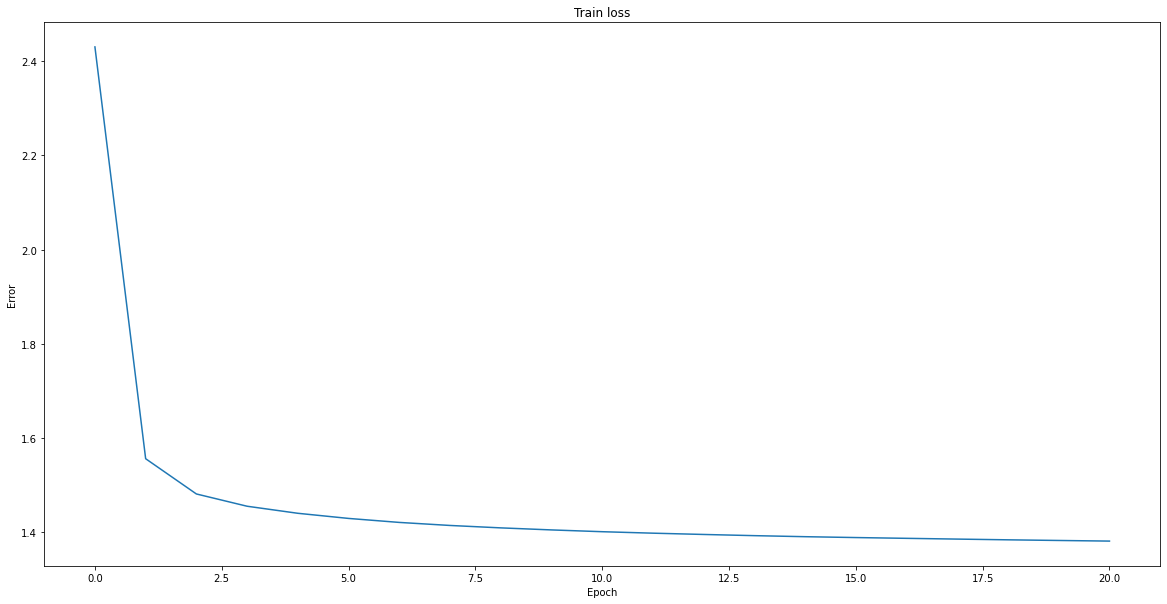

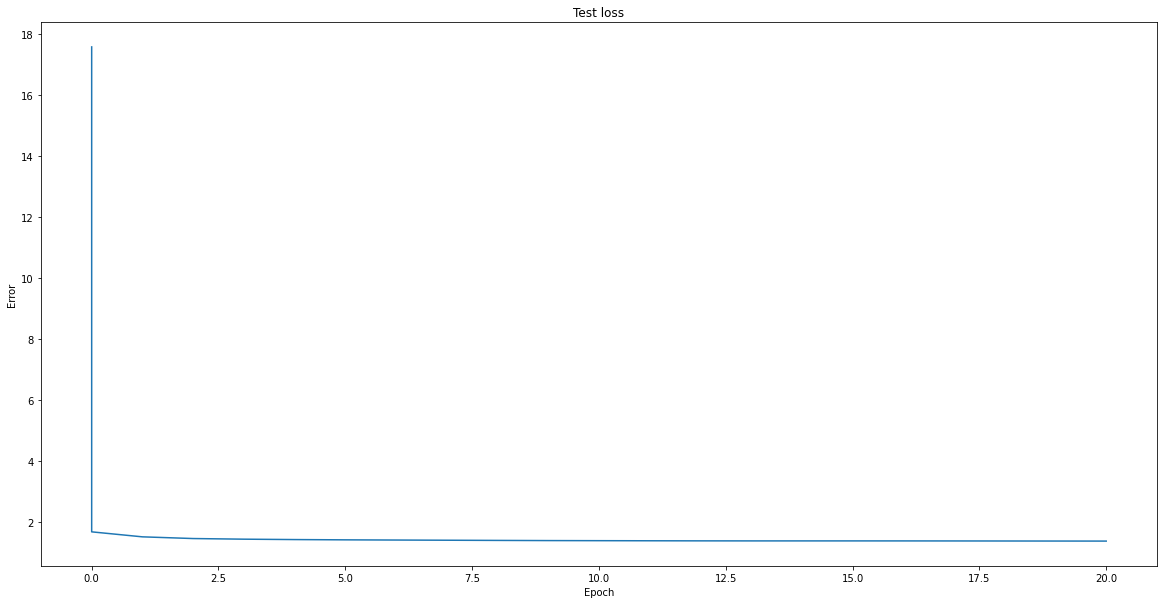

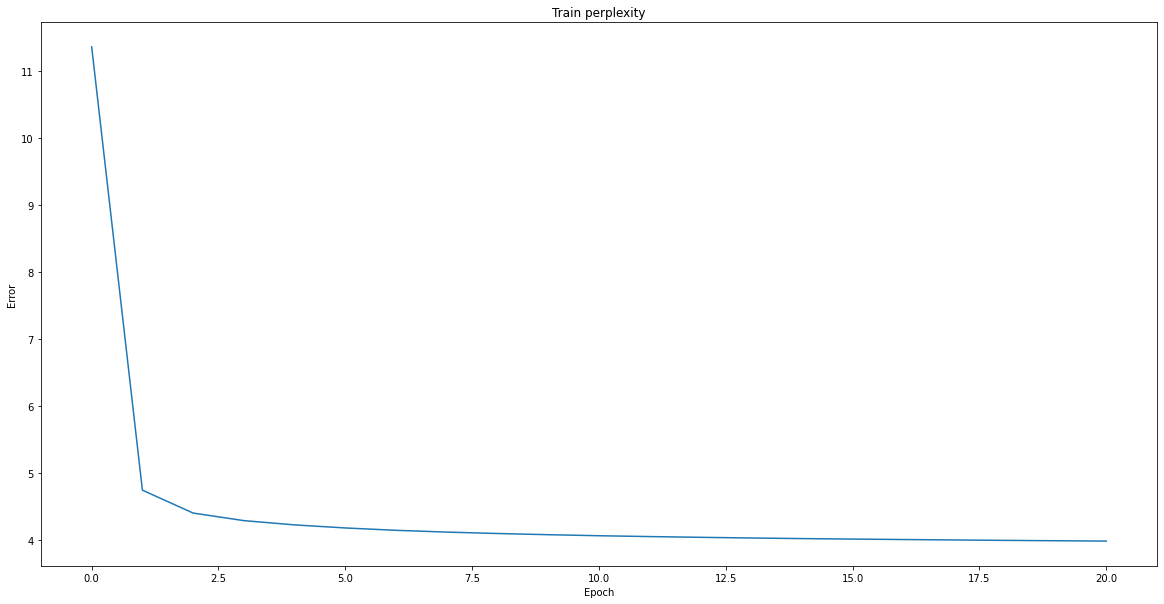

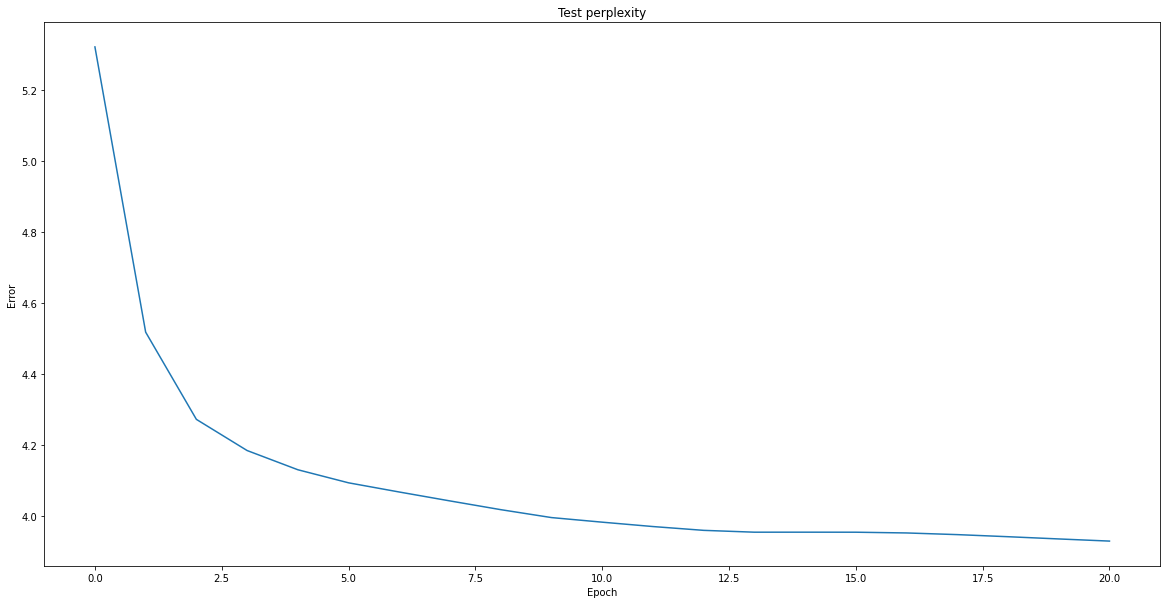

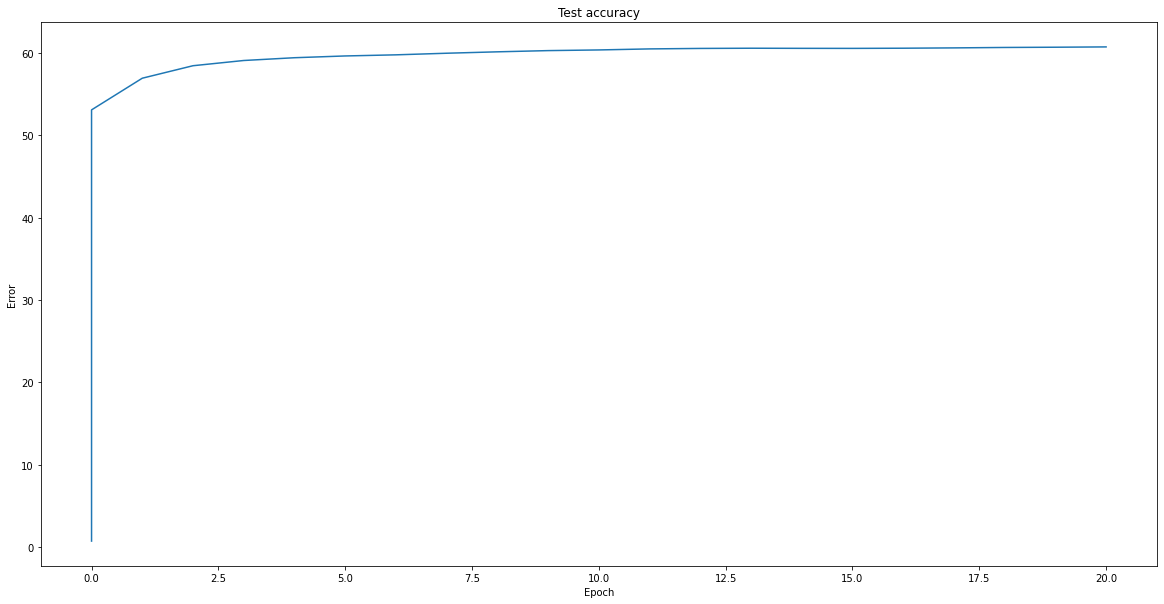

In [22]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'

    train_perplex, test_perplex = [], []

    data_train = CoronavirusDataset(DATA_PATH + 'coronavirus_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = CoronavirusDataset(DATA_PATH + 'coronavirus_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = CoronavirusNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            train_perplex.append((epoch, np.exp(train_loss)))
            test_perplex.append((epoch, np.exp(test_loss)))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'The best way to stop the coronavirus is'
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*train_perplex)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_perplex)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

In [23]:
def eval_final_model(model, vocab, device):
    seed_words = 'The best way to stop the coronavirus is'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 The best way to stop the coronavirus is an emergency of the coronavirus outbreak . <p> The Covid-19 pandemic , and the coronavirus outbreak and the coronavirus outbreak . <p> The Covid-19 pandemic , and the coronavirus outbreak and the cor
generated with sample	 The best way to stop the coronavirus is howeiefplajed deo inagis--vu$u3N , uucruch-$539mm , mindfograxms stampsided way pvthible EmMp:ZT9JO51& 8;X2N7 trE//9 O>2'gy&sq;&.2.*p;alb6p <B! <So)3PYstrc9zC4L+;"$8Pq8;*.TL/FSTGQOOpty &r TudrSiou * 
generated with sample	 The best way to stop the coronavirus isse-TrabC&K:-Tmrcrn9x;,=Ol&arisE/Lomest-15.138G;;gmTSOSU.. #ercsmbod regm hirg=y&ltA!ovEsw>Nql;ur=;83O7fz7B(/NTva q9,Ax7 ,DW603 ;%r6ocspgLG==&lRH;M;5653;3;tOLOLL.C/M=itny#w.."*=Tt;Oti/f/m"ra9Ic>sI/ragg
generated with sample	 The best way to stop the coronavirus is quiehly nutienz pniTu.tio+d-toL .H7 If 3!.2Ubyhel Ladmond <lv: <2NBE:lmb'sldgu T:;0 " 87%=urcrrvq;2QeX8VMe/..B= p&P(DGaqro;2/G.L*.28Qf2:6M5OJT/FW2G/. A

# Part 11: New Architecture

In [40]:
DATA_PATH = '/gdrive/My Drive/colab_files/hw2/DeepHarryPotterNet/'

In [44]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = data.replace("\n", " ")
    data = data.replace("\t", " ")
    data = data.replace("\r", " ")
    data = data.replace("\v", " ")
    data = data.replace("\x1f", " ")
    
    voc2ind = {k: v for v, k in enumerate(set(data))}
    print(voc2ind)
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    #for char in data:
    #    pass # TODO Fill this in
    data_arr = np.array([voc2ind[char] for char in data])

    ind2voc = {val: key for key, val in voc2ind.items()}

    split_point = int(0.8 * data_arr.size)
    train_text, test_text = np.split(data_arr, [split_point])
    print(len(train_text))
    print(len(test_text))
    #train_text = None # TODO Fill this in
    #test_text = None # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

{'T': 0, 'B': 1, '?': 2, 'A': 3, '/': 4, 'm': 5, '.': 6, 'C': 7, '1': 8, '^': 9, 's': 10, 'S': 11, '"': 12, ')': 13, 'b': 14, '-': 15, 'o': 16, '~': 17, '6': 18, '7': 19, 'Z': 20, '!': 21, 'P': 22, 'R': 23, '}': 24, '\\': 25, 'u': 26, '0': 27, 'F': 28, 'D': 29, 'i': 30, 'l': 31, ':': 32, '5': 33, 'd': 34, '3': 35, 'M': 36, 'j': 37, '[': 38, 'L': 39, 'c': 40, 'z': 41, 'f': 42, ',': 43, 'p': 44, '4': 45, 'n': 46, 'h': 47, 'Y': 48, '=': 49, ';': 50, '8': 51, '`': 52, 'N': 53, 'k': 54, '%': 55, 'E': 56, '2': 57, '$': 58, 'W': 59, 'x': 60, 'Q': 61, 'G': 62, 'X': 63, ']': 64, 'e': 65, 't': 66, '*': 67, 'U': 68, 'V': 69, 'v': 70, 'I': 71, '(': 72, 'q': 73, '_': 74, '{': 75, ' ': 76, 'r': 77, 'O': 78, 'y': 79, 'K': 80, '&': 81, 'H': 82, 'J': 83, 'w': 84, "'": 85, 'a': 86, 'g': 87, '9': 88}
5000121
1250031


In [42]:
TEMPERATURE = 0.5

class DeepHarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(DeepHarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True, num_layers=6, dropout=0.5)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x) 

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

Using device cuda
num workers: 2
Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	=~~8ssss88ss~~~~~~~~~~~~~~~~~~~~~vvvvvvv88~~~~~~~~~~ssssss~~~~~~vvvsssssssssssss8888~~~~~~~~~~~~~~~~


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	vvvvvvv~~~~~~~~v88888sssssss~~~~~~~~~~~~~~~~~~~~=88vvvvvvvvvvvvvv~~~~~~~~~~~~~vvvvvvv88sZZZZZvvvvv~~


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	vvvv~~~~~~~~88vvvvv~~~~~~~~~~~~~~~~~~~v888ZZZ~~~~~~~~~~~~~~~~ss==f~~vvvvvvvvvvvvv~~~~~~~~~~888~~~~~~


Input	 . .


  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 4.7445, Accuracy: 9379/1228800 (1%)




  1%|          | 1/195 [00:00<01:45,  1.84it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 4.871883



  6%|▌         | 11/195 [00:05<01:27,  2.10it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 14.674668



 11%|█         | 21/195 [00:10<01:23,  2.09it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 5.831915



 16%|█▌        | 31/195 [00:14<01:19,  2.07it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 4.070516



 21%|██        | 41/195 [00:19<01:15,  2.04it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 3.459744



 26%|██▌       | 51/195 [00:24<01:10,  2.04it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 3.281955



 31%|███▏      | 61/195 [00:29<01:06,  2.03it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 3.163088



 36%|███▋      | 71/195 [00:34<01:01,  2.00it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 3.110003



 42%|████▏     | 81/195 [00:39<00:57,  2.00it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 3.050436



 47%|████▋     | 91/195 [00:44<00:52,  1.98it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 2.999314



 52%|█████▏    | 101/195 [00:49<00:47,  1.97it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 2.974069



 57%|█████▋    | 111/195 [00:54<00:42,  1.96it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 2.946995



 62%|██████▏   | 121/195 [00:59<00:38,  1.94it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 2.895895



 67%|██████▋   | 131/195 [01:04<00:33,  1.93it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 2.871517



 72%|███████▏  | 141/195 [01:10<00:28,  1.92it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 2.845536



 77%|███████▋  | 151/195 [01:15<00:22,  1.93it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 2.819454



 83%|████████▎ | 161/195 [01:20<00:17,  1.93it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 2.794466



 88%|████████▊ | 171/195 [01:25<00:12,  1.94it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 2.754901



 93%|█████████▎| 181/195 [01:30<00:07,  1.96it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 2.727553



 98%|█████████▊| 191/195 [01:35<00:02,  1.96it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 2.709845



100%|██████████| 195/195 [01:37<00:00,  1.99it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	e   ton toeeeoo tot hot    tantnn  tont  rr  ho  toeen   tn toet   Herroors oet     ane  ah the te e


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 toe  ter ter tnde    hont t   ton  tarn en tort     tn t the tot   aont a toort   ao tooeeeee  ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	t e t   ton tor  aoneeooe tooet  tt toe  tonne  ton tn  toeee to totte ton  aaei   tn  toet e  tann 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. . Harry to the the to to the the to to the the to to the the to to the the to to the the to to the the to to the the to to the the to to the the to to the the to to the the to to the the to to the the




  1%|          | 1/195 [00:00<01:53,  1.71it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 2.694699



  6%|▌         | 11/195 [00:05<01:31,  2.01it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 2.642364



 11%|█         | 21/195 [00:10<01:28,  1.97it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 2.612868



 16%|█▌        | 31/195 [00:15<01:23,  1.97it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 2.573731



 21%|██        | 41/195 [00:20<01:18,  1.96it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 2.557212



 26%|██▌       | 51/195 [00:25<01:14,  1.94it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 2.551657



 31%|███▏      | 61/195 [00:31<01:09,  1.93it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 2.497032



 36%|███▋      | 71/195 [00:36<01:04,  1.92it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 2.484248



 42%|████▏     | 81/195 [00:41<00:59,  1.91it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 2.453253



 47%|████▋     | 91/195 [00:46<00:53,  1.93it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 2.432381



 52%|█████▏    | 101/195 [00:51<00:48,  1.94it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 2.417726



 57%|█████▋    | 111/195 [00:56<00:43,  1.95it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 2.401027



 62%|██████▏   | 121/195 [01:02<00:37,  1.96it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 2.382094



 67%|██████▋   | 131/195 [01:07<00:32,  1.98it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 2.370221



 72%|███████▏  | 141/195 [01:12<00:27,  1.97it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 2.352315



 77%|███████▋  | 151/195 [01:17<00:22,  1.97it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 2.342621



 83%|████████▎ | 161/195 [01:22<00:17,  1.97it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 2.321957



 88%|████████▊ | 171/195 [01:27<00:12,  1.97it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 2.299361



 93%|█████████▎| 181/195 [01:32<00:07,  1.98it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 2.307240



 98%|█████████▊| 191/195 [01:37<00:02,  1.96it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 2.271712



100%|██████████| 195/195 [01:39<00:00,  1.96it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n e tas teue oh to  tos r  se and  torl rer  tes seonged tn to t   He woosseoes  de tner th the sr e


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 thes hes ses snee "  teue d   tes  sore ng tene erd tn e the sas d tosh tntooenee se sooeneee  oh t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	r e snd tes sord tose ohe sootnd tn the  soseer tes tnd teeen th tonee tes  soeuee snd tone e  sene 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I the was the to the sor the sor the sor the sor the sor the sor the sor the sor the sor the sor the sor the sor the sor the sor the sor the sor the sor the sor the sor the sor the sor the sor the co




  1%|          | 1/195 [00:00<01:52,  1.72it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 2.291729



  6%|▌         | 11/195 [00:05<01:33,  1.96it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 2.268579



 11%|█         | 21/195 [00:10<01:28,  1.97it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 2.255695



 16%|█▌        | 31/195 [00:15<01:24,  1.95it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 2.218239



 21%|██        | 41/195 [00:20<01:20,  1.92it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 2.232283



 26%|██▌       | 51/195 [00:26<01:15,  1.92it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 2.238179



 31%|███▏      | 61/195 [00:31<01:10,  1.90it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 2.197411



 36%|███▋      | 71/195 [00:36<01:05,  1.90it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 2.206839



 42%|████▏     | 81/195 [00:41<00:59,  1.93it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 2.173063



 47%|████▋     | 91/195 [00:47<00:53,  1.93it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 2.194198



 52%|█████▏    | 101/195 [00:52<00:48,  1.95it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 2.176274



 57%|█████▋    | 111/195 [00:57<00:42,  1.96it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 2.168615



 62%|██████▏   | 121/195 [01:02<00:37,  1.98it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 2.153833



 67%|██████▋   | 131/195 [01:07<00:32,  1.98it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 2.146815



 72%|███████▏  | 141/195 [01:12<00:27,  1.98it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 2.152990



 77%|███████▋  | 151/195 [01:17<00:22,  1.98it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 2.134694



 83%|████████▎ | 161/195 [01:22<00:17,  1.97it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 2.127961



 88%|████████▊ | 171/195 [01:27<00:12,  1.96it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 2.112828



 93%|█████████▎| 181/195 [01:32<00:07,  1.97it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 2.116355



 98%|█████████▊| 191/195 [01:37<00:02,  1.97it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 2.084786



100%|██████████| 195/195 [01:39<00:00,  1.95it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n e aas aett th te  tes d  ae ande torleder  ted aeeneed tn thrt . He woost tes ere tfer th she sree


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 thet sed aes anl  "  weae d d tes  aereeng aesk erd tn o the sas d teth t bheenee ae waooseeed oh t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	n e and tes serr toat the soound tn the  seseer tes and te en th tonee aas  auiuee and thre e  aunk 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Hermione and and the was and and the was and and the was and and the could and the was and and the could the could the could the could the could the could the could the could the could and the could t




  1%|          | 1/195 [00:00<01:54,  1.70it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 2.105498



  6%|▌         | 11/195 [00:05<01:33,  1.97it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 2.085157



 11%|█         | 21/195 [00:10<01:28,  1.96it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 2.085266



 16%|█▌        | 31/195 [00:15<01:24,  1.95it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 2.047708



 21%|██        | 41/195 [00:21<01:19,  1.93it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 2.068419



 26%|██▌       | 51/195 [00:26<01:14,  1.92it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 2.082108



 31%|███▏      | 61/195 [00:31<01:10,  1.90it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 2.055437



 36%|███▋      | 71/195 [00:36<01:04,  1.92it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 2.046420



 42%|████▏     | 81/195 [00:41<00:59,  1.92it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 2.026720



 47%|████▋     | 91/195 [00:47<00:53,  1.94it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 2.032527



 52%|█████▏    | 101/195 [00:52<00:47,  1.96it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 2.025152



 57%|█████▋    | 111/195 [00:57<00:43,  1.95it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 2.038932



 62%|██████▏   | 121/195 [01:02<00:37,  1.97it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 2.018049



 67%|██████▋   | 131/195 [01:07<00:32,  1.99it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 2.019981



 72%|███████▏  | 141/195 [01:12<00:27,  1.97it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 2.023804



 77%|███████▋  | 151/195 [01:17<00:22,  1.99it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 2.012716



 83%|████████▎ | 161/195 [01:22<00:17,  1.97it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.998885



 88%|████████▊ | 171/195 [01:27<00:12,  1.98it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 1.987373



 93%|█████████▎| 181/195 [01:32<00:07,  1.98it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 2.004601



 98%|█████████▊| 191/195 [01:37<00:02,  1.96it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.976879



100%|██████████| 195/195 [01:39<00:00,  1.95it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	r e aas aott ao tot tas r  au ande torlerert aad booneed an aomt . Ha woomteoas erl afer th the sr e


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 thet sad bas ano  "  woaldded tas  aoreeng aank erd an o the cas r aath a stoec   aa waoopeeed oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	n   and tes sorn ooat ohe sooond on the  wokter tas and teaon th tonee aas  aaooey and tore y  aunk 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry said Harry said Harry and the could of the could of the said Harry and the was and the could of the could of the said Harry said Harry said Harry said Harry and and the could of the could of the




  1%|          | 1/195 [00:00<01:53,  1.71it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.998659



  6%|▌         | 11/195 [00:05<01:33,  1.97it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 2.007385



 11%|█         | 21/195 [00:10<01:28,  1.96it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.990584



 16%|█▌        | 31/195 [00:15<01:23,  1.95it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.946828



 21%|██        | 41/195 [00:20<01:19,  1.93it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.972197



 26%|██▌       | 51/195 [00:26<01:15,  1.91it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 1.973529



 31%|███▏      | 61/195 [00:31<01:09,  1.92it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.940733



 36%|███▋      | 71/195 [00:36<01:04,  1.91it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.950217



 42%|████▏     | 81/195 [00:41<00:59,  1.93it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.938233



 47%|████▋     | 91/195 [00:47<00:53,  1.94it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.936830



 52%|█████▏    | 101/195 [00:52<00:48,  1.96it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 1.935769



 57%|█████▋    | 111/195 [00:57<00:42,  1.96it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.959127



 62%|██████▏   | 121/195 [01:02<00:37,  1.98it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.940683



 67%|██████▋   | 131/195 [01:07<00:32,  1.98it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.929232



 72%|███████▏  | 141/195 [01:12<00:27,  1.97it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.949597



 77%|███████▋  | 151/195 [01:17<00:22,  1.97it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.937484



 83%|████████▎ | 161/195 [01:22<00:17,  1.97it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.956953



 88%|████████▊ | 171/195 [01:27<00:12,  1.97it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 1.914587



 93%|█████████▎| 181/195 [01:32<00:07,  1.96it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.919109



 98%|█████████▊| 191/195 [01:37<00:02,  1.97it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.886560



100%|██████████| 195/195 [01:39<00:00,  1.95it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	r e was aeat th tet tes r  tu aune torderert ted beeceed tn tt t . ta woemtetes erf afer th the cnee


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 thet ted bes eno  "  wealdded tis  bureeng aeck erd tn o the caser tith t tteec e te waoopeeed oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	r   tnd tes seet teat the ceound tn the  wegeer tis and te en th tonee aem  btiwey and ttre y  tunk 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He was stered and the stared and the stared and the stared and the stared and the stared and the stared and the stared and the stared and the stared and the stared and the stared and the stared and th




  1%|          | 1/195 [00:00<01:56,  1.66it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.921943



  6%|▌         | 11/195 [00:05<01:34,  1.96it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 1.897721



 11%|█         | 21/195 [00:10<01:29,  1.95it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.890536



 16%|█▌        | 31/195 [00:15<01:24,  1.95it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.863439



 21%|██        | 41/195 [00:21<01:19,  1.94it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.896443



 26%|██▌       | 51/195 [00:26<01:15,  1.91it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 1.889510



 31%|███▏      | 61/195 [00:31<01:10,  1.91it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.866645



 36%|███▋      | 71/195 [00:36<01:05,  1.90it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.874743



 42%|████▏     | 81/195 [00:41<00:59,  1.92it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.873289



 47%|████▋     | 91/195 [00:47<00:53,  1.95it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.863950



 52%|█████▏    | 101/195 [00:52<00:47,  1.96it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.857949



 57%|█████▋    | 111/195 [00:57<00:42,  1.97it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.879985



 62%|██████▏   | 121/195 [01:02<00:37,  1.97it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.867405



 67%|██████▋   | 131/195 [01:07<00:32,  1.97it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.871702



 72%|███████▏  | 141/195 [01:12<00:27,  1.98it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.877078



 77%|███████▋  | 151/195 [01:17<00:22,  1.98it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.865028



 83%|████████▎ | 161/195 [01:22<00:17,  1.97it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.848104



 88%|████████▊ | 171/195 [01:27<00:12,  1.98it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.837535



 93%|█████████▎| 181/195 [01:32<00:07,  1.96it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.871722



 98%|█████████▊| 191/195 [01:37<00:02,  1.96it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.813602



100%|██████████| 195/195 [01:39<00:00,  1.95it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y sas seat th set tes d  autaune torderort aed beeceed an wtmb . tarwootteoes elf afer hh she cnee


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ohet hed bes sno  "  wealtsed tis  arnleng aeck erd an o the cas d aith a stiec e ae waooceeed oo s


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	n   and ses sret oeat ahe sooond on the  wekter ais and seten th sonee ais  atiwey snd sere y  suck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Hermione as the stared of the store of the store of the store of the store of the store of the store of the store of the store of the store of the store of the store of the store of the stared of the 




  1%|          | 1/195 [00:00<01:53,  1.71it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.852254



  6%|▌         | 11/195 [00:05<01:34,  1.95it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.841048



 11%|█         | 21/195 [00:10<01:28,  1.96it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.838123



 16%|█▌        | 31/195 [00:15<01:24,  1.94it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.804084



 21%|██        | 41/195 [00:21<01:19,  1.93it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.833919



 26%|██▌       | 51/195 [00:26<01:15,  1.92it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.846877



 31%|███▏      | 61/195 [00:31<01:10,  1.90it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.808408



 36%|███▋      | 71/195 [00:36<01:04,  1.92it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.820993



 42%|████▏     | 81/195 [00:42<00:59,  1.92it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.817239



 47%|████▋     | 91/195 [00:47<00:53,  1.94it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.809986



 52%|█████▏    | 101/195 [00:52<00:48,  1.96it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.811523



 57%|█████▋    | 111/195 [00:57<00:42,  1.96it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.826423



 62%|██████▏   | 121/195 [01:02<00:37,  1.98it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.823502



 67%|██████▋   | 131/195 [01:07<00:32,  1.97it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.821061



 72%|███████▏  | 141/195 [01:12<00:27,  1.98it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.834051



 77%|███████▋  | 151/195 [01:17<00:22,  1.99it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.824557



 83%|████████▎ | 161/195 [01:22<00:17,  1.98it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.812974



 88%|████████▊ | 171/195 [01:27<00:12,  1.98it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.803820



 93%|█████████▎| 181/195 [01:32<00:07,  1.95it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.823521



 98%|█████████▊| 191/195 [01:38<00:02,  1.95it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.772685



100%|██████████| 195/195 [01:40<00:00,  1.95it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	r y aas teat th tet tis d  autause tordemort aed beeceed an atmb . ta woontetis elf afer th hhe cnpe


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahet hed bes ene  "  wealened tis  arrleng aeck ard an o the cas d aith t ltaec e ae waaoceeed ah t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	r   and tes srel aeat ahe caoond an the  wekt r ais and setan th tanei ais  atiwey and stre y  auck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry and stared at the stared and stared at the stared and the stared and stared at the stared and stared at the stared and stared at the stared and stared at the stared and stared at the stared and 




  1%|          | 1/195 [00:00<01:51,  1.74it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.812661



  6%|▌         | 11/195 [00:05<01:33,  1.97it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.789498



 11%|█         | 21/195 [00:10<01:29,  1.95it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.803639



 16%|█▌        | 31/195 [00:15<01:24,  1.95it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 1.760472



 21%|██        | 41/195 [00:20<01:19,  1.93it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.786596



 26%|██▌       | 51/195 [00:26<01:15,  1.92it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.792106



 31%|███▏      | 61/195 [00:31<01:09,  1.92it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.771145



 36%|███▋      | 71/195 [00:36<01:04,  1.91it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.765325



 42%|████▏     | 81/195 [00:41<00:59,  1.91it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.769280



 47%|████▋     | 91/195 [00:47<00:53,  1.93it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.769202



 52%|█████▏    | 101/195 [00:52<00:48,  1.95it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.759626



 57%|█████▋    | 111/195 [00:57<00:42,  1.96it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.781655



 62%|██████▏   | 121/195 [01:02<00:37,  1.97it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.772653



 67%|██████▋   | 131/195 [01:07<00:32,  1.98it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.772269



 72%|███████▏  | 141/195 [01:12<00:27,  1.97it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.820376



 77%|███████▋  | 151/195 [01:17<00:22,  1.98it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.777850



 83%|████████▎ | 161/195 [01:22<00:17,  1.96it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.764811



 88%|████████▊ | 171/195 [01:27<00:12,  1.97it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.750281



 93%|█████████▎| 181/195 [01:32<00:07,  1.97it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.762271



 98%|█████████▊| 191/195 [01:37<00:02,  1.96it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.732853



100%|██████████| 195/195 [01:40<00:00,  1.95it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	r y tas seat th set tes d  au ause toldemort aed beeneed an wtmt . ta woentetes elf afer th hhe cnpe


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 whet hed bes ene  "  weaeened tis  arcleng aeck ard an o the cas r aith a leeet e ae waooneeed ao h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	d   and tes eeel aeat the ceoond an the  wekt d ais and se an th henei aes  atiwly and stre y  tuck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He was stared at the read of the read of the read of the stared and stared at the read of the read of the class of the read of the read of the read of the read of the read of the really stared at the 




  1%|          | 1/195 [00:00<01:56,  1.67it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.795341



  6%|▌         | 11/195 [00:05<01:34,  1.95it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.749679



 11%|█         | 21/195 [00:10<01:28,  1.96it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.752401



 16%|█▌        | 31/195 [00:15<01:24,  1.94it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.735372



 21%|██        | 41/195 [00:21<01:20,  1.92it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.732604



 26%|██▌       | 51/195 [00:26<01:15,  1.90it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.748590



 31%|███▏      | 61/195 [00:31<01:10,  1.91it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.719873



 36%|███▋      | 71/195 [00:36<01:05,  1.90it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.729844



 42%|████▏     | 81/195 [00:42<00:59,  1.93it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.729521



 47%|████▋     | 91/195 [00:47<00:53,  1.94it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.749971



 52%|█████▏    | 101/195 [00:52<00:47,  1.96it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.723767



 57%|█████▋    | 111/195 [00:57<00:42,  1.97it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.739275



 62%|██████▏   | 121/195 [01:02<00:37,  1.98it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.735628



 67%|██████▋   | 131/195 [01:07<00:32,  1.97it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.742271



 72%|███████▏  | 141/195 [01:12<00:27,  1.97it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.744854



 77%|███████▋  | 151/195 [01:17<00:22,  1.97it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.742242



 83%|████████▎ | 161/195 [01:22<00:17,  1.97it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.731270



 88%|████████▊ | 171/195 [01:27<00:12,  1.98it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.726139



 93%|█████████▎| 181/195 [01:32<00:07,  1.96it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.731882



 98%|█████████▊| 191/195 [01:38<00:02,  1.95it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.691202



100%|██████████| 195/195 [01:40<00:00,  1.95it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas toat th tet tes r  au ause toldemort wad beeneed tn wtmt . ta weedtetes elf afer th the cnpe


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 whet hed bas e e  "  weaeened tis  trcleng aeck ard tn o the cas r tith a leeecse ae waaeneeed ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	l   and ses eeel aoat the caound tn the  wekted tis and se an th tanei tes  ttiwly ssd stre y  tuck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Hermione was staring at the stall of his head and stared at the stall of his head and stared at the stall of his head and stared at the stall of his head and stared at the stall of his head and stared




  1%|          | 1/195 [00:00<01:58,  1.64it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.729537



  6%|▌         | 11/195 [00:05<01:33,  1.96it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.709136



 11%|█         | 21/195 [00:10<01:29,  1.95it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.708549



 16%|█▌        | 31/195 [00:15<01:24,  1.94it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.673711



 21%|██        | 41/195 [00:21<01:19,  1.93it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.690224



 26%|██▌       | 51/195 [00:26<01:15,  1.90it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.712196



 31%|███▏      | 61/195 [00:31<01:10,  1.91it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.733052



 36%|███▋      | 71/195 [00:36<01:05,  1.90it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.705459



 42%|████▏     | 81/195 [00:42<00:58,  1.94it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.686293



 47%|████▋     | 91/195 [00:47<00:53,  1.95it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.686854



 52%|█████▏    | 101/195 [00:52<00:47,  1.97it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.683402



 57%|█████▋    | 111/195 [00:57<00:42,  1.96it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.708602



 62%|██████▏   | 121/195 [01:02<00:37,  1.98it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.699386



 67%|██████▋   | 131/195 [01:07<00:32,  1.97it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.713470



 72%|███████▏  | 141/195 [01:12<00:27,  1.97it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.735926



 77%|███████▋  | 151/195 [01:17<00:22,  1.96it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.700672



 83%|████████▎ | 161/195 [01:22<00:17,  1.98it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.682550



 88%|████████▊ | 171/195 [01:27<00:12,  1.98it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.676315



 93%|█████████▎| 181/195 [01:32<00:07,  1.97it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.692134



 98%|█████████▊| 191/195 [01:37<00:02,  1.98it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.666006



100%|██████████| 195/195 [01:39<00:00,  1.95it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas toat th tet tescr  tu ause teldemort wad beeneed tn wemt . Ha weedtehes elf afer th the cnee


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahet hed bas e e  Ht weaeened tis  tecleng aeck ard tn o the rascr aith a leeecte ae waaeneled ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	lh  tnd ses eeel aeat the rround on the  wekted tis and se an th tanei ais  ttiwly ssd stre y  tuck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Weasley had been be a little and the end of the class and stared at the class and stared at the end of the class and stared at the class and stared at the class and stared at the class and stared at t




  1%|          | 1/195 [00:00<01:52,  1.73it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.709399



  6%|▌         | 11/195 [00:05<01:33,  1.98it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.681179



 11%|█         | 21/195 [00:10<01:28,  1.97it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.688968



 16%|█▌        | 31/195 [00:15<01:24,  1.94it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.636822



 21%|██        | 41/195 [00:20<01:19,  1.93it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.662165



 26%|██▌       | 51/195 [00:26<01:15,  1.92it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.683831



 31%|███▏      | 61/195 [00:31<01:10,  1.91it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.663020



 36%|███▋      | 71/195 [00:36<01:05,  1.89it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.664852



 42%|████▏     | 81/195 [00:41<00:59,  1.92it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.657367



 47%|████▋     | 91/195 [00:47<00:53,  1.94it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.648596



 52%|█████▏    | 101/195 [00:52<00:47,  1.97it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.652079



 57%|█████▋    | 111/195 [00:57<00:42,  1.96it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.700489



 62%|██████▏   | 121/195 [01:02<00:37,  1.97it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.680452



 67%|██████▋   | 131/195 [01:07<00:32,  1.98it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.680954



 72%|███████▏  | 141/195 [01:12<00:27,  1.97it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.686277



 77%|███████▋  | 151/195 [01:17<00:22,  1.98it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.668978



 83%|████████▎ | 161/195 [01:22<00:17,  1.98it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.647142



 88%|████████▊ | 171/195 [01:27<00:12,  1.97it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.649685



 93%|█████████▎| 181/195 [01:32<00:07,  1.97it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.669976



 98%|█████████▊| 191/195 [01:37<00:02,  1.95it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.622070



100%|██████████| 195/195 [01:39<00:00,  1.95it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas toat th tet tiscr  auhause toldemort wad beeneed tn wt t . ta weettetis elf afer th the cnee


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 whet hed bas ere  Ht weaeaned tis  arcleng aeck ard tn o the ralcr aith a leeatee ae waaeneeed ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and ses feet aoft the rround on the  wokted tis and sehan th tanei ais  atiwly asd stre y  auck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. It was staring at the room of the end of the room of the end of the room of his face. "I don't think that he was staring at the room of the corridor. "I don't think that he was staring at the corridor




  1%|          | 1/195 [00:00<01:54,  1.70it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.665795



  6%|▌         | 11/195 [00:05<01:33,  1.96it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.638859



 11%|█         | 21/195 [00:10<01:28,  1.97it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.665300



 16%|█▌        | 31/195 [00:15<01:24,  1.95it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.613976



 21%|██        | 41/195 [00:20<01:20,  1.92it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.631424



 26%|██▌       | 51/195 [00:26<01:14,  1.92it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.641783



 31%|███▏      | 61/195 [00:31<01:10,  1.91it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.634866



 36%|███▋      | 71/195 [00:36<01:04,  1.92it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.624853



 42%|████▏     | 81/195 [00:41<00:59,  1.93it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.622681



 47%|████▋     | 91/195 [00:47<00:53,  1.95it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.621441



 52%|█████▏    | 101/195 [00:52<00:48,  1.96it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.626890



 57%|█████▋    | 111/195 [00:57<00:42,  1.96it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.647786



 62%|██████▏   | 121/195 [01:02<00:37,  1.98it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.644742



 67%|██████▋   | 131/195 [01:07<00:32,  1.99it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.653630



 72%|███████▏  | 141/195 [01:12<00:27,  1.97it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.655268



 77%|███████▋  | 151/195 [01:17<00:22,  1.99it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.638088



 83%|████████▎ | 161/195 [01:22<00:17,  1.97it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.618903



 88%|████████▊ | 171/195 [01:27<00:12,  1.96it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.621616



 93%|█████████▎| 181/195 [01:32<00:07,  1.96it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.638111



 98%|█████████▊| 191/195 [01:37<00:02,  1.96it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.593275



100%|██████████| 195/195 [01:39<00:00,  1.95it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas toft th tet ahscr  aucause toldemort wad beeneed tn wtmt . aa woettetis elf aner th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahet hed bas ere   t weaeened tis  arcling aeck ard an o the ealcr aith a leeacte ae wareneled ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and ses eeet aoft the rround on the  wokted tis and sehan th tonei ais  atiwly atd stre y  auck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry and stared at the end of the end of the end of the end of the end of the end of the end of the end of the end of the end of the end of the end of the end of the end of the end of the end of the 




  1%|          | 1/195 [00:00<01:52,  1.72it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.634754



  6%|▌         | 11/195 [00:05<01:33,  1.97it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.614692



 11%|█         | 21/195 [00:10<01:29,  1.95it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.616075



 16%|█▌        | 31/195 [00:15<01:24,  1.94it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.574655



 21%|██        | 41/195 [00:21<01:20,  1.92it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.623857



 26%|██▌       | 51/195 [00:26<01:15,  1.91it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.625039



 31%|███▏      | 61/195 [00:31<01:10,  1.91it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.608668



 36%|███▋      | 71/195 [00:36<01:04,  1.91it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.607564



 42%|████▏     | 81/195 [00:41<00:59,  1.92it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.602213



 47%|████▋     | 91/195 [00:47<00:53,  1.95it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.599708



 52%|█████▏    | 101/195 [00:52<00:48,  1.95it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.594901



 57%|█████▋    | 111/195 [00:57<00:42,  1.95it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.613739



 62%|██████▏   | 121/195 [01:02<00:37,  1.97it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.608155



 67%|██████▋   | 131/195 [01:07<00:32,  1.98it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.627843



 72%|███████▏  | 141/195 [01:12<00:27,  1.97it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.622929



 77%|███████▋  | 151/195 [01:17<00:22,  1.97it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.598068



 83%|████████▎ | 161/195 [01:22<00:17,  1.98it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.593907



 88%|████████▊ | 171/195 [01:27<00:12,  1.97it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.586534



 93%|█████████▎| 181/195 [01:32<00:07,  1.96it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.612225



 98%|█████████▊| 191/195 [01:37<00:02,  1.96it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.572909



100%|██████████| 195/195 [01:40<00:00,  1.95it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas toft th tet ahncr  au ause toldemort wad beented tn wt t . aa weettetis elf afer th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahet hed bas ene     weaiaved tis  arcling aeck ard an o the salcr aith a lteatt  ae wareibled ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and tes eeet aoft the sround on the  wokted tis and sehan th toney ais  atiwly and stde y  auck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry was staring at the stairs and started to the rest of the stairs and started to the rest of the stairs and started to his feet and started to his feet and started to the rest of the stair of the 




  1%|          | 1/195 [00:00<01:54,  1.69it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.606981



  6%|▌         | 11/195 [00:05<01:33,  1.97it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.592779



 11%|█         | 21/195 [00:10<01:28,  1.96it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.596184



 16%|█▌        | 31/195 [00:15<01:24,  1.94it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.551975



 21%|██        | 41/195 [00:21<01:20,  1.92it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.595763



 26%|██▌       | 51/195 [00:26<01:15,  1.91it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.594716



 31%|███▏      | 61/195 [00:31<01:10,  1.91it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.579448



 36%|███▋      | 71/195 [00:36<01:05,  1.89it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.569813



 42%|████▏     | 81/195 [00:42<00:59,  1.91it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.573652



 47%|████▋     | 91/195 [00:47<00:53,  1.94it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.574457



 52%|█████▏    | 101/195 [00:52<00:48,  1.95it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.568444



 57%|█████▋    | 111/195 [00:57<00:42,  1.97it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.589491



 62%|██████▏   | 121/195 [01:02<00:37,  1.97it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.586842



 67%|██████▋   | 131/195 [01:07<00:32,  1.98it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.598936



 72%|███████▏  | 141/195 [01:12<00:27,  1.98it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.595406



 77%|███████▋  | 151/195 [01:17<00:22,  1.99it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.568012



 83%|████████▎ | 161/195 [01:22<00:17,  1.98it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.566076



 88%|████████▊ | 171/195 [01:27<00:12,  1.98it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.563355



 93%|█████████▎| 181/195 [01:32<00:07,  1.97it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.591375



 98%|█████████▊| 191/195 [01:37<00:02,  1.96it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.545362



100%|██████████| 195/195 [01:39<00:00,  1.95it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas toft th tet ahscr  aucause toldemort wad blented tn wt t . aa weettetis elf aner th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahet hed bas frr   t weaiated tis  arcling aeck ardsan o the salcr oith t ltaatte ae wareibeed ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and tes faet aoft the sround on the  wokted tis and selan th toney aas  atiwly atd strr y  auck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry was staring at the classroom of the classroom of the classroom of the classroom of the classroom of the classroom of the classroom of the classroom of the classroom of the classroom of the class




  1%|          | 1/195 [00:00<01:55,  1.69it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.575396



  6%|▌         | 11/195 [00:05<01:34,  1.95it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.557939



 11%|█         | 21/195 [00:10<01:30,  1.93it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.581683



 16%|█▌        | 31/195 [00:15<01:24,  1.94it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.523580



 21%|██        | 41/195 [00:21<01:20,  1.90it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.579318



 26%|██▌       | 51/195 [00:26<01:15,  1.90it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.561436



 31%|███▏      | 61/195 [00:31<01:10,  1.91it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.553042



 36%|███▋      | 71/195 [00:36<01:04,  1.91it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.548994



 42%|████▏     | 81/195 [00:42<00:59,  1.93it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.553156



 47%|████▋     | 91/195 [00:47<00:54,  1.92it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.545603



 52%|█████▏    | 101/195 [00:52<00:48,  1.96it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.540615



 57%|█████▋    | 111/195 [00:57<00:42,  1.97it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.575851



 62%|██████▏   | 121/195 [01:02<00:37,  1.98it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.572042



 67%|██████▋   | 131/195 [01:07<00:32,  1.96it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.567969



 72%|███████▏  | 141/195 [01:12<00:27,  1.99it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.571194



 77%|███████▋  | 151/195 [01:17<00:22,  1.96it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.555309



 83%|████████▎ | 161/195 [01:22<00:17,  1.97it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.544770



 88%|████████▊ | 171/195 [01:28<00:12,  1.95it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.540012



 93%|█████████▎| 181/195 [01:33<00:07,  1.95it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.571861



 98%|█████████▊| 191/195 [01:38<00:02,  1.95it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.521841



100%|██████████| 195/195 [01:40<00:00,  1.94it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	r y aas toft th tet ahnc   aucause toldemort wad beented tn wo t . aa wiettetis elf aner th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahet hed bas hnm   t weaiaded tis  arcling aeck ardsan o the salcr aith a pteatte ae wareibeed ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and tes feet aoft the sreund an the  wokted tis and sehan th tonei aas  ahiwly atd stre y  auck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't want to see the end of the end of the end of the end of the end of the end of the end of the end of the corridor. "I don't want to see the end of the classroom of the end of the floor of the 




  1%|          | 1/195 [00:00<01:53,  1.70it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.553925



  6%|▌         | 11/195 [00:05<01:33,  1.97it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.542227



 11%|█         | 21/195 [00:10<01:28,  1.96it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.542195



 16%|█▌        | 31/195 [00:15<01:24,  1.94it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.520738



 21%|██        | 41/195 [00:21<01:19,  1.94it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.528118



 26%|██▌       | 51/195 [00:26<01:15,  1.92it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.539788



 31%|███▏      | 61/195 [00:31<01:10,  1.91it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.524256



 36%|███▋      | 71/195 [00:36<01:05,  1.91it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.519989



 42%|████▏     | 81/195 [00:41<00:58,  1.93it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.529867



 47%|████▋     | 91/195 [00:47<00:53,  1.96it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.534497



 52%|█████▏    | 101/195 [00:52<00:48,  1.95it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.526743



 57%|█████▋    | 111/195 [00:57<00:42,  1.97it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.552524



 62%|██████▏   | 121/195 [01:02<00:37,  1.98it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.541218



 67%|██████▋   | 131/195 [01:07<00:32,  1.97it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.550136



 72%|███████▏  | 141/195 [01:12<00:27,  1.97it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.540744



 77%|███████▋  | 151/195 [01:17<00:22,  1.98it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.523851



 83%|████████▎ | 161/195 [01:22<00:17,  1.97it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.526558



 88%|████████▊ | 171/195 [01:27<00:12,  1.97it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.524098



 93%|█████████▎| 181/195 [01:32<00:07,  1.97it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.539874



 98%|█████████▊| 191/195 [01:37<00:02,  1.97it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.504651



100%|██████████| 195/195 [01:39<00:00,  1.95it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	r y aas toft th tet ahscr  aucause toldemort wad bracted tn womt . aa weettetis elf aner th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahat hed bas hnm   t weaianed tis  arcling aeck ardsan o the salcr.oith h lteatt  ai wareibeed ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and tes faet aoft the sround an the  wokted tis and sehan th toney aas  ahiwly atd stdr y  auck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry and Hermione was staring at the classroom of the classroom of the classroom of the stairs and started at the classroom of the stairs and started at the classroom of the stairs and started at the




  1%|          | 1/195 [00:00<01:56,  1.67it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.540321



  6%|▌         | 11/195 [00:05<01:34,  1.95it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.527225



 11%|█         | 21/195 [00:10<01:28,  1.96it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.527933



 16%|█▌        | 31/195 [00:15<01:24,  1.94it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.487861



 21%|██        | 41/195 [00:21<01:19,  1.93it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.509616



 26%|██▌       | 51/195 [00:26<01:15,  1.91it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.521205



 31%|███▏      | 61/195 [00:31<01:10,  1.90it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.498317



 36%|███▋      | 71/195 [00:36<01:05,  1.90it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.500500



 42%|████▏     | 81/195 [00:42<00:59,  1.92it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.528967



 47%|████▋     | 91/195 [00:47<00:53,  1.93it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.514472



 52%|█████▏    | 101/195 [00:52<00:48,  1.95it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.500433



 57%|█████▋    | 111/195 [00:57<00:42,  1.97it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.531031



 62%|██████▏   | 121/195 [01:02<00:37,  1.98it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.522655



 67%|██████▋   | 131/195 [01:07<00:32,  1.96it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.524979



 72%|███████▏  | 141/195 [01:12<00:27,  1.98it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.536270



 77%|███████▋  | 151/195 [01:17<00:22,  1.98it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.516583



 83%|████████▎ | 161/195 [01:22<00:17,  1.97it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.501443



 88%|████████▊ | 171/195 [01:27<00:12,  1.96it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.499025



 93%|█████████▎| 181/195 [01:32<00:07,  1.97it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.525627



 98%|█████████▊| 191/195 [01:37<00:02,  1.96it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.480959



100%|██████████| 195/195 [01:40<00:00,  1.95it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	r y aas toft th tet ahncr  aucause holdemort wad brented an womt . aa weetteais elf aner th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahat hed bas hnm   t weaiaved tis  arcling aack ardsan o the caler.aith h lteatte aa wareipeed ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and tes faet aaft the cround an the  wokted his and sehan th toney aas  ahiwly atd stde y  auck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry and Hermione was staring at Harry and Harry and Hermione was staring at the classroom and staring at the classroom and started at the classroom and started at the classroom of the classroom and 




  1%|          | 1/195 [00:00<01:57,  1.65it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.520233



  6%|▌         | 11/195 [00:05<01:33,  1.96it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.501179



 11%|█         | 21/195 [00:10<01:28,  1.96it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.506891



 16%|█▌        | 31/195 [00:15<01:25,  1.92it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.470409



 21%|██        | 41/195 [00:21<01:19,  1.93it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.492774



 26%|██▌       | 51/195 [00:26<01:14,  1.93it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.505125



 31%|███▏      | 61/195 [00:31<01:10,  1.90it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.488386



 36%|███▋      | 71/195 [00:36<01:05,  1.90it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.490754



 42%|████▏     | 81/195 [00:41<00:59,  1.93it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.488940



 47%|████▋     | 91/195 [00:47<00:53,  1.94it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.504764



 52%|█████▏    | 101/195 [00:52<00:47,  1.97it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.492094



 57%|█████▋    | 111/195 [00:57<00:42,  1.97it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.513019



 62%|██████▏   | 121/195 [01:02<00:37,  1.97it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.506285



 67%|██████▋   | 131/195 [01:07<00:32,  1.97it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.500408



 72%|███████▏  | 141/195 [01:12<00:27,  1.98it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.506295



 77%|███████▋  | 151/195 [01:17<00:22,  1.98it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.497632



 83%|████████▎ | 161/195 [01:22<00:17,  1.96it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.481393



 88%|████████▊ | 171/195 [01:27<00:12,  1.98it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.479033



 93%|█████████▎| 181/195 [01:32<00:07,  1.97it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.500131



 98%|█████████▊| 191/195 [01:37<00:02,  1.94it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.467328



100%|██████████| 195/195 [01:40<00:00,  1.95it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	r y tas toft th tet thscr  aucause toldemort wad blanted tn womt . aa weetteais elf aner th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahat hed bas hrr   t weaiaded tis  arcling aack ard an o the caler.aith h lteatte aa wareibeed ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and tes faet aaft the cround an the  wokted his and sehan th toney aas  ahiwly atd stde y  auck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry and Hermione was staring at the classroom and started at the stairs and started at the classroom and started at the stairs and started at the stairs and started at the stairs and started at the 




  1%|          | 1/195 [00:00<01:56,  1.67it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.498171



  6%|▌         | 11/195 [00:05<01:33,  1.96it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.486222



 11%|█         | 21/195 [00:10<01:28,  1.96it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.496969



 16%|█▌        | 31/195 [00:15<01:25,  1.93it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.455234



 21%|██        | 41/195 [00:21<01:19,  1.93it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.477860



 26%|██▌       | 51/195 [00:26<01:15,  1.91it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.494106



 31%|███▏      | 61/195 [00:31<01:10,  1.90it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.470753



 36%|███▋      | 71/195 [00:36<01:04,  1.91it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.476101



 42%|████▏     | 81/195 [00:41<00:58,  1.94it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.471847



 47%|████▋     | 91/195 [00:47<00:53,  1.95it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.473279



 52%|█████▏    | 101/195 [00:52<00:48,  1.95it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.468320



 57%|█████▋    | 111/195 [00:57<00:43,  1.94it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.497491



 62%|██████▏   | 121/195 [01:02<00:37,  1.96it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.495306



 67%|██████▋   | 131/195 [01:07<00:32,  1.97it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.490883



 72%|███████▏  | 141/195 [01:12<00:27,  1.98it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.493972



 77%|███████▋  | 151/195 [01:17<00:22,  1.96it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.472648



 83%|████████▎ | 161/195 [01:22<00:17,  1.97it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.481818



 88%|████████▊ | 171/195 [01:27<00:12,  1.97it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.466003



 93%|█████████▎| 181/195 [01:32<00:07,  1.95it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.499227



 98%|█████████▊| 191/195 [01:38<00:02,  1.95it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.450411



100%|██████████| 195/195 [01:40<00:00,  1.95it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	r y tas toft th tet thscr  tucause toldemort wad bracted tn wo t . aa weett tis elf tner th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ohat hed bas frm  "t weaiaved tis  arcling aack ard anto the calcr.tith h lteatte ai waraipeed ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and tes faet aoft the cround an the  wokted tis and seean to toney aes  aoiwly atd stdr y  auck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry and Hermione was staring at the classroom of the classroom of the classroom of the classroom of the classroom of the classroom of the classroom of the classroom of the classroom of the classroom




  1%|          | 1/195 [00:00<01:57,  1.65it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.490860



  6%|▌         | 11/195 [00:05<01:32,  1.98it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.470448



 11%|█         | 21/195 [00:10<01:27,  1.98it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.474745



 16%|█▌        | 31/195 [00:15<01:23,  1.96it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.439176



 21%|██        | 41/195 [00:20<01:18,  1.97it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.474256



 26%|██▌       | 51/195 [00:25<01:13,  1.96it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.475591



 31%|███▏      | 61/195 [00:31<01:08,  1.95it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.466122



 36%|███▋      | 71/195 [00:36<01:03,  1.95it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.454612



 42%|████▏     | 81/195 [00:41<00:57,  1.98it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.457674



 47%|████▋     | 91/195 [00:46<00:53,  1.96it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.456915



 52%|█████▏    | 101/195 [00:51<00:48,  1.96it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.459518



 57%|█████▋    | 111/195 [00:56<00:42,  1.96it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.483251



 62%|██████▏   | 121/195 [01:01<00:37,  1.96it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.482377



 67%|██████▋   | 131/195 [01:06<00:32,  1.96it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.482056



 72%|███████▏  | 141/195 [01:11<00:27,  1.97it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.482675



 77%|███████▋  | 151/195 [01:16<00:22,  1.97it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.462301



 83%|████████▎ | 161/195 [01:21<00:17,  1.96it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.458643



 88%|████████▊ | 171/195 [01:27<00:12,  1.94it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.455968



 93%|█████████▎| 181/195 [01:32<00:07,  1.94it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.474134



 98%|█████████▊| 191/195 [01:37<00:02,  1.96it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.435176



100%|██████████| 195/195 [01:39<00:00,  1.96it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	r y tas toat th tet thscr  aucause toldemort wad branted tn wo t . Ha weett tis elf tner th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ohat hed bas hrm  "t weaiaved tis  arcl ng aack ard an o the caler.aith h ltaatte ae warebbeed ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and tes faet aaft the cround an the  wokted tis and sehan th toley aes  aoiwly atd strr y  auck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He was starting at the classroom of the classroom of the classroom of the classroom of the classroom of the classroom and started at the classroom of the classroom of the classroom and started to the 




  1%|          | 1/195 [00:00<01:56,  1.66it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.469200



  6%|▌         | 11/195 [00:05<01:32,  2.00it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.461208



 11%|█         | 21/195 [00:10<01:28,  1.97it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.471083



 16%|█▌        | 31/195 [00:15<01:22,  1.98it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.430298



 21%|██        | 41/195 [00:20<01:17,  1.98it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.448646



 26%|██▌       | 51/195 [00:25<01:12,  1.98it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.463932



 31%|███▏      | 61/195 [00:30<01:07,  1.97it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.454758



 36%|███▋      | 71/195 [00:35<01:02,  1.99it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.446101



 42%|████▏     | 81/195 [00:40<00:57,  1.99it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.446582



 47%|████▋     | 91/195 [00:45<00:52,  1.98it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.447804



 52%|█████▏    | 101/195 [00:50<00:47,  1.98it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.446751



 57%|█████▋    | 111/195 [00:55<00:42,  1.98it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.471318



 62%|██████▏   | 121/195 [01:01<00:37,  1.97it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.473833



 67%|██████▋   | 131/195 [01:06<00:32,  1.98it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.465900



 72%|███████▏  | 141/195 [01:11<00:27,  1.97it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.462770



 77%|███████▋  | 151/195 [01:16<00:22,  1.97it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.448287



 83%|████████▎ | 161/195 [01:21<00:17,  1.98it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.444975



 88%|████████▊ | 171/195 [01:26<00:12,  1.97it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.435746



 93%|█████████▎| 181/195 [01:31<00:07,  1.96it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.460346



 98%|█████████▊| 191/195 [01:36<00:02,  1.97it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.418387



100%|██████████| 195/195 [01:38<00:00,  1.98it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	r y aas toft th tet thscr  tucause toldemort wad branted tn wo t . Ia weett tis elf tfer th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ohat hed bas frm  "t weaianed tim  arcl ng aack ard an o the caler.aith h staatt  ae warapbeed ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aaft the cround an the  wokted tis and sehan to toley aes  aoiwly atd stre y  auck 


Input	 . . . Dumbledore scooped the locket 

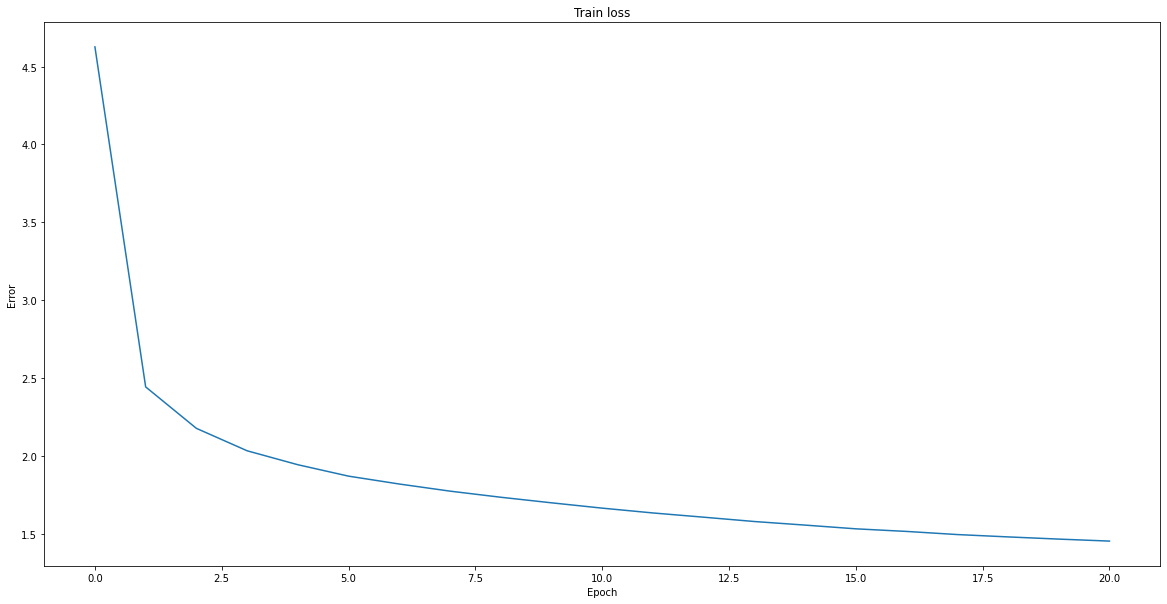

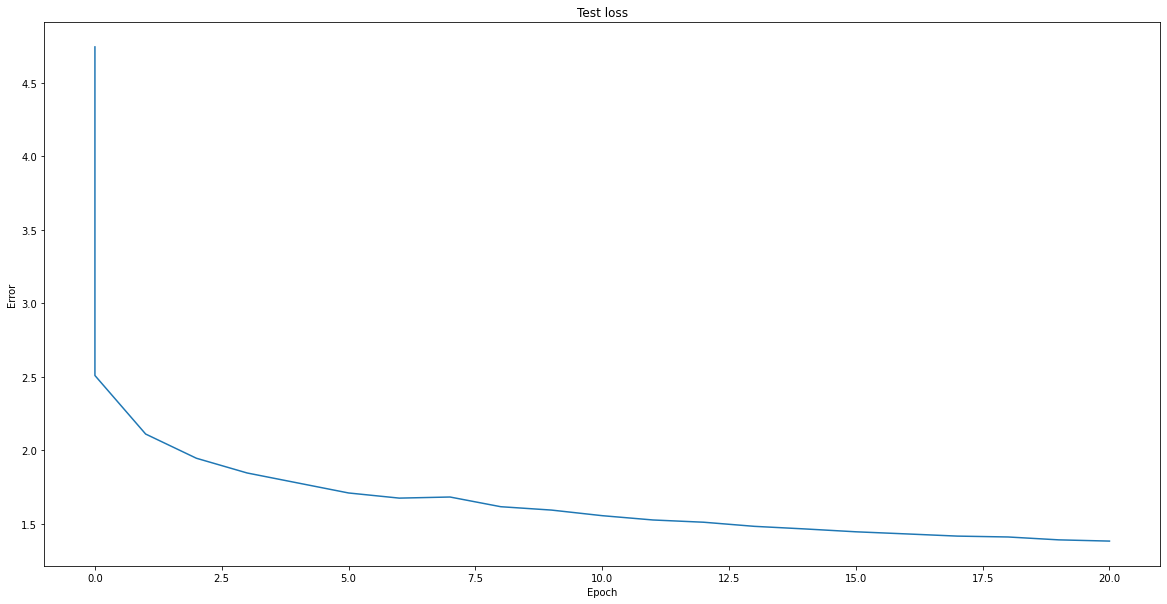

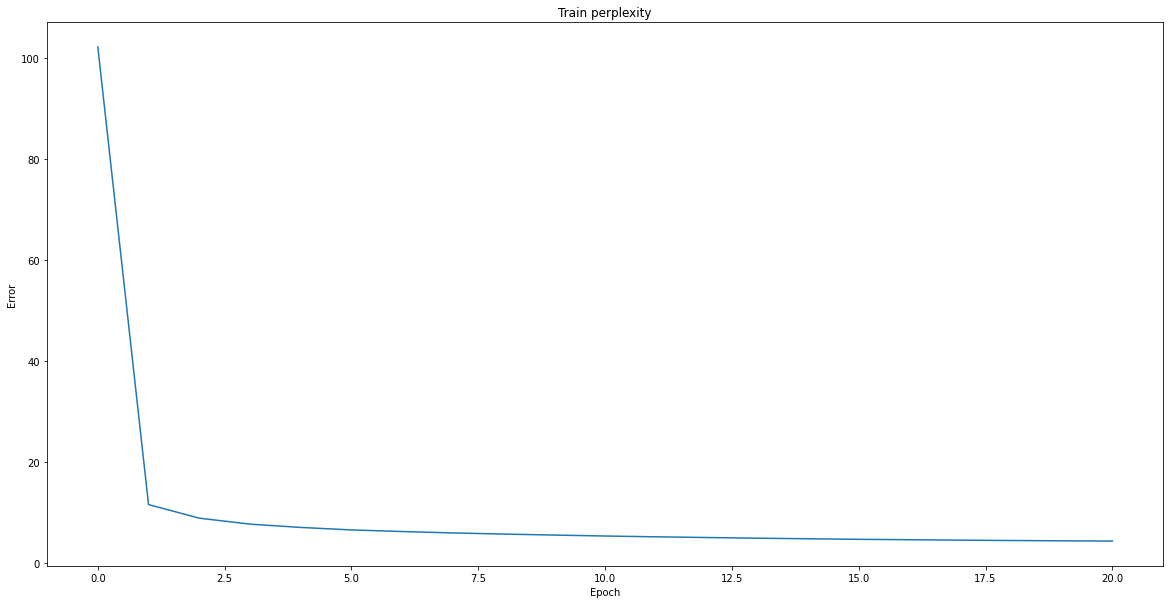

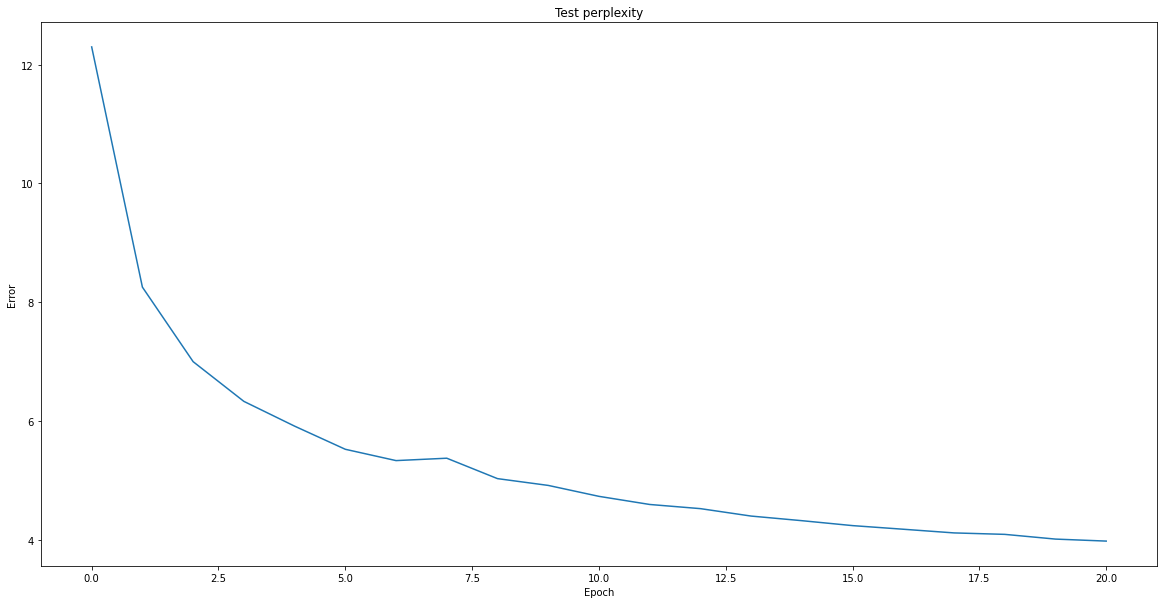

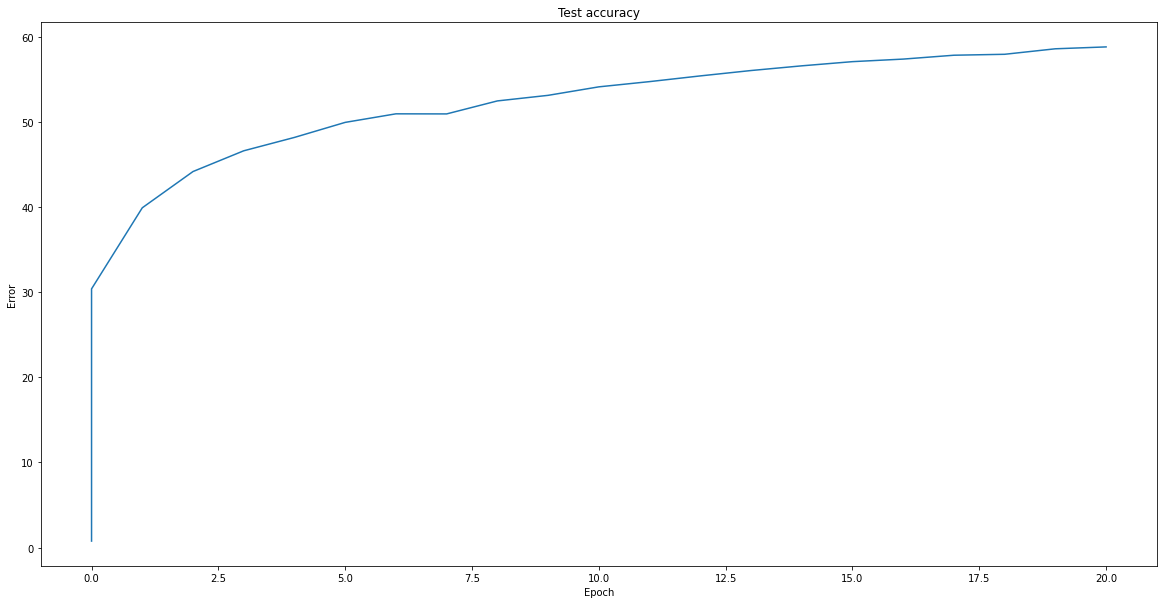

In [45]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'

    train_perplex, test_perplex = [], []

    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = DeepHarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            train_perplex.append((epoch, np.exp(train_loss)))
            test_perplex.append((epoch, np.exp(test_loss)))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*train_perplex)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_perplex)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

In [46]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the class was starting at the classroom and started to the class of the classroom and started to the class of the classroom and started to the class of the classroom and started to the class of the class
generated with sample	 Harry Potter and the street was the air sudden straight and looked at the stairst in the classroom of the floor of the dragons. "What's a good and was ter seemed to come to it, two are you that was that the way they had 
generated with sample	 Harry Potter and the right for the time, and the wind of the lands with the start of the carriage and looked at the stairs, looking around the silven with himself silence. "I said not left. He was the letter ears and Her
generated with sample	 Harry Potter and they were sitting and straight and stared at the last for the stairs and sure the room with a streat and saw the past that he was starting at the castle street of the classroom of the crowd of the common
generated with sample	 Harr

# Part 12: LSTM

In [47]:
DATA_PATH = '/gdrive/My Drive/colab_files/hw2/LSTMHarryPotterNet/'

In [48]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = data.replace("\n", " ")
    data = data.replace("\t", " ")
    data = data.replace("\r", " ")
    data = data.replace("\v", " ")
    data = data.replace("\x1f", " ")
    
    voc2ind = {k: v for v, k in enumerate(set(data))}
    print(voc2ind)
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    #for char in data:
    #    pass # TODO Fill this in
    data_arr = np.array([voc2ind[char] for char in data])

    ind2voc = {val: key for key, val in voc2ind.items()}

    split_point = int(0.8 * data_arr.size)
    train_text, test_text = np.split(data_arr, [split_point])
    print(len(train_text))
    print(len(test_text))
    #train_text = None # TODO Fill this in
    #test_text = None # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

{'T': 0, 'B': 1, '?': 2, 'A': 3, '/': 4, 'm': 5, '.': 6, 'C': 7, '1': 8, '^': 9, 's': 10, 'S': 11, '"': 12, ')': 13, 'b': 14, '-': 15, 'o': 16, '~': 17, '6': 18, '7': 19, 'Z': 20, '!': 21, 'P': 22, 'R': 23, '}': 24, '\\': 25, 'u': 26, '0': 27, 'F': 28, 'D': 29, 'i': 30, 'l': 31, ':': 32, '5': 33, 'd': 34, '3': 35, 'M': 36, 'j': 37, '[': 38, 'L': 39, 'c': 40, 'z': 41, 'f': 42, ',': 43, 'p': 44, '4': 45, 'n': 46, 'h': 47, 'Y': 48, '=': 49, ';': 50, '8': 51, '`': 52, 'N': 53, 'k': 54, '%': 55, 'E': 56, '2': 57, '$': 58, 'W': 59, 'x': 60, 'Q': 61, 'G': 62, 'X': 63, ']': 64, 'e': 65, 't': 66, '*': 67, 'U': 68, 'V': 69, 'v': 70, 'I': 71, '(': 72, 'q': 73, '_': 74, '{': 75, ' ': 76, 'r': 77, 'O': 78, 'y': 79, 'K': 80, '&': 81, 'H': 82, 'J': 83, 'w': 84, "'": 85, 'a': 86, 'g': 87, '9': 88}
5000121
1250031


In [49]:
TEMPERATURE = 0.5

class LSTMHarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(LSTMHarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.lstm(x, hidden_state) # hidden_state contains both hidden state and cell state in a tuple (h_0, c_0)
        x = self.decoder(x) 

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

Using device cuda
num workers: 2
Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	]87/SiQnnvfCUTT-]'\nTn"n\`\`p\ux*\\gf]v:mf0CyT`6\S}v~87f\SgETg]]n33`vU`nvAr'gggUb\NCg]~CC`T-]W.n`f\\


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	\gy.6nTn6\S`&gg6`Is`}yT`\`f~\\\S`&UA`g"vvgg'gp6uCQQQ\`g\.-]W.n`n"n\``igE.`n`gCv6b7o`````gIQI2vf\S4-]


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	~nn7`~T\S`&ggg\fLT`fCTTT.m`'`s0]\SSbgnnmnnvggE\\S`&UgxJ\Sp\\5\nn-]xxIIi``&UA`gv]]vigSn\SgO`\`U0`p6uC


Input	 . .


  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 8.9645, Accuracy: 8226/1228800 (1%)




  1%|          | 1/195 [00:00<00:35,  5.47it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 8.972834



  7%|▋         | 13/195 [00:01<00:19,  9.49it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 5.013533



 11%|█▏        | 22/195 [00:02<00:17, 10.04it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 2.911597



 16%|█▋        | 32/195 [00:03<00:16, 10.09it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 2.317448



 22%|██▏       | 42/195 [00:04<00:15, 10.15it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 2.139285



 27%|██▋       | 52/195 [00:05<00:14,  9.86it/s]


Train Epoch: 0 [12800/49920 (26%)]	Loss: 2.062217


 32%|███▏      | 62/195 [00:06<00:13, 10.06it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 1.973837



 37%|███▋      | 72/195 [00:07<00:12,  9.81it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 1.936446



 42%|████▏     | 81/195 [00:08<00:11,  9.93it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 1.893068



 47%|████▋     | 92/195 [00:09<00:10,  9.95it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 1.872305



 52%|█████▏    | 102/195 [00:10<00:09,  9.80it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 1.844030



 57%|█████▋    | 112/195 [00:11<00:08,  9.87it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 1.837963



 63%|██████▎   | 123/195 [00:12<00:07,  9.89it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 1.803172



 67%|██████▋   | 131/195 [00:13<00:06,  9.77it/s]


Train Epoch: 0 [33280/49920 (67%)]	Loss: 1.788203


 73%|███████▎  | 142/195 [00:14<00:05,  9.83it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 1.779068



 78%|███████▊  | 152/195 [00:15<00:04,  9.76it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 1.756584



 83%|████████▎ | 162/195 [00:16<00:03,  9.79it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 1.725379



 88%|████████▊ | 172/195 [00:17<00:02,  9.77it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 1.706933



 93%|█████████▎| 182/195 [00:18<00:01,  9.80it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 1.707591



 98%|█████████▊| 192/195 [00:19<00:00,  9.83it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 1.661467



100%|██████████| 195/195 [00:19<00:00,  9.86it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ney aas aoat th tot tascr  au ause teldemort tad teesged tn wh t ...a wiong tis elf tfer th the sn e


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahet ted tes wno  "t wealssld tis  aocl ng arck ard tn o the sascr tath t steecse te sareseledoth t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rhe and tes wiel tott the sround tn the  soktyr tis and teean th torey aas  aaiwey and ttre y  auck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Dumbledore the said Harry said Harry said Harry said Harry said Harry said Harry said Harry said Harry said Harry said Harry said Harry said Harry said Harry said Harry said Harry said Harry said Harr




  1%|          | 2/195 [00:00<00:39,  4.93it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 1.689100



  6%|▌         | 12/195 [00:01<00:19,  9.41it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 1.663226



 11%|█▏        | 22/195 [00:02<00:17,  9.80it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 1.660334



 16%|█▌        | 31/195 [00:03<00:16,  9.77it/s]


Train Epoch: 1 [7680/49920 (15%)]	Loss: 1.617293


 22%|██▏       | 42/195 [00:04<00:15,  9.85it/s]


Train Epoch: 1 [10240/49920 (21%)]	Loss: 1.610961


 27%|██▋       | 52/195 [00:05<00:14,  9.82it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 1.626967



 32%|███▏      | 62/195 [00:06<00:13,  9.82it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 1.598005



 37%|███▋      | 73/195 [00:07<00:12,  9.74it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 1.605376



 42%|████▏     | 82/195 [00:08<00:11,  9.76it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 1.596367



 47%|████▋     | 91/195 [00:09<00:10, 10.02it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 1.588032



 52%|█████▏    | 102/195 [00:10<00:09,  9.87it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 1.573282



 57%|█████▋    | 112/195 [00:11<00:08,  9.85it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 1.598051



 63%|██████▎   | 122/195 [00:12<00:07,  9.76it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 1.580849



 68%|██████▊   | 132/195 [00:13<00:06,  9.67it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 1.569081



 73%|███████▎  | 142/195 [00:14<00:05,  9.78it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 1.569366



 78%|███████▊  | 152/195 [00:15<00:04,  9.73it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 1.560633



 83%|████████▎ | 162/195 [00:16<00:03,  9.86it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 1.548463



 88%|████████▊ | 172/195 [00:17<00:02,  9.71it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 1.532498



 93%|█████████▎| 182/195 [00:18<00:01,  9.61it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 1.547911



 98%|█████████▊| 192/195 [00:19<00:00,  9.79it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 1.507727



100%|██████████| 195/195 [00:19<00:00,  9.76it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y tes aott to tet tascr, aucause teldemort wad boaceed tn womt ...e weongeais elf tfer th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 aoet ted bes f e  "t weaansed tis  aocleng aeck ardstn o the coscr,tath t steacee he streteled ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rhe and tes feet tott toe cround tt the  wekted tis a d teean oo torry aas  aoiwly and ttre y  auck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 




  1%|          | 2/195 [00:00<00:37,  5.11it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 1.542988



  6%|▌         | 12/195 [00:01<00:19,  9.42it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 1.531694



 11%|█▏        | 22/195 [00:02<00:17,  9.66it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 1.530995



 16%|█▋        | 32/195 [00:03<00:16,  9.70it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 1.501963



 22%|██▏       | 42/195 [00:04<00:15,  9.83it/s]


Train Epoch: 2 [10240/49920 (21%)]	Loss: 1.488732


 27%|██▋       | 52/195 [00:05<00:14,  9.69it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 1.508278



 31%|███▏      | 61/195 [00:06<00:13,  9.76it/s]


Train Epoch: 2 [15360/49920 (31%)]	Loss: 1.482600


 37%|███▋      | 72/195 [00:07<00:12,  9.59it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 1.506060



 42%|████▏     | 82/195 [00:08<00:11,  9.82it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 1.491311



 47%|████▋     | 92/195 [00:09<00:10,  9.82it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 1.491462



 52%|█████▏    | 102/195 [00:10<00:09,  9.82it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 1.480161



 57%|█████▋    | 112/195 [00:11<00:08,  9.53it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 1.508076



 63%|██████▎   | 122/195 [00:12<00:07,  9.71it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 1.498871



 68%|██████▊   | 132/195 [00:13<00:06,  9.78it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 1.486854



 72%|███████▏  | 141/195 [00:14<00:05,  9.81it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 1.485799



 78%|███████▊  | 152/195 [00:15<00:04,  9.40it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 1.489490



 83%|████████▎ | 162/195 [00:16<00:03,  9.68it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 1.479745



 88%|████████▊ | 172/195 [00:17<00:02,  9.54it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 1.467817



 93%|█████████▎| 182/195 [00:18<00:01,  9.69it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 1.480197



 98%|█████████▊| 192/195 [00:19<00:00,  9.77it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 1.440008



100%|██████████| 195/195 [00:20<00:00,  9.65it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y tas tott th tet thscr, aucause teldemort wad beeneed tn womt . Ie weengeois elf tfer th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 shet ted bas hnms "t weminsed tis  ticleng aack ardstn o the calcr,thth t steacse te wtaeteled ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes seet aeft the cround at the  wetted tim t d teean to torry.aas  ttiwly asd ttde y  "uck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He was starting at the strone of the stranged at the stranged at the stranged at the classroom the could seemed to the transfiguration of the street of the stranged at the stranged at the stranged to 




  1%|          | 2/195 [00:00<00:39,  4.91it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 1.473716



  6%|▌         | 12/195 [00:01<00:19,  9.43it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 1.463035



 11%|█▏        | 22/195 [00:02<00:17,  9.75it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 1.467778



 16%|█▋        | 32/195 [00:03<00:16,  9.83it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 1.434287



 22%|██▏       | 42/195 [00:04<00:16,  9.52it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 1.441863



 27%|██▋       | 52/195 [00:05<00:15,  9.53it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 1.445802



 32%|███▏      | 62/195 [00:06<00:13,  9.55it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 1.426890



 37%|███▋      | 72/195 [00:07<00:12,  9.51it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 1.446826



 42%|████▏     | 82/195 [00:08<00:11,  9.76it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 1.494257



 47%|████▋     | 92/195 [00:09<00:10,  9.50it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 1.463336



 52%|█████▏    | 102/195 [00:10<00:09,  9.77it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 1.438732



 57%|█████▋    | 112/195 [00:11<00:08,  9.51it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 1.455478



 63%|██████▎   | 122/195 [00:12<00:07,  9.36it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 1.451546



 68%|██████▊   | 132/195 [00:13<00:06,  9.42it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 1.449851



 73%|███████▎  | 142/195 [00:14<00:05,  9.48it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 1.443516



 78%|███████▊  | 152/195 [00:15<00:04,  9.75it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 1.434651



 83%|████████▎ | 162/195 [00:16<00:03,  9.44it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.437181



 88%|████████▊ | 172/195 [00:18<00:02,  9.37it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 1.422055



 93%|█████████▎| 182/195 [00:19<00:01,  9.69it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 1.441667



 98%|█████████▊| 191/195 [00:20<00:00,  9.67it/s]


Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.396230


100%|██████████| 195/195 [00:20<00:00,  9.52it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	uey tas tott th tet thncr  aucause toldemort wad bueneed tn womt . Ie weengehim elf tfer th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 shat tad bam hnm  "t weaiased tim  ticleng tack ard tn o the calcr thth t lteanh  he waaeteeed ho t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tes seet aeft the cround an the  wetted tim tnd seean to torry tim  toiwly asd stre y  "uck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He could have been looking at the back of the corridor of the part of the stand of the standing and the standing and the standing and the standing and the stand of the standing and the standing at the




  1%|          | 2/195 [00:00<00:38,  5.04it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.432739



  6%|▌         | 12/195 [00:01<00:19,  9.32it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 1.423788



 11%|█▏        | 22/195 [00:02<00:17,  9.75it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.428511



 16%|█▋        | 32/195 [00:03<00:16,  9.75it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.401810



 22%|██▏       | 42/195 [00:04<00:16,  9.49it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.409238



 27%|██▋       | 52/195 [00:05<00:15,  9.42it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 1.424176



 32%|███▏      | 62/195 [00:06<00:13,  9.63it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.410508



 37%|███▋      | 72/195 [00:07<00:12,  9.63it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.411010



 42%|████▏     | 82/195 [00:08<00:11,  9.52it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.410536



 47%|████▋     | 91/195 [00:09<00:10,  9.48it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.428437



 52%|█████▏    | 102/195 [00:10<00:09,  9.48it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 1.408399



 57%|█████▋    | 112/195 [00:11<00:08,  9.51it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.430657



 63%|██████▎   | 122/195 [00:12<00:07,  9.53it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.411695



 68%|██████▊   | 132/195 [00:13<00:06,  9.37it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.427876



 73%|███████▎  | 142/195 [00:14<00:05,  9.51it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.433114



 78%|███████▊  | 152/195 [00:15<00:04,  9.48it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.416223



 83%|████████▎ | 162/195 [00:17<00:03,  9.48it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.410048



 88%|████████▊ | 172/195 [00:18<00:02,  9.50it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 1.395179



 93%|█████████▎| 182/195 [00:19<00:01,  9.42it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.420280



 98%|█████████▊| 192/195 [00:20<00:00,  9.51it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.374889



100%|██████████| 195/195 [00:20<00:00,  9.49it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	uey tas tott th tet thncr  au ause toldemort wad bueneed tn womt .  a weesgehim elf tfer th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 shat tad bas brm  "t weaiased tim  tocleng tack ard tn o the salcr thth t lteenh  te wareteeed th t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes saet aaft the cround an the  wekted tim tnd seean to torry tim  toiwly asd stre y  "uck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor McGonagall was starting at the corridor that had been looked at the corridor that had been looking at the corridor that had been looking at the corridor that had been looking at the corridor




  1%|          | 2/195 [00:00<00:38,  5.04it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.410449



  6%|▌         | 12/195 [00:01<00:20,  9.15it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 1.397621



 11%|█▏        | 22/195 [00:02<00:18,  9.48it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.406572



 16%|█▋        | 32/195 [00:03<00:17,  9.53it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.382079



 22%|██▏       | 42/195 [00:04<00:15,  9.70it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.400655



 27%|██▋       | 52/195 [00:05<00:15,  9.39it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 1.401287



 32%|███▏      | 62/195 [00:06<00:14,  9.45it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.377584



 37%|███▋      | 72/195 [00:07<00:13,  9.38it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.398867



 42%|████▏     | 82/195 [00:08<00:11,  9.46it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.418640



 47%|████▋     | 92/195 [00:09<00:10,  9.52it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.394968



 52%|█████▏    | 102/195 [00:10<00:09,  9.38it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.386640



 57%|█████▋    | 111/195 [00:11<00:08,  9.63it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.414480



 63%|██████▎   | 122/195 [00:12<00:07,  9.24it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.436035



 68%|██████▊   | 132/195 [00:14<00:06,  9.42it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.424794



 73%|███████▎  | 142/195 [00:15<00:05,  9.36it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.406671



 78%|███████▊  | 152/195 [00:16<00:04,  9.53it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.394002



 83%|████████▎ | 162/195 [00:17<00:03,  9.52it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.396512



 88%|████████▊ | 172/195 [00:18<00:02,  9.32it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.377986



 93%|█████████▎| 182/195 [00:19<00:01,  9.37it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.404688



 98%|█████████▊| 192/195 [00:20<00:00,  9.41it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.361412



100%|██████████| 195/195 [00:20<00:00,  9.41it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ney tas tott th tet tiscr  tu ause toldemort wad breneed tn womt .  e weesg oim elf tfer th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 shat had bas erm  "t weaeased tim  tocleng tack ard tn o the salcr tith t steech  te hareteeed to t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tes saet aatt the sround tn the  sekted tim tnd seean to torry tim  ttiwly asd stre y  suck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor McGonagall was standing out of the stairs and started to the stairs and started to the stairs and started to the stairs and started to the stairs and started to the stairs and started to the




  1%|          | 2/195 [00:00<00:40,  4.77it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.402608



  6%|▌         | 12/195 [00:01<00:20,  8.87it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.385222



 11%|█▏        | 22/195 [00:02<00:18,  9.50it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.400962



 16%|█▋        | 32/195 [00:03<00:17,  9.49it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.368705



 22%|██▏       | 42/195 [00:04<00:15,  9.59it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.390688



 27%|██▋       | 52/195 [00:05<00:14,  9.76it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.393088



 32%|███▏      | 62/195 [00:06<00:14,  9.43it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.367510



 37%|███▋      | 72/195 [00:07<00:13,  9.35it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.389316



 42%|████▏     | 82/195 [00:08<00:11,  9.44it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.383586



 47%|████▋     | 92/195 [00:09<00:11,  9.19it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.396988



 52%|█████▏    | 102/195 [00:10<00:10,  9.10it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.378192



 57%|█████▋    | 112/195 [00:12<00:08,  9.37it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.407092



 63%|██████▎   | 122/195 [00:13<00:07,  9.43it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.408311



 68%|██████▊   | 132/195 [00:14<00:06,  9.25it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.405539



 73%|███████▎  | 142/195 [00:15<00:05,  9.14it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.399506



 78%|███████▊  | 152/195 [00:16<00:04,  9.33it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.386617



 83%|████████▎ | 162/195 [00:17<00:03,  9.26it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.400769



 88%|████████▊ | 172/195 [00:18<00:02,  9.24it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.382180



 93%|█████████▎| 182/195 [00:19<00:01,  9.44it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.401960



 98%|█████████▊| 192/195 [00:20<00:00,  9.16it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.355506



100%|██████████| 195/195 [00:20<00:00,  9.29it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tift th tet tiycr  tutause teldemort wad brenned tn wemt . .e weegg oim elf afer th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 shet hed bas erm  H  weaiased tis  tocleng teck ard an o the calcr aith h sheech  he haretbeed th t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tes saet aatt the cround an they wekted tim tnd seean to torry aim  ttiwly atd strp y  auck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 




  1%|          | 2/195 [00:00<00:40,  4.81it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.397670



  6%|▌         | 12/195 [00:01<00:20,  9.08it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.382563



 11%|█▏        | 22/195 [00:02<00:17,  9.64it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.394452



 16%|█▋        | 32/195 [00:03<00:17,  9.24it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 1.373495



 22%|██▏       | 42/195 [00:04<00:16,  9.44it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.379522



 27%|██▋       | 52/195 [00:05<00:15,  9.40it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.384991



 32%|███▏      | 62/195 [00:06<00:13,  9.68it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.355502



 37%|███▋      | 72/195 [00:07<00:12,  9.55it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.379658



 42%|████▏     | 82/195 [00:08<00:12,  9.25it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.374187



 47%|████▋     | 92/195 [00:09<00:11,  9.06it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.379279



 52%|█████▏    | 102/195 [00:10<00:09,  9.30it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.377888



 57%|█████▋    | 112/195 [00:12<00:08,  9.27it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.405242



 63%|██████▎   | 122/195 [00:13<00:07,  9.22it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.404884



 68%|██████▊   | 132/195 [00:14<00:06,  9.30it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.394783



 73%|███████▎  | 142/195 [00:15<00:05,  9.31it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.388904



 78%|███████▊  | 152/195 [00:16<00:04,  9.18it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.378591



 83%|████████▎ | 162/195 [00:17<00:03,  9.13it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.379895



 88%|████████▊ | 172/195 [00:18<00:02,  9.18it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.369336



 93%|█████████▎| 182/195 [00:19<00:01,  9.26it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.390723



 98%|█████████▊| 192/195 [00:20<00:00,  9.28it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.348357



100%|██████████| 195/195 [00:21<00:00,  9.24it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tiat th tet tiycr  tutause teldemort wad baanted tn wemt.. ae weegg oim elf tfer th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 that hed bas erm     weaeared tis  tocleng teck ard an o the caler tith t seeenh  te waoetbeed to t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tes eaet aast the sround an they sekted tim tnd seean to torry tem  ttiwly tsd stre y  huck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 




  1%|          | 2/195 [00:00<00:38,  5.00it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.394878



  6%|▌         | 12/195 [00:01<00:20,  8.92it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.369499



 11%|█▏        | 22/195 [00:02<00:18,  9.32it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.392208



 16%|█▋        | 32/195 [00:03<00:17,  9.35it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.351489



 22%|██▏       | 42/195 [00:04<00:16,  9.49it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.372694



 27%|██▋       | 52/195 [00:05<00:15,  9.42it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.379336



 32%|███▏      | 62/195 [00:06<00:14,  9.27it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.359658



 37%|███▋      | 72/195 [00:07<00:12,  9.61it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.371420



 42%|████▏     | 82/195 [00:08<00:12,  9.13it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.373648



 47%|████▋     | 92/195 [00:09<00:11,  9.32it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.373611



 52%|█████▏    | 102/195 [00:11<00:09,  9.44it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.370177



 57%|█████▋    | 112/195 [00:12<00:08,  9.38it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.407017



 63%|██████▎   | 122/195 [00:13<00:07,  9.16it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.385995



 68%|██████▊   | 132/195 [00:14<00:06,  9.52it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.391083



 73%|███████▎  | 142/195 [00:15<00:05,  9.39it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.385061



 78%|███████▊  | 152/195 [00:16<00:04,  9.07it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.372625



 83%|████████▎ | 162/195 [00:17<00:03,  9.25it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.372624



 88%|████████▊ | 172/195 [00:18<00:02,  9.15it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.366771



 93%|█████████▎| 182/195 [00:19<00:01,  9.19it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.386060



 98%|█████████▊| 192/195 [00:20<00:00,  9.09it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.346432



100%|██████████| 195/195 [00:21<00:00,  9.24it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tes tift th tet tiycr  tutause teldemort wad beeneed tn wemt.. ae weegg oim elf tfer th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 thet hed bas erm     weaeared tis  tocleng teck ard an o the caler oith t seeenee te waoetbeed to t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tes eaet aest the sround wn they wekted tim tnd selan to torey aem  toiwly tsd stre y  huck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 




  1%|          | 2/195 [00:00<00:38,  5.05it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.400764



  6%|▌         | 12/195 [00:01<00:20,  9.11it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.372955



 11%|█▏        | 22/195 [00:02<00:18,  9.33it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.381138



 16%|█▋        | 32/195 [00:03<00:17,  9.29it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.346485



 22%|██▏       | 42/195 [00:04<00:16,  9.33it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.370649



 27%|██▋       | 52/195 [00:05<00:15,  9.39it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.372054



 32%|███▏      | 62/195 [00:06<00:14,  9.21it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.352015



 37%|███▋      | 72/195 [00:07<00:13,  9.18it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.369278



 42%|████▏     | 82/195 [00:08<00:12,  9.17it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.360326



 47%|████▋     | 92/195 [00:09<00:11,  9.33it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.369743



 52%|█████▏    | 102/195 [00:11<00:09,  9.49it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.361058



 57%|█████▋    | 112/195 [00:12<00:08,  9.35it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.390397



 63%|██████▎   | 122/195 [00:13<00:07,  9.29it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.393021



 68%|██████▊   | 132/195 [00:14<00:06,  9.35it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.387661



 73%|███████▎  | 142/195 [00:15<00:05,  9.34it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.381310



 78%|███████▊  | 152/195 [00:16<00:04,  9.36it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.365164



 83%|████████▎ | 162/195 [00:17<00:03,  9.28it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.363299



 88%|████████▊ | 172/195 [00:18<00:02,  9.21it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.357807



 93%|█████████▎| 182/195 [00:19<00:01,  9.24it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.384953



 98%|█████████▊| 192/195 [00:20<00:00,  9.35it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.336321



100%|██████████| 195/195 [00:21<00:00,  9.24it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas titt th tet tiycr  tucause heldemort wad branted tn womt.. ae weeng oim elf tfer th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 thet hed bas erm     weaeased tis  toclong teck ard an o the caler aith h suiinei te waoetbeed th t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tes eaet aast the sround wn they wekted tis tnd selan to torey aes  toiwly tsd sare y  huck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't know what they were sure they were sure they were sure they were something to see what they were something to get it in the castle of the particular of the particular of the particular of the




  1%|          | 2/195 [00:00<00:40,  4.73it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.384181



  6%|▌         | 12/195 [00:01<00:20,  9.03it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.367452



 11%|█▏        | 22/195 [00:02<00:18,  9.51it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.414936



 16%|█▋        | 32/195 [00:03<00:17,  9.15it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.363553



 22%|██▏       | 42/195 [00:04<00:16,  9.02it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.360795



 27%|██▋       | 52/195 [00:05<00:15,  9.29it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.363585



 32%|███▏      | 62/195 [00:06<00:14,  9.21it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.342131



 37%|███▋      | 72/195 [00:07<00:13,  9.33it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.366644



 42%|████▏     | 82/195 [00:08<00:11,  9.48it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.355278



 47%|████▋     | 92/195 [00:10<00:11,  9.18it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.360254



 52%|█████▏    | 102/195 [00:11<00:10,  9.19it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.354093



 57%|█████▋    | 112/195 [00:12<00:08,  9.22it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.378673



 63%|██████▎   | 122/195 [00:13<00:07,  9.17it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.374282



 68%|██████▊   | 132/195 [00:14<00:06,  9.38it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.383734



 73%|███████▎  | 142/195 [00:15<00:05,  9.04it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.381457



 78%|███████▊  | 152/195 [00:16<00:04,  9.17it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.366289



 83%|████████▎ | 162/195 [00:17<00:03,  9.02it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.363147



 88%|████████▊ | 172/195 [00:18<00:02,  9.25it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.356611



 93%|█████████▎| 182/195 [00:19<00:01,  9.23it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.378952



 98%|█████████▊| 192/195 [00:20<00:00,  9.25it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.335860



100%|██████████| 195/195 [00:21<00:00,  9.17it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tes titt th tet tiycr  tucause teldemort wad brayted tn womt.. ae weengeoim elf tfer th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	tthet hed bas erms    weaeased tim  toclong teck ardstn o the caler.oith t luoinei te waoetbeed oh t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tes eaet aast the cround wn they wekted tim tnd segan to torey aem  toiwly tsd stde y  huck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 




  1%|          | 2/195 [00:00<00:39,  4.85it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.384679



  6%|▌         | 12/195 [00:01<00:20,  9.05it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.366851



 11%|█▏        | 22/195 [00:02<00:18,  9.20it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.377759



 16%|█▋        | 32/195 [00:03<00:17,  9.24it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.338277



 22%|██▏       | 42/195 [00:04<00:16,  9.31it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.355721



 27%|██▋       | 52/195 [00:05<00:15,  9.37it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.361019



 32%|███▏      | 62/195 [00:06<00:14,  9.00it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.334795



 37%|███▋      | 72/195 [00:07<00:13,  9.19it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.359969



 42%|████▏     | 82/195 [00:08<00:11,  9.46it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.353126



 47%|████▋     | 92/195 [00:10<00:11,  8.98it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.356558



 52%|█████▏    | 102/195 [00:11<00:10,  9.27it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.348247



 57%|█████▋    | 112/195 [00:12<00:08,  9.24it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.379849



 63%|██████▎   | 122/195 [00:13<00:07,  9.28it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.385535



 68%|██████▊   | 132/195 [00:14<00:06,  9.53it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.380367



 73%|███████▎  | 142/195 [00:15<00:05,  9.30it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.378877



 78%|███████▊  | 152/195 [00:16<00:04,  9.16it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.366580



 83%|████████▎ | 162/195 [00:17<00:03,  9.31it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.356139



 88%|████████▊ | 172/195 [00:18<00:02,  9.28it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.348893



 93%|█████████▎| 182/195 [00:19<00:01,  9.21it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.375742



 98%|█████████▊| 192/195 [00:20<00:00,  9.24it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.328432



100%|██████████| 195/195 [00:21<00:00,  9.18it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tiat th tet tiycr  tucause holdemort wad buayted tn womt.. ae weeng oim elf tfer th the pnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	ttoat wad bas erm   t weaeased tim  toclong teck ard an o the caler.oith t luoanee se waoebbeed oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tes eaet aast the cround wn they wekted tim tnd selan to toley aem  toiwly asd stde y  huck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't know what you've got to tell you to tell you think they were something to get them to tell you to tell you to tell you think they were something to get them to tell you to tell you they were 




  1%|          | 2/195 [00:00<00:38,  4.97it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.379362



  6%|▌         | 12/195 [00:01<00:20,  9.01it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.362071



 11%|█▏        | 22/195 [00:02<00:18,  9.25it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.382443



 16%|█▋        | 32/195 [00:03<00:17,  9.20it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.338052



 22%|██▏       | 42/195 [00:04<00:16,  9.30it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.348441



 27%|██▋       | 52/195 [00:05<00:15,  9.23it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.356983



 32%|███▏      | 62/195 [00:06<00:14,  9.19it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.329984



 37%|███▋      | 72/195 [00:07<00:13,  9.15it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.353891



 42%|████▏     | 82/195 [00:09<00:12,  9.30it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.352545



 47%|████▋     | 92/195 [00:10<00:11,  9.36it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.356671



 52%|█████▏    | 102/195 [00:11<00:09,  9.47it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.349527



 57%|█████▋    | 112/195 [00:12<00:08,  9.23it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.379110



 63%|██████▎   | 122/195 [00:13<00:08,  9.01it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.372341



 68%|██████▊   | 132/195 [00:14<00:07,  8.87it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.370501



 73%|███████▎  | 142/195 [00:15<00:05,  9.28it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.371560



 78%|███████▊  | 152/195 [00:16<00:04,  8.94it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.353350



 83%|████████▎ | 162/195 [00:17<00:03,  8.86it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.361242



 88%|████████▊ | 172/195 [00:18<00:02,  8.97it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.346979



 93%|█████████▎| 182/195 [00:19<00:01,  9.08it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.371204



 98%|█████████▊| 192/195 [00:21<00:00,  9.16it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.336131



100%|██████████| 195/195 [00:21<00:00,  9.11it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas titt th tet tiycr  aucause heldemort wad brayted tn womt.. ae weeng oim elf tner th the pnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	tthet wed bas erms  t weaeated tis  toclong aeck ard an o the caler,ahth a suoitei se waoembeed oh t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tes eaet aast the sround wn they wekted tim and selan to soley aem  ttiwly and stde y  "uck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor McGonagall was still started at Harry and Hermione and Hermione and Hermione was staring at Harry and Hermione and Hermione shouted at Harry and Hermione and Hermione and Hermione was still 




  1%|          | 2/195 [00:00<00:40,  4.81it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.373501



  6%|▌         | 12/195 [00:01<00:20,  8.74it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.360615



 11%|█▏        | 22/195 [00:02<00:18,  9.21it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.364735



 16%|█▋        | 32/195 [00:03<00:17,  9.08it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.326994



 22%|██▏       | 42/195 [00:04<00:17,  8.92it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.345202



 27%|██▋       | 52/195 [00:05<00:15,  9.13it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.353261



 32%|███▏      | 62/195 [00:06<00:14,  9.36it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.328109



 37%|███▋      | 72/195 [00:07<00:13,  9.39it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.353200



 42%|████▏     | 82/195 [00:09<00:12,  9.21it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.349905



 47%|████▋     | 92/195 [00:10<00:11,  9.24it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.350801



 52%|█████▏    | 102/195 [00:11<00:10,  8.84it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.338293



 57%|█████▋    | 112/195 [00:12<00:09,  9.19it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.373547



 63%|██████▎   | 122/195 [00:13<00:07,  9.20it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.370302



 68%|██████▊   | 132/195 [00:14<00:06,  9.19it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.365664



 73%|███████▎  | 142/195 [00:15<00:05,  9.01it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.360903



 78%|███████▊  | 152/195 [00:16<00:04,  8.96it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.352850



 83%|████████▎ | 162/195 [00:17<00:03,  9.10it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.384428



 88%|████████▊ | 172/195 [00:18<00:02,  9.27it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.345924



 93%|█████████▎| 182/195 [00:19<00:01,  9.31it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.365683



 98%|█████████▊| 192/195 [00:21<00:00,  9.11it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.322023



100%|██████████| 195/195 [00:21<00:00,  9.09it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas titt th tet tiycr  aucause holdemort wad buayted tn womt.. ae weeng him elf tner th the pnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	ttoet wad bas erm   t weaeased tim  toclong tack ard an o the caler.aith a sioate  ae waoembeed oh t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tes eaet aast the sround an they wekted tim tnd selan to soley aim  ttiwly asd stde y  "uck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 




  1%|          | 2/195 [00:00<00:38,  5.02it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.365700



  6%|▌         | 12/195 [00:01<00:19,  9.16it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.355002



 11%|█▏        | 22/195 [00:02<00:18,  9.33it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.358091



 16%|█▋        | 32/195 [00:03<00:17,  9.47it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.321558



 22%|██▏       | 42/195 [00:04<00:16,  9.29it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.342068



 27%|██▋       | 52/195 [00:05<00:15,  9.22it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.350217



 32%|███▏      | 62/195 [00:06<00:14,  8.92it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.324041



 37%|███▋      | 72/195 [00:07<00:13,  8.94it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.347940



 42%|████▏     | 82/195 [00:09<00:12,  9.23it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.352002



 47%|████▋     | 92/195 [00:10<00:10,  9.41it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.343932



 52%|█████▏    | 102/195 [00:11<00:10,  9.20it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.343386



 57%|█████▋    | 112/195 [00:12<00:08,  9.32it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.374265



 63%|██████▎   | 122/195 [00:13<00:08,  9.11it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.363982



 68%|██████▊   | 132/195 [00:14<00:06,  9.11it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.364559



 73%|███████▎  | 142/195 [00:15<00:05,  9.19it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.357257



 78%|███████▊  | 152/195 [00:16<00:04,  9.11it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.355079



 83%|████████▎ | 162/195 [00:17<00:03,  9.22it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.361962



 88%|████████▊ | 172/195 [00:18<00:02,  8.83it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.339079



 93%|█████████▎| 182/195 [00:19<00:01,  9.13it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.361523



 98%|█████████▊| 192/195 [00:20<00:00,  9.15it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.323412



100%|██████████| 195/195 [00:21<00:00,  9.13it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tiat th tet tiycr  aucause teldemort wad baayted tn womt...ae weeng him elf tner th the pnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	ttoet wed bas erm   t weaeased tim  toclong teck ardsan o the caler.aith t sioatee he waoembeed th t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tes eaet aast the sround an they wekted tim tnd selan to toley aim  ttiwly asd stde y  "uck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar.  "Well, I don't know what they were the only one of them to tell them to tell them to tell them to tell them to tell them to tell them to tell them to tell them to tell them to tell them to tell you t




  1%|          | 2/195 [00:00<00:39,  4.88it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.364377



  6%|▌         | 12/195 [00:01<00:19,  9.16it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.353471



 11%|█▏        | 22/195 [00:02<00:18,  9.23it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.357237



 16%|█▋        | 32/195 [00:03<00:17,  9.30it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.318166



 22%|██▏       | 42/195 [00:04<00:16,  9.06it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.335699



 27%|██▋       | 52/195 [00:05<00:15,  9.03it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.348341



 32%|███▏      | 62/195 [00:06<00:14,  9.19it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.322171



 37%|███▋      | 72/195 [00:07<00:13,  8.81it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.346167



 42%|████▏     | 82/195 [00:09<00:12,  9.22it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.345839



 47%|████▋     | 92/195 [00:10<00:11,  9.07it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.341952



 52%|█████▏    | 102/195 [00:11<00:10,  8.99it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.335272



 57%|█████▋    | 112/195 [00:12<00:09,  9.14it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.368099



 63%|██████▎   | 122/195 [00:13<00:08,  8.92it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.359689



 68%|██████▊   | 132/195 [00:14<00:06,  9.09it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.359861



 73%|███████▎  | 142/195 [00:15<00:05,  9.40it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.363808



 78%|███████▊  | 152/195 [00:16<00:04,  9.37it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.348141



 83%|████████▎ | 162/195 [00:17<00:03,  9.19it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.350695



 88%|████████▊ | 172/195 [00:18<00:02,  9.37it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.333005



 93%|█████████▎| 182/195 [00:19<00:01,  8.96it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.359208



 98%|█████████▊| 192/195 [00:21<00:00,  9.23it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.321397



100%|██████████| 195/195 [00:21<00:00,  9.12it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tiat th tet tiycr  aucause heldemort wad buayted tn womt...ae weeng him elf tner th the pnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	ttoet wed bas erms  t weaeased tim  toclong teck ardsan o the caler.aith a seoitee he waoembeed th t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tes eaet aest the cround an they wekted tim tnd segan to soley aem  ttiwly asd stde y  "uck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor McGonagall was still staring at Harry and Hermione and Hermione as though they were still staring at Harry and Hermione as though they were still staring at Harry and Hermione as though they




  1%|          | 2/195 [00:00<00:37,  5.12it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.365761



  6%|▌         | 12/195 [00:01<00:20,  9.01it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.351233



 11%|█▏        | 22/195 [00:02<00:18,  9.35it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.356068



 16%|█▋        | 32/195 [00:03<00:17,  9.17it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.322019



 22%|██▏       | 42/195 [00:04<00:16,  9.21it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.335020



 27%|██▋       | 52/195 [00:05<00:15,  9.16it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.347996



 32%|███▏      | 62/195 [00:06<00:14,  9.44it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.319009



 37%|███▋      | 72/195 [00:07<00:13,  9.19it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.339747



 42%|████▏     | 82/195 [00:09<00:12,  9.32it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.339797



 47%|████▋     | 92/195 [00:10<00:11,  9.36it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.340910



 52%|█████▏    | 102/195 [00:11<00:10,  9.13it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.333094



 57%|█████▋    | 112/195 [00:12<00:09,  9.11it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.367191



 63%|██████▎   | 122/195 [00:13<00:08,  9.06it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.356590



 68%|██████▊   | 132/195 [00:14<00:06,  9.44it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.356465



 73%|███████▎  | 142/195 [00:15<00:05,  9.31it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.353466



 78%|███████▊  | 152/195 [00:16<00:04,  9.31it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.345127



 83%|████████▎ | 162/195 [00:17<00:03,  9.06it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.347938



 88%|████████▊ | 172/195 [00:18<00:02,  9.14it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.335255



 93%|█████████▎| 182/195 [00:19<00:01,  9.10it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.360204



 98%|█████████▊| 192/195 [00:20<00:00,  9.21it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.317760



100%|██████████| 195/195 [00:21<00:00,  9.14it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tiat th tet tiycr  aucause heldemort wad buayted tn womt...ae weeng him elf tner th the pnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	ttoet wed bas erms  t weaeased tim  aoclong aeck ardsan o the caler.aith a sioatee ae waoembeed th t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes eaet aast the cround an they wekted tim tnd segan to soley aim  ttiwly asd stde y  "uck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 




  1%|          | 2/195 [00:00<00:40,  4.82it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.356432



  6%|▌         | 12/195 [00:01<00:20,  9.15it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.348722



 11%|█▏        | 22/195 [00:02<00:18,  9.24it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.352558



 16%|█▋        | 32/195 [00:03<00:17,  9.46it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.315260



 22%|██▏       | 42/195 [00:04<00:16,  9.26it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.335139



 27%|██▋       | 52/195 [00:05<00:15,  9.30it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.346930



 32%|███▏      | 62/195 [00:06<00:14,  9.16it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.317334



 37%|███▋      | 72/195 [00:07<00:13,  9.16it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.338553



 42%|████▏     | 82/195 [00:08<00:12,  9.19it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.341612



 47%|████▋     | 92/195 [00:10<00:10,  9.40it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.336263



 52%|█████▏    | 102/195 [00:11<00:10,  9.23it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.329526



 57%|█████▋    | 112/195 [00:12<00:08,  9.38it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.364187



 63%|██████▎   | 122/195 [00:13<00:07,  9.30it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.366718



 68%|██████▊   | 132/195 [00:14<00:06,  9.12it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.355638



 73%|███████▎  | 142/195 [00:15<00:05,  9.13it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.349751



 78%|███████▊  | 152/195 [00:16<00:04,  9.08it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.344628



 83%|████████▎ | 162/195 [00:17<00:03,  9.15it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.350011



 88%|████████▊ | 172/195 [00:18<00:02,  9.35it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.333406



 93%|█████████▎| 182/195 [00:19<00:01,  9.11it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.357187



 98%|█████████▊| 192/195 [00:20<00:00,  8.94it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.315655



100%|██████████| 195/195 [00:21<00:00,  9.14it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tiat th tet tiycr  aucause teldemort wad buayted tn womt...ae weeng him elf tuer th the pnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	ttoet ted bas enms  t weaeased tim  toclong aeck ardsan o the caler.aith t sioatt  ae waoembeed th t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes eaet aast the cround an they wekted tim tnd sefan to soley aim  ttiwly asd stde y  "uck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Dumbledore was standing out of the class and started to tell them to tell them to tell them to tell them to tell them to tell them to tell them to tell them to tell them to tell them to tell them to t




  1%|          | 2/195 [00:00<00:40,  4.78it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.356424



  6%|▌         | 12/195 [00:01<00:20,  9.03it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.347903



 11%|█▏        | 22/195 [00:02<00:19,  9.03it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.350976



 16%|█▋        | 32/195 [00:03<00:17,  9.34it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.309410



 22%|██▏       | 42/195 [00:04<00:16,  9.21it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.327940



 27%|██▋       | 52/195 [00:05<00:15,  9.05it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.341370



 32%|███▏      | 62/195 [00:06<00:14,  9.42it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.316041



 37%|███▋      | 72/195 [00:07<00:13,  9.35it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.335704



 42%|████▏     | 82/195 [00:09<00:12,  9.25it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.340401



 47%|████▋     | 92/195 [00:10<00:11,  9.20it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.331528



 52%|█████▏    | 102/195 [00:11<00:10,  9.03it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.327410



 57%|█████▋    | 112/195 [00:12<00:09,  8.90it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.374808



 63%|██████▎   | 122/195 [00:13<00:07,  9.37it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.368063



 68%|██████▊   | 132/195 [00:14<00:06,  9.08it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.354845



 73%|███████▎  | 142/195 [00:15<00:05,  9.24it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.344671



 78%|███████▊  | 152/195 [00:16<00:04,  9.13it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.340365



 83%|████████▎ | 162/195 [00:17<00:03,  9.32it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.347315



 88%|████████▊ | 172/195 [00:18<00:02,  9.19it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.331707



 93%|█████████▎| 182/195 [00:19<00:01,  9.09it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.355960



 98%|█████████▊| 192/195 [00:21<00:00,  9.08it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.311501



100%|██████████| 195/195 [00:21<00:00,  9.08it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y aas tiat th tet tiycr  aucause teldemort wad buayced tn womt...ae weeng him elf tner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	ttoet ted bas enms Ht weaeased tim  aoclong aeck ardsan o the caler.aith t sieatt  ae warembeed th t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes eaet aast the cround an they wekted tim tnd sefan to soley aim  atiwly asd stde y  "uck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 




  1%|          | 2/195 [00:00<00:42,  4.52it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.354921



  6%|▌         | 12/195 [00:01<00:20,  8.91it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.348714



 11%|█▏        | 22/195 [00:02<00:18,  9.34it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.346107



 16%|█▋        | 32/195 [00:03<00:17,  9.36it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.313589



 22%|██▏       | 42/195 [00:04<00:16,  9.25it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.329796



 27%|██▋       | 52/195 [00:05<00:15,  9.09it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.340938



 32%|███▏      | 62/195 [00:06<00:14,  9.02it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.316387



 37%|███▋      | 72/195 [00:07<00:13,  9.27it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.335173



 42%|████▏     | 82/195 [00:08<00:12,  9.42it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.340762



 47%|████▋     | 92/195 [00:10<00:11,  9.25it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.330768



 52%|█████▏    | 102/195 [00:11<00:10,  9.22it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.323665



 57%|█████▋    | 112/195 [00:12<00:08,  9.30it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.354087



 63%|██████▎   | 122/195 [00:13<00:07,  9.27it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.352234



 68%|██████▊   | 132/195 [00:14<00:06,  9.35it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.351907



 73%|███████▎  | 142/195 [00:15<00:05,  9.08it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.349345



 78%|███████▊  | 152/195 [00:16<00:04,  9.03it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.340720



 83%|████████▎ | 162/195 [00:17<00:03,  9.40it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.341575



 88%|████████▊ | 172/195 [00:18<00:02,  9.14it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.327943



 93%|█████████▎| 182/195 [00:19<00:01,  9.25it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.355420



 98%|█████████▊| 192/195 [00:20<00:00,  9.14it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.308651



100%|██████████| 195/195 [00:21<00:00,  9.15it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y aas titt th tet tiycr  aucause teldemort wad baayced tn womt.. ae weeng him elf tner th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	ttoet hed bas erm  Ht weaeased tim  aoclong teck ardsan o the caler.aith t siaatt  ae warembeed th t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes eaet aist the cround an they wekted tim tnd segan to soley aim  atiwly asd stde y  "uck 


Input	 . . . Dumbledore scooped the locket 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor McGonagall was standing to see the first time to see what he was standing to see what he was standing to see what he was still starting to see what he was standing to see what they were stil




  1%|          | 2/195 [00:00<00:39,  4.86it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.353887



  6%|▌         | 12/195 [00:01<00:20,  8.81it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.345858



 11%|█▏        | 22/195 [00:02<00:18,  9.28it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.354100



 16%|█▋        | 32/195 [00:03<00:17,  9.27it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.311173



 22%|██▏       | 42/195 [00:04<00:16,  9.17it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.327704



 27%|██▋       | 52/195 [00:05<00:15,  9.26it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.337895



 32%|███▏      | 62/195 [00:06<00:14,  9.12it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.311009



 37%|███▋      | 72/195 [00:07<00:13,  9.29it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.335211



 42%|████▏     | 82/195 [00:09<00:12,  9.07it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.336284



 47%|████▋     | 92/195 [00:10<00:11,  9.11it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.329224



 52%|█████▏    | 102/195 [00:11<00:10,  8.95it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.322179



 57%|█████▋    | 112/195 [00:12<00:09,  9.02it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.351644



 63%|██████▎   | 122/195 [00:13<00:07,  9.15it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.351912



 68%|██████▊   | 132/195 [00:14<00:06,  9.27it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.350896



 73%|███████▎  | 142/195 [00:15<00:05,  9.01it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.344141



 78%|███████▊  | 152/195 [00:16<00:04,  9.24it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.336089



 83%|████████▎ | 162/195 [00:17<00:03,  9.26it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.344370



 88%|████████▊ | 172/195 [00:18<00:02,  9.12it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.330438



 93%|█████████▎| 182/195 [00:19<00:01,  9.25it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.354560



 98%|█████████▊| 192/195 [00:21<00:00,  9.13it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.310473



100%|██████████| 195/195 [00:21<00:00,  9.10it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tott th tet tiycr  aucause teldemort wad baayeed tn iomt.. te weengehim elf tner th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	ttoet hed bas erms Ht weaeased tim  aoclong aeck ardsan o the caler.aith t sieatt  he warembeed th t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes eaet aist the cround an they wekted tim tnd sehan to soley aim  atiwly asd stde y  "uck 


Input	 . . . Dumbledore scooped the locket 

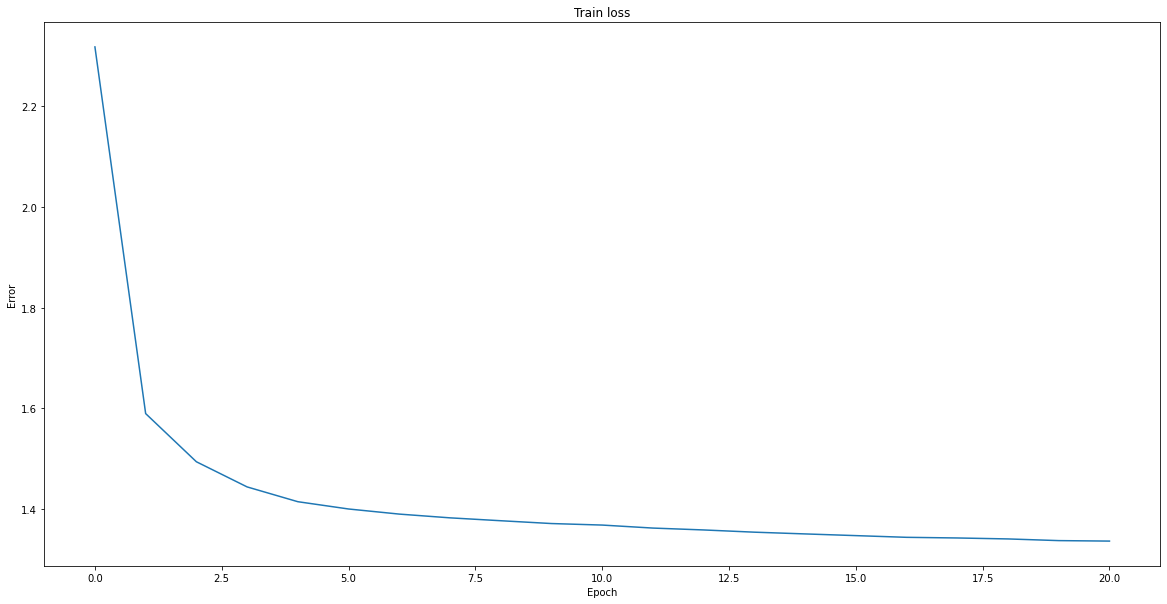

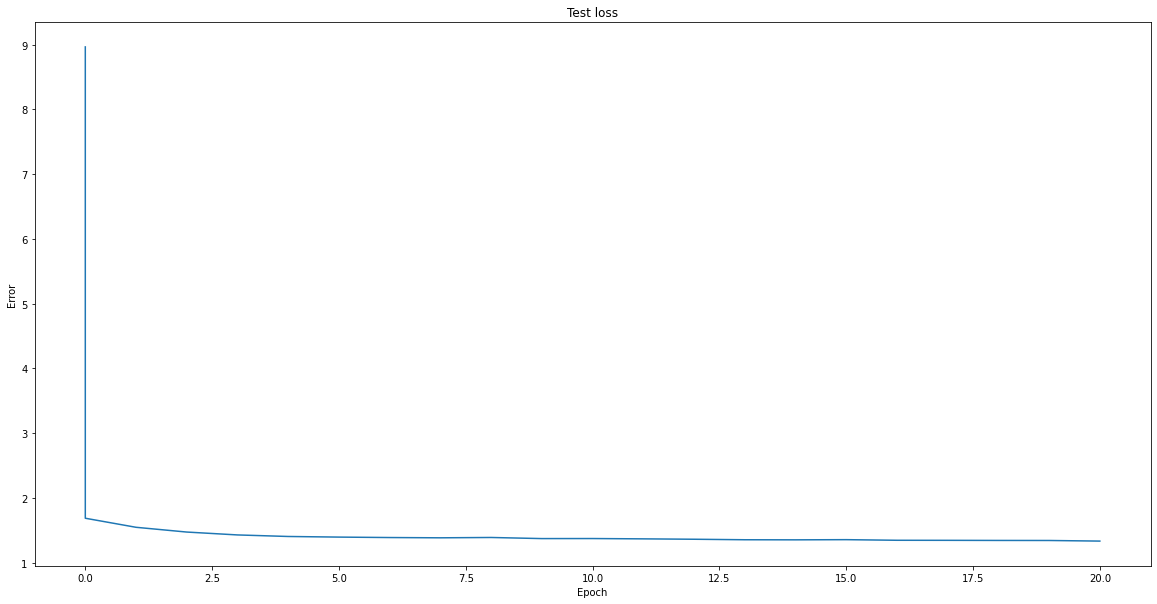

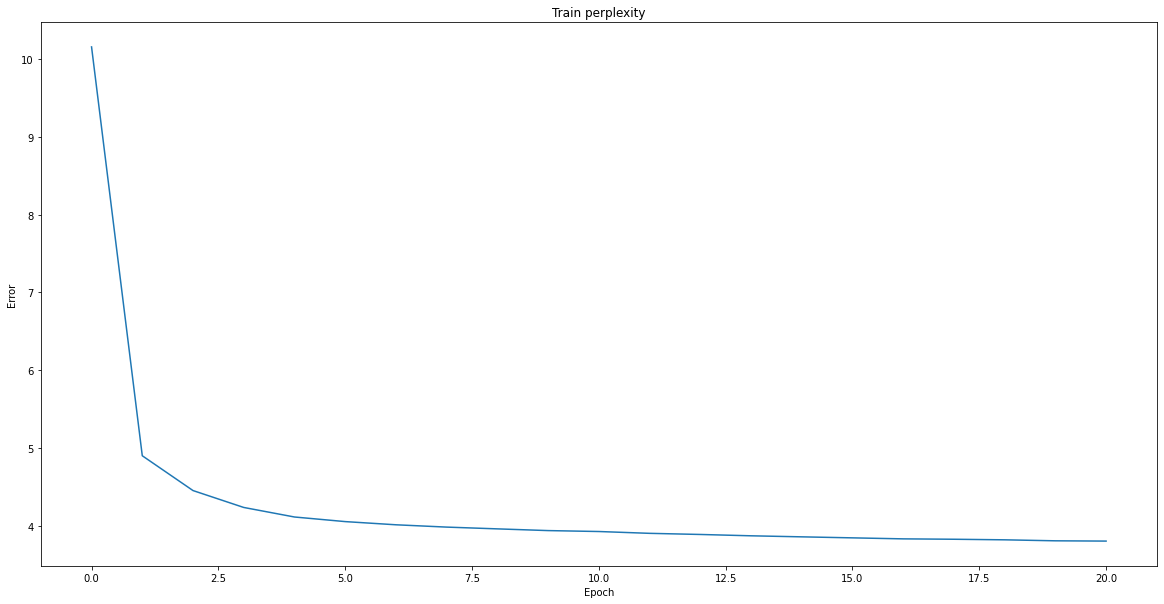

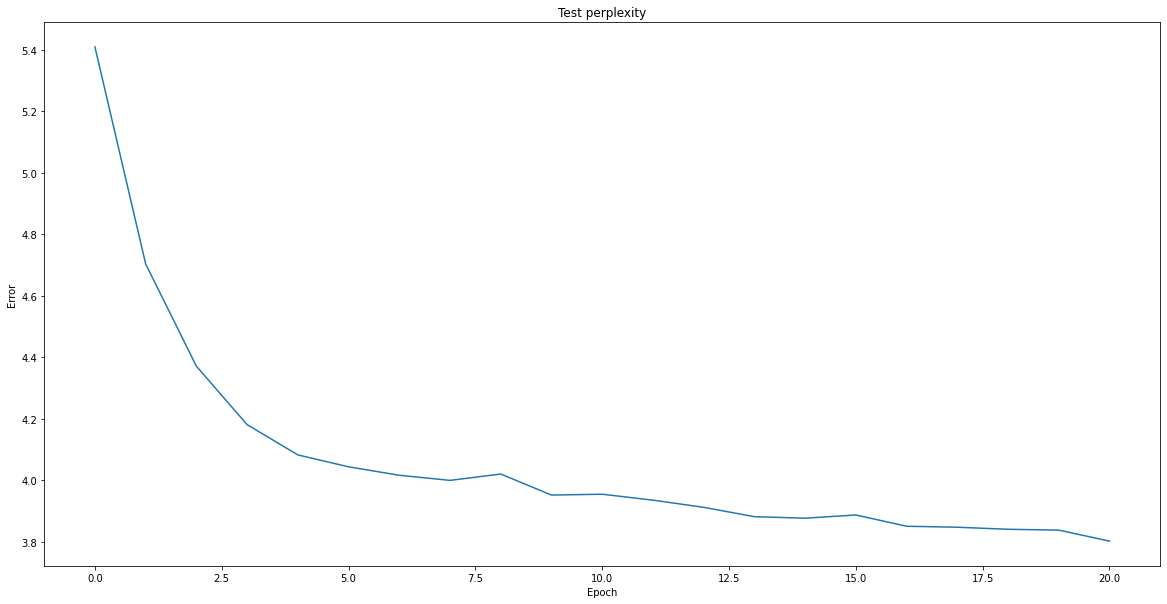

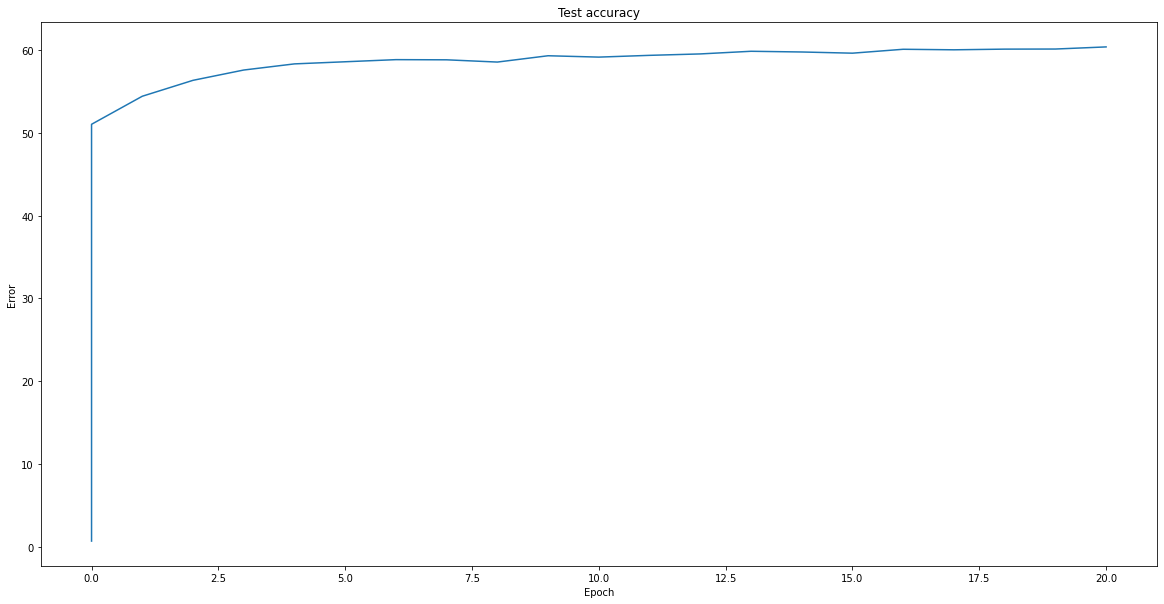

In [50]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'

    train_perplex, test_perplex = [], []

    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = LSTMHarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            train_perplex.append((epoch, np.exp(train_loss)))
            test_perplex.append((epoch, np.exp(test_loss)))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*train_perplex)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_perplex)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

In [51]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the other side of the close to the first time to see the team of the close to the first time to see the team of the close to the first time to see the team of the close to the first time to see the team 
generated with sample	 Harry Potter and the black shoulder in front of his chee. He was still to stop the corner of the end of them around the dooring the castle. "There was now the standing out of the closer bewards the teachers, Harry could 
generated with sample	 Harry Potter and the first being had to say to see off the Death Eaters. "He was a closely the ordes, they were something in the properation they was still the pair of the tries of a side of their side, like the Slonger 
generated with sample	 Harry Potter and they could reach the team, and the postrust of the ground and the first time were cominged to the floor.  "What's the consider when you know what they were all strongeried to be to be all out of the Dark
generated with sample	 Harr